In [1]:
###########################################
## Jax Demo
## Goal - fool around with Jax AutoDiff (function composition/transformation) library
##
## Author: Chris Meaney
## Date: Feb 2021
###########################################

In [2]:
## Import JAX dependencies
import jax

import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap, hessian
from jax import random
from jax.test_util import check_grads

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Pandas data wrangling, summarization, etc.
import pandas as pd

## Old numpy - for comparing speed/flexibility JAX approach vs. existing NumPy/Scipy capabilities
import numpy as onp

In [3]:
## Set seed
key = random.PRNGKey(912834)

In [4]:
key

DeviceArray([     0, 912834], dtype=uint32)

In [5]:
#######################################
##
## Some basic gradient/math examples in jax.numpy
##
#######################################

In [6]:
## Gradient of trig functions
grad_sin = grad(jnp.sin)
print([grad_sin(2.0), jnp.cos(2.0)])

[DeviceArray(-0.41614684, dtype=float32), DeviceArray(-0.41614684, dtype=float32)]


In [7]:
## Check gradients? using finite differences...how this work??
check_grads(jnp.sin, jnp.array([2.0]), order=2)

In [8]:
##
## Finite difference function: dy/dx = rise/run
##
def fd(f, x, eps):
    fd_grad = (f(x+eps) - f(x))/(eps)
    return fd_grad

# fd(jnp.sin, 2.0, 1e-3)    

In [9]:
## Gradient of trig functions
grad_cos = grad(jnp.cos)
print([grad_cos(2.0), jnp.sin(2.0), fd(jnp.cos, 2.0, 1e-3)])

[DeviceArray(-0.9092974, dtype=float32), DeviceArray(0.9092974, dtype=float32), DeviceArray(-0.9090006, dtype=float32)]


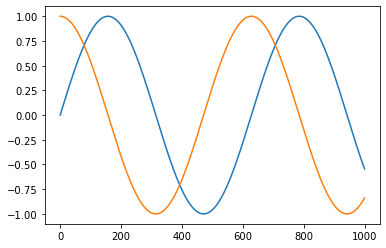

In [10]:
##
## Gradient of sin function
##
grad_sin = grad(jnp.sin)
#print(grad_sin(1.0))
#print(jnp.cos(1.0))

x = jnp.linspace(0,10,1000)
sinx = jnp.sin(x)
grad_sinx = vmap(grad(jnp.sin))(x)

plt.plot(sinx)
plt.plot(grad_sinx)

In [11]:
## Gradient of hyperbolic tangent function eval at 2.0
grad_tanh = grad(jnp.tanh)
[grad_tanh(2.0), fd(jnp.tanh, 2.0, 1e-3)]

[DeviceArray(0.07065082, dtype=float32), DeviceArray(0.0705719, dtype=float32)]

In [12]:
## And 3rd derivative of tanh()
grad3_tanh = grad(grad(grad(jnp.tanh)))
print(grad3_tanh(2.0))

0.25265405


In [13]:
## Gradient of log function
grad_log = grad(jnp.log)
[grad_log(4.0), fd(jnp.log, 4.0, 1e-3)]

[DeviceArray(0.25, dtype=float32), DeviceArray(0.24998187, dtype=float32)]

In [14]:
## Gradient of exponential function
grad_exp = grad(jnp.exp)
[grad_exp(2.0), fd(jnp.exp, 2.0, 1e-3)]

[DeviceArray(7.389056, dtype=float32), DeviceArray(7.391929, dtype=float32)]

In [15]:
## Scipy special functions
from jax.scipy.special import gammaln, digamma

print(grad(gammaln)(2.0))
print(digamma(2))
print(fd(gammaln, 2.0, 1e-3))

0.42278457
0.42278457
0.4239082


In [16]:
############################################
##
## Gradient of user defined function 
##
#############################################

In [17]:
## Simple multi-parameter function
def f(x,y):
    a = x*y
    b = (x+y)/y
    return a + b

## Gradient with respect to both arguments
grad_f = value_and_grad(f, argnums=(0,1))

## Evaluate gradient at arbitrary point
# grad_f(1.0,1.0)
val, df = grad_f(1.0,1.0)
df_dx = df[0]
df_dy = df[1]
print([val, df_dx, df_dy])

[DeviceArray(3., dtype=float32), DeviceArray(2., dtype=float32), DeviceArray(0., dtype=float32)]


In [18]:
##
## Consider polynomial in x
##
def polyx(x):
    return 10 + 7*x + 2*jnp.square(x)

## Compute gradient
grad_poly = value_and_grad(polyx, argnums=(0))

## Evaluate gradient at point
val, dpoly = grad_poly(2.0)
print([val, dpoly])

[DeviceArray(32., dtype=float32), DeviceArray(15., dtype=float32)]


In [19]:
##
## Logistic function
##

<AxesSubplot:xlabel='x', ylabel='y'>

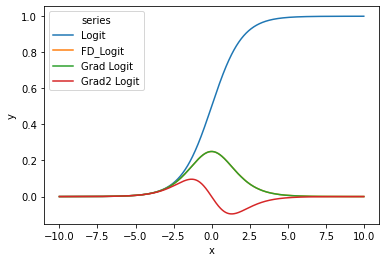

In [20]:
def logistic(x):
    return 1/(1+jnp.exp(-x))
    
## First derivative
grad_logistic = vmap(grad(logistic))
## Second derivative
grad2_logistic = vmap(grad(grad(logistic)))

## Linear seq of data
x = jnp.linspace(-10,10,1000)

logit = logistic(x)
grad_logit = grad_logistic(x)
fd_logit = fd(logistic, x, 1e-3)
grad2_logit = grad2_logistic(x)

xs = jnp.concatenate((x,x,x,x), axis=0)
ys = jnp.concatenate((logit,fd_logit,grad_logit,grad2_logit), axis=0)
labs = jnp.repeat(jnp.array([0,1,2,3]), 1000)

#[xs.shape, ys.shape, labs.shape]
df = pd.DataFrame({'y':ys, 'x':xs, 'labs':labs})
df['series'] = df['labs'].map({0:'Logit', 1:'FD_Logit', 2:'Grad Logit', 3:'Grad2 Logit'})
#df

## Lineplot
sns.lineplot(data=df, y='y', x='x', hue='series')

In [21]:
##########################################################
##
## Derivative of statistical functions
##
##########################################################

In [22]:
## Scipy statistical distribution functions
import jax.scipy.stats

In [23]:
#####################################################
##
## Linear regression example
##
#####################################################

In [24]:
## Data Generator
def datagen(N, num_coef, beta_true):
    ## Dimensions of the problem
    nrow = N
    ncol = num_coef-1
    beta = jnp.array(beta_true).reshape(ncol+1,1)
    ## Create dataset/design-matrix
    X = random.normal(key, shape=(nrow*ncol,)).reshape(nrow,ncol)
    ones = jnp.repeat(1.0, nrow).reshape(nrow,1)
    X = jnp.hstack((ones, X))
    ## Construct linear predictor (y-true)
    y = jnp.matmul(X, beta)
    ## Return design matrix and response vector to use
    return X, y

## Parameters for problem
N = 10
num_coef = 4
beta_true = [0.0,0.0,-1.0,1.0]

## Generation of randpm data
X, y = datagen(N=N, num_coef=num_coef, beta_true=beta_true)

## Check dimensions of returned objects
[X.shape, y.shape]

[(10, 4), (10, 1)]

In [25]:
#pd.DataFrame(X)

In [26]:
#pd.Series(y)

In [27]:
################################################################
## Linear regression via linear algebra in Scipy/Numpy linalg
################################################################

In [28]:
def linreg_scipy(X,y):
    ## Sufficient statistics
    XtX = jnp.matmul(X.T, X)
    Xty = jnp.matmul(X.T, y)
    ## Solution for beta vector as function sufficient statistics
    beta_hat = jnp.matmul(jnp.linalg.inv(XtX), Xty)
    return beta_hat

#print(X.shape)
#print(y.shape)

beta_hat = linreg_scipy(X=X, y=y) 

## Compare the estimated regresssion coefficients, with their true values
print(beta_true)
print(jnp.round(beta_hat.T))

[0.0, 0.0, -1.0, 1.0]
[[ 0.  0. -1.  1.]]


In [29]:
#############################################
## Linear regression using AutoGrad and JAX
#############################################

In [30]:
## Linear predictor
def linreg_pred(beta, X):
    return X.dot(beta).reshape(X.shape[0],1)

# linreg_pred(jnp.array(beta_true), X)
# linreg_pred(jnp.array(beta_true), X) - y

In [31]:
## Loss function
def linreg_loss(beta):
    y_hat = linreg_pred(beta, X)
    res2 = jnp.power((y-y_hat), 2.0)
    return jnp.mean(res2)

#print(linreg_loss(jnp.array(beta_true)))
#print(grad_linreg(jnp.array(beta_true)).shape)
#print(beta_true.shape)

In [32]:
## Gradient of loss with respect to linear regression parameters
grad_linreg = grad(linreg_loss)
#grad_linreg(jnp.array([0.0,0.0,0.0,0.1]))

In [33]:
## Create dataset
N = 1000
num_coef = 4
beta_true = [1.0, 0.2, -0.25, 0.0]
X, y = datagen(N=N, num_coef=num_coef, beta_true=beta_true)

## Initialization beta
beta = jnp.array([-1.0,1.0,0.0,0.0])

## Gradient descent step size parameter
step_size = 1e-4

## Calculate loss at current iteration of beta
grad_linreg = jit(grad(linreg_loss))

l = []

## Training loop
for i in jnp.arange(25000):
    ## Print current value of beta and loss
    current_beta = beta
    current_loss = linreg_loss(beta)
    l.append(current_loss)
    print("Iteration=",i, "\tLoss=",current_loss, "\tBeta=",beta)
    ## Updated loss using gradient descent step
    beta = beta - step_size*grad_linreg(beta)

Iteration= 0 	Loss= 4.571126 	Beta= [-1.  1.  0.  0.]
Iteration= 1 	Loss= 4.5693445 	Beta= [-9.9960631e-01  9.9985558e-01 -4.5312114e-05  1.5929605e-05]
Iteration= 2 	Loss= 4.5675635 	Beta= [-9.9921274e-01  9.9971116e-01 -9.0616144e-05  3.1852876e-05]
Iteration= 3 	Loss= 4.565784 	Beta= [-9.9881923e-01  9.9956679e-01 -1.3591212e-04  4.7769794e-05]
Iteration= 4 	Loss= 4.5640054 	Beta= [-9.9842578e-01  9.9942243e-01 -1.8120001e-04  6.3680374e-05]
Iteration= 5 	Loss= 4.5622263 	Beta= [-9.9803239e-01  9.9927813e-01 -2.2647985e-04  7.9584621e-05]
Iteration= 6 	Loss= 4.5604486 	Beta= [-9.9763912e-01  9.9913383e-01 -2.7175166e-04  9.5482545e-05]
Iteration= 7 	Loss= 4.5586715 	Beta= [-9.9724591e-01  9.9898952e-01 -3.1701539e-04  1.1137412e-04]
Iteration= 8 	Loss= 4.5568953 	Beta= [-9.9685276e-01  9.9884528e-01 -3.6227106e-04  1.2725937e-04]
Iteration= 9 	Loss= 4.5551186 	Beta= [-9.9645972e-01  9.9870104e-01 -4.0751864e-04  1.4313831e-04]
Iteration= 10 	Loss= 4.5533442 	Beta= [-9.9606675e-01  9

Iteration= 167 	Loss= 4.2830877 	Beta= [-0.93532175  0.976235   -0.00745629  0.00257379]
Iteration= 168 	Loss= 4.2814183 	Beta= [-0.9349408   0.9760948  -0.00750027  0.00258869]
Iteration= 169 	Loss= 4.2797503 	Beta= [-0.93456     0.97595465 -0.00754425  0.00260358]
Iteration= 170 	Loss= 4.2780833 	Beta= [-0.93417925  0.9758145  -0.00758822  0.00261846]
Iteration= 171 	Loss= 4.276417 	Beta= [-0.93379855  0.97567445 -0.00763218  0.00263334]
Iteration= 172 	Loss= 4.2747507 	Beta= [-0.9334179   0.9755344  -0.00767613  0.00264821]
Iteration= 173 	Loss= 4.273084 	Beta= [-0.9330374   0.9753943  -0.00772007  0.00266308]
Iteration= 174 	Loss= 4.2714195 	Beta= [-0.93265694  0.9752543  -0.00776401  0.00267794]
Iteration= 175 	Loss= 4.269756 	Beta= [-0.93227655  0.9751143  -0.00780794  0.00269279]
Iteration= 176 	Loss= 4.2680917 	Beta= [-0.9318962   0.97497433 -0.00785186  0.00270764]
Iteration= 177 	Loss= 4.266429 	Beta= [-0.931516    0.9748344  -0.00789577  0.00272249]
Iteration= 178 	Loss= 4.2

Iteration= 266 	Loss= 4.1209984 	Beta= [-0.8979741   0.96247935 -0.01177281  0.00401959]
Iteration= 267 	Loss= 4.119393 	Beta= [-0.89760053  0.96234167 -0.01181602  0.0040339 ]
Iteration= 268 	Loss= 4.1177883 	Beta= [-0.89722705  0.962204   -0.01185923  0.0040482 ]
Iteration= 269 	Loss= 4.1161847 	Beta= [-0.8968537   0.96206635 -0.01190242  0.0040625 ]
Iteration= 270 	Loss= 4.1145806 	Beta= [-0.8964804   0.9619287  -0.01194561  0.00407679]
Iteration= 271 	Loss= 4.112978 	Beta= [-0.89610714  0.9617911  -0.0119888   0.00409107]
Iteration= 272 	Loss= 4.111375 	Beta= [-0.89573395  0.96165353 -0.01203197  0.00410535]
Iteration= 273 	Loss= 4.109773 	Beta= [-0.8953608   0.96151596 -0.01207514  0.00411962]
Iteration= 274 	Loss= 4.1081724 	Beta= [-0.8949878   0.96137846 -0.0121183   0.00413389]
Iteration= 275 	Loss= 4.1065717 	Beta= [-0.8946149   0.96124095 -0.01216145  0.00414815]
Iteration= 276 	Loss= 4.104973 	Beta= [-0.894242    0.96110344 -0.01220459  0.00416241]
Iteration= 277 	Loss= 4.10

Iteration= 363 	Loss= 3.968149 	Beta= [-0.8620818   0.9492366  -0.01592883  0.0053805 ]
Iteration= 364 	Loss= 3.9666033 	Beta= [-0.8617154   0.94910127 -0.0159713   0.00539425]
Iteration= 365 	Loss= 3.965058 	Beta= [-0.861349    0.94896597 -0.01601377  0.005408  ]
Iteration= 366 	Loss= 3.9635131 	Beta= [-0.86098266  0.94883066 -0.01605622  0.00542173]
Iteration= 367 	Loss= 3.9619696 	Beta= [-0.86061645  0.9486954  -0.01609867  0.00543546]
Iteration= 368 	Loss= 3.9604259 	Beta= [-0.8602503   0.9485602  -0.01614112  0.00544919]
Iteration= 369 	Loss= 3.9588826 	Beta= [-0.8598842   0.948425   -0.01618355  0.00546291]
Iteration= 370 	Loss= 3.95734 	Beta= [-0.8595182   0.9482898  -0.01622598  0.00547663]
Iteration= 371 	Loss= 3.9557989 	Beta= [-0.8591522   0.9481546  -0.0162684   0.00549033]
Iteration= 372 	Loss= 3.9542577 	Beta= [-0.85878634  0.9480195  -0.01631081  0.00550404]
Iteration= 373 	Loss= 3.9527175 	Beta= [-0.85842055  0.9478844  -0.01635321  0.00551774]
Iteration= 374 	Loss= 3.9

Iteration= 465 	Loss= 3.8135452 	Beta= [-0.8250733   0.9355577  -0.02022219  0.00675388]
Iteration= 466 	Loss= 3.8120599 	Beta= [-0.8247141   0.93542486 -0.0202639   0.00676706]
Iteration= 467 	Loss= 3.8105745 	Beta= [-0.82435507  0.935292   -0.0203056   0.00678023]
Iteration= 468 	Loss= 3.8090901 	Beta= [-0.82399607  0.9351592  -0.02034729  0.0067934 ]
Iteration= 469 	Loss= 3.8076067 	Beta= [-0.8236371   0.9350264  -0.02038897  0.00680656]
Iteration= 470 	Loss= 3.8061235 	Beta= [-0.82327825  0.9348936  -0.02043065  0.00681972]
Iteration= 471 	Loss= 3.8046408 	Beta= [-0.8229194   0.93476087 -0.02047232  0.00683287]
Iteration= 472 	Loss= 3.8031592 	Beta= [-0.8225607   0.9346281  -0.02051398  0.00684601]
Iteration= 473 	Loss= 3.801678 	Beta= [-0.8222021   0.93449545 -0.02055564  0.00685915]
Iteration= 474 	Loss= 3.8001971 	Beta= [-0.8218435   0.93436277 -0.02059728  0.00687228]
Iteration= 475 	Loss= 3.7987168 	Beta= [-0.821485    0.9342301  -0.02063892  0.00688541]
Iteration= 476 	Loss= 

Iteration= 563 	Loss= 3.670694 	Beta= [-0.790211    0.9226492  -0.0242742   0.00801935]
Iteration= 564 	Loss= 3.6692646 	Beta= [-0.78985876  0.9225187  -0.02431518  0.008032  ]
Iteration= 565 	Loss= 3.6678357 	Beta= [-0.78950655  0.92238814 -0.02435615  0.00804464]
Iteration= 566 	Loss= 3.666407 	Beta= [-0.7891544   0.9222576  -0.02439712  0.00805727]
Iteration= 567 	Loss= 3.664979 	Beta= [-0.7888023   0.9221271  -0.02443808  0.0080699 ]
Iteration= 568 	Loss= 3.6635516 	Beta= [-0.7884503   0.92199665 -0.02447904  0.00808252]
Iteration= 569 	Loss= 3.6621244 	Beta= [-0.7880984   0.92186624 -0.02451998  0.00809514]
Iteration= 570 	Loss= 3.6606982 	Beta= [-0.78774655  0.9217358  -0.02456092  0.00810776]
Iteration= 571 	Loss= 3.6592727 	Beta= [-0.78739476  0.9216054  -0.02460185  0.00812036]
Iteration= 572 	Loss= 3.6578476 	Beta= [-0.78704304  0.92147505 -0.02464278  0.00813297]
Iteration= 573 	Loss= 3.6564226 	Beta= [-0.78669137  0.9213447  -0.02468369  0.00814556]
Iteration= 574 	Loss= 3.

Iteration= 661 	Loss= 3.533207 	Beta= [-0.7560164   0.90996575 -0.0282559   0.00923343]
Iteration= 662 	Loss= 3.5318305 	Beta= [-0.75567085  0.9098375  -0.02829617  0.00924555]
Iteration= 663 	Loss= 3.5304549 	Beta= [-0.7553254   0.9097092  -0.02833643  0.00925768]
Iteration= 664 	Loss= 3.5290804 	Beta= [-0.75497997  0.909581   -0.02837669  0.0092698 ]
Iteration= 665 	Loss= 3.5277054 	Beta= [-0.7546346   0.9094528  -0.02841694  0.00928191]
Iteration= 666 	Loss= 3.5263314 	Beta= [-0.7542894   0.9093246  -0.02845718  0.00929402]
Iteration= 667 	Loss= 3.5249581 	Beta= [-0.7539442   0.90919644 -0.02849742  0.00930612]
Iteration= 668 	Loss= 3.5235858 	Beta= [-0.7535991   0.9090683  -0.02853765  0.00931822]
Iteration= 669 	Loss= 3.522214 	Beta= [-0.75325406  0.9089402  -0.02857787  0.00933031]
Iteration= 670 	Loss= 3.5208423 	Beta= [-0.75290906  0.9088121  -0.02861808  0.0093424 ]
Iteration= 671 	Loss= 3.5194707 	Beta= [-0.75256413  0.908684   -0.02865829  0.00935448]
Iteration= 672 	Loss= 3

Iteration= 759 	Loss= 3.4008808 	Beta= [-0.72247666  0.8975036  -0.0321685   0.01039762]
Iteration= 760 	Loss= 3.3995562 	Beta= [-0.72213775  0.89737755 -0.03220807  0.01040925]
Iteration= 761 	Loss= 3.3982322 	Beta= [-0.7217989   0.89725155 -0.03224764  0.01042087]
Iteration= 762 	Loss= 3.3969088 	Beta= [-0.7214601   0.89712554 -0.0322872   0.01043249]
Iteration= 763 	Loss= 3.3955858 	Beta= [-0.7211214   0.8969996  -0.03232675  0.0104441 ]
Iteration= 764 	Loss= 3.3942645 	Beta= [-0.72078276  0.89687365 -0.03236629  0.01045571]
Iteration= 765 	Loss= 3.3929422 	Beta= [-0.7204442   0.8967477  -0.03240583  0.01046731]
Iteration= 766 	Loss= 3.391621 	Beta= [-0.7201057   0.8966218  -0.03244536  0.01047891]
Iteration= 767 	Loss= 3.3903003 	Beta= [-0.7197673   0.89649594 -0.03248488  0.0104905 ]
Iteration= 768 	Loss= 3.3889802 	Beta= [-0.7194289   0.89637005 -0.03252439  0.01050209]
Iteration= 769 	Loss= 3.3876605 	Beta= [-0.7190906   0.8962442  -0.0325639   0.01051367]
Iteration= 770 	Loss= 

Iteration= 858 	Loss= 3.272247 	Beta= [-0.68924683  0.88513494 -0.03605205  0.01152454]
Iteration= 859 	Loss= 3.2709727 	Beta= [-0.6889145   0.88501114 -0.03609093  0.01153568]
Iteration= 860 	Loss= 3.2696998 	Beta= [-0.6885822   0.88488734 -0.0361298   0.01154681]
Iteration= 861 	Loss= 3.2684264 	Beta= [-0.68824995  0.88476354 -0.03616866  0.01155794]
Iteration= 862 	Loss= 3.2671537 	Beta= [-0.68791777  0.8846398  -0.03620752  0.01156906]
Iteration= 863 	Loss= 3.265881 	Beta= [-0.68758565  0.88451606 -0.03624637  0.01158017]
Iteration= 864 	Loss= 3.2646103 	Beta= [-0.68725365  0.8843924  -0.03628522  0.01159129]
Iteration= 865 	Loss= 3.2633388 	Beta= [-0.6869217   0.8842687  -0.03632405  0.01160239]
Iteration= 866 	Loss= 3.262068 	Beta= [-0.68658984  0.884145   -0.03636288  0.0116135 ]
Iteration= 867 	Loss= 3.260798 	Beta= [-0.686258    0.8840214  -0.0364017   0.01162459]
Iteration= 868 	Loss= 3.2595286 	Beta= [-0.68592626  0.8838978  -0.03644052  0.01163568]
Iteration= 869 	Loss= 3.2

Iteration= 957 	Loss= 3.14849 	Beta= [-0.65665966  0.87298435 -0.03986747  0.01260355]
Iteration= 958 	Loss= 3.1472642 	Beta= [-0.65633374  0.8728627  -0.03990567  0.01261421]
Iteration= 959 	Loss= 3.1460385 	Beta= [-0.6560079   0.8727411  -0.03994386  0.01262486]
Iteration= 960 	Loss= 3.1448138 	Beta= [-0.6556821   0.8726195  -0.03998204  0.01263551]
Iteration= 961 	Loss= 3.1435895 	Beta= [-0.65535635  0.8724979  -0.04002021  0.01264616]
Iteration= 962 	Loss= 3.1423655 	Beta= [-0.65503067  0.8723764  -0.04005838  0.0126568 ]
Iteration= 963 	Loss= 3.1411421 	Beta= [-0.65470505  0.87225485 -0.04009654  0.01266743]
Iteration= 964 	Loss= 3.1399188 	Beta= [-0.6543795   0.8721334  -0.0401347   0.01267806]
Iteration= 965 	Loss= 3.1386964 	Beta= [-0.654054    0.8720119  -0.04017285  0.01268869]
Iteration= 966 	Loss= 3.1374743 	Beta= [-0.65372854  0.8718904  -0.04021099  0.01269931]
Iteration= 967 	Loss= 3.1362529 	Beta= [-0.6534032   0.871769   -0.04024912  0.01270993]
Iteration= 968 	Loss= 3

Iteration= 1056 	Loss= 3.0294232 	Beta= [-0.62470275  0.8610479  -0.04361593  0.01363607]
Iteration= 1057 	Loss= 3.0282445 	Beta= [-0.62438315  0.8609284  -0.04365345  0.01364627]
Iteration= 1058 	Loss= 3.0270655 	Beta= [-0.6240636   0.86080897 -0.04369097  0.01365646]
Iteration= 1059 	Loss= 3.025887 	Beta= [-0.62374413  0.8606895  -0.04372849  0.01366665]
Iteration= 1060 	Loss= 3.024709 	Beta= [-0.6234247   0.8605701  -0.04376599  0.01367683]
Iteration= 1061 	Loss= 3.0235314 	Beta= [-0.62310535  0.8604507  -0.04380349  0.01368701]
Iteration= 1062 	Loss= 3.0223548 	Beta= [-0.62278605  0.8603313  -0.04384098  0.01369719]
Iteration= 1063 	Loss= 3.021178 	Beta= [-0.6224668   0.8602119  -0.04387847  0.01370736]
Iteration= 1064 	Loss= 3.0200021 	Beta= [-0.6221476   0.8600926  -0.04391595  0.01371752]
Iteration= 1065 	Loss= 3.018826 	Beta= [-0.6218285   0.85997325 -0.04395342  0.01372768]
Iteration= 1066 	Loss= 3.0176506 	Beta= [-0.62150943  0.859854   -0.04399088  0.01373784]
Iteration= 106

Iteration= 1156 	Loss= 2.9137366 	Beta= [-0.59305066  0.84920466 -0.04733544  0.01463328]
Iteration= 1157 	Loss= 2.9126017 	Beta= [-0.59273726  0.8490873  -0.0473723   0.01464302]
Iteration= 1158 	Loss= 2.911468 	Beta= [-0.5924239   0.84896994 -0.04740915  0.01465276]
Iteration= 1159 	Loss= 2.9103348 	Beta= [-0.59211063  0.84885263 -0.047446    0.0146625 ]
Iteration= 1160 	Loss= 2.9092016 	Beta= [-0.5917974   0.84873533 -0.04748284  0.01467223]
Iteration= 1161 	Loss= 2.9080696 	Beta= [-0.5914843   0.84861803 -0.04751967  0.01468196]
Iteration= 1162 	Loss= 2.9069378 	Beta= [-0.59117126  0.8485008  -0.0475565   0.01469168]
Iteration= 1163 	Loss= 2.9058063 	Beta= [-0.5908583   0.84838355 -0.04759332  0.0147014 ]
Iteration= 1164 	Loss= 2.9046748 	Beta= [-0.59054536  0.8482663  -0.04763013  0.01471111]
Iteration= 1165 	Loss= 2.9035442 	Beta= [-0.5902325   0.8481491  -0.04766694  0.01472082]
Iteration= 1166 	Loss= 2.9024143 	Beta= [-0.5899197   0.84803194 -0.04770374  0.01473053]
Iteration= 

Iteration= 1255 	Loss= 2.8035688 	Beta= [-0.5623243   0.83768755 -0.05095276  0.0155766 ]
Iteration= 1256 	Loss= 2.8024771 	Beta= [-0.56201696  0.8375723  -0.05098897  0.01558591]
Iteration= 1257 	Loss= 2.8013868 	Beta= [-0.5617097   0.837457   -0.05102518  0.01559521]
Iteration= 1258 	Loss= 2.800296 	Beta= [-0.5614025   0.8373417  -0.05106138  0.01560451]
Iteration= 1259 	Loss= 2.799206 	Beta= [-0.56109536  0.8372265  -0.05109757  0.01561381]
Iteration= 1260 	Loss= 2.7981162 	Beta= [-0.5607883   0.8371113  -0.05113376  0.0156231 ]
Iteration= 1261 	Loss= 2.7970276 	Beta= [-0.56048125  0.8369961  -0.05116994  0.01563239]
Iteration= 1262 	Loss= 2.7959385 	Beta= [-0.5601743   0.8368809  -0.05120611  0.01564168]
Iteration= 1263 	Loss= 2.7948503 	Beta= [-0.5598674   0.83676577 -0.05124228  0.01565096]
Iteration= 1264 	Loss= 2.7937624 	Beta= [-0.55956054  0.83665067 -0.05127844  0.01566023]
Iteration= 1265 	Loss= 2.792675 	Beta= [-0.55925375  0.8365356  -0.05131459  0.0156695 ]
Iteration= 12

Iteration= 1356 	Loss= 2.695478 	Beta= [-0.5315899   0.826147   -0.05457766  0.01649532]
Iteration= 1357 	Loss= 2.6944287 	Beta= [-0.5312887   0.82603383 -0.05461322  0.0165042 ]
Iteration= 1358 	Loss= 2.6933804 	Beta= [-0.5309875   0.82592064 -0.05464878  0.01651308]
Iteration= 1359 	Loss= 2.692332 	Beta= [-0.5306864   0.82580745 -0.05468433  0.01652195]
Iteration= 1360 	Loss= 2.6912844 	Beta= [-0.5303853   0.8256943  -0.05471987  0.01653082]
Iteration= 1361 	Loss= 2.6902366 	Beta= [-0.5300843   0.8255812  -0.05475541  0.01653968]
Iteration= 1362 	Loss= 2.6891901 	Beta= [-0.52978337  0.82546806 -0.05479094  0.01654854]
Iteration= 1363 	Loss= 2.6881435 	Beta= [-0.5294825   0.825355   -0.05482647  0.0165574 ]
Iteration= 1364 	Loss= 2.6870968 	Beta= [-0.52918166  0.8252419  -0.05486199  0.01656625]
Iteration= 1365 	Loss= 2.6860516 	Beta= [-0.5288809   0.82512885 -0.0548975   0.0165751 ]
Iteration= 1366 	Loss= 2.6850061 	Beta= [-0.5285802   0.82501584 -0.054933    0.01658394]
Iteration= 1

Iteration= 1456 	Loss= 2.5925727 	Beta= [-0.501757    0.8149255  -0.05810263  0.01736287]
Iteration= 1457 	Loss= 2.5915635 	Beta= [-0.5014616   0.81481427 -0.05813756  0.01737133]
Iteration= 1458 	Loss= 2.590555 	Beta= [-0.5011663   0.8147031  -0.05817249  0.0173798 ]
Iteration= 1459 	Loss= 2.5895467 	Beta= [-0.500871    0.81459194 -0.05820741  0.01738826]
Iteration= 1460 	Loss= 2.5885391 	Beta= [-0.5005758   0.8144808  -0.05824232  0.01739671]
Iteration= 1461 	Loss= 2.5875318 	Beta= [-0.5002806   0.8143697  -0.05827723  0.01740517]
Iteration= 1462 	Loss= 2.5865242 	Beta= [-0.49998555  0.8142586  -0.05831213  0.01741362]
Iteration= 1463 	Loss= 2.5855181 	Beta= [-0.49969053  0.8141475  -0.05834702  0.01742206]
Iteration= 1464 	Loss= 2.5845125 	Beta= [-0.49939558  0.8140364  -0.05838191  0.0174305 ]
Iteration= 1465 	Loss= 2.5835059 	Beta= [-0.4991007   0.8139254  -0.05841679  0.01743894]
Iteration= 1466 	Loss= 2.5825005 	Beta= [-0.49880585  0.81381434 -0.05845167  0.01744737]
Iteration= 

Iteration= 1554 	Loss= 2.4955447 	Beta= [-0.47308552  0.8041221  -0.06149636  0.01817369]
Iteration= 1555 	Loss= 2.4945736 	Beta= [-0.4727958   0.80401284 -0.06153069  0.01818176]
Iteration= 1556 	Loss= 2.493603 	Beta= [-0.47250617  0.8039036  -0.061565    0.01818984]
Iteration= 1557 	Loss= 2.492633 	Beta= [-0.47221655  0.8037944  -0.06159931  0.01819791]
Iteration= 1558 	Loss= 2.491663 	Beta= [-0.471927    0.8036852  -0.06163362  0.01820597]
Iteration= 1559 	Loss= 2.4906929 	Beta= [-0.4716375   0.803576   -0.06166792  0.01821403]
Iteration= 1560 	Loss= 2.4897237 	Beta= [-0.47134805  0.80346686 -0.06170221  0.01822209]
Iteration= 1561 	Loss= 2.4887552 	Beta= [-0.47105867  0.8033577  -0.0617365   0.01823014]
Iteration= 1562 	Loss= 2.4877865 	Beta= [-0.47076935  0.8032486  -0.06177078  0.01823819]
Iteration= 1563 	Loss= 2.486818 	Beta= [-0.47048008  0.8031395  -0.06180505  0.01824624]
Iteration= 1564 	Loss= 2.4858506 	Beta= [-0.47019088  0.80303043 -0.06183932  0.01825428]
Iteration= 156

Iteration= 1733 	Loss= 2.3276181 	Beta= [-0.42212555  0.78487444 -0.06754328  0.01955798]
Iteration= 1734 	Loss= 2.3267124 	Beta= [-0.42184588  0.78476864 -0.06757651  0.01956537]
Iteration= 1735 	Loss= 2.3258073 	Beta= [-0.42156628  0.78466284 -0.06760975  0.01957276]
Iteration= 1736 	Loss= 2.3249025 	Beta= [-0.42128673  0.7845571  -0.06764298  0.01958014]
Iteration= 1737 	Loss= 2.3239982 	Beta= [-0.42100722  0.78445137 -0.0676762   0.01958752]
Iteration= 1738 	Loss= 2.323094 	Beta= [-0.42072776  0.7843456  -0.06770942  0.0195949 ]
Iteration= 1739 	Loss= 2.32219 	Beta= [-0.42044836  0.78423995 -0.06774262  0.01960228]
Iteration= 1740 	Loss= 2.3212867 	Beta= [-0.42016903  0.78413427 -0.06777583  0.01960965]
Iteration= 1741 	Loss= 2.3203833 	Beta= [-0.41988975  0.7840286  -0.06780903  0.01961701]
Iteration= 1742 	Loss= 2.3194802 	Beta= [-0.41961053  0.783923   -0.06784222  0.01962438]
Iteration= 1743 	Loss= 2.3185785 	Beta= [-0.41933137  0.78381735 -0.06787541  0.01963174]
Iteration= 17

Iteration= 1911 	Loss= 2.1718616 	Beta= [-0.37320316  0.76633906 -0.07336693  0.02081643]
Iteration= 1912 	Loss= 2.171017 	Beta= [-0.37293315  0.7662366  -0.07339913  0.02082318]
Iteration= 1913 	Loss= 2.1701722 	Beta= [-0.37266317  0.76613414 -0.07343131  0.02082992]
Iteration= 1914 	Loss= 2.1693282 	Beta= [-0.37239325  0.76603174 -0.0734635   0.02083667]
Iteration= 1915 	Loss= 2.1684844 	Beta= [-0.3721234   0.76592934 -0.07349568  0.02084341]
Iteration= 1916 	Loss= 2.1676407 	Beta= [-0.3718536   0.76582694 -0.07352785  0.02085014]
Iteration= 1917 	Loss= 2.1667974 	Beta= [-0.37158382  0.76572454 -0.07356001  0.02085687]
Iteration= 1918 	Loss= 2.1659544 	Beta= [-0.3713141   0.7656222  -0.07359217  0.0208636 ]
Iteration= 1919 	Loss= 2.1651118 	Beta= [-0.37104446  0.76551986 -0.07362433  0.02087033]
Iteration= 1920 	Loss= 2.1642694 	Beta= [-0.37077487  0.7654175  -0.07365648  0.02087705]
Iteration= 1921 	Loss= 2.1634283 	Beta= [-0.37050533  0.76531523 -0.07368862  0.02088377]
Iteration= 

Iteration= 2006 	Loss= 2.0930538 	Beta= [-0.34778723  0.7566867  -0.07639975  0.02144215]
Iteration= 2007 	Loss= 2.0922399 	Beta= [-0.34752223  0.75658596 -0.0764314   0.02144857]
Iteration= 2008 	Loss= 2.091426 	Beta= [-0.34725726  0.7564852  -0.07646304  0.02145499]
Iteration= 2009 	Loss= 2.0906126 	Beta= [-0.34699234  0.75638455 -0.07649468  0.0214614 ]
Iteration= 2010 	Loss= 2.0897994 	Beta= [-0.3467275   0.7562839  -0.07652631  0.02146781]
Iteration= 2011 	Loss= 2.0889864 	Beta= [-0.3464627   0.7561832  -0.07655794  0.02147422]
Iteration= 2012 	Loss= 2.0881734 	Beta= [-0.34619793  0.7560826  -0.07658956  0.02148062]
Iteration= 2013 	Loss= 2.0873613 	Beta= [-0.34593323  0.755982   -0.07662117  0.02148703]
Iteration= 2014 	Loss= 2.0865495 	Beta= [-0.34566858  0.75588137 -0.07665279  0.02149342]
Iteration= 2015 	Loss= 2.0857375 	Beta= [-0.345404    0.75578076 -0.07668439  0.02149982]
Iteration= 2016 	Loss= 2.0849264 	Beta= [-0.34513944  0.7556802  -0.07671599  0.02150621]
Iteration= 

Iteration= 2101 	Loss= 2.0171115 	Beta= [-0.32284293  0.7471979  -0.07938126  0.02203715]
Iteration= 2102 	Loss= 2.0163274 	Beta= [-0.32258284  0.7470989  -0.07941237  0.02204326]
Iteration= 2103 	Loss= 2.015543 	Beta= [-0.3223228   0.7469999  -0.07944348  0.02204936]
Iteration= 2104 	Loss= 2.014759 	Beta= [-0.3220628   0.7469009  -0.07947458  0.02205545]
Iteration= 2105 	Loss= 2.0139756 	Beta= [-0.32180285  0.746802   -0.07950568  0.02206155]
Iteration= 2106 	Loss= 2.0131922 	Beta= [-0.32154298  0.746703   -0.07953677  0.02206764]
Iteration= 2107 	Loss= 2.0124092 	Beta= [-0.32128313  0.7466041  -0.07956786  0.02207372]
Iteration= 2108 	Loss= 2.0116265 	Beta= [-0.32102334  0.74650514 -0.07959894  0.02207981]
Iteration= 2109 	Loss= 2.0108442 	Beta= [-0.32076362  0.74640626 -0.07963002  0.02208589]
Iteration= 2110 	Loss= 2.010062 	Beta= [-0.32050392  0.7463074  -0.07966109  0.02209196]
Iteration= 2111 	Loss= 2.0092802 	Beta= [-0.32024428  0.7462085  -0.07969215  0.02209804]
Iteration= 21

Iteration= 2195 	Loss= 1.9446876 	Beta= [-0.29861683  0.73796725 -0.08228173  0.02259657]
Iteration= 2196 	Loss= 1.9439312 	Beta= [-0.2983615   0.7378699  -0.08231232  0.02260237]
Iteration= 2197 	Loss= 1.9431754 	Beta= [-0.29810625  0.7377726  -0.08234291  0.02260816]
Iteration= 2198 	Loss= 1.9424194 	Beta= [-0.29785103  0.73767525 -0.08237349  0.02261395]
Iteration= 2199 	Loss= 1.9416643 	Beta= [-0.29759586  0.7375779  -0.08240407  0.02261974]
Iteration= 2200 	Loss= 1.9409091 	Beta= [-0.29734075  0.73748064 -0.08243464  0.02262552]
Iteration= 2201 	Loss= 1.9401544 	Beta= [-0.29708567  0.73738337 -0.08246521  0.02263131]
Iteration= 2202 	Loss= 1.9394 	Beta= [-0.29683065  0.7372861  -0.08249577  0.02263708]
Iteration= 2203 	Loss= 1.9386457 	Beta= [-0.2965757   0.7371889  -0.08252633  0.02264286]
Iteration= 2204 	Loss= 1.9378916 	Beta= [-0.29632077  0.73709166 -0.08255687  0.02264863]
Iteration= 2205 	Loss= 1.9371381 	Beta= [-0.2960659   0.73699445 -0.08258742  0.0226544 ]
Iteration= 22

Iteration= 2289 	Loss= 1.87487 	Beta= [-0.27483562  0.7288915  -0.08513363  0.0231277 ]
Iteration= 2290 	Loss= 1.8741409 	Beta= [-0.27458498  0.72879577 -0.08516371  0.02313321]
Iteration= 2291 	Loss= 1.8734121 	Beta= [-0.2743344   0.72870004 -0.08519379  0.02313871]
Iteration= 2292 	Loss= 1.8726839 	Beta= [-0.27408388  0.7286044  -0.08522386  0.0231442 ]
Iteration= 2293 	Loss= 1.8719554 	Beta= [-0.2738334   0.7285087  -0.08525392  0.02314969]
Iteration= 2294 	Loss= 1.8712275 	Beta= [-0.27358297  0.72841305 -0.08528399  0.02315518]
Iteration= 2295 	Loss= 1.8704997 	Beta= [-0.2733326   0.7283174  -0.08531404  0.02316067]
Iteration= 2296 	Loss= 1.8697727 	Beta= [-0.27308226  0.7282218  -0.08534409  0.02316615]
Iteration= 2297 	Loss= 1.8690455 	Beta= [-0.27283198  0.72812617 -0.08537413  0.02317163]
Iteration= 2298 	Loss= 1.8683186 	Beta= [-0.27258176  0.72803056 -0.08540417  0.02317711]
Iteration= 2299 	Loss= 1.8675922 	Beta= [-0.27233157  0.727935   -0.08543421  0.02318258]
Iteration= 2

Iteration= 2388 	Loss= 1.8040531 	Beta= [-0.2502614   0.7194973  -0.08808558  0.02365745]
Iteration= 2389 	Loss= 1.8033513 	Beta= [-0.25001562  0.71940327 -0.08811513  0.02366265]
Iteration= 2390 	Loss= 1.8026502 	Beta= [-0.24976988  0.7193093  -0.08814467  0.02366785]
Iteration= 2391 	Loss= 1.8019495 	Beta= [-0.24952419  0.7192153  -0.08817421  0.02367304]
Iteration= 2392 	Loss= 1.8012483 	Beta= [-0.24927855  0.7191213  -0.08820374  0.02367823]
Iteration= 2393 	Loss= 1.8005483 	Beta= [-0.24903296  0.7190273  -0.08823327  0.02368342]
Iteration= 2394 	Loss= 1.7998483 	Beta= [-0.24878742  0.71893334 -0.0882628   0.0236886 ]
Iteration= 2395 	Loss= 1.7991483 	Beta= [-0.24854192  0.7188394  -0.08829232  0.02369379]
Iteration= 2396 	Loss= 1.7984487 	Beta= [-0.24829647  0.71874547 -0.08832183  0.02369896]
Iteration= 2397 	Loss= 1.7977494 	Beta= [-0.24805108  0.7186516  -0.08835133  0.02370414]
Iteration= 2398 	Loss= 1.7970504 	Beta= [-0.24780573  0.7185577  -0.08838084  0.02370931]
Iteration=

Iteration= 2487 	Loss= 1.7359167 	Beta= [-0.2261621   0.71026933 -0.09098545  0.02415776]
Iteration= 2488 	Loss= 1.7352418 	Beta= [-0.22592106  0.71017694 -0.09101447  0.02416267]
Iteration= 2489 	Loss= 1.7345673 	Beta= [-0.22568008  0.71008456 -0.0910435   0.02416757]
Iteration= 2490 	Loss= 1.7338929 	Beta= [-0.22543915  0.70999223 -0.09107252  0.02417247]
Iteration= 2491 	Loss= 1.7332187 	Beta= [-0.22519825  0.7098999  -0.09110153  0.02417737]
Iteration= 2492 	Loss= 1.7325449 	Beta= [-0.2249574   0.7098076  -0.09113054  0.02418226]
Iteration= 2493 	Loss= 1.7318712 	Beta= [-0.2247166   0.7097153  -0.09115954  0.02418716]
Iteration= 2494 	Loss= 1.7311978 	Beta= [-0.22447585  0.70962304 -0.09118854  0.02419204]
Iteration= 2495 	Loss= 1.7305249 	Beta= [-0.22423515  0.7095308  -0.09121753  0.02419693]
Iteration= 2496 	Loss= 1.729852 	Beta= [-0.2239945   0.7094385  -0.09124652  0.02420181]
Iteration= 2497 	Loss= 1.7291795 	Beta= [-0.22375388  0.7093463  -0.09127551  0.02420669]
Iteration= 

Iteration= 2587 	Loss= 1.6697103 	Beta= [-0.20229219  0.7011135  -0.09386265  0.02463418]
Iteration= 2588 	Loss= 1.6690612 	Beta= [-0.20205586  0.7010228  -0.09389117  0.0246388 ]
Iteration= 2589 	Loss= 1.6684124 	Beta= [-0.20181957  0.7009321  -0.09391967  0.02464342]
Iteration= 2590 	Loss= 1.6677636 	Beta= [-0.20158333  0.70084137 -0.09394817  0.02464804]
Iteration= 2591 	Loss= 1.6671153 	Beta= [-0.20134713  0.7007507  -0.09397667  0.02465265]
Iteration= 2592 	Loss= 1.6664673 	Beta= [-0.20111099  0.70066005 -0.09400516  0.02465726]
Iteration= 2593 	Loss= 1.6658194 	Beta= [-0.2008749   0.7005694  -0.09403364  0.02466187]
Iteration= 2594 	Loss= 1.665172 	Beta= [-0.20063885  0.70047873 -0.09406213  0.02466647]
Iteration= 2595 	Loss= 1.6645246 	Beta= [-0.20040284  0.70038813 -0.0940906   0.02467107]
Iteration= 2596 	Loss= 1.6638771 	Beta= [-0.20016688  0.70029753 -0.09411907  0.02467567]
Iteration= 2597 	Loss= 1.6632303 	Beta= [-0.19993097  0.70020694 -0.09414754  0.02468026]
Iteration= 

Iteration= 2686 	Loss= 1.606659 	Beta= [-0.17911991  0.6922101  -0.09666055  0.02507814]
Iteration= 2687 	Loss= 1.6060345 	Beta= [-0.17888816  0.69212097 -0.09668856  0.02508249]
Iteration= 2688 	Loss= 1.6054105 	Beta= [-0.17865644  0.69203186 -0.09671656  0.02508683]
Iteration= 2689 	Loss= 1.6047864 	Beta= [-0.17842478  0.69194275 -0.09674456  0.02509117]
Iteration= 2690 	Loss= 1.6041625 	Beta= [-0.17819315  0.6918537  -0.09677255  0.02509551]
Iteration= 2691 	Loss= 1.6035389 	Beta= [-0.17796157  0.69176465 -0.09680054  0.02509985]
Iteration= 2692 	Loss= 1.6029154 	Beta= [-0.17773004  0.6916756  -0.09682852  0.02510418]
Iteration= 2693 	Loss= 1.6022923 	Beta= [-0.17749855  0.69158655 -0.0968565   0.02510851]
Iteration= 2694 	Loss= 1.6016697 	Beta= [-0.1772671   0.69149756 -0.09688447  0.02511284]
Iteration= 2695 	Loss= 1.6010468 	Beta= [-0.1770357   0.6914086  -0.09691244  0.02511716]
Iteration= 2696 	Loss= 1.6004245 	Beta= [-0.17680435  0.6913196  -0.0969404   0.02512148]
Iteration= 

Iteration= 2785 	Loss= 1.5459942 	Beta= [-0.15639547  0.6834641  -0.09940899  0.02549542]
Iteration= 2786 	Loss= 1.5453933 	Beta= [-0.15616818  0.68337655 -0.09943651  0.0254995 ]
Iteration= 2787 	Loss= 1.5447927 	Beta= [-0.15594094  0.683289   -0.09946401  0.02550358]
Iteration= 2788 	Loss= 1.5441923 	Beta= [-0.15571374  0.6832015  -0.09949151  0.02550765]
Iteration= 2789 	Loss= 1.5435917 	Beta= [-0.15548658  0.683114   -0.09951901  0.02551173]
Iteration= 2790 	Loss= 1.5429921 	Beta= [-0.15525948  0.6830265  -0.09954651  0.0255158 ]
Iteration= 2791 	Loss= 1.5423923 	Beta= [-0.15503241  0.682939   -0.09957399  0.02551987]
Iteration= 2792 	Loss= 1.5417925 	Beta= [-0.15480539  0.68285155 -0.09960148  0.02552393]
Iteration= 2793 	Loss= 1.5411934 	Beta= [-0.15457842  0.6827641  -0.09962896  0.025528  ]
Iteration= 2794 	Loss= 1.5405942 	Beta= [-0.15435149  0.6826767  -0.09965643  0.02553206]
Iteration= 2795 	Loss= 1.5399956 	Beta= [-0.1541246   0.6825893  -0.0996839   0.02553612]
Iteration=

Iteration= 2883 	Loss= 1.4882034 	Beta= [-0.134333    0.6749586  -0.10208187  0.02588306]
Iteration= 2884 	Loss= 1.487625 	Beta= [-0.13411006  0.6748726  -0.1021089   0.02588689]
Iteration= 2885 	Loss= 1.4870466 	Beta= [-0.13388717  0.67478657 -0.10213593  0.02589072]
Iteration= 2886 	Loss= 1.4864686 	Beta= [-0.13366432  0.67470056 -0.10216295  0.02589454]
Iteration= 2887 	Loss= 1.4858909 	Beta= [-0.13344152  0.6746146  -0.10218997  0.02589836]
Iteration= 2888 	Loss= 1.4853137 	Beta= [-0.13321877  0.67452866 -0.10221698  0.02590218]
Iteration= 2889 	Loss= 1.4847362 	Beta= [-0.13299605  0.6744427  -0.10224399  0.02590599]
Iteration= 2890 	Loss= 1.4841591 	Beta= [-0.13277338  0.67435676 -0.10227099  0.0259098 ]
Iteration= 2891 	Loss= 1.4835825 	Beta= [-0.13255076  0.67427087 -0.10229799  0.02591361]
Iteration= 2892 	Loss= 1.4830058 	Beta= [-0.13232817  0.674185   -0.10232498  0.02591742]
Iteration= 2893 	Loss= 1.4824293 	Beta= [-0.13210562  0.6740991  -0.10235197  0.02592123]
Iteration= 

Iteration= 2980 	Loss= 1.4331344 	Beta= [-0.11291131  0.6666865  -0.10468143  0.02624266]
Iteration= 2981 	Loss= 1.4325776 	Beta= [-0.11269259  0.66660196 -0.10470799  0.02624625]
Iteration= 2982 	Loss= 1.4320205 	Beta= [-0.11247392  0.66651744 -0.10473455  0.02624983]
Iteration= 2983 	Loss= 1.4314643 	Beta= [-0.11225529  0.6664329  -0.10476111  0.02625341]
Iteration= 2984 	Loss= 1.4309078 	Beta= [-0.11203671  0.66634846 -0.10478766  0.02625699]
Iteration= 2985 	Loss= 1.4303521 	Beta= [-0.11181816  0.666264   -0.1048142   0.02626056]
Iteration= 2986 	Loss= 1.4297959 	Beta= [-0.11159966  0.66617954 -0.10484074  0.02626413]
Iteration= 2987 	Loss= 1.4292403 	Beta= [-0.1113812   0.6660951  -0.10486727  0.02626771]
Iteration= 2988 	Loss= 1.428685 	Beta= [-0.11116279  0.6660107  -0.1048938   0.02627127]
Iteration= 2989 	Loss= 1.4281298 	Beta= [-0.11094442  0.6659263  -0.10492033  0.02627484]
Iteration= 2990 	Loss= 1.4275746 	Beta= [-0.11072609  0.6658419  -0.10494685  0.0262784 ]
Iteration= 

Iteration= 3080 	Loss= 1.3784994 	Beta= [-0.09125163  0.6583085  -0.10731424  0.02658912]
Iteration= 3081 	Loss= 1.3779639 	Beta= [-0.09103718  0.6582255  -0.10734034  0.02659247]
Iteration= 3082 	Loss= 1.3774283 	Beta= [-0.09082278  0.65814245 -0.10736642  0.02659581]
Iteration= 3083 	Loss= 1.3768932 	Beta= [-0.09060842  0.6580595  -0.1073925   0.02659914]
Iteration= 3084 	Loss= 1.376358 	Beta= [-0.09039409  0.6579765  -0.10741857  0.02660248]
Iteration= 3085 	Loss= 1.3758233 	Beta= [-0.09017982  0.65789354 -0.10744464  0.02660581]
Iteration= 3086 	Loss= 1.3752887 	Beta= [-0.08996558  0.65781057 -0.10747071  0.02660915]
Iteration= 3087 	Loss= 1.3747542 	Beta= [-0.08975139  0.65772766 -0.10749677  0.02661247]
Iteration= 3088 	Loss= 1.37422 	Beta= [-0.08953723  0.65764475 -0.10752282  0.0266158 ]
Iteration= 3089 	Loss= 1.3736862 	Beta= [-0.08932313  0.65756184 -0.10754888  0.02661913]
Iteration= 3090 	Loss= 1.3731521 	Beta= [-0.08910906  0.6574789  -0.10757492  0.02662245]
Iteration= 30

Iteration= 3180 	Loss= 1.325952 	Beta= [-0.0700146   0.6500801  -0.10990003  0.02691177]
Iteration= 3181 	Loss= 1.3254367 	Beta= [-0.06980434  0.64999855 -0.10992565  0.02691488]
Iteration= 3182 	Loss= 1.3249218 	Beta= [-0.06959412  0.649917   -0.10995127  0.02691799]
Iteration= 3183 	Loss= 1.3244071 	Beta= [-0.06938393  0.6498355  -0.10997688  0.02692109]
Iteration= 3184 	Loss= 1.3238926 	Beta= [-0.06917379  0.64975405 -0.11000249  0.02692419]
Iteration= 3185 	Loss= 1.3233781 	Beta= [-0.06896369  0.64967257 -0.1100281   0.02692729]
Iteration= 3186 	Loss= 1.3228639 	Beta= [-0.06875364  0.6495911  -0.1100537   0.02693039]
Iteration= 3187 	Loss= 1.3223498 	Beta= [-0.06854362  0.6495096  -0.11007929  0.02693349]
Iteration= 3188 	Loss= 1.3218361 	Beta= [-0.06833365  0.6494282  -0.11010488  0.02693658]
Iteration= 3189 	Loss= 1.3213224 	Beta= [-0.06812371  0.64934677 -0.11013047  0.02693967]
Iteration= 3190 	Loss= 1.320809 	Beta= [-0.06791382  0.64926535 -0.11015605  0.02694276]
Iteration= 3

Iteration= 3280 	Loss= 1.2754121 	Beta= [-0.04919195  0.6419985  -0.1124396   0.02721141]
Iteration= 3281 	Loss= 1.2749166 	Beta= [-0.04898579  0.6419184  -0.11246477  0.02721429]
Iteration= 3282 	Loss= 1.2744213 	Beta= [-0.04877967  0.6418384  -0.11248993  0.02721717]
Iteration= 3283 	Loss= 1.273926 	Beta= [-0.04857359  0.6417583  -0.11251508  0.02722005]
Iteration= 3284 	Loss= 1.2734313 	Beta= [-0.04836755  0.6416783  -0.11254024  0.02722292]
Iteration= 3285 	Loss= 1.2729366 	Beta= [-0.04816155  0.6415982  -0.11256538  0.0272258 ]
Iteration= 3286 	Loss= 1.2724417 	Beta= [-0.04795559  0.64151824 -0.11259053  0.02722867]
Iteration= 3287 	Loss= 1.2719475 	Beta= [-0.04774967  0.64143825 -0.11261567  0.02723154]
Iteration= 3288 	Loss= 1.2714533 	Beta= [-0.04754379  0.64135826 -0.1126408   0.02723441]
Iteration= 3289 	Loss= 1.2709595 	Beta= [-0.04733796  0.64127827 -0.11266593  0.02723727]
Iteration= 3290 	Loss= 1.2704656 	Beta= [-0.04713216  0.64119834 -0.11269105  0.02724013]
Iteration= 

Iteration= 3380 	Loss= 1.2268026 	Beta= [-0.02877557  0.6340613  -0.11493377  0.02748882]
Iteration= 3381 	Loss= 1.2263262 	Beta= [-0.02857343  0.6339826  -0.11495849  0.02749148]
Iteration= 3382 	Loss= 1.2258497 	Beta= [-0.02837133  0.633904   -0.1149832   0.02749415]
Iteration= 3383 	Loss= 1.2253734 	Beta= [-0.02816927  0.63382536 -0.11500791  0.02749681]
Iteration= 3384 	Loss= 1.2248975 	Beta= [-0.02796725  0.63374674 -0.11503261  0.02749946]
Iteration= 3385 	Loss= 1.2244215 	Beta= [-0.02776527  0.6336681  -0.1150573   0.02750212]
Iteration= 3386 	Loss= 1.2239457 	Beta= [-0.02756333  0.63358957 -0.115082    0.02750477]
Iteration= 3387 	Loss= 1.2234703 	Beta= [-0.02736143  0.633511   -0.11510669  0.02750743]
Iteration= 3388 	Loss= 1.222995 	Beta= [-0.02715957  0.63343245 -0.11513137  0.02751007]
Iteration= 3389 	Loss= 1.2225199 	Beta= [-0.02695775  0.6333539  -0.11515605  0.02751272]
Iteration= 3390 	Loss= 1.2220451 	Beta= [-0.02675597  0.6332754  -0.11518072  0.02751537]
Iteration= 

Iteration= 3480 	Loss= 1.1800498 	Beta= [-0.00875751  0.6262658  -0.11738335  0.02774476]
Iteration= 3481 	Loss= 1.1795915 	Beta= [-0.00855931  0.6261886  -0.11740763  0.02774722]
Iteration= 3482 	Loss= 1.1791334 	Beta= [-0.00836116  0.6261113  -0.11743189  0.02774967]
Iteration= 3483 	Loss= 1.1786754 	Beta= [-0.00816304  0.6260341  -0.11745616  0.02775212]
Iteration= 3484 	Loss= 1.1782174 	Beta= [-0.00796496  0.6259569  -0.11748042  0.02775457]
Iteration= 3485 	Loss= 1.1777596 	Beta= [-0.00776692  0.6258797  -0.11750468  0.02775701]
Iteration= 3486 	Loss= 1.1773022 	Beta= [-0.00756892  0.6258025  -0.11752893  0.02775946]
Iteration= 3487 	Loss= 1.176845 	Beta= [-0.00737096  0.6257253  -0.11755317  0.0277619 ]
Iteration= 3488 	Loss= 1.1763878 	Beta= [-0.00717304  0.6256482  -0.11757742  0.02776434]
Iteration= 3489 	Loss= 1.1759304 	Beta= [-0.00697515  0.6255711  -0.11760166  0.02776677]
Iteration= 3490 	Loss= 1.1754742 	Beta= [-0.00677731  0.62549394 -0.11762589  0.02776921]
Iteration= 

Iteration= 3579 	Loss= 1.135524 	Beta= [ 0.01067565  0.6186854  -0.11976528  0.02797773]
Iteration= 3580 	Loss= 1.135083 	Beta= [ 0.01087001  0.61860955 -0.11978912  0.02797998]
Iteration= 3581 	Loss= 1.134642 	Beta= [ 0.01106434  0.6185337  -0.11981297  0.02798223]
Iteration= 3582 	Loss= 1.1342013 	Beta= [ 0.01125863  0.6184578  -0.1198368   0.02798448]
Iteration= 3583 	Loss= 1.1337607 	Beta= [ 0.01145289  0.618382   -0.11986063  0.02798672]
Iteration= 3584 	Loss= 1.1333203 	Beta= [ 0.0116471   0.61830616 -0.11988445  0.02798897]
Iteration= 3585 	Loss= 1.13288 	Beta= [ 0.01184128  0.61823034 -0.11990827  0.02799121]
Iteration= 3586 	Loss= 1.1324403 	Beta= [ 0.01203541  0.6181545  -0.11993209  0.02799345]
Iteration= 3587 	Loss= 1.1320002 	Beta= [ 0.01222951  0.61807877 -0.1199559   0.02799569]
Iteration= 3588 	Loss= 1.1315604 	Beta= [ 0.01242358  0.618003   -0.11997972  0.02799792]
Iteration= 3589 	Loss= 1.1311212 	Beta= [ 0.0126176   0.61792725 -0.12000352  0.02800016]
Iteration= 3590

Iteration= 3677 	Loss= 1.0931062 	Beta= [ 0.02954281  0.61131376 -0.12208158  0.02818901]
Iteration= 3678 	Loss= 1.0926816 	Beta= [ 0.02973346  0.6112392  -0.122105    0.02819107]
Iteration= 3679 	Loss= 1.0922574 	Beta= [ 0.02992407  0.6111646  -0.12212843  0.02819313]
Iteration= 3680 	Loss= 1.091833 	Beta= [ 0.03011465  0.6110901  -0.12215184  0.02819518]
Iteration= 3681 	Loss= 1.091409 	Beta= [ 0.03030518  0.6110156  -0.12217525  0.02819724]
Iteration= 3682 	Loss= 1.0909851 	Beta= [ 0.03049568  0.6109411  -0.12219866  0.02819929]
Iteration= 3683 	Loss= 1.0905614 	Beta= [ 0.03068615  0.6108666  -0.12222207  0.02820134]
Iteration= 3684 	Loss= 1.0901378 	Beta= [ 0.03087657  0.61079216 -0.12224547  0.02820338]
Iteration= 3685 	Loss= 1.0897146 	Beta= [ 0.03106696  0.6107177  -0.12226886  0.02820543]
Iteration= 3686 	Loss= 1.0892912 	Beta= [ 0.03125731  0.61064327 -0.12229226  0.02820747]
Iteration= 3687 	Loss= 1.0888681 	Beta= [ 0.03144763  0.6105688  -0.12231565  0.02820951]
Iteration= 3

Iteration= 3776 	Loss= 1.0518677 	Beta= [ 0.04823623  0.6039978  -0.12438026  0.02838362]
Iteration= 3777 	Loss= 1.0514592 	Beta= [ 0.0484232   0.6039246  -0.12440327  0.02838549]
Iteration= 3778 	Loss= 1.051051 	Beta= [ 0.04861013  0.6038514  -0.12442628  0.02838736]
Iteration= 3779 	Loss= 1.0506428 	Beta= [ 0.04879702  0.6037782  -0.12444928  0.02838923]
Iteration= 3780 	Loss= 1.0502349 	Beta= [ 0.04898388  0.603705   -0.12447228  0.02839109]
Iteration= 3781 	Loss= 1.049827 	Beta= [ 0.0491707   0.6036318  -0.12449527  0.02839296]
Iteration= 3782 	Loss= 1.0494193 	Beta= [ 0.04935749  0.6035586  -0.12451826  0.02839482]
Iteration= 3783 	Loss= 1.0490117 	Beta= [ 0.04954423  0.60348547 -0.12454125  0.02839668]
Iteration= 3784 	Loss= 1.0486044 	Beta= [ 0.04973095  0.60341233 -0.12456422  0.02839854]
Iteration= 3785 	Loss= 1.0481972 	Beta= [ 0.04991762  0.6033392  -0.1245872   0.0284004 ]
Iteration= 3786 	Loss= 1.04779 	Beta= [ 0.05010426  0.60326606 -0.12461017  0.02840225]
Iteration= 378

Iteration= 3875 	Loss= 1.0121886 	Beta= [ 0.06656861  0.5968114  -0.1266382   0.02855995]
Iteration= 3876 	Loss= 1.0117954 	Beta= [ 0.06675197  0.5967395  -0.12666081  0.02856163]
Iteration= 3877 	Loss= 1.0114026 	Beta= [ 0.06693529  0.5966675  -0.12668341  0.02856332]
Iteration= 3878 	Loss= 1.0110099 	Beta= [ 0.06711858  0.59659564 -0.126706    0.02856501]
Iteration= 3879 	Loss= 1.0106173 	Beta= [ 0.06730182  0.59652376 -0.1267286   0.02856669]
Iteration= 3880 	Loss= 1.0102248 	Beta= [ 0.06748503  0.5964519  -0.12675118  0.02856837]
Iteration= 3881 	Loss= 1.0098326 	Beta= [ 0.06766821  0.59638    -0.12677376  0.02857005]
Iteration= 3882 	Loss= 1.0094404 	Beta= [ 0.06785136  0.5963081  -0.12679633  0.02857173]
Iteration= 3883 	Loss= 1.0090483 	Beta= [ 0.06803446  0.5962363  -0.12681891  0.02857341]
Iteration= 3884 	Loss= 1.0086565 	Beta= [ 0.06821753  0.59616446 -0.12684149  0.02857508]
Iteration= 3885 	Loss= 1.0082649 	Beta= [ 0.06840056  0.59609264 -0.12686405  0.02857676]
Iteration=

Iteration= 3974 	Loss= 0.9740094 	Beta= [ 0.08454696  0.5897522  -0.12885614  0.02871859]
Iteration= 3975 	Loss= 0.97363126 	Beta= [ 0.08472678  0.5896815  -0.12887834  0.0287201 ]
Iteration= 3976 	Loss= 0.9732531 	Beta= [ 0.08490656  0.5896109  -0.12890054  0.02872162]
Iteration= 3977 	Loss= 0.9728753 	Beta= [ 0.08508631  0.58954024 -0.12892273  0.02872313]
Iteration= 3978 	Loss= 0.9724975 	Beta= [ 0.08526602  0.5894696  -0.12894492  0.02872464]
Iteration= 3979 	Loss= 0.97212 	Beta= [ 0.08544569  0.589399   -0.1289671   0.02872614]
Iteration= 3980 	Loss= 0.9717424 	Beta= [ 0.08562534  0.5893284  -0.1289893   0.02872765]
Iteration= 3981 	Loss= 0.9713652 	Beta= [ 0.08580494  0.58925784 -0.12901147  0.02872915]
Iteration= 3982 	Loss= 0.9709881 	Beta= [ 0.08598451  0.58918726 -0.12903364  0.02873066]
Iteration= 3983 	Loss= 0.970611 	Beta= [ 0.08616404  0.5891167  -0.12905581  0.02873216]
Iteration= 3984 	Loss= 0.97023416 	Beta= [ 0.08634354  0.5890461  -0.12907797  0.02873366]
Iteration= 

Iteration= 4073 	Loss= 0.9372734 	Beta= [ 0.10217815  0.58281785 -0.1310347   0.0288602 ]
Iteration= 4074 	Loss= 0.93690944 	Beta= [ 0.1023545   0.5827484  -0.1310565   0.02886155]
Iteration= 4075 	Loss= 0.93654585 	Beta= [ 0.10253081  0.58267903 -0.1310783   0.02886289]
Iteration= 4076 	Loss= 0.93618226 	Beta= [ 0.10270708  0.58260965 -0.1311001   0.02886424]
Iteration= 4077 	Loss= 0.9358187 	Beta= [ 0.10288332  0.5825403  -0.1311219   0.02886558]
Iteration= 4078 	Loss= 0.9354554 	Beta= [ 0.10305953  0.5824709  -0.13114369  0.02886692]
Iteration= 4079 	Loss= 0.9350921 	Beta= [ 0.1032357   0.5824015  -0.13116547  0.02886825]
Iteration= 4080 	Loss= 0.9347291 	Beta= [ 0.10341184  0.5823322  -0.13118726  0.02886959]
Iteration= 4081 	Loss= 0.9343661 	Beta= [ 0.10358794  0.5822629  -0.13120905  0.02887092]
Iteration= 4082 	Loss= 0.9340035 	Beta= [ 0.10376401  0.58219355 -0.13123082  0.02887226]
Iteration= 4083 	Loss= 0.9336407 	Beta= [ 0.10394004  0.58212423 -0.13125259  0.02887359]
Iterati

Iteration= 4172 	Loss= 0.901926 	Beta= [ 0.11946889  0.5760062  -0.13317461  0.0289854 ]
Iteration= 4173 	Loss= 0.90157586 	Beta= [ 0.11964183  0.575938   -0.13319603  0.02898658]
Iteration= 4174 	Loss= 0.90122575 	Beta= [ 0.11981474  0.5758698  -0.13321744  0.02898776]
Iteration= 4175 	Loss= 0.900876 	Beta= [ 0.11998761  0.5758016  -0.13323885  0.02898894]
Iteration= 4176 	Loss= 0.9005261 	Beta= [ 0.12016045  0.5757335  -0.13326026  0.02899012]
Iteration= 4177 	Loss= 0.9001766 	Beta= [ 0.12033325  0.57566535 -0.13328166  0.0289913 ]
Iteration= 4178 	Loss= 0.8998271 	Beta= [ 0.12050602  0.5755972  -0.13330306  0.02899247]
Iteration= 4179 	Loss= 0.89947784 	Beta= [ 0.12067875  0.5755291  -0.13332446  0.02899364]
Iteration= 4180 	Loss= 0.89912856 	Beta= [ 0.12085146  0.575461   -0.13334586  0.02899482]
Iteration= 4181 	Loss= 0.8987797 	Beta= [ 0.12102412  0.5753929  -0.13336724  0.02899599]
Iteration= 4182 	Loss= 0.8984305 	Beta= [ 0.12119675  0.57532483 -0.13338862  0.02899715]
Iteratio

Iteration= 4271 	Loss= 0.8679145 	Beta= [ 0.13642575  0.5693151  -0.13527653  0.02909475]
Iteration= 4272 	Loss= 0.86757755 	Beta= [ 0.13659535  0.5692481  -0.13529757  0.02909578]
Iteration= 4273 	Loss= 0.8672407 	Beta= [ 0.13676491  0.5691811  -0.1353186   0.0290968 ]
Iteration= 4274 	Loss= 0.86690414 	Beta= [ 0.13693444  0.56911415 -0.13533963  0.02909782]
Iteration= 4275 	Loss= 0.8665676 	Beta= [ 0.13710395  0.5690472  -0.13536066  0.02909884]
Iteration= 4276 	Loss= 0.86623126 	Beta= [ 0.13727342  0.5689803  -0.13538168  0.02909986]
Iteration= 4277 	Loss= 0.86589503 	Beta= [ 0.13744284  0.56891334 -0.13540271  0.02910088]
Iteration= 4278 	Loss= 0.8655588 	Beta= [ 0.13761224  0.5688464  -0.13542372  0.0291019 ]
Iteration= 4279 	Loss= 0.8652229 	Beta= [ 0.1377816   0.5687795  -0.13544473  0.02910291]
Iteration= 4280 	Loss= 0.86488694 	Beta= [ 0.13795094  0.56871265 -0.13546574  0.02910393]
Iteration= 4281 	Loss= 0.86455125 	Beta= [ 0.13812025  0.5686458  -0.13548675  0.02910494]
Iter

Iteration= 4370 	Loss= 0.8351885 	Beta= [ 0.15305522  0.5627426  -0.1373411   0.02918884]
Iteration= 4371 	Loss= 0.8348643 	Beta= [ 0.15322155  0.5626768  -0.13736176  0.02918971]
Iteration= 4372 	Loss= 0.83454025 	Beta= [ 0.15338784  0.562611   -0.13738243  0.02919058]
Iteration= 4373 	Loss= 0.8342163 	Beta= [ 0.15355411  0.56254524 -0.13740309  0.02919145]
Iteration= 4374 	Loss= 0.8338925 	Beta= [ 0.15372033  0.5624795  -0.13742374  0.02919232]
Iteration= 4375 	Loss= 0.8335688 	Beta= [ 0.15388653  0.56241375 -0.13744439  0.02919319]
Iteration= 4376 	Loss= 0.8332452 	Beta= [ 0.15405269  0.562348   -0.13746504  0.02919406]
Iteration= 4377 	Loss= 0.83292174 	Beta= [ 0.15421882  0.56228226 -0.13748568  0.02919492]
Iteration= 4378 	Loss= 0.83259845 	Beta= [ 0.15438493  0.5622166  -0.13750632  0.02919579]
Iteration= 4379 	Loss= 0.8322754 	Beta= [ 0.15455098  0.5621509  -0.13752696  0.02919665]
Iteration= 4380 	Loss= 0.83195233 	Beta= [ 0.15471701  0.5620852  -0.1375476   0.02919751]
Iterat

Iteration= 4468 	Loss= 0.8040111 	Beta= [ 0.16920047  0.556351   -0.13934869  0.02926748]
Iteration= 4469 	Loss= 0.803699 	Beta= [ 0.16936362  0.5562864  -0.139369    0.02926821]
Iteration= 4470 	Loss= 0.80338717 	Beta= [ 0.16952673  0.5562218  -0.13938929  0.02926894]
Iteration= 4471 	Loss= 0.80307525 	Beta= [ 0.1696898   0.5561572  -0.13940959  0.02926966]
Iteration= 4472 	Loss= 0.8027636 	Beta= [ 0.16985285  0.55609256 -0.13942988  0.02927039]
Iteration= 4473 	Loss= 0.802452 	Beta= [ 0.17001587  0.55602795 -0.13945018  0.02927111]
Iteration= 4474 	Loss= 0.8021406 	Beta= [ 0.17017886  0.55596334 -0.13947046  0.02927184]
Iteration= 4475 	Loss= 0.8018293 	Beta= [ 0.17034182  0.5558988  -0.13949074  0.02927256]
Iteration= 4476 	Loss= 0.8015181 	Beta= [ 0.17050475  0.55583423 -0.13951102  0.02927328]
Iteration= 4477 	Loss= 0.80120707 	Beta= [ 0.17066763  0.5557697  -0.1395313   0.02927399]
Iteration= 4478 	Loss= 0.8008961 	Beta= [ 0.17083049  0.55570513 -0.13955157  0.02927471]
Iteration

Iteration= 4565 	Loss= 0.7743005 	Beta= [ 0.18487708  0.5501349  -0.14130108  0.02933163]
Iteration= 4566 	Loss= 0.7739999 	Beta= [ 0.18503714  0.55007136 -0.14132103  0.02933222]
Iteration= 4567 	Loss= 0.7736995 	Beta= [ 0.18519716  0.5500079  -0.14134099  0.02933281]
Iteration= 4568 	Loss= 0.77339935 	Beta= [ 0.18535715  0.5499444  -0.14136092  0.0293334 ]
Iteration= 4569 	Loss= 0.77309924 	Beta= [ 0.18551712  0.5498809  -0.14138086  0.02933399]
Iteration= 4570 	Loss= 0.7727992 	Beta= [ 0.18567705  0.54981744 -0.1414008   0.02933458]
Iteration= 4571 	Loss= 0.77249926 	Beta= [ 0.18583696  0.54975396 -0.14142074  0.02933516]
Iteration= 4572 	Loss= 0.7721995 	Beta= [ 0.18599683  0.5496905  -0.14144066  0.02933574]
Iteration= 4573 	Loss= 0.77189976 	Beta= [ 0.18615668  0.54962707 -0.14146058  0.02933633]
Iteration= 4574 	Loss= 0.7716003 	Beta= [ 0.18631649  0.54956365 -0.1414805   0.02933691]
Iteration= 4575 	Loss= 0.7713008 	Beta= [ 0.18647626  0.5495002  -0.14150043  0.02933749]
Iterat

Iteration= 4662 	Loss= 0.74569017 	Beta= [ 0.20025711  0.5440267  -0.14321947  0.02938266]
Iteration= 4663 	Loss= 0.7454008 	Beta= [ 0.20041414  0.54396427 -0.14323907  0.02938312]
Iteration= 4664 	Loss= 0.7451115 	Beta= [ 0.20057113  0.54390186 -0.14325866  0.02938358]
Iteration= 4665 	Loss= 0.74482244 	Beta= [ 0.2007281   0.54383945 -0.14327826  0.02938404]
Iteration= 4666 	Loss= 0.7445333 	Beta= [ 0.20088504  0.54377705 -0.14329785  0.02938449]
Iteration= 4667 	Loss= 0.7442446 	Beta= [ 0.20104195  0.5437147  -0.14331745  0.02938495]
Iteration= 4668 	Loss= 0.7439557 	Beta= [ 0.20119883  0.54365236 -0.14333703  0.0293854 ]
Iteration= 4669 	Loss= 0.74366695 	Beta= [ 0.20135568  0.54359    -0.1433566   0.02938585]
Iteration= 4670 	Loss= 0.7433784 	Beta= [ 0.2015125   0.54352766 -0.14337619  0.0293863 ]
Iteration= 4671 	Loss= 0.74309 	Beta= [ 0.20166929  0.5434653  -0.14339577  0.02938675]
Iteration= 4672 	Loss= 0.74280155 	Beta= [ 0.20182605  0.543403   -0.14341533  0.0293872 ]
Iteratio

Iteration= 4761 	Loss= 0.71758205 	Beta= [ 0.21565428  0.53790176 -0.14514294  0.02942171]
Iteration= 4762 	Loss= 0.7173036 	Beta= [ 0.21580829  0.5378404  -0.1451622   0.02942204]
Iteration= 4763 	Loss= 0.7170252 	Beta= [ 0.21596226  0.53777915 -0.14518145  0.02942237]
Iteration= 4764 	Loss= 0.716747 	Beta= [ 0.2161162   0.5377179  -0.1452007   0.02942269]
Iteration= 4765 	Loss= 0.71646893 	Beta= [ 0.21627012  0.5376566  -0.14521994  0.02942302]
Iteration= 4766 	Loss= 0.71619093 	Beta= [ 0.216424    0.53759533 -0.14523917  0.02942334]
Iteration= 4767 	Loss= 0.715913 	Beta= [ 0.21657786  0.53753406 -0.14525841  0.02942367]
Iteration= 4768 	Loss= 0.7156352 	Beta= [ 0.21673168  0.5374728  -0.14527765  0.02942399]
Iteration= 4769 	Loss= 0.71535754 	Beta= [ 0.21688548  0.5374116  -0.14529687  0.02942431]
Iteration= 4770 	Loss= 0.7150799 	Beta= [ 0.21703924  0.53735036 -0.1453161   0.02942463]
Iteration= 4771 	Loss= 0.71480256 	Beta= [ 0.21719298  0.53728914 -0.14533532  0.02942494]
Iterati

Iteration= 4860 	Loss= 0.69053584 	Beta= [ 0.23075414  0.53188527 -0.14703222  0.02944809]
Iteration= 4861 	Loss= 0.69026804 	Beta= [ 0.23090516  0.53182507 -0.14705113  0.02944829]
Iteration= 4862 	Loss= 0.69000006 	Beta= [ 0.23105615  0.53176486 -0.14707004  0.0294485 ]
Iteration= 4863 	Loss= 0.6897323 	Beta= [ 0.23120712  0.53170466 -0.14708894  0.0294487 ]
Iteration= 4864 	Loss= 0.689465 	Beta= [ 0.23135805  0.53164446 -0.14710784  0.0294489 ]
Iteration= 4865 	Loss= 0.6891973 	Beta= [ 0.23150896  0.53158426 -0.14712673  0.0294491 ]
Iteration= 4866 	Loss= 0.68893003 	Beta= [ 0.23165983  0.5315241  -0.14714563  0.02944929]
Iteration= 4867 	Loss= 0.6886627 	Beta= [ 0.23181067  0.531464   -0.14716452  0.02944949]
Iteration= 4868 	Loss= 0.6883955 	Beta= [ 0.23196149  0.53140384 -0.1471834   0.02944968]
Iteration= 4869 	Loss= 0.6881285 	Beta= [ 0.23211227  0.5313437  -0.14720228  0.02944988]
Iteration= 4870 	Loss= 0.6878614 	Beta= [ 0.23226303  0.53128356 -0.14722116  0.02945007]
Iterati

Iteration= 4958 	Loss= 0.664769 	Beta= [ 0.24541448  0.52603465 -0.1488693   0.02946219]
Iteration= 4959 	Loss= 0.66451114 	Beta= [ 0.24556263  0.52597547 -0.14888789  0.02946228]
Iteration= 4960 	Loss= 0.66425323 	Beta= [ 0.24571075  0.5259163  -0.14890647  0.02946236]
Iteration= 4961 	Loss= 0.6639957 	Beta= [ 0.24585883  0.52585715 -0.14892504  0.02946244]
Iteration= 4962 	Loss= 0.663738 	Beta= [ 0.24600689  0.525798   -0.1489436   0.02946252]
Iteration= 4963 	Loss= 0.66348046 	Beta= [ 0.24615492  0.5257389  -0.14896217  0.0294626 ]
Iteration= 4964 	Loss= 0.6632231 	Beta= [ 0.24630292  0.52567977 -0.14898074  0.02946268]
Iteration= 4965 	Loss= 0.6629659 	Beta= [ 0.24645089  0.52562064 -0.14899929  0.02946275]
Iteration= 4966 	Loss= 0.66270864 	Beta= [ 0.24659882  0.5255616  -0.14901784  0.02946283]
Iteration= 4967 	Loss= 0.6624517 	Beta= [ 0.24674673  0.5255025  -0.1490364   0.02946291]
Iteration= 4968 	Loss= 0.66219443 	Beta= [ 0.24689461  0.52544343 -0.14905494  0.02946298]
Iterati

Iteration= 5056 	Loss= 0.63996553 	Beta= [ 0.25979483  0.5202865  -0.15067403  0.02946479]
Iteration= 5057 	Loss= 0.6397173 	Beta= [ 0.25994015  0.5202284  -0.15069228  0.02946476]
Iteration= 5058 	Loss= 0.6394691 	Beta= [ 0.26008543  0.5201703  -0.15071054  0.02946473]
Iteration= 5059 	Loss= 0.639221 	Beta= [ 0.2602307   0.52011216 -0.15072878  0.0294647 ]
Iteration= 5060 	Loss= 0.638973 	Beta= [ 0.26037592  0.52005404 -0.15074702  0.02946466]
Iteration= 5061 	Loss= 0.6387252 	Beta= [ 0.2605211   0.5199959  -0.15076526  0.02946463]
Iteration= 5062 	Loss= 0.6384774 	Beta= [ 0.26066628  0.5199379  -0.1507835   0.02946459]
Iteration= 5063 	Loss= 0.63822985 	Beta= [ 0.26081142  0.5198798  -0.15080172  0.02946455]
Iteration= 5064 	Loss= 0.6379823 	Beta= [ 0.26095653  0.51982176 -0.15081994  0.02946451]
Iteration= 5065 	Loss= 0.6377346 	Beta= [ 0.2611016   0.5197637  -0.15083817  0.02946447]
Iteration= 5066 	Loss= 0.63748723 	Beta= [ 0.26124665  0.51970565 -0.15085639  0.02946443]
Iteration

Iteration= 5155 	Loss= 0.6158507 	Beta= [ 0.27404284  0.5145821  -0.15246488  0.02945619]
Iteration= 5156 	Loss= 0.6156117 	Beta= [ 0.27418536  0.514525   -0.15248281  0.02945605]
Iteration= 5157 	Loss= 0.61537284 	Beta= [ 0.27432784  0.5144679  -0.15250073  0.02945591]
Iteration= 5158 	Loss= 0.6151342 	Beta= [ 0.2744703   0.5144108  -0.15251866  0.02945576]
Iteration= 5159 	Loss= 0.6148957 	Beta= [ 0.27461272  0.51435375 -0.15253657  0.02945561]
Iteration= 5160 	Loss= 0.61465704 	Beta= [ 0.27475512  0.5142967  -0.15255448  0.02945547]
Iteration= 5161 	Loss= 0.61441875 	Beta= [ 0.2748975   0.51423967 -0.1525724   0.02945532]
Iteration= 5162 	Loss= 0.6141805 	Beta= [ 0.27503982  0.5141826  -0.1525903   0.02945517]
Iteration= 5163 	Loss= 0.6139422 	Beta= [ 0.27518213  0.5141256  -0.1526082   0.02945502]
Iteration= 5164 	Loss= 0.6137039 	Beta= [ 0.2753244   0.51406854 -0.1526261   0.02945487]
Iteration= 5165 	Loss= 0.613466 	Beta= [ 0.27546665  0.51401156 -0.152644    0.02945471]
Iteratio

Iteration= 5254 	Loss= 0.59264636 	Beta= [ 0.28801584  0.5089788  -0.15422389  0.02943674]
Iteration= 5255 	Loss= 0.5924166 	Beta= [ 0.2881556   0.5089227  -0.1542415   0.02943649]
Iteration= 5256 	Loss= 0.5921866 	Beta= [ 0.28829533  0.5088666  -0.1542591   0.02943624]
Iteration= 5257 	Loss= 0.591957 	Beta= [ 0.28843504  0.5088105  -0.1542767   0.02943599]
Iteration= 5258 	Loss= 0.5917274 	Beta= [ 0.28857473  0.50875443 -0.1542943   0.02943574]
Iteration= 5259 	Loss= 0.59149784 	Beta= [ 0.28871438  0.5086984  -0.1543119   0.02943548]
Iteration= 5260 	Loss= 0.5912684 	Beta= [ 0.288854    0.5086424  -0.15432948  0.02943522]
Iteration= 5261 	Loss= 0.5910392 	Beta= [ 0.2889936   0.50858635 -0.15434706  0.02943497]
Iteration= 5262 	Loss= 0.59080994 	Beta= [ 0.28913316  0.5085303  -0.15436465  0.02943471]
Iteration= 5263 	Loss= 0.5905809 	Beta= [ 0.2892727   0.5084743  -0.15438223  0.02943445]
Iteration= 5264 	Loss= 0.5903517 	Beta= [ 0.2894122   0.5084183  -0.15439981  0.02943419]
Iteratio

Iteration= 5352 	Loss= 0.57053936 	Beta= [ 0.30158216  0.5035298  -0.15593426  0.02940722]
Iteration= 5353 	Loss= 0.57031816 	Beta= [ 0.30171925  0.50347465 -0.15595156  0.02940687]
Iteration= 5354 	Loss= 0.57009697 	Beta= [ 0.3018563   0.5034196  -0.15596886  0.02940652]
Iteration= 5355 	Loss= 0.56987584 	Beta= [ 0.30199334  0.5033645  -0.15598615  0.02940616]
Iteration= 5356 	Loss= 0.5696548 	Beta= [ 0.30213034  0.5033094  -0.15600343  0.02940581]
Iteration= 5357 	Loss= 0.56943405 	Beta= [ 0.3022673   0.50325435 -0.15602072  0.02940545]
Iteration= 5358 	Loss= 0.5692132 	Beta= [ 0.30240425  0.5031993  -0.156038    0.02940509]
Iteration= 5359 	Loss= 0.5689924 	Beta= [ 0.30254117  0.5031442  -0.15605527  0.02940474]
Iteration= 5360 	Loss= 0.56877184 	Beta= [ 0.30267808  0.5030892  -0.15607254  0.02940438]
Iteration= 5361 	Loss= 0.5685511 	Beta= [ 0.30281496  0.5030342  -0.15608981  0.02940402]
Iteration= 5362 	Loss= 0.56833065 	Beta= [ 0.3029518   0.50297916 -0.15610708  0.02940365]
Ite

Iteration= 5451 	Loss= 0.5490459 	Beta= [ 0.31502378  0.49812213 -0.15763146  0.02936745]
Iteration= 5452 	Loss= 0.54883295 	Beta= [ 0.31515822  0.498068   -0.15764844  0.029367  ]
Iteration= 5453 	Loss= 0.54862016 	Beta= [ 0.31529263  0.49801388 -0.15766543  0.02936655]
Iteration= 5454 	Loss= 0.54840744 	Beta= [ 0.315427    0.49795976 -0.15768242  0.02936609]
Iteration= 5455 	Loss= 0.5481947 	Beta= [ 0.31556135  0.49790567 -0.15769939  0.02936564]
Iteration= 5456 	Loss= 0.5479821 	Beta= [ 0.3156957   0.49785158 -0.15771636  0.02936519]
Iteration= 5457 	Loss= 0.54776967 	Beta= [ 0.31583002  0.4977975  -0.15773334  0.02936473]
Iteration= 5458 	Loss= 0.5475572 	Beta= [ 0.3159643   0.49774343 -0.15775031  0.02936427]
Iteration= 5459 	Loss= 0.5473449 	Beta= [ 0.31609857  0.49768937 -0.15776728  0.02936381]
Iteration= 5460 	Loss= 0.5471326 	Beta= [ 0.3162328   0.4976353  -0.15778424  0.02936335]
Iteration= 5461 	Loss= 0.5469204 	Beta= [ 0.316367    0.49758127 -0.1578012   0.02936289]
Iterat

Iteration= 5550 	Loss= 0.5283638 	Beta= [ 0.32820603  0.49281055 -0.1592984   0.02931807]
Iteration= 5551 	Loss= 0.52815896 	Beta= [ 0.32833788  0.49275738 -0.1593151   0.02931752]
Iteration= 5552 	Loss= 0.52795416 	Beta= [ 0.3284697   0.4927042  -0.15933178  0.02931697]
Iteration= 5553 	Loss= 0.5277496 	Beta= [ 0.32860148  0.49265108 -0.15934846  0.02931643]
Iteration= 5554 	Loss= 0.527545 	Beta= [ 0.32873324  0.49259794 -0.15936513  0.02931588]
Iteration= 5555 	Loss= 0.52734035 	Beta= [ 0.328865    0.4925448  -0.1593818   0.02931533]
Iteration= 5556 	Loss= 0.52713567 	Beta= [ 0.32899672  0.4924917  -0.15939848  0.02931478]
Iteration= 5557 	Loss= 0.52693135 	Beta= [ 0.3291284   0.49243858 -0.15941516  0.02931422]
Iteration= 5558 	Loss= 0.52672696 	Beta= [ 0.32926008  0.49238548 -0.15943182  0.02931367]
Iteration= 5559 	Loss= 0.5265228 	Beta= [ 0.32939172  0.4923324  -0.15944847  0.02931312]
Iteration= 5560 	Loss= 0.52631867 	Beta= [ 0.32952332  0.49227932 -0.15946513  0.02931256]
Iter

Iteration= 5649 	Loss= 0.5084624 	Beta= [ 0.34113392  0.4875931  -0.16093564  0.02925948]
Iteration= 5650 	Loss= 0.5082653 	Beta= [ 0.34126323  0.4875409  -0.16095203  0.02925884]
Iteration= 5651 	Loss= 0.50806826 	Beta= [ 0.34139252  0.4874887  -0.16096842  0.0292582 ]
Iteration= 5652 	Loss= 0.50787127 	Beta= [ 0.34152177  0.48743647 -0.1609848   0.02925757]
Iteration= 5653 	Loss= 0.5076744 	Beta= [ 0.341651    0.4873843  -0.16100118  0.02925692]
Iteration= 5654 	Loss= 0.5074775 	Beta= [ 0.3417802   0.4873321  -0.16101755  0.02925628]
Iteration= 5655 	Loss= 0.5072808 	Beta= [ 0.34190935  0.48727992 -0.16103393  0.02925564]
Iteration= 5656 	Loss= 0.50708413 	Beta= [ 0.3420385   0.48722774 -0.1610503   0.029255  ]
Iteration= 5657 	Loss= 0.50688744 	Beta= [ 0.34216765  0.48717558 -0.16106667  0.02925435]
Iteration= 5658 	Loss= 0.5066909 	Beta= [ 0.34229675  0.48712343 -0.16108303  0.02925371]
Iteration= 5659 	Loss= 0.50649446 	Beta= [ 0.34242582  0.48707128 -0.16109939  0.02925306]
Itera

Iteration= 5748 	Loss= 0.48931235 	Beta= [ 0.35381237  0.4824682  -0.16254368  0.02919204]
Iteration= 5749 	Loss= 0.4891227 	Beta= [ 0.35393918  0.4824169  -0.16255978  0.02919131]
Iteration= 5750 	Loss= 0.48893303 	Beta= [ 0.35406595  0.4823656  -0.16257587  0.02919059]
Iteration= 5751 	Loss= 0.48874354 	Beta= [ 0.3541927   0.48231432 -0.16259196  0.02918986]
Iteration= 5752 	Loss= 0.48855403 	Beta= [ 0.35431945  0.48226306 -0.16260806  0.02918913]
Iteration= 5753 	Loss= 0.48836458 	Beta= [ 0.35444617  0.4822118  -0.16262414  0.0291884 ]
Iteration= 5754 	Loss= 0.48817524 	Beta= [ 0.35457286  0.48216054 -0.16264021  0.02918767]
Iteration= 5755 	Loss= 0.487986 	Beta= [ 0.35469952  0.4821093  -0.16265629  0.02918694]
Iteration= 5756 	Loss= 0.4877968 	Beta= [ 0.35482615  0.48205808 -0.16267237  0.02918621]
Iteration= 5757 	Loss= 0.48760766 	Beta= [ 0.35495275  0.48200685 -0.16268845  0.02918548]
Iteration= 5758 	Loss= 0.48741868 	Beta= [ 0.35507932  0.48195562 -0.16270451  0.02918475]
Ite

Iteration= 5847 	Loss= 0.47088498 	Beta= [ 0.36624622  0.47743416 -0.16412304  0.02911612]
Iteration= 5848 	Loss= 0.4707024 	Beta= [ 0.3663706   0.47738376 -0.16413885  0.02911531]
Iteration= 5849 	Loss= 0.47051996 	Beta= [ 0.36649492  0.47733337 -0.16415466  0.0291145 ]
Iteration= 5850 	Loss= 0.47033763 	Beta= [ 0.36661923  0.477283   -0.16417047  0.02911369]
Iteration= 5851 	Loss= 0.4701553 	Beta= [ 0.3667435   0.47723264 -0.16418627  0.02911288]
Iteration= 5852 	Loss= 0.469973 	Beta= [ 0.36686778  0.47718227 -0.16420206  0.02911207]
Iteration= 5853 	Loss= 0.46979082 	Beta= [ 0.36699203  0.47713193 -0.16421786  0.02911125]
Iteration= 5854 	Loss= 0.46960872 	Beta= [ 0.36711624  0.4770816  -0.16423365  0.02911044]
Iteration= 5855 	Loss= 0.46942666 	Beta= [ 0.36724043  0.47703126 -0.16424945  0.02910963]
Iteration= 5856 	Loss= 0.4692447 	Beta= [ 0.3673646   0.47698095 -0.16426523  0.02910881]
Iteration= 5857 	Loss= 0.46906275 	Beta= [ 0.36748874  0.47693065 -0.16428101  0.02910799]
Iter

Iteration= 5945 	Loss= 0.4533288 	Beta= [ 0.37831822  0.4725389  -0.16565871  0.02903298]
Iteration= 5946 	Loss= 0.4531531 	Beta= [ 0.3784402   0.4724894  -0.16567424  0.02903209]
Iteration= 5947 	Loss= 0.45297742 	Beta= [ 0.37856215  0.4724399  -0.16568977  0.0290312 ]
Iteration= 5948 	Loss= 0.45280185 	Beta= [ 0.3786841   0.47239038 -0.1657053   0.02903031]
Iteration= 5949 	Loss= 0.45262632 	Beta= [ 0.37880602  0.4723409  -0.16572082  0.02902942]
Iteration= 5950 	Loss= 0.45245084 	Beta= [ 0.37892792  0.47229144 -0.16573633  0.02902853]
Iteration= 5951 	Loss= 0.45227545 	Beta= [ 0.37904978  0.47224197 -0.16575184  0.02902763]
Iteration= 5952 	Loss= 0.4521002 	Beta= [ 0.3791716   0.47219253 -0.16576736  0.02902674]
Iteration= 5953 	Loss= 0.45192498 	Beta= [ 0.37929344  0.47214308 -0.16578287  0.02902585]
Iteration= 5954 	Loss= 0.4517497 	Beta= [ 0.37941524  0.47209364 -0.16579838  0.02902495]
Iteration= 5955 	Loss= 0.45157465 	Beta= [ 0.37953702  0.47204423 -0.16581388  0.02902406]
Ite

Iteration= 6043 	Loss= 0.4364284 	Beta= [ 0.39015973  0.46772957 -0.16716723  0.02894221]
Iteration= 6044 	Loss= 0.4362593 	Beta= [ 0.39027938  0.46768093 -0.16718249  0.02894124]
Iteration= 6045 	Loss= 0.43609017 	Beta= [ 0.390399    0.4676323  -0.16719775  0.02894028]
Iteration= 6046 	Loss= 0.43592116 	Beta= [ 0.3905186   0.4675837  -0.167213    0.02893931]
Iteration= 6047 	Loss= 0.43575218 	Beta= [ 0.3906382   0.46753508 -0.16722824  0.02893835]
Iteration= 6048 	Loss= 0.43558335 	Beta= [ 0.39075777  0.46748647 -0.16724348  0.02893738]
Iteration= 6049 	Loss= 0.4354145 	Beta= [ 0.3908773   0.46743786 -0.16725872  0.02893641]
Iteration= 6050 	Loss= 0.43524572 	Beta= [ 0.3909968   0.4673893  -0.16727397  0.02893544]
Iteration= 6051 	Loss= 0.43507707 	Beta= [ 0.39111632  0.4673407  -0.1672892   0.02893447]
Iteration= 6052 	Loss= 0.43490836 	Beta= [ 0.3912358   0.46729213 -0.16730443  0.0289335 ]
Iteration= 6053 	Loss= 0.43473983 	Beta= [ 0.39135525  0.46724358 -0.16731966  0.02893253]
It

Iteration= 6141 	Loss= 0.4201595 	Beta= [ 0.40177503  0.46300465 -0.16864912  0.02884415]
Iteration= 6142 	Loss= 0.41999668 	Beta= [ 0.4018924   0.46295688 -0.16866411  0.02884312]
Iteration= 6143 	Loss= 0.4198339 	Beta= [ 0.40200976  0.4629091  -0.16867909  0.02884208]
Iteration= 6144 	Loss= 0.41967118 	Beta= [ 0.4021271   0.46286133 -0.16869406  0.02884104]
Iteration= 6145 	Loss= 0.41950855 	Beta= [ 0.4022444   0.4628136  -0.16870904  0.02884   ]
Iteration= 6146 	Loss= 0.4193459 	Beta= [ 0.40236166  0.46276584 -0.16872402  0.02883896]
Iteration= 6147 	Loss= 0.41918346 	Beta= [ 0.40247893  0.4627181  -0.16873899  0.02883792]
Iteration= 6148 	Loss= 0.4190209 	Beta= [ 0.40259618  0.46267036 -0.16875397  0.02883688]
Iteration= 6149 	Loss= 0.4188586 	Beta= [ 0.4027134   0.46262264 -0.16876893  0.02883583]
Iteration= 6150 	Loss= 0.4186962 	Beta= [ 0.40283057  0.46257493 -0.16878389  0.02883479]
Iteration= 6151 	Loss= 0.41853392 	Beta= [ 0.40294772  0.46252722 -0.16879885  0.02883375]
Itera

Iteration= 6239 	Loss= 0.4044983 	Beta= [ 0.41316858  0.4583628  -0.17010479  0.02873912]
Iteration= 6240 	Loss= 0.40434155 	Beta= [ 0.4132837   0.45831585 -0.17011951  0.02873801]
Iteration= 6241 	Loss= 0.40418488 	Beta= [ 0.4133988   0.4582689  -0.17013423  0.0287369 ]
Iteration= 6242 	Loss= 0.40402827 	Beta= [ 0.4135139   0.45822197 -0.17014895  0.02873579]
Iteration= 6243 	Loss= 0.4038717 	Beta= [ 0.41362897  0.45817506 -0.17016366  0.02873468]
Iteration= 6244 	Loss= 0.4037152 	Beta= [ 0.413744    0.45812815 -0.17017837  0.02873357]
Iteration= 6245 	Loss= 0.4035587 	Beta= [ 0.413859    0.45808125 -0.17019308  0.02873246]
Iteration= 6246 	Loss= 0.40340227 	Beta= [ 0.41397402  0.45803437 -0.17020778  0.02873135]
Iteration= 6247 	Loss= 0.40324602 	Beta= [ 0.414089    0.4579875  -0.17022249  0.02873024]
Iteration= 6248 	Loss= 0.4030897 	Beta= [ 0.41420394  0.4579406  -0.17023718  0.02872913]
Iteration= 6249 	Loss= 0.4029335 	Beta= [ 0.41431886  0.45789373 -0.17025188  0.02872802]
Itera

Iteration= 6338 	Loss= 0.38927117 	Beta= [ 0.42445746  0.45375627 -0.1715492   0.02862624]
Iteration= 6339 	Loss= 0.38912034 	Beta= [ 0.42457038  0.45371017 -0.17156366  0.02862506]
Iteration= 6340 	Loss= 0.38896954 	Beta= [ 0.42468327  0.45366406 -0.17157811  0.02862389]
Iteration= 6341 	Loss= 0.38881886 	Beta= [ 0.42479613  0.45361796 -0.17159256  0.02862271]
Iteration= 6342 	Loss= 0.38866818 	Beta= [ 0.42490897  0.4535719  -0.17160702  0.02862154]
Iteration= 6343 	Loss= 0.3885176 	Beta= [ 0.4250218   0.4535258  -0.17162147  0.02862036]
Iteration= 6344 	Loss= 0.38836697 	Beta= [ 0.4251346   0.45347974 -0.17163591  0.02861918]
Iteration= 6345 	Loss= 0.3882165 	Beta= [ 0.42524737  0.45343366 -0.17165035  0.028618  ]
Iteration= 6346 	Loss= 0.3880661 	Beta= [ 0.4253601   0.45338762 -0.17166479  0.02861683]
Iteration= 6347 	Loss= 0.3879157 	Beta= [ 0.42547286  0.45334157 -0.17167923  0.02861565]
Iteration= 6348 	Loss= 0.38776544 	Beta= [ 0.42558557  0.45329553 -0.17169367  0.02861447]
Ite

Iteration= 6436 	Loss= 0.37476367 	Beta= [ 0.4354179   0.4492768  -0.1729536   0.02850809]
Iteration= 6437 	Loss= 0.3746185 	Beta= [ 0.43552864  0.4492315  -0.1729678   0.02850685]
Iteration= 6438 	Loss= 0.37447327 	Beta= [ 0.43563938  0.4491862  -0.172982    0.02850561]
Iteration= 6439 	Loss= 0.37432826 	Beta= [ 0.4357501   0.4491409  -0.17299621  0.02850438]
Iteration= 6440 	Loss= 0.37418318 	Beta= [ 0.43586078  0.44909564 -0.17301041  0.02850314]
Iteration= 6441 	Loss= 0.37403825 	Beta= [ 0.43597144  0.44905037 -0.1730246   0.0285019 ]
Iteration= 6442 	Loss= 0.37389323 	Beta= [ 0.4360821   0.4490051  -0.17303878  0.02850066]
Iteration= 6443 	Loss= 0.3737484 	Beta= [ 0.43619272  0.44895986 -0.17305297  0.02849942]
Iteration= 6444 	Loss= 0.3736036 	Beta= [ 0.43630332  0.44891462 -0.17306715  0.02849817]
Iteration= 6445 	Loss= 0.3734588 	Beta= [ 0.4364139   0.44886938 -0.17308134  0.02849693]
Iteration= 6446 	Loss= 0.37331414 	Beta= [ 0.43652448  0.44882414 -0.17309552  0.02849569]
Ite

Iteration= 6534 	Loss= 0.36079797 	Beta= [ 0.44616905  0.44487602 -0.17433317  0.02838387]
Iteration= 6535 	Loss= 0.3606582 	Beta= [ 0.44627768  0.44483152 -0.17434712  0.02838257]
Iteration= 6536 	Loss= 0.36051846 	Beta= [ 0.4463863   0.44478703 -0.17436107  0.02838128]
Iteration= 6537 	Loss= 0.3603787 	Beta= [ 0.4464949   0.44474253 -0.17437501  0.02837997]
Iteration= 6538 	Loss= 0.36023915 	Beta= [ 0.44660348  0.44469804 -0.17438896  0.02837867]
Iteration= 6539 	Loss= 0.36009955 	Beta= [ 0.44671205  0.44465357 -0.17440291  0.02837737]
Iteration= 6540 	Loss= 0.35996005 	Beta= [ 0.4468206   0.4446091  -0.17441684  0.02837607]
Iteration= 6541 	Loss= 0.35982054 	Beta= [ 0.4469291   0.44456464 -0.17443077  0.02837477]
Iteration= 6542 	Loss= 0.35968122 	Beta= [ 0.44703758  0.4445202  -0.1744447   0.02837347]
Iteration= 6543 	Loss= 0.35954183 	Beta= [ 0.44714606  0.44447577 -0.17445864  0.02837217]
Iteration= 6544 	Loss= 0.35940254 	Beta= [ 0.4472545   0.44443133 -0.17447257  0.02837086]
I

Iteration= 6632 	Loss= 0.34735367 	Beta= [ 0.45671502  0.44055253 -0.17568833  0.02825384]
Iteration= 6633 	Loss= 0.34721908 	Beta= [ 0.4568216   0.4405088  -0.17570204  0.02825248]
Iteration= 6634 	Loss= 0.34708458 	Beta= [ 0.45692813  0.4404651  -0.17571573  0.02825113]
Iteration= 6635 	Loss= 0.34695008 	Beta= [ 0.45703465  0.44042137 -0.17572942  0.02824977]
Iteration= 6636 	Loss= 0.34681568 	Beta= [ 0.45714116  0.44037768 -0.17574312  0.02824841]
Iteration= 6637 	Loss= 0.34668136 	Beta= [ 0.45724764  0.440334   -0.17575681  0.02824705]
Iteration= 6638 	Loss= 0.346547 	Beta= [ 0.4573541   0.4402903  -0.1757705   0.02824569]
Iteration= 6639 	Loss= 0.34641275 	Beta= [ 0.45746055  0.4402466  -0.1757842   0.02824434]
Iteration= 6640 	Loss= 0.34627858 	Beta= [ 0.45756698  0.44020295 -0.17579788  0.02824298]
Iteration= 6641 	Loss= 0.34614444 	Beta= [ 0.45767337  0.4401593  -0.17581156  0.02824162]
Iteration= 6642 	Loss= 0.34601042 	Beta= [ 0.45777974  0.44011563 -0.17582524  0.02824025]
I

Iteration= 6732 	Loss= 0.33415234 	Beta= [ 0.46726868  0.43621913 -0.17704636  0.02811544]
Iteration= 6733 	Loss= 0.33402294 	Beta= [ 0.46737316  0.43617618 -0.17705981  0.02811403]
Iteration= 6734 	Loss= 0.33389354 	Beta= [ 0.46747762  0.43613324 -0.17707327  0.02811262]
Iteration= 6735 	Loss= 0.3337642 	Beta= [ 0.46758208  0.43609032 -0.17708673  0.02811121]
Iteration= 6736 	Loss= 0.3336349 	Beta= [ 0.4676865   0.4360474  -0.17710018  0.02810979]
Iteration= 6737 	Loss= 0.33350572 	Beta= [ 0.4677909   0.4360045  -0.17711362  0.02810838]
Iteration= 6738 	Loss= 0.3333765 	Beta= [ 0.4678953   0.43596157 -0.17712706  0.02810696]
Iteration= 6739 	Loss= 0.33324736 	Beta= [ 0.46799967  0.4359187  -0.1771405   0.02810555]
Iteration= 6740 	Loss= 0.33311832 	Beta= [ 0.468104    0.4358758  -0.17715394  0.02810413]
Iteration= 6741 	Loss= 0.33298922 	Beta= [ 0.46820834  0.43583292 -0.17716739  0.02810272]
Iteration= 6742 	Loss= 0.33286026 	Beta= [ 0.46831265  0.43579006 -0.17718083  0.0281013 ]
It

Iteration= 6832 	Loss= 0.32145387 	Beta= [ 0.47761676  0.43196338 -0.17837991  0.02797157]
Iteration= 6833 	Loss= 0.3213294 	Beta= [ 0.47771922  0.4319212  -0.17839313  0.0279701 ]
Iteration= 6834 	Loss= 0.3212049 	Beta= [ 0.47782165  0.43187904 -0.17840634  0.02796864]
Iteration= 6835 	Loss= 0.32108057 	Beta= [ 0.47792408  0.4318369  -0.17841955  0.02796717]
Iteration= 6836 	Loss= 0.32095608 	Beta= [ 0.47802648  0.43179476 -0.17843275  0.0279657 ]
Iteration= 6837 	Loss= 0.32083184 	Beta= [ 0.47812885  0.43175262 -0.17844595  0.02796424]
Iteration= 6838 	Loss= 0.32070762 	Beta= [ 0.4782312   0.43171048 -0.17845915  0.02796277]
Iteration= 6839 	Loss= 0.32058334 	Beta= [ 0.47833353  0.43166837 -0.17847236  0.0279613 ]
Iteration= 6840 	Loss= 0.3204592 	Beta= [ 0.47843584  0.43162626 -0.17848556  0.02795983]
Iteration= 6841 	Loss= 0.32033512 	Beta= [ 0.47853813  0.43158415 -0.17849874  0.02795836]
Iteration= 6842 	Loss= 0.320211 	Beta= [ 0.4786404   0.43154204 -0.17851193  0.02795689]
Iter

Iteration= 6931 	Loss= 0.30935866 	Beta= [ 0.487663    0.42782542 -0.17967638  0.02782399]
Iteration= 6932 	Loss= 0.30923876 	Beta= [ 0.4877635   0.427784   -0.17968936  0.02782248]
Iteration= 6933 	Loss= 0.30911902 	Beta= [ 0.48786396  0.42774257 -0.17970234  0.02782096]
Iteration= 6934 	Loss= 0.30899936 	Beta= [ 0.4879644   0.42770118 -0.17971532  0.02781945]
Iteration= 6935 	Loss= 0.30887964 	Beta= [ 0.48806483  0.42765978 -0.17972828  0.02781793]
Iteration= 6936 	Loss= 0.30876 	Beta= [ 0.48816523  0.42761838 -0.17974125  0.02781641]
Iteration= 6937 	Loss= 0.30864042 	Beta= [ 0.4882656   0.427577   -0.17975421  0.02781489]
Iteration= 6938 	Loss= 0.30852088 	Beta= [ 0.48836598  0.42753562 -0.17976718  0.02781337]
Iteration= 6939 	Loss= 0.3084014 	Beta= [ 0.48846632  0.42749426 -0.17978014  0.02781185]
Iteration= 6940 	Loss= 0.3082819 	Beta= [ 0.48856664  0.4274529  -0.1797931   0.02781033]
Iteration= 6941 	Loss= 0.3081625 	Beta= [ 0.48866695  0.42741153 -0.17980605  0.02780881]
Itera

Iteration= 7031 	Loss= 0.29760417 	Beta= [ 0.49761394  0.42372015 -0.18096241  0.02767   ]
Iteration= 7032 	Loss= 0.297489 	Beta= [ 0.49771246  0.42367947 -0.18097515  0.02766844]
Iteration= 7033 	Loss= 0.2973737 	Beta= [ 0.49781096  0.4236388  -0.1809879   0.02766687]
Iteration= 7034 	Loss= 0.29725862 	Beta= [ 0.49790946  0.42359814 -0.18100064  0.02766531]
Iteration= 7035 	Loss= 0.29714346 	Beta= [ 0.49800792  0.4235575  -0.18101338  0.02766374]
Iteration= 7036 	Loss= 0.29702845 	Beta= [ 0.49810636  0.42351684 -0.1810261   0.02766217]
Iteration= 7037 	Loss= 0.29691336 	Beta= [ 0.4982048   0.4234762  -0.18103883  0.02766061]
Iteration= 7038 	Loss= 0.29679844 	Beta= [ 0.4983032   0.42343557 -0.18105155  0.02765904]
Iteration= 7039 	Loss= 0.29668346 	Beta= [ 0.49840158  0.42339495 -0.18106428  0.02765747]
Iteration= 7040 	Loss= 0.29656857 	Beta= [ 0.49849996  0.42335433 -0.181077    0.02765591]
Iteration= 7041 	Loss= 0.2964537 	Beta= [ 0.4985983   0.4233137  -0.18108973  0.02765434]
Ite

Iteration= 7131 	Loss= 0.28629738 	Beta= [ 0.5073711   0.41968852 -0.18222518  0.0275113 ]
Iteration= 7132 	Loss= 0.28618646 	Beta= [ 0.50746775  0.4196486  -0.1822377   0.02750969]
Iteration= 7133 	Loss= 0.28607562 	Beta= [ 0.5075643   0.41960865 -0.1822502   0.02750808]
Iteration= 7134 	Loss= 0.2859649 	Beta= [ 0.50766087  0.41956872 -0.1822627   0.02750647]
Iteration= 7135 	Loss= 0.2858542 	Beta= [ 0.5077574   0.41952878 -0.1822752   0.02750486]
Iteration= 7136 	Loss= 0.28574345 	Beta= [ 0.507854    0.41948888 -0.18228771  0.02750324]
Iteration= 7137 	Loss= 0.28563282 	Beta= [ 0.5079505   0.41944897 -0.18230021  0.02750163]
Iteration= 7138 	Loss= 0.2855222 	Beta= [ 0.508047    0.41940907 -0.18231271  0.02750002]
Iteration= 7139 	Loss= 0.28541163 	Beta= [ 0.5081435   0.41936916 -0.18232521  0.02749841]
Iteration= 7140 	Loss= 0.2853011 	Beta= [ 0.5082399   0.41932926 -0.1823377   0.02749679]
Iteration= 7141 	Loss= 0.28519064 	Beta= [ 0.50833637  0.41928938 -0.18235019  0.02749518]
Ite

Iteration= 7231 	Loss= 0.27542087 	Beta= [ 0.5169383   0.4157292  -0.18346514  0.02734814]
Iteration= 7232 	Loss= 0.27531427 	Beta= [ 0.51703304  0.41568998 -0.18347742  0.02734649]
Iteration= 7233 	Loss= 0.27520767 	Beta= [ 0.51712775  0.41565076 -0.1834897   0.02734483]
Iteration= 7234 	Loss= 0.27510107 	Beta= [ 0.51722246  0.41561154 -0.18350197  0.02734318]
Iteration= 7235 	Loss= 0.2749946 	Beta= [ 0.5173171   0.41557232 -0.18351425  0.02734152]
Iteration= 7236 	Loss= 0.2748881 	Beta= [ 0.51741177  0.41553313 -0.18352653  0.02733987]
Iteration= 7237 	Loss= 0.27478167 	Beta= [ 0.5175064   0.41549394 -0.18353881  0.02733821]
Iteration= 7238 	Loss= 0.27467522 	Beta= [ 0.517601    0.41545475 -0.18355109  0.02733656]
Iteration= 7239 	Loss= 0.27456892 	Beta= [ 0.5176956   0.41541556 -0.18356335  0.0273349 ]
Iteration= 7240 	Loss= 0.2744626 	Beta= [ 0.5177902   0.41537637 -0.18357562  0.02733324]
Iteration= 7241 	Loss= 0.27435637 	Beta= [ 0.51788473  0.4153372  -0.18358788  0.02733159]
It

Iteration= 7331 	Loss= 0.26495862 	Beta= [ 0.5263192   0.41184092 -0.18468265  0.02718076]
Iteration= 7332 	Loss= 0.26485607 	Beta= [ 0.52641207  0.41180238 -0.18469472  0.02717907]
Iteration= 7333 	Loss= 0.26475346 	Beta= [ 0.52650493  0.41176385 -0.18470678  0.02717737]
Iteration= 7334 	Loss= 0.26465094 	Beta= [ 0.5265978   0.41172534 -0.18471883  0.02717568]
Iteration= 7335 	Loss= 0.26454848 	Beta= [ 0.5266906   0.41168684 -0.18473089  0.02717398]
Iteration= 7336 	Loss= 0.26444614 	Beta= [ 0.5267834   0.41164833 -0.18474294  0.02717229]
Iteration= 7337 	Loss= 0.26434362 	Beta= [ 0.5268762   0.41160983 -0.184755    0.02717059]
Iteration= 7338 	Loss= 0.26424137 	Beta= [ 0.52696896  0.41157135 -0.18476705  0.02716889]
Iteration= 7339 	Loss= 0.26413903 	Beta= [ 0.5270617   0.41153288 -0.18477911  0.0271672 ]
Iteration= 7340 	Loss= 0.2640368 	Beta= [ 0.52715445  0.4114944  -0.18479115  0.0271655 ]
Iteration= 7341 	Loss= 0.26393452 	Beta= [ 0.5272472   0.41145593 -0.18480319  0.0271638 ]


Iteration= 7431 	Loss= 0.25489444 	Beta= [ 0.53551745  0.40802234 -0.18587814  0.02700939]
Iteration= 7432 	Loss= 0.25479576 	Beta= [ 0.53560853  0.4079845  -0.18588999  0.02700766]
Iteration= 7433 	Loss= 0.2546971 	Beta= [ 0.5356996   0.40794668 -0.18590184  0.02700592]
Iteration= 7434 	Loss= 0.2545985 	Beta= [ 0.5357906   0.40790886 -0.18591368  0.02700419]
Iteration= 7435 	Loss= 0.2545 	Beta= [ 0.53588164  0.40787104 -0.18592551  0.02700246]
Iteration= 7436 	Loss= 0.25440145 	Beta= [ 0.53597265  0.40783322 -0.18593735  0.02700072]
Iteration= 7437 	Loss= 0.25430295 	Beta= [ 0.5360636   0.40779543 -0.18594918  0.02699899]
Iteration= 7438 	Loss= 0.2542045 	Beta= [ 0.53615457  0.40775764 -0.18596101  0.02699725]
Iteration= 7439 	Loss= 0.2541061 	Beta= [ 0.5362455   0.40771985 -0.18597284  0.02699552]
Iteration= 7440 	Loss= 0.2540077 	Beta= [ 0.5363365   0.40768206 -0.18598467  0.02699378]
Iteration= 7441 	Loss= 0.25390935 	Beta= [ 0.5364274   0.40764427 -0.1859965   0.02699204]
Iteratio

Iteration= 7530 	Loss= 0.24530832 	Beta= [ 0.54444736  0.40430948 -0.1870404   0.02683602]
Iteration= 7531 	Loss= 0.24521339 	Beta= [ 0.54453665  0.40427232 -0.18705204  0.02683426]
Iteration= 7532 	Loss= 0.24511844 	Beta= [ 0.54462594  0.40423515 -0.18706368  0.02683249]
Iteration= 7533 	Loss= 0.24502355 	Beta= [ 0.5447152   0.404198   -0.1870753   0.02683072]
Iteration= 7534 	Loss= 0.2449287 	Beta= [ 0.5448045   0.40416086 -0.18708692  0.02682895]
Iteration= 7535 	Loss= 0.24483389 	Beta= [ 0.54489374  0.40412372 -0.18709855  0.02682718]
Iteration= 7536 	Loss= 0.24473909 	Beta= [ 0.54498297  0.4040866  -0.18711017  0.0268254 ]
Iteration= 7537 	Loss= 0.24464434 	Beta= [ 0.5450722   0.40404946 -0.1871218   0.02682363]
Iteration= 7538 	Loss= 0.24454969 	Beta= [ 0.54516137  0.40401235 -0.18713342  0.02682186]
Iteration= 7539 	Loss= 0.244455 	Beta= [ 0.54525054  0.40397525 -0.18714504  0.02682009]
Iteration= 7540 	Loss= 0.24436039 	Beta= [ 0.5453397   0.40393814 -0.18715665  0.02681832]
It

Iteration= 7629 	Loss= 0.23608354 	Beta= [ 0.553205    0.4006626  -0.18818182  0.02665917]
Iteration= 7630 	Loss= 0.23599215 	Beta= [ 0.55329263  0.4006261  -0.18819325  0.02665736]
Iteration= 7631 	Loss= 0.2359008 	Beta= [ 0.5533802   0.4005896  -0.18820468  0.02665556]
Iteration= 7632 	Loss= 0.23580949 	Beta= [ 0.55346775  0.4005531  -0.18821609  0.02665376]
Iteration= 7633 	Loss= 0.23571818 	Beta= [ 0.5535553   0.40051663 -0.1882275   0.02665195]
Iteration= 7634 	Loss= 0.23562695 	Beta= [ 0.5536428   0.40048015 -0.18823892  0.02665015]
Iteration= 7635 	Loss= 0.2355358 	Beta= [ 0.5537303   0.40044367 -0.18825033  0.02664834]
Iteration= 7636 	Loss= 0.2354446 	Beta= [ 0.5538178   0.4004072  -0.18826175  0.02664654]
Iteration= 7637 	Loss= 0.23535345 	Beta= [ 0.5539053   0.40037075 -0.18827316  0.02664473]
Iteration= 7638 	Loss= 0.23526236 	Beta= [ 0.55399275  0.4003343  -0.18828458  0.02664292]
Iteration= 7639 	Loss= 0.23517126 	Beta= [ 0.5540802   0.40029785 -0.18829598  0.02664112]
It

Iteration= 7728 	Loss= 0.22720613 	Beta= [ 0.56179416  0.39708048 -0.18930274  0.02647903]
Iteration= 7729 	Loss= 0.22711818 	Beta= [ 0.56188005  0.39704463 -0.18931396  0.02647719]
Iteration= 7730 	Loss= 0.2270303 	Beta= [ 0.56196594  0.39700878 -0.18932518  0.02647535]
Iteration= 7731 	Loss= 0.2269424 	Beta= [ 0.56205183  0.39697292 -0.1893364   0.02647352]
Iteration= 7732 	Loss= 0.22685456 	Beta= [ 0.56213766  0.3969371  -0.18934762  0.02647168]
Iteration= 7733 	Loss= 0.22676678 	Beta= [ 0.5622235   0.39690128 -0.18935883  0.02646984]
Iteration= 7734 	Loss= 0.22667901 	Beta= [ 0.5623093   0.39686546 -0.18937004  0.02646801]
Iteration= 7735 	Loss= 0.22659123 	Beta= [ 0.56239516  0.39682963 -0.18938124  0.02646617]
Iteration= 7736 	Loss= 0.22650354 	Beta= [ 0.5624809   0.3967938  -0.18939245  0.02646433]
Iteration= 7737 	Loss= 0.2264159 	Beta= [ 0.5625667   0.39675802 -0.18940365  0.02646249]
Iteration= 7738 	Loss= 0.22632825 	Beta= [ 0.56265247  0.39672223 -0.18941486  0.02646065]
It

Iteration= 7827 	Loss= 0.21866338 	Beta= [ 0.57021755  0.39356205 -0.19040358  0.02629579]
Iteration= 7828 	Loss= 0.21857874 	Beta= [ 0.57030183  0.39352682 -0.1904146   0.02629393]
Iteration= 7829 	Loss= 0.21849416 	Beta= [ 0.57038605  0.3934916  -0.1904256   0.02629206]
Iteration= 7830 	Loss= 0.2184096 	Beta= [ 0.5704703   0.3934564  -0.19043662  0.02629019]
Iteration= 7831 	Loss= 0.21832503 	Beta= [ 0.5705545   0.3934212  -0.19044763  0.02628833]
Iteration= 7832 	Loss= 0.21824059 	Beta= [ 0.57063866  0.393386   -0.19045864  0.02628646]
Iteration= 7833 	Loss= 0.21815611 	Beta= [ 0.5707228   0.3933508  -0.19046965  0.02628459]
Iteration= 7834 	Loss= 0.21807168 	Beta= [ 0.570807    0.39331564 -0.19048066  0.02628272]
Iteration= 7835 	Loss= 0.21798725 	Beta= [ 0.57089114  0.39328048 -0.19049166  0.02628086]
Iteration= 7836 	Loss= 0.21790291 	Beta= [ 0.57097524  0.3932453  -0.19050266  0.02627899]
Iteration= 7837 	Loss= 0.21781857 	Beta= [ 0.57105935  0.39321014 -0.19051366  0.02627712]


Iteration= 7925 	Loss= 0.21052389 	Beta= [ 0.578396    0.39014068 -0.19147383  0.02611156]
Iteration= 7926 	Loss= 0.21044238 	Beta= [ 0.5784787   0.39010608 -0.19148465  0.02610966]
Iteration= 7927 	Loss= 0.21036096 	Beta= [ 0.5785613   0.39007148 -0.19149546  0.02610777]
Iteration= 7928 	Loss= 0.21027957 	Beta= [ 0.5786439   0.39003688 -0.19150628  0.02610588]
Iteration= 7929 	Loss= 0.2101982 	Beta= [ 0.57872653  0.3900023  -0.1915171   0.02610398]
Iteration= 7930 	Loss= 0.21011686 	Beta= [ 0.5788091   0.38996774 -0.19152792  0.02610209]
Iteration= 7931 	Loss= 0.21003555 	Beta= [ 0.57889163  0.38993317 -0.19153874  0.02610019]
Iteration= 7932 	Loss= 0.20995428 	Beta= [ 0.5789742   0.3898986  -0.19154954  0.02609829]
Iteration= 7933 	Loss= 0.209873 	Beta= [ 0.57905674  0.38986403 -0.19156034  0.0260964 ]
Iteration= 7934 	Loss= 0.2097918 	Beta= [ 0.57913923  0.3898295  -0.19157115  0.0260945 ]
Iteration= 7935 	Loss= 0.2097106 	Beta= [ 0.5792217   0.38979495 -0.19158195  0.02609261]
Iter

Iteration= 8024 	Loss= 0.20260963 	Beta= [ 0.58649945  0.38674548 -0.19253571  0.02592274]
Iteration= 8025 	Loss= 0.20253122 	Beta= [ 0.5865805   0.3867115  -0.19254634  0.02592082]
Iteration= 8026 	Loss= 0.20245285 	Beta= [ 0.5866616   0.38667753 -0.19255696  0.0259189 ]
Iteration= 8027 	Loss= 0.20237452 	Beta= [ 0.5867426   0.38664356 -0.19256759  0.02591697]
Iteration= 8028 	Loss= 0.20229618 	Beta= [ 0.5868236   0.38660958 -0.19257821  0.02591505]
Iteration= 8029 	Loss= 0.20221789 	Beta= [ 0.5869046   0.3865756  -0.19258884  0.02591313]
Iteration= 8030 	Loss= 0.20213965 	Beta= [ 0.5869855   0.38654166 -0.19259946  0.02591121]
Iteration= 8031 	Loss= 0.20206144 	Beta= [ 0.5870665   0.38650772 -0.19261007  0.02590929]
Iteration= 8032 	Loss= 0.20198327 	Beta= [ 0.5871474   0.38647377 -0.19262068  0.02590737]
Iteration= 8033 	Loss= 0.2019051 	Beta= [ 0.58722836  0.38643983 -0.19263129  0.02590544]
Iteration= 8034 	Loss= 0.20182697 	Beta= [ 0.58730924  0.38640592 -0.1926419   0.02590352]


Iteration= 8122 	Loss= 0.19506896 	Beta= [ 0.59436727  0.38344407 -0.1935681   0.02573332]
Iteration= 8123 	Loss= 0.19499347 	Beta= [ 0.5944468   0.3834107  -0.19357854  0.02573138]
Iteration= 8124 	Loss= 0.19491802 	Beta= [ 0.5945263   0.3833773  -0.19358897  0.02572943]
Iteration= 8125 	Loss= 0.19484259 	Beta= [ 0.59460574  0.38334394 -0.1935994   0.02572748]
Iteration= 8126 	Loss= 0.19476722 	Beta= [ 0.5946852   0.38331056 -0.19360983  0.02572554]
Iteration= 8127 	Loss= 0.19469185 	Beta= [ 0.59476465  0.3832772  -0.19362026  0.02572359]
Iteration= 8128 	Loss= 0.19461651 	Beta= [ 0.5948441   0.38324386 -0.1936307   0.02572164]
Iteration= 8129 	Loss= 0.1945412 	Beta= [ 0.5949235   0.3832105  -0.19364113  0.0257197 ]
Iteration= 8130 	Loss= 0.19446592 	Beta= [ 0.5950029   0.38317716 -0.19365156  0.02571775]
Iteration= 8131 	Loss= 0.19439065 	Beta= [ 0.5950823   0.3831438  -0.19366199  0.02571581]
Iteration= 8132 	Loss= 0.19431546 	Beta= [ 0.5951617   0.3831105  -0.1936724   0.02571386]


Iteration= 8221 	Loss= 0.18773678 	Beta= [ 0.602163    0.3801679  -0.1945924   0.02553961]
Iteration= 8222 	Loss= 0.18766418 	Beta= [ 0.602241    0.38013512 -0.19460265  0.02553764]
Iteration= 8223 	Loss= 0.18759155 	Beta= [ 0.60231894  0.38010234 -0.1946129   0.02553567]
Iteration= 8224 	Loss= 0.18751894 	Beta= [ 0.6023969   0.38006955 -0.19462316  0.0255337 ]
Iteration= 8225 	Loss= 0.18744643 	Beta= [ 0.6024748   0.38003677 -0.19463341  0.02553173]
Iteration= 8226 	Loss= 0.18737392 	Beta= [ 0.6025527   0.380004   -0.19464365  0.02552976]
Iteration= 8227 	Loss= 0.18730143 	Beta= [ 0.6026306   0.37997124 -0.19465388  0.02552779]
Iteration= 8228 	Loss= 0.1872289 	Beta= [ 0.6027085   0.37993848 -0.19466412  0.02552583]
Iteration= 8229 	Loss= 0.1871565 	Beta= [ 0.60278636  0.37990573 -0.19467436  0.02552385]
Iteration= 8230 	Loss= 0.1870841 	Beta= [ 0.6028642   0.37987298 -0.1946846   0.02552188]
Iteration= 8231 	Loss= 0.18701169 	Beta= [ 0.60294205  0.37984022 -0.19469483  0.02551991]
It

Iteration= 8320 	Loss= 0.18068075 	Beta= [ 0.60980856  0.37695003 -0.19559826  0.02534369]
Iteration= 8321 	Loss= 0.18061088 	Beta= [ 0.60988504  0.3769178  -0.19560833  0.0253417 ]
Iteration= 8322 	Loss= 0.18054096 	Beta= [ 0.6099615   0.3768856  -0.1956184   0.02533971]
Iteration= 8323 	Loss= 0.18047117 	Beta= [ 0.6100379   0.3768534  -0.19562846  0.02533772]
Iteration= 8324 	Loss= 0.18040136 	Beta= [ 0.61011434  0.37682122 -0.19563852  0.02533573]
Iteration= 8325 	Loss= 0.18033154 	Beta= [ 0.61019075  0.37678903 -0.19564858  0.02533374]
Iteration= 8326 	Loss= 0.18026176 	Beta= [ 0.61026716  0.37675685 -0.19565864  0.02533175]
Iteration= 8327 	Loss= 0.18019205 	Beta= [ 0.6103435   0.37672466 -0.1956687   0.02532976]
Iteration= 8328 	Loss= 0.18012235 	Beta= [ 0.61041987  0.3766925  -0.19567876  0.02532776]
Iteration= 8329 	Loss= 0.18005268 	Beta= [ 0.6104962   0.37666035 -0.19568881  0.02532577]
Iteration= 8330 	Loss= 0.179983 	Beta= [ 0.6105726   0.3766282  -0.19569887  0.02532378]
I

Iteration= 8418 	Loss= 0.17395805 	Beta= [ 0.61723137  0.37382096 -0.19657621  0.02514773]
Iteration= 8419 	Loss= 0.17389074 	Beta= [ 0.6173064   0.3737893  -0.1965861   0.02514572]
Iteration= 8420 	Loss= 0.17382349 	Beta= [ 0.6173814   0.37375766 -0.196596    0.02514371]
Iteration= 8421 	Loss= 0.17375629 	Beta= [ 0.6174564   0.37372604 -0.19660588  0.0251417 ]
Iteration= 8422 	Loss= 0.17368905 	Beta= [ 0.61753136  0.37369442 -0.19661576  0.02513969]
Iteration= 8423 	Loss= 0.17362185 	Beta= [ 0.61760634  0.3736628  -0.19662564  0.02513768]
Iteration= 8424 	Loss= 0.17355467 	Beta= [ 0.61768126  0.37363118 -0.19663551  0.02513567]
Iteration= 8425 	Loss= 0.17348754 	Beta= [ 0.6177562   0.37359956 -0.1966454   0.02513366]
Iteration= 8426 	Loss= 0.17342041 	Beta= [ 0.6178311   0.37356797 -0.19665527  0.02513165]
Iteration= 8427 	Loss= 0.17335331 	Beta= [ 0.61790603  0.37353638 -0.19666515  0.02512964]
Iteration= 8428 	Loss= 0.17328627 	Beta= [ 0.6179809   0.3735048  -0.19667503  0.02512763]

Iteration= 8517 	Loss= 0.16742088 	Beta= [ 0.6245867   0.37071595 -0.1975465   0.02494789]
Iteration= 8518 	Loss= 0.16735613 	Beta= [ 0.62466025  0.37068486 -0.19755621  0.02494586]
Iteration= 8519 	Loss= 0.16729139 	Beta= [ 0.6247338   0.37065378 -0.19756593  0.02494383]
Iteration= 8520 	Loss= 0.16722666 	Beta= [ 0.62480736  0.3706227  -0.19757563  0.0249418 ]
Iteration= 8521 	Loss= 0.16716194 	Beta= [ 0.6248809   0.37059164 -0.19758533  0.02493978]
Iteration= 8522 	Loss= 0.16709732 	Beta= [ 0.6249544   0.3705606  -0.19759503  0.02493775]
Iteration= 8523 	Loss= 0.16703267 	Beta= [ 0.6250279   0.37052953 -0.19760473  0.02493572]
Iteration= 8524 	Loss= 0.16696808 	Beta= [ 0.6251014   0.37049848 -0.19761443  0.02493369]
Iteration= 8525 	Loss= 0.16690347 	Beta= [ 0.6251749   0.37046742 -0.19762413  0.02493166]
Iteration= 8526 	Loss= 0.16683891 	Beta= [ 0.6252483   0.3704364  -0.19763383  0.02492963]
Iteration= 8527 	Loss= 0.16677439 	Beta= [ 0.62532175  0.37040538 -0.19764353  0.0249276 ]

Iteration= 8616 	Loss= 0.1611299 	Beta= [ 0.63180023  0.3676661  -0.19849932  0.0247463 ]
Iteration= 8617 	Loss= 0.16106755 	Beta= [ 0.63187236  0.36763558 -0.19850886  0.02474425]
Iteration= 8618 	Loss= 0.1610053 	Beta= [ 0.6319445   0.36760506 -0.1985184   0.02474221]
Iteration= 8619 	Loss= 0.16094305 	Beta= [ 0.6320166   0.36757454 -0.19852793  0.02474016]
Iteration= 8620 	Loss= 0.16088077 	Beta= [ 0.6320887   0.36754403 -0.19853747  0.02473812]
Iteration= 8621 	Loss= 0.16081852 	Beta= [ 0.63216084  0.3675135  -0.198547    0.02473607]
Iteration= 8622 	Loss= 0.16075632 	Beta= [ 0.6322329   0.36748302 -0.19855653  0.02473403]
Iteration= 8623 	Loss= 0.16069418 	Beta= [ 0.63230497  0.36745253 -0.19856605  0.02473198]
Iteration= 8624 	Loss= 0.160632 	Beta= [ 0.632377    0.36742204 -0.19857557  0.02472994]
Iteration= 8625 	Loss= 0.16056985 	Beta= [ 0.6324491   0.36739156 -0.1985851   0.02472789]
Iteration= 8626 	Loss= 0.16050775 	Beta= [ 0.6325211   0.36736107 -0.19859461  0.02472585]
Ite

Iteration= 8715 	Loss= 0.15507582 	Beta= [ 0.6388747   0.3646705  -0.19943504  0.0245431 ]
Iteration= 8716 	Loss= 0.15501586 	Beta= [ 0.63894546  0.3646405  -0.1994444   0.02454104]
Iteration= 8717 	Loss= 0.15495591 	Beta= [ 0.6390162   0.36461052 -0.19945376  0.02453898]
Iteration= 8718 	Loss= 0.15489595 	Beta= [ 0.63908696  0.36458054 -0.19946311  0.02453692]
Iteration= 8719 	Loss= 0.15483606 	Beta= [ 0.63915765  0.36455056 -0.19947247  0.02453486]
Iteration= 8720 	Loss= 0.15477619 	Beta= [ 0.63922834  0.3645206  -0.19948183  0.0245328 ]
Iteration= 8721 	Loss= 0.15471633 	Beta= [ 0.63929904  0.36449066 -0.19949119  0.02453074]
Iteration= 8722 	Loss= 0.15465651 	Beta= [ 0.6393697   0.3644607  -0.19950055  0.02452868]
Iteration= 8723 	Loss= 0.15459666 	Beta= [ 0.6394404   0.36443076 -0.1995099   0.02452662]
Iteration= 8724 	Loss= 0.15453684 	Beta= [ 0.63951105  0.3644008  -0.19951926  0.02452456]
Iteration= 8725 	Loss= 0.1544771 	Beta= [ 0.6395817   0.36437088 -0.1995286   0.0245225 ]


Iteration= 8813 	Loss= 0.1493074 	Beta= [ 0.64574355  0.36175764 -0.20034473  0.02434053]
Iteration= 8814 	Loss= 0.14924961 	Beta= [ 0.645813    0.3617282  -0.20035392  0.02433845]
Iteration= 8815 	Loss= 0.14919192 	Beta= [ 0.64588237  0.36169875 -0.20036311  0.02433638]
Iteration= 8816 	Loss= 0.14913426 	Beta= [ 0.64595175  0.3616693  -0.20037231  0.0243343 ]
Iteration= 8817 	Loss= 0.14907652 	Beta= [ 0.6460211   0.36163986 -0.2003815   0.02433223]
Iteration= 8818 	Loss= 0.14901888 	Beta= [ 0.6460905   0.3616104  -0.2003907   0.02433015]
Iteration= 8819 	Loss= 0.14896128 	Beta= [ 0.6461598   0.36158097 -0.20039989  0.02432808]
Iteration= 8820 	Loss= 0.14890367 	Beta= [ 0.64622915  0.36155155 -0.20040908  0.024326  ]
Iteration= 8821 	Loss= 0.1488461 	Beta= [ 0.64629847  0.36152214 -0.20041828  0.02432393]
Iteration= 8822 	Loss= 0.14878853 	Beta= [ 0.6463678   0.36149272 -0.20042746  0.02432185]
Iteration= 8823 	Loss= 0.14873102 	Beta= [ 0.64643705  0.3614633  -0.20043664  0.02431978]
I

Iteration= 8912 	Loss= 0.1436983 	Beta= [ 0.65254956  0.35886714 -0.20124725  0.02413455]
Iteration= 8913 	Loss= 0.14364277 	Beta= [ 0.65261763  0.3588382  -0.20125628  0.02413247]
Iteration= 8914 	Loss= 0.14358719 	Beta= [ 0.6526857   0.35880926 -0.2012653   0.02413038]
Iteration= 8915 	Loss= 0.14353168 	Beta= [ 0.6527538   0.35878035 -0.20127434  0.02412829]
Iteration= 8916 	Loss= 0.14347616 	Beta= [ 0.6528218   0.35875145 -0.20128337  0.0241262 ]
Iteration= 8917 	Loss= 0.1434207 	Beta= [ 0.6528898   0.35872254 -0.2012924   0.02412412]
Iteration= 8918 	Loss= 0.14336523 	Beta= [ 0.6529578   0.35869363 -0.20130143  0.02412203]
Iteration= 8919 	Loss= 0.14330982 	Beta= [ 0.6530258   0.35866472 -0.20131046  0.02411994]
Iteration= 8920 	Loss= 0.14325435 	Beta= [ 0.6530938   0.3586358  -0.20131947  0.02411785]
Iteration= 8921 	Loss= 0.14319895 	Beta= [ 0.65316176  0.35860693 -0.20132849  0.02411576]
Iteration= 8922 	Loss= 0.14314362 	Beta= [ 0.6532297   0.35857806 -0.2013375   0.02411368]
I

Iteration= 9010 	Loss= 0.1383539 	Beta= [ 0.65915763  0.35605648 -0.20212469  0.02392948]
Iteration= 9011 	Loss= 0.13830043 	Beta= [ 0.6592244   0.35602805 -0.20213355  0.02392738]
Iteration= 9012 	Loss= 0.13824694 	Beta= [ 0.65929115  0.35599962 -0.20214242  0.02392528]
Iteration= 9013 	Loss= 0.13819353 	Beta= [ 0.6593579   0.35597122 -0.20215128  0.02392318]
Iteration= 9014 	Loss= 0.13814002 	Beta= [ 0.65942466  0.35594282 -0.20216015  0.02392108]
Iteration= 9015 	Loss= 0.13808668 	Beta= [ 0.65949136  0.3559144  -0.20216902  0.02391898]
Iteration= 9016 	Loss= 0.13803327 	Beta= [ 0.65955806  0.355886   -0.20217788  0.02391689]
Iteration= 9017 	Loss= 0.13797991 	Beta= [ 0.65962476  0.3558576  -0.20218675  0.02391479]
Iteration= 9018 	Loss= 0.13792655 	Beta= [ 0.65969145  0.3558292  -0.20219561  0.02391269]
Iteration= 9019 	Loss= 0.1378732 	Beta= [ 0.65975815  0.35580084 -0.20220448  0.02391059]
Iteration= 9020 	Loss= 0.13781992 	Beta= [ 0.6598248   0.35577247 -0.20221333  0.02390849]
I

Iteration= 9109 	Loss= 0.1331572 	Beta= [ 0.66570514  0.3532674  -0.20299518  0.02372124]
Iteration= 9110 	Loss= 0.13310573 	Beta= [ 0.66577065  0.35323948 -0.2030039   0.02371913]
Iteration= 9111 	Loss= 0.13305424 	Beta= [ 0.66583616  0.35321155 -0.20301262  0.02371702]
Iteration= 9112 	Loss= 0.13300283 	Beta= [ 0.6659016   0.35318366 -0.20302132  0.02371491]
Iteration= 9113 	Loss= 0.13295138 	Beta= [ 0.66596705  0.35315576 -0.20303002  0.0237128 ]
Iteration= 9114 	Loss= 0.1329 	Beta= [ 0.6660325   0.35312787 -0.20303872  0.0237107 ]
Iteration= 9115 	Loss= 0.13284859 	Beta= [ 0.66609794  0.35309997 -0.20304742  0.02370859]
Iteration= 9116 	Loss= 0.13279726 	Beta= [ 0.6661633   0.35307208 -0.20305613  0.02370648]
Iteration= 9117 	Loss= 0.13274589 	Beta= [ 0.6662287   0.35304418 -0.20306483  0.02370437]
Iteration= 9118 	Loss= 0.1326946 	Beta= [ 0.6662941   0.35301632 -0.20307353  0.02370226]
Iteration= 9119 	Loss= 0.1326433 	Beta= [ 0.6663595   0.35298845 -0.20308223  0.02370015]
Iterat

Iteration= 9206 	Loss= 0.1282552 	Beta= [ 0.67199814  0.3505828  -0.20383291  0.02351628]
Iteration= 9207 	Loss= 0.12820561 	Beta= [ 0.6720624   0.3505554  -0.20384146  0.02351416]
Iteration= 9208 	Loss= 0.12815605 	Beta= [ 0.67212665  0.35052797 -0.20385002  0.02351204]
Iteration= 9209 	Loss= 0.12810649 	Beta= [ 0.6721909   0.35050055 -0.20385857  0.02350993]
Iteration= 9210 	Loss= 0.12805699 	Beta= [ 0.6722551   0.35047314 -0.20386712  0.02350781]
Iteration= 9211 	Loss= 0.12800747 	Beta= [ 0.6723193   0.35044572 -0.20387568  0.02350569]
Iteration= 9212 	Loss= 0.12795797 	Beta= [ 0.6723835   0.3504183  -0.20388423  0.02350357]
Iteration= 9213 	Loss= 0.12790851 	Beta= [ 0.6724477   0.3503909  -0.20389278  0.02350146]
Iteration= 9214 	Loss= 0.12785904 	Beta= [ 0.6725119   0.35036352 -0.20390134  0.02349934]
Iteration= 9215 	Loss= 0.12780963 	Beta= [ 0.672576    0.35033613 -0.20390989  0.02349722]
Iteration= 9216 	Loss= 0.12776022 	Beta= [ 0.67264014  0.35030875 -0.20391843  0.0234951 ]


Iteration= 9303 	Loss= 0.12353399 	Beta= [ 0.6781724   0.34794506 -0.20465584  0.02331051]
Iteration= 9304 	Loss= 0.12348623 	Beta= [ 0.6782355   0.34791812 -0.20466425  0.02330839]
Iteration= 9305 	Loss= 0.12343851 	Beta= [ 0.6782985   0.34789118 -0.20467265  0.02330626]
Iteration= 9306 	Loss= 0.1233908 	Beta= [ 0.6783615   0.34786424 -0.20468105  0.02330414]
Iteration= 9307 	Loss= 0.12334311 	Beta= [ 0.6784245   0.3478373  -0.20468946  0.02330201]
Iteration= 9308 	Loss= 0.12329542 	Beta= [ 0.6784875   0.34781036 -0.20469786  0.02329989]
Iteration= 9309 	Loss= 0.12324775 	Beta= [ 0.6785505   0.34778342 -0.20470627  0.02329776]
Iteration= 9310 	Loss= 0.12320011 	Beta= [ 0.6786134   0.3477565  -0.20471467  0.02329564]
Iteration= 9311 	Loss= 0.123152494 	Beta= [ 0.67867637  0.3477296  -0.20472308  0.02329351]
Iteration= 9312 	Loss= 0.1231049 	Beta= [ 0.6787393   0.34770268 -0.20473146  0.02329138]
Iteration= 9313 	Loss= 0.1230573 	Beta= [ 0.67880225  0.34767577 -0.20473985  0.02328926]
I

Iteration= 9400 	Loss= 0.11898686 	Beta= [ 0.6842302   0.3453533  -0.20546427  0.02310405]
Iteration= 9401 	Loss= 0.118940875 	Beta= [ 0.6842921   0.3453268  -0.20547253  0.02310191]
Iteration= 9402 	Loss= 0.11889491 	Beta= [ 0.6843539   0.34530035 -0.20548078  0.02309978]
Iteration= 9403 	Loss= 0.11884897 	Beta= [ 0.6844157   0.34527388 -0.20548904  0.02309765]
Iteration= 9404 	Loss= 0.11880303 	Beta= [ 0.6844775   0.34524742 -0.2054973   0.02309552]
Iteration= 9405 	Loss= 0.11875712 	Beta= [ 0.6845393   0.34522095 -0.20550555  0.02309338]
Iteration= 9406 	Loss= 0.11871119 	Beta= [ 0.6846011   0.3451945  -0.2055138   0.02309125]
Iteration= 9407 	Loss= 0.118665315 	Beta= [ 0.6846629   0.34516802 -0.20552206  0.02308912]
Iteration= 9408 	Loss= 0.118619464 	Beta= [ 0.6847246   0.3451416  -0.20553032  0.02308699]
Iteration= 9409 	Loss= 0.11857362 	Beta= [ 0.6847864   0.34511515 -0.20553856  0.02308485]
Iteration= 9410 	Loss= 0.11852777 	Beta= [ 0.6848481   0.34508872 -0.2055468   0.023082

Iteration= 9497 	Loss= 0.11460741 	Beta= [ 0.69017375  0.34280673 -0.20625846  0.02289697]
Iteration= 9498 	Loss= 0.114563115 	Beta= [ 0.6902344   0.3427807  -0.20626658  0.02289484]
Iteration= 9499 	Loss= 0.11451884 	Beta= [ 0.6902951   0.3427547  -0.20627469  0.0228927 ]
Iteration= 9500 	Loss= 0.114474565 	Beta= [ 0.6903558   0.34272867 -0.2062828   0.02289056]
Iteration= 9501 	Loss= 0.1144303 	Beta= [ 0.69041646  0.34270266 -0.2062909   0.02288842]
Iteration= 9502 	Loss= 0.114386104 	Beta= [ 0.6904771   0.34267667 -0.206299    0.02288628]
Iteration= 9503 	Loss= 0.11434187 	Beta= [ 0.6905377   0.34265068 -0.20630711  0.02288414]
Iteration= 9504 	Loss= 0.11429769 	Beta= [ 0.6905983   0.3426247  -0.20631522  0.02288201]
Iteration= 9505 	Loss= 0.1142535 	Beta= [ 0.6906589   0.3425987  -0.20632333  0.02287987]
Iteration= 9506 	Loss= 0.11420932 	Beta= [ 0.69071954  0.34257272 -0.20633143  0.02287773]
Iteration= 9507 	Loss= 0.114165194 	Beta= [ 0.6907801   0.34254673 -0.20633954  0.0228755

Iteration= 9594 	Loss= 0.11038947 	Beta= [ 0.6960051   0.34030455 -0.20703861  0.02268939]
Iteration= 9595 	Loss= 0.1103468 	Beta= [ 0.69606465  0.34027898 -0.20704658  0.02268725]
Iteration= 9596 	Loss= 0.11030415 	Beta= [ 0.6961242   0.3402534  -0.20705456  0.02268511]
Iteration= 9597 	Loss= 0.1102615 	Beta= [ 0.69618374  0.34022784 -0.20706253  0.02268296]
Iteration= 9598 	Loss= 0.1102189 	Beta= [ 0.6962432   0.3402023  -0.2070705   0.02268082]
Iteration= 9599 	Loss= 0.11017632 	Beta= [ 0.6963027   0.34017676 -0.20707847  0.02267868]
Iteration= 9600 	Loss= 0.11013373 	Beta= [ 0.6963622   0.34015122 -0.20708643  0.02267654]
Iteration= 9601 	Loss= 0.110091165 	Beta= [ 0.6964217   0.34012568 -0.20709439  0.0226744 ]
Iteration= 9602 	Loss= 0.11004859 	Beta= [ 0.69648117  0.34010014 -0.20710234  0.02267225]
Iteration= 9603 	Loss= 0.110006064 	Beta= [ 0.6965406   0.3400746  -0.2071103   0.02267011]
Iteration= 9604 	Loss= 0.10996356 	Beta= [ 0.6966      0.3400491  -0.20711826  0.02266797]


Iteration= 9691 	Loss= 0.106327094 	Beta= [ 0.7017264   0.337846   -0.20780501  0.02248141]
Iteration= 9692 	Loss= 0.10628601 	Beta= [ 0.7017848   0.3378209  -0.20781283  0.02247926]
Iteration= 9693 	Loss= 0.10624493 	Beta= [ 0.7018432   0.33779576 -0.20782065  0.02247712]
Iteration= 9694 	Loss= 0.10620385 	Beta= [ 0.7019016   0.33777064 -0.20782848  0.02247497]
Iteration= 9695 	Loss= 0.10616284 	Beta= [ 0.70195997  0.33774555 -0.2078363   0.02247282]
Iteration= 9696 	Loss= 0.106121816 	Beta= [ 0.7020183   0.33772045 -0.20784412  0.02247068]
Iteration= 9697 	Loss= 0.106080815 	Beta= [ 0.7020767   0.33769536 -0.20785195  0.02246853]
Iteration= 9698 	Loss= 0.106039815 	Beta= [ 0.702135    0.33767027 -0.20785977  0.02246639]
Iteration= 9699 	Loss= 0.105998814 	Beta= [ 0.7021934   0.33764517 -0.2078676   0.02246424]
Iteration= 9700 	Loss= 0.10595785 	Beta= [ 0.70225173  0.33762008 -0.20787542  0.0224621 ]
Iteration= 9701 	Loss= 0.10591691 	Beta= [ 0.70231     0.337595   -0.20788324  0.0224

Iteration= 9788 	Loss= 0.10241453 	Beta= [ 0.70733964  0.33543038 -0.20855784  0.02227312]
Iteration= 9789 	Loss= 0.10237495 	Beta= [ 0.707397    0.3354057  -0.20856553  0.02227097]
Iteration= 9790 	Loss= 0.102335416 	Beta= [ 0.70745426  0.33538103 -0.20857322  0.02226882]
Iteration= 9791 	Loss= 0.102295876 	Beta= [ 0.70751154  0.33535635 -0.20858091  0.02226667]
Iteration= 9792 	Loss= 0.10225634 	Beta= [ 0.7075688   0.33533168 -0.2085886   0.02226452]
Iteration= 9793 	Loss= 0.10221681 	Beta= [ 0.7076261   0.335307   -0.20859629  0.02226237]
Iteration= 9794 	Loss= 0.10217731 	Beta= [ 0.7076834   0.33528236 -0.20860398  0.02226022]
Iteration= 9795 	Loss= 0.102137834 	Beta= [ 0.7077406   0.3352577  -0.20861167  0.02225807]
Iteration= 9796 	Loss= 0.10209839 	Beta= [ 0.7077978   0.33523306 -0.20861936  0.02225592]
Iteration= 9797 	Loss= 0.10205895 	Beta= [ 0.70785505  0.33520842 -0.20862703  0.02225377]
Iteration= 9798 	Loss= 0.1020195 	Beta= [ 0.70791227  0.33518377 -0.2086347   0.0222516

Iteration= 9886 	Loss= 0.09860815 	Beta= [ 0.7129032   0.33303267 -0.20930494  0.02206243]
Iteration= 9887 	Loss= 0.09857006 	Beta= [ 0.7129594   0.3330084  -0.2093125   0.02206028]
Iteration= 9888 	Loss= 0.098531984 	Beta= [ 0.7130156   0.33298418 -0.20932005  0.02205813]
Iteration= 9889 	Loss= 0.0984939 	Beta= [ 0.7130718   0.33295995 -0.20932761  0.02205598]
Iteration= 9890 	Loss= 0.09845584 	Beta= [ 0.71312803  0.33293572 -0.20933516  0.02205383]
Iteration= 9891 	Loss= 0.09841778 	Beta= [ 0.71318424  0.3329115  -0.20934272  0.02205168]
Iteration= 9892 	Loss= 0.09837977 	Beta= [ 0.7132404   0.33288726 -0.20935026  0.02204953]
Iteration= 9893 	Loss= 0.09834174 	Beta= [ 0.71329653  0.33286303 -0.2093578   0.02204737]
Iteration= 9894 	Loss= 0.098303735 	Beta= [ 0.7133527   0.3328388  -0.20936534  0.02204522]
Iteration= 9895 	Loss= 0.09826577 	Beta= [ 0.7134088   0.3328146  -0.20937288  0.02204307]
Iteration= 9896 	Loss= 0.09822778 	Beta= [ 0.713465    0.3327904  -0.20938042  0.02204092

Iteration= 9984 	Loss= 0.09494347 	Beta= [ 0.7183608   0.3306772  -0.21003869  0.0218516 ]
Iteration= 9985 	Loss= 0.09490682 	Beta= [ 0.7184159   0.3306534  -0.21004611  0.02184945]
Iteration= 9986 	Loss= 0.09487015 	Beta= [ 0.71847105  0.3306296  -0.21005353  0.0218473 ]
Iteration= 9987 	Loss= 0.094833486 	Beta= [ 0.7185262   0.33060578 -0.21006095  0.02184515]
Iteration= 9988 	Loss= 0.09479683 	Beta= [ 0.7185813   0.33058196 -0.21006837  0.021843  ]
Iteration= 9989 	Loss= 0.094760194 	Beta= [ 0.71863645  0.33055815 -0.2100758   0.02184084]
Iteration= 9990 	Loss= 0.09472358 	Beta= [ 0.7186915   0.33053434 -0.2100832   0.02183869]
Iteration= 9991 	Loss= 0.09468699 	Beta= [ 0.7187466   0.33051056 -0.2100906   0.02183654]
Iteration= 9992 	Loss= 0.09465042 	Beta= [ 0.7188017   0.33048677 -0.21009801  0.02183439]
Iteration= 9993 	Loss= 0.09461385 	Beta= [ 0.71885675  0.330463   -0.21010542  0.02183224]
Iteration= 9994 	Loss= 0.09457728 	Beta= [ 0.7189118   0.3304392  -0.21011283  0.0218300

Iteration= 10082 	Loss= 0.09141526 	Beta= [ 0.72371435  0.32836333 -0.21075936  0.02164077]
Iteration= 10083 	Loss= 0.09137994 	Beta= [ 0.7237685   0.32833993 -0.21076664  0.02163862]
Iteration= 10084 	Loss= 0.09134465 	Beta= [ 0.72382253  0.32831654 -0.21077393  0.02163647]
Iteration= 10085 	Loss= 0.09130937 	Beta= [ 0.7238766   0.32829314 -0.21078122  0.02163431]
Iteration= 10086 	Loss= 0.0912741 	Beta= [ 0.72393066  0.32826975 -0.2107885   0.02163216]
Iteration= 10087 	Loss= 0.09123884 	Beta= [ 0.7239847   0.32824636 -0.21079579  0.02163001]
Iteration= 10088 	Loss= 0.09120358 	Beta= [ 0.7240388   0.328223   -0.21080308  0.02162786]
Iteration= 10089 	Loss= 0.091168344 	Beta= [ 0.72409284  0.32819963 -0.21081035  0.02162571]
Iteration= 10090 	Loss= 0.09113312 	Beta= [ 0.72414684  0.32817626 -0.21081762  0.02162356]
Iteration= 10091 	Loss= 0.09109792 	Beta= [ 0.72420084  0.3281529  -0.21082489  0.02162141]
Iteration= 10092 	Loss= 0.09106275 	Beta= [ 0.72425485  0.32812953 -0.21083216  

Iteration= 10180 	Loss= 0.08801844 	Beta= [ 0.7289659   0.32609022 -0.21146716  0.02142994]
Iteration= 10181 	Loss= 0.08798445 	Beta= [ 0.7290189   0.32606724 -0.21147431  0.02142778]
Iteration= 10182 	Loss= 0.08795047 	Beta= [ 0.729072    0.32604426 -0.21148147  0.02142563]
Iteration= 10183 	Loss= 0.087916486 	Beta= [ 0.729125    0.32602128 -0.21148862  0.02142348]
Iteration= 10184 	Loss= 0.087882526 	Beta= [ 0.7291781   0.3259983  -0.21149577  0.02142133]
Iteration= 10185 	Loss= 0.08784855 	Beta= [ 0.7292311   0.32597533 -0.21150292  0.02141918]
Iteration= 10186 	Loss= 0.08781463 	Beta= [ 0.7292841   0.32595235 -0.21151008  0.02141703]
Iteration= 10187 	Loss= 0.08778073 	Beta= [ 0.7293371   0.3259294  -0.21151723  0.02141488]
Iteration= 10188 	Loss= 0.08774683 	Beta= [ 0.7293901   0.32590646 -0.21152438  0.02141272]
Iteration= 10189 	Loss= 0.08771291 	Beta= [ 0.7294431   0.3258835  -0.21153153  0.02141057]
Iteration= 10190 	Loss= 0.08767903 	Beta= [ 0.72949606  0.32586056 -0.21153867

Iteration= 10279 	Loss= 0.08471532 	Beta= [ 0.73416936  0.32383457 -0.21216933  0.021217  ]
Iteration= 10280 	Loss= 0.0846826 	Beta= [ 0.7342214   0.32381198 -0.21217637  0.02121485]
Iteration= 10281 	Loss= 0.084649906 	Beta= [ 0.73427343  0.32378942 -0.2121834   0.0212127 ]
Iteration= 10282 	Loss= 0.08461721 	Beta= [ 0.73432547  0.32376686 -0.21219042  0.02121055]
Iteration= 10283 	Loss= 0.084584504 	Beta= [ 0.7343775   0.3237443  -0.21219744  0.0212084 ]
Iteration= 10284 	Loss= 0.08455181 	Beta= [ 0.73442954  0.32372174 -0.21220446  0.02120625]
Iteration= 10285 	Loss= 0.084519155 	Beta= [ 0.7344815   0.32369918 -0.21221147  0.0212041 ]
Iteration= 10286 	Loss= 0.08448654 	Beta= [ 0.7345335   0.32367662 -0.2122185   0.02120195]
Iteration= 10287 	Loss= 0.08445389 	Beta= [ 0.73458546  0.32365406 -0.21222551  0.0211998 ]
Iteration= 10288 	Loss= 0.08442127 	Beta= [ 0.73463744  0.32363153 -0.21223253  0.02119765]
Iteration= 10289 	Loss= 0.08438865 	Beta= [ 0.7346894   0.323609   -0.21223955

Iteration= 10378 	Loss= 0.08153639 	Beta= [ 0.7392728   0.32161912 -0.21285884  0.02100425]
Iteration= 10379 	Loss= 0.08150491 	Beta= [ 0.7393238   0.32159695 -0.21286574  0.0210021 ]
Iteration= 10380 	Loss= 0.08147343 	Beta= [ 0.7393748   0.32157478 -0.21287264  0.02099996]
Iteration= 10381 	Loss= 0.08144197 	Beta= [ 0.73942584  0.3215526  -0.21287954  0.02099781]
Iteration= 10382 	Loss= 0.08141051 	Beta= [ 0.73947686  0.32153043 -0.21288644  0.02099566]
Iteration= 10383 	Loss= 0.08137905 	Beta= [ 0.7395279   0.32150826 -0.21289334  0.02099351]
Iteration= 10384 	Loss= 0.0813476 	Beta= [ 0.7395789   0.32148612 -0.21290024  0.02099137]
Iteration= 10385 	Loss= 0.0813162 	Beta= [ 0.73962986  0.32146397 -0.21290714  0.02098922]
Iteration= 10386 	Loss= 0.08128479 	Beta= [ 0.7396808   0.32144183 -0.21291403  0.02098707]
Iteration= 10387 	Loss= 0.0812534 	Beta= [ 0.7397318   0.3214197  -0.21292092  0.02098492]
Iteration= 10388 	Loss= 0.08122201 	Beta= [ 0.73978275  0.32139754 -0.2129278   0.0

Iteration= 10476 	Loss= 0.07850717 	Beta= [ 0.74422807  0.31946486 -0.21352914  0.02079389]
Iteration= 10477 	Loss= 0.07847687 	Beta= [ 0.74427813  0.31944308 -0.21353592  0.02079174]
Iteration= 10478 	Loss= 0.07844656 	Beta= [ 0.7443282  0.3194213 -0.2135427  0.0207896]
Iteration= 10479 	Loss= 0.078416236 	Beta= [ 0.74437827  0.3193995  -0.21354948  0.02078745]
Iteration= 10480 	Loss= 0.078385934 	Beta= [ 0.74442834  0.31937772 -0.21355626  0.0207853 ]
Iteration= 10481 	Loss= 0.07835569 	Beta= [ 0.74447834  0.31935596 -0.21356304  0.02078316]
Iteration= 10482 	Loss= 0.07832542 	Beta= [ 0.74452835  0.3193342  -0.2135698   0.02078101]
Iteration= 10483 	Loss= 0.07829517 	Beta= [ 0.74457836  0.31931245 -0.21357657  0.02077887]
Iteration= 10484 	Loss= 0.078264944 	Beta= [ 0.74462837  0.3192907  -0.21358334  0.02077673]
Iteration= 10485 	Loss= 0.078234695 	Beta= [ 0.7446784   0.31926894 -0.2135901   0.02077458]
Iteration= 10486 	Loss= 0.078204475 	Beta= [ 0.7447284   0.3192472  -0.21359687 

Iteration= 10572 	Loss= 0.075649224 	Beta= [ 0.74899054  0.31739143 -0.21417418  0.02058813]
Iteration= 10573 	Loss= 0.07562001 	Beta= [ 0.74903965  0.31737003 -0.21418084  0.02058599]
Iteration= 10574 	Loss= 0.07559083 	Beta= [ 0.74908876  0.31734863 -0.2141875   0.02058385]
Iteration= 10575 	Loss= 0.07556163 	Beta= [ 0.7491379   0.31732723 -0.21419416  0.02058171]
Iteration= 10576 	Loss= 0.07553245 	Beta= [ 0.749187    0.31730583 -0.21420082  0.02057956]
Iteration= 10577 	Loss= 0.075503275 	Beta= [ 0.7492361   0.31728444 -0.21420749  0.02057742]
Iteration= 10578 	Loss= 0.0754741 	Beta= [ 0.7492852   0.31726304 -0.21421413  0.02057528]
Iteration= 10579 	Loss= 0.07544495 	Beta= [ 0.7493343   0.31724164 -0.21422078  0.02057314]
Iteration= 10580 	Loss= 0.075415835 	Beta= [ 0.74938333  0.31722027 -0.21422742  0.020571  ]
Iteration= 10581 	Loss= 0.0753867 	Beta= [ 0.7494324   0.3171989  -0.21423407  0.02056885]
Iteration= 10582 	Loss= 0.07535761 	Beta= [ 0.74948144  0.31717753 -0.21424071 

Iteration= 10665 	Loss= 0.07298003 	Beta= [ 0.75351936  0.315417   -0.21478826  0.02038914]
Iteration= 10666 	Loss= 0.07295186 	Beta= [ 0.7535676   0.31539595 -0.2147948   0.02038701]
Iteration= 10667 	Loss= 0.072923705 	Beta= [ 0.7536158   0.3153749  -0.21480134  0.02038487]
Iteration= 10668 	Loss= 0.07289555 	Beta= [ 0.753664    0.31535387 -0.21480788  0.02038273]
Iteration= 10669 	Loss= 0.07286739 	Beta= [ 0.75371224  0.31533283 -0.21481442  0.02038059]
Iteration= 10670 	Loss= 0.07283925 	Beta= [ 0.75376046  0.3153118  -0.21482097  0.02037845]
Iteration= 10671 	Loss= 0.07281112 	Beta= [ 0.7538087   0.31529075 -0.21482751  0.02037632]
Iteration= 10672 	Loss= 0.072782986 	Beta= [ 0.7538569   0.3152697  -0.21483405  0.02037418]
Iteration= 10673 	Loss= 0.072754905 	Beta= [ 0.75390506  0.3152487  -0.21484059  0.02037204]
Iteration= 10674 	Loss= 0.07272681 	Beta= [ 0.7539532   0.3152277  -0.21484713  0.02036991]
Iteration= 10675 	Loss= 0.07269871 	Beta= [ 0.7540014   0.31520668 -0.2148536

Iteration= 10758 	Loss= 0.07040523 	Beta= [ 0.75796616  0.31347558 -0.2153919   0.02019056]
Iteration= 10759 	Loss= 0.07037805 	Beta= [ 0.75801355  0.3134549  -0.21539834  0.02018842]
Iteration= 10760 	Loss= 0.07035087 	Beta= [ 0.75806093  0.3134342  -0.21540478  0.02018629]
Iteration= 10761 	Loss= 0.070323706 	Beta= [ 0.7581083   0.31341353 -0.21541122  0.02018416]
Iteration= 10762 	Loss= 0.07029654 	Beta= [ 0.75815564  0.31339285 -0.21541765  0.02018202]
Iteration= 10763 	Loss= 0.070269406 	Beta= [ 0.75820297  0.31337216 -0.21542409  0.02017989]
Iteration= 10764 	Loss= 0.07024228 	Beta= [ 0.7582503   0.31335148 -0.21543051  0.02017776]
Iteration= 10765 	Loss= 0.07021516 	Beta= [ 0.7582976   0.3133308  -0.21543694  0.02017563]
Iteration= 10766 	Loss= 0.070188016 	Beta= [ 0.75834495  0.31331012 -0.21544336  0.02017349]
Iteration= 10767 	Loss= 0.07016091 	Beta= [ 0.7583923   0.31328946 -0.21544978  0.02017136]
Iteration= 10768 	Loss= 0.07013384 	Beta= [ 0.75843954  0.3132688  -0.2154562

Iteration= 10852 	Loss= 0.067895204 	Beta= [ 0.76237917  0.31154647 -0.21599165  0.01999028]
Iteration= 10853 	Loss= 0.06786899 	Beta= [ 0.76242566  0.31152612 -0.21599796  0.01998815]
Iteration= 10854 	Loss= 0.0678428 	Beta= [ 0.76247215  0.31150576 -0.21600428  0.01998602]
Iteration= 10855 	Loss= 0.067816615 	Beta= [ 0.76251864  0.31148544 -0.2160106   0.0199839 ]
Iteration= 10856 	Loss= 0.067790404 	Beta= [ 0.76256514  0.3114651  -0.21601692  0.01998177]
Iteration= 10857 	Loss= 0.06776424 	Beta= [ 0.7626116   0.3114448  -0.21602324  0.01997964]
Iteration= 10858 	Loss= 0.06773807 	Beta= [ 0.7626581   0.31142446 -0.21602955  0.01997752]
Iteration= 10859 	Loss= 0.06771191 	Beta= [ 0.76270455  0.31140414 -0.21603587  0.01997539]
Iteration= 10860 	Loss= 0.06768579 	Beta= [ 0.762751    0.3113838  -0.21604219  0.01997326]
Iteration= 10861 	Loss= 0.06765965 	Beta= [ 0.7627974   0.3113635  -0.21604851  0.01997113]
Iteration= 10862 	Loss= 0.06763353 	Beta= [ 0.76284385  0.31134316 -0.21605483

Iteration= 10946 	Loss= 0.06547482 	Beta= [ 0.7667115   0.3096499  -0.21658106  0.01979052]
Iteration= 10947 	Loss= 0.06544954 	Beta= [ 0.76675713  0.30962992 -0.21658728  0.0197884 ]
Iteration= 10948 	Loss= 0.06542428 	Beta= [ 0.7668028   0.30960992 -0.21659349  0.01978627]
Iteration= 10949 	Loss= 0.065399036 	Beta= [ 0.76684844  0.30958992 -0.2165997   0.01978415]
Iteration= 10950 	Loss= 0.065373756 	Beta= [ 0.7668941   0.30956993 -0.21660592  0.01978203]
Iteration= 10951 	Loss= 0.06534853 	Beta= [ 0.7669397   0.30954993 -0.21661213  0.01977991]
Iteration= 10952 	Loss= 0.06532329 	Beta= [ 0.7669853   0.30952993 -0.21661834  0.01977779]
Iteration= 10953 	Loss= 0.06529809 	Beta= [ 0.7670309   0.30950996 -0.21662456  0.01977567]
Iteration= 10954 	Loss= 0.06527289 	Beta= [ 0.7670765   0.30949    -0.21663077  0.01977354]
Iteration= 10955 	Loss= 0.06524767 	Beta= [ 0.7671221   0.30947003 -0.21663699  0.01977142]
Iteration= 10956 	Loss= 0.06522248 	Beta= [ 0.7671677   0.30945006 -0.21664318

Iteration= 11042 	Loss= 0.06309218 	Beta= [ 0.7710542   0.30774617 -0.21717258  0.01958708]
Iteration= 11043 	Loss= 0.063067816 	Beta= [ 0.77109903  0.3077265  -0.21717869  0.01958497]
Iteration= 11044 	Loss= 0.06304345 	Beta= [ 0.77114385  0.30770686 -0.2171848   0.01958285]
Iteration= 11045 	Loss= 0.063019134 	Beta= [ 0.7711886   0.30768722 -0.2171909   0.01958073]
Iteration= 11046 	Loss= 0.06299481 	Beta= [ 0.7712334   0.30766758 -0.21719702  0.01957862]
Iteration= 11047 	Loss= 0.0629705 	Beta= [ 0.77127814  0.30764794 -0.21720313  0.0195765 ]
Iteration= 11048 	Loss= 0.06294619 	Beta= [ 0.7713229   0.3076283  -0.21720922  0.01957439]
Iteration= 11049 	Loss= 0.06292188 	Beta= [ 0.77136767  0.30760866 -0.21721531  0.01957227]
Iteration= 11050 	Loss= 0.062897585 	Beta= [ 0.77141243  0.30758902 -0.21722141  0.01957016]
Iteration= 11051 	Loss= 0.06287328 	Beta= [ 0.7714572   0.30756938 -0.2172275   0.01956804]
Iteration= 11052 	Loss= 0.06284903 	Beta= [ 0.7715019   0.30754977 -0.2172336 

Iteration= 11138 	Loss= 0.0607964 	Beta= [ 0.7753159   0.30587533 -0.21775374  0.01938428]
Iteration= 11139 	Loss= 0.060772926 	Beta= [ 0.77535987  0.30585602 -0.21775974  0.01938217]
Iteration= 11140 	Loss= 0.06074945 	Beta= [ 0.77540386  0.3058367  -0.21776575  0.01938006]
Iteration= 11141 	Loss= 0.060726013 	Beta= [ 0.7754478   0.3058174  -0.21777174  0.01937795]
Iteration= 11142 	Loss= 0.06070258 	Beta= [ 0.7754917   0.30579808 -0.21777773  0.01937584]
Iteration= 11143 	Loss= 0.06067914 	Beta= [ 0.77553564  0.30577877 -0.21778372  0.01937373]
Iteration= 11144 	Loss= 0.060655724 	Beta= [ 0.7755796   0.30575946 -0.21778971  0.01937163]
Iteration= 11145 	Loss= 0.06063231 	Beta= [ 0.7756235   0.30574018 -0.2177957   0.01936952]
Iteration= 11146 	Loss= 0.06060889 	Beta= [ 0.7756674   0.3057209  -0.21780169  0.01936741]
Iteration= 11147 	Loss= 0.06058549 	Beta= [ 0.77571136  0.3057016  -0.21780768  0.0193653 ]
Iteration= 11148 	Loss= 0.060562115 	Beta= [ 0.7757552   0.30568233 -0.2178136

Iteration= 11234 	Loss= 0.058584206 	Beta= [ 0.7794983   0.30403683 -0.21832469  0.01918215]
Iteration= 11235 	Loss= 0.05856159 	Beta= [ 0.77954143  0.30401784 -0.21833059  0.01918005]
Iteration= 11236 	Loss= 0.058538966 	Beta= [ 0.7795846   0.30399886 -0.21833648  0.01917795]
Iteration= 11237 	Loss= 0.058516372 	Beta= [ 0.77962774  0.30397987 -0.21834236  0.01917585]
Iteration= 11238 	Loss= 0.05849377 	Beta= [ 0.7796709   0.3039609  -0.21834825  0.01917375]
Iteration= 11239 	Loss= 0.058471207 	Beta= [ 0.779714    0.30394194 -0.21835414  0.01917165]
Iteration= 11240 	Loss= 0.058448642 	Beta= [ 0.7797571   0.30392298 -0.21836002  0.01916954]
Iteration= 11241 	Loss= 0.058426093 	Beta= [ 0.7798002   0.30390403 -0.21836591  0.01916744]
Iteration= 11242 	Loss= 0.05840354 	Beta= [ 0.7798433   0.30388507 -0.2183718   0.01916534]
Iteration= 11243 	Loss= 0.05838099 	Beta= [ 0.77988636  0.30386612 -0.21837768  0.01916324]
Iteration= 11244 	Loss= 0.05835845 	Beta= [ 0.77992946  0.30384716 -0.2183

Iteration= 11329 	Loss= 0.056474503 	Beta= [ 0.78356016  0.30224878 -0.21887982  0.01898285]
Iteration= 11330 	Loss= 0.0564527 	Beta= [ 0.78360254  0.30223012 -0.21888562  0.01898076]
Iteration= 11331 	Loss= 0.05643092 	Beta= [ 0.78364486  0.30221146 -0.21889141  0.01897867]
Iteration= 11332 	Loss= 0.05640915 	Beta= [ 0.7836872   0.3021928  -0.21889721  0.01897657]
Iteration= 11333 	Loss= 0.05638738 	Beta= [ 0.7837295   0.30217415 -0.21890299  0.01897448]
Iteration= 11334 	Loss= 0.056365613 	Beta= [ 0.7837718   0.3021555  -0.21890877  0.01897239]
Iteration= 11335 	Loss= 0.05634386 	Beta= [ 0.78381413  0.30213687 -0.21891455  0.01897029]
Iteration= 11336 	Loss= 0.05632211 	Beta= [ 0.78385645  0.30211824 -0.21892034  0.0189682 ]
Iteration= 11337 	Loss= 0.05630037 	Beta= [ 0.7838988   0.30209962 -0.21892612  0.0189661 ]
Iteration= 11338 	Loss= 0.056278646 	Beta= [ 0.78394103  0.302081   -0.2189319   0.01896401]
Iteration= 11339 	Loss= 0.056256924 	Beta= [ 0.7839833   0.30206236 -0.2189376

Iteration= 11424 	Loss= 0.05444096 	Beta= [ 0.78754693  0.30049133 -0.2194253   0.01878431]
Iteration= 11425 	Loss= 0.05441996 	Beta= [ 0.7875885   0.300473   -0.219431    0.01878222]
Iteration= 11426 	Loss= 0.054398965 	Beta= [ 0.78763     0.30045468 -0.21943669  0.01878014]
Iteration= 11427 	Loss= 0.05437798 	Beta= [ 0.78767157  0.30043635 -0.21944238  0.01877805]
Iteration= 11428 	Loss= 0.054356996 	Beta= [ 0.7877131   0.30041802 -0.21944807  0.01877597]
Iteration= 11429 	Loss= 0.05433601 	Beta= [ 0.78775465  0.3003997  -0.21945377  0.01877388]
Iteration= 11430 	Loss= 0.054315038 	Beta= [ 0.7877962   0.30038136 -0.21945946  0.01877179]
Iteration= 11431 	Loss= 0.054294065 	Beta= [ 0.78783774  0.30036303 -0.21946515  0.01876971]
Iteration= 11432 	Loss= 0.054273095 	Beta= [ 0.7878793   0.3003447  -0.21947083  0.01876762]
Iteration= 11433 	Loss= 0.054252155 	Beta= [ 0.7879208   0.3003264  -0.2194765   0.01876554]
Iteration= 11434 	Loss= 0.05423123 	Beta= [ 0.78796226  0.3003081  -0.2194

Iteration= 11521 	Loss= 0.052440275 	Beta= [ 0.7915417   0.29872793 -0.21997252  0.01858241]
Iteration= 11522 	Loss= 0.05242004 	Beta= [ 0.79158247  0.2987099  -0.21997811  0.01858033]
Iteration= 11523 	Loss= 0.052399825 	Beta= [ 0.79162323  0.2986919  -0.2199837   0.01857826]
Iteration= 11524 	Loss= 0.052379593 	Beta= [ 0.791664    0.2986739  -0.21998928  0.01857618]
Iteration= 11525 	Loss= 0.052359384 	Beta= [ 0.7917048   0.2986559  -0.21999487  0.0185741 ]
Iteration= 11526 	Loss= 0.052339174 	Beta= [ 0.79174554  0.2986379  -0.22000046  0.01857203]
Iteration= 11527 	Loss= 0.052318975 	Beta= [ 0.7917863   0.2986199  -0.22000605  0.01856995]
Iteration= 11528 	Loss= 0.052298766 	Beta= [ 0.7918271   0.2986019  -0.22001164  0.01856787]
Iteration= 11529 	Loss= 0.05227859 	Beta= [ 0.7918678   0.2985839  -0.22001722  0.01856579]
Iteration= 11530 	Loss= 0.052258424 	Beta= [ 0.7919085   0.2985659  -0.22002281  0.01856372]
Iteration= 11531 	Loss= 0.052238263 	Beta= [ 0.7919492   0.2985479  -0.2

Iteration= 11617 	Loss= 0.050532706 	Beta= [ 0.79542124  0.29701304 -0.22050455  0.01838345]
Iteration= 11618 	Loss= 0.050513193 	Beta= [ 0.7954613   0.29699534 -0.22051005  0.01838138]
Iteration= 11619 	Loss= 0.050493717 	Beta= [ 0.7955013   0.29697764 -0.22051555  0.01837931]
Iteration= 11620 	Loss= 0.050474226 	Beta= [ 0.7955413   0.29695994 -0.22052103  0.01837725]
Iteration= 11621 	Loss= 0.05045476 	Beta= [ 0.7955813   0.29694223 -0.22052652  0.01837518]
Iteration= 11622 	Loss= 0.050435293 	Beta= [ 0.7956213   0.29692453 -0.220532    0.01837311]
Iteration= 11623 	Loss= 0.05041583 	Beta= [ 0.7956613   0.29690683 -0.22053748  0.01837104]
Iteration= 11624 	Loss= 0.05039637 	Beta= [ 0.79570127  0.29688916 -0.22054297  0.01836898]
Iteration= 11625 	Loss= 0.050376914 	Beta= [ 0.79574126  0.29687148 -0.22054845  0.01836691]
Iteration= 11626 	Loss= 0.05035749 	Beta= [ 0.7957812   0.2968538  -0.22055393  0.01836484]
Iteration= 11627 	Loss= 0.050338063 	Beta= [ 0.79582113  0.29683614 -0.220

Iteration= 11714 	Loss= 0.048675925 	Beta= [ 0.79926753  0.2953104  -0.22103262  0.01818333]
Iteration= 11715 	Loss= 0.04865714 	Beta= [ 0.7993068   0.295293   -0.22103801  0.01818127]
Iteration= 11716 	Loss= 0.048638355 	Beta= [ 0.7993461   0.2952756  -0.22104341  0.01817921]
Iteration= 11717 	Loss= 0.048619587 	Beta= [ 0.79938537  0.2952582  -0.2210488   0.01817715]
Iteration= 11718 	Loss= 0.048600815 	Beta= [ 0.79942465  0.29524082 -0.2210542   0.0181751 ]
Iteration= 11719 	Loss= 0.048582066 	Beta= [ 0.79946387  0.29522344 -0.22105959  0.01817304]
Iteration= 11720 	Loss= 0.048563324 	Beta= [ 0.7995031   0.29520607 -0.22106498  0.01817098]
Iteration= 11721 	Loss= 0.048544597 	Beta= [ 0.7995423   0.2951887  -0.22107038  0.01816892]
Iteration= 11722 	Loss= 0.04852586 	Beta= [ 0.7995815   0.29517132 -0.22107577  0.01816686]
Iteration= 11723 	Loss= 0.048507128 	Beta= [ 0.79962075  0.29515395 -0.22108117  0.0181648 ]
Iteration= 11724 	Loss= 0.048488412 	Beta= [ 0.79965997  0.29513657 -0.2

Iteration= 11811 	Loss= 0.04688744 	Beta= [ 0.80304146  0.2936375  -0.22155134  0.01798416]
Iteration= 11812 	Loss= 0.046869364 	Beta= [ 0.80307996  0.2936204  -0.22155665  0.01798211]
Iteration= 11813 	Loss= 0.04685129 	Beta= [ 0.80311847  0.29360333 -0.22156195  0.01798006]
Iteration= 11814 	Loss= 0.046833217 	Beta= [ 0.803157    0.29358625 -0.22156726  0.01797801]
Iteration= 11815 	Loss= 0.04681515 	Beta= [ 0.8031955   0.29356918 -0.22157255  0.01797596]
Iteration= 11816 	Loss= 0.04679708 	Beta= [ 0.803234    0.2935521  -0.22157784  0.01797391]
Iteration= 11817 	Loss= 0.04677903 	Beta= [ 0.8032725   0.29353502 -0.22158313  0.01797187]
Iteration= 11818 	Loss= 0.04676097 	Beta= [ 0.803311    0.29351795 -0.22158842  0.01796982]
Iteration= 11819 	Loss= 0.046742916 	Beta= [ 0.8033495   0.29350087 -0.22159371  0.01796777]
Iteration= 11820 	Loss= 0.046724904 	Beta= [ 0.80338794  0.2934838  -0.221599    0.01796573]
Iteration= 11821 	Loss= 0.046706874 	Beta= [ 0.8034264   0.29346672 -0.22160

Iteration= 11908 	Loss= 0.045164812 	Beta= [ 0.8067442   0.29199392 -0.22206086  0.01778598]
Iteration= 11909 	Loss= 0.045147393 	Beta= [ 0.806782    0.2919771  -0.22206606  0.01778394]
Iteration= 11910 	Loss= 0.045129985 	Beta= [ 0.8068198   0.29196033 -0.22207126  0.0177819 ]
Iteration= 11911 	Loss= 0.04511258 	Beta= [ 0.8068576   0.29194355 -0.22207646  0.01777986]
Iteration= 11912 	Loss= 0.04509518 	Beta= [ 0.8068954   0.29192677 -0.22208166  0.01777782]
Iteration= 11913 	Loss= 0.04507777 	Beta= [ 0.80693316  0.29191    -0.22208686  0.01777579]
Iteration= 11914 	Loss= 0.04506037 	Beta= [ 0.80697095  0.2918932  -0.22209206  0.01777375]
Iteration= 11915 	Loss= 0.04504298 	Beta= [ 0.80700874  0.29187644 -0.22209726  0.01777171]
Iteration= 11916 	Loss= 0.045025613 	Beta= [ 0.8070465   0.29185966 -0.22210246  0.01776967]
Iteration= 11917 	Loss= 0.04500824 	Beta= [ 0.8070842   0.29184288 -0.22210766  0.01776764]
Iteration= 11918 	Loss= 0.044990882 	Beta= [ 0.80712193  0.2918261  -0.22211

Iteration= 12004 	Loss= 0.04352241 	Beta= [ 0.81034005  0.29039556 -0.2225562   0.01759084]
Iteration= 12005 	Loss= 0.043505628 	Beta= [ 0.8103771   0.29037905 -0.22256131  0.01758881]
Iteration= 12006 	Loss= 0.043488853 	Beta= [ 0.8104142   0.29036254 -0.22256643  0.01758679]
Iteration= 12007 	Loss= 0.043472085 	Beta= [ 0.81045127  0.29034603 -0.22257154  0.01758476]
Iteration= 12008 	Loss= 0.043455318 	Beta= [ 0.81048834  0.29032955 -0.22257665  0.01758274]
Iteration= 12009 	Loss= 0.04343855 	Beta= [ 0.8105254   0.29031307 -0.22258176  0.01758071]
Iteration= 12010 	Loss= 0.043421786 	Beta= [ 0.8105625   0.29029658 -0.22258687  0.01757868]
Iteration= 12011 	Loss= 0.04340503 	Beta= [ 0.81059957  0.2902801  -0.22259198  0.01757666]
Iteration= 12012 	Loss= 0.043388277 	Beta= [ 0.81063664  0.29026362 -0.22259709  0.01757463]
Iteration= 12013 	Loss= 0.043371554 	Beta= [ 0.81067365  0.29024714 -0.2226022   0.0175726 ]
Iteration= 12014 	Loss= 0.043354824 	Beta= [ 0.81071067  0.29023066 -0.22

Iteration= 12101 	Loss= 0.041923676 	Beta= [ 0.8139052   0.28880864 -0.22304787  0.01739473]
Iteration= 12102 	Loss= 0.04190749 	Beta= [ 0.8139416   0.28879243 -0.22305289  0.01739271]
Iteration= 12103 	Loss= 0.041891318 	Beta= [ 0.813978    0.28877622 -0.22305791  0.0173907 ]
Iteration= 12104 	Loss= 0.04187516 	Beta= [ 0.8140144   0.28876    -0.22306293  0.01738868]
Iteration= 12105 	Loss= 0.041859016 	Beta= [ 0.81405073  0.2887438  -0.22306795  0.01738667]
Iteration= 12106 	Loss= 0.041842878 	Beta= [ 0.8140871   0.28872758 -0.22307298  0.01738465]
Iteration= 12107 	Loss= 0.041826744 	Beta= [ 0.81412345  0.28871137 -0.223078    0.01738263]
Iteration= 12108 	Loss= 0.04181061 	Beta= [ 0.8141598   0.2886952  -0.22308302  0.01738062]
Iteration= 12109 	Loss= 0.041794475 	Beta= [ 0.81419617  0.288679   -0.22308804  0.0173786 ]
Iteration= 12110 	Loss= 0.041778352 	Beta= [ 0.8142325   0.28866282 -0.22309306  0.01737659]
Iteration= 12111 	Loss= 0.041762237 	Beta= [ 0.8142689   0.28864664 -0.22

Iteration= 12196 	Loss= 0.040414885 	Beta= [ 0.8173318   0.2872813  -0.22352095  0.01720371]
Iteration= 12197 	Loss= 0.040399317 	Beta= [ 0.8173675   0.28726536 -0.22352588  0.01720171]
Iteration= 12198 	Loss= 0.04038373 	Beta= [ 0.8174032   0.28724942 -0.22353081  0.0171997 ]
Iteration= 12199 	Loss= 0.040368155 	Beta= [ 0.8174389   0.28723347 -0.22353575  0.0171977 ]
Iteration= 12200 	Loss= 0.040352587 	Beta= [ 0.8174746   0.28721756 -0.22354068  0.0171957 ]
Iteration= 12201 	Loss= 0.040337026 	Beta= [ 0.8175103   0.28720164 -0.22354561  0.01719369]
Iteration= 12202 	Loss= 0.04032147 	Beta= [ 0.817546    0.28718573 -0.22355054  0.01719169]
Iteration= 12203 	Loss= 0.040305912 	Beta= [ 0.8175817   0.2871698  -0.22355548  0.01718968]
Iteration= 12204 	Loss= 0.04029036 	Beta= [ 0.8176174   0.2871539  -0.22356041  0.01718768]
Iteration= 12205 	Loss= 0.040274803 	Beta= [ 0.8176531   0.287138   -0.22356534  0.01718567]
Iteration= 12206 	Loss= 0.04025928 	Beta= [ 0.81768876  0.28712207 -0.223

Iteration= 12292 	Loss= 0.038945504 	Beta= [ 0.82073015  0.28576443 -0.22399065  0.01701178]
Iteration= 12293 	Loss= 0.03893048 	Beta= [ 0.8207652   0.28574875 -0.22399549  0.01700978]
Iteration= 12294 	Loss= 0.03891547 	Beta= [ 0.82080024  0.2857331  -0.22400033  0.01700779]
Iteration= 12295 	Loss= 0.03890047 	Beta= [ 0.8208353   0.28571746 -0.22400518  0.0170058 ]
Iteration= 12296 	Loss= 0.038885463 	Beta= [ 0.82087034  0.2857018  -0.22401002  0.0170038 ]
Iteration= 12297 	Loss= 0.038870458 	Beta= [ 0.8209054   0.28568617 -0.22401486  0.01700181]
Iteration= 12298 	Loss= 0.03885546 	Beta= [ 0.82094043  0.28567052 -0.2240197   0.01699982]
Iteration= 12299 	Loss= 0.038840465 	Beta= [ 0.8209755   0.28565487 -0.22402455  0.01699783]
Iteration= 12300 	Loss= 0.038825493 	Beta= [ 0.8210105   0.28563923 -0.22402939  0.01699583]
Iteration= 12301 	Loss= 0.038810533 	Beta= [ 0.82104546  0.28562358 -0.22403423  0.01699384]
Iteration= 12302 	Loss= 0.038795564 	Beta= [ 0.82108045  0.28560793 -0.224

Iteration= 12388 	Loss= 0.03752962 	Beta= [ 0.82406515  0.2842738  -0.22445208  0.01682096]
Iteration= 12389 	Loss= 0.03751516 	Beta= [ 0.82409954  0.28425843 -0.22445685  0.01681898]
Iteration= 12390 	Loss= 0.037500694 	Beta= [ 0.82413393  0.28424305 -0.22446162  0.016817  ]
Iteration= 12391 	Loss= 0.03748624 	Beta= [ 0.8241683   0.28422767 -0.22446638  0.01681501]
Iteration= 12392 	Loss= 0.037471775 	Beta= [ 0.8242027   0.2842123  -0.22447115  0.01681303]
Iteration= 12393 	Loss= 0.03745732 	Beta= [ 0.8242371   0.2841969  -0.2244759   0.01681105]
Iteration= 12394 	Loss= 0.03744287 	Beta= [ 0.8242715   0.28418154 -0.22448066  0.01680907]
Iteration= 12395 	Loss= 0.037428427 	Beta= [ 0.8243059   0.28416616 -0.22448541  0.01680709]
Iteration= 12396 	Loss= 0.037413977 	Beta= [ 0.8243403   0.28415078 -0.22449017  0.01680511]
Iteration= 12397 	Loss= 0.037399556 	Beta= [ 0.8243746   0.2841354  -0.22449492  0.01680313]
Iteration= 12398 	Loss= 0.037385136 	Beta= [ 0.82440895  0.28412002 -0.2244

Iteration= 12482 	Loss= 0.03619326 	Beta= [ 0.8272703   0.2828393  -0.22489606  0.01663523]
Iteration= 12483 	Loss= 0.03617929 	Beta= [ 0.8273041   0.28282416 -0.22490074  0.01663326]
Iteration= 12484 	Loss= 0.03616533 	Beta= [ 0.8273379   0.28280902 -0.22490542  0.01663129]
Iteration= 12485 	Loss= 0.03615138 	Beta= [ 0.8273717   0.2827939  -0.2249101   0.01662932]
Iteration= 12486 	Loss= 0.036137447 	Beta= [ 0.82740545  0.2827788  -0.22491477  0.01662735]
Iteration= 12487 	Loss= 0.036123525 	Beta= [ 0.8274392   0.2827637  -0.22491945  0.01662538]
Iteration= 12488 	Loss= 0.036109596 	Beta= [ 0.8274729   0.28274858 -0.22492413  0.01662341]
Iteration= 12489 	Loss= 0.036095668 	Beta= [ 0.82750666  0.28273347 -0.22492881  0.01662144]
Iteration= 12490 	Loss= 0.036081754 	Beta= [ 0.8275404   0.28271836 -0.22493349  0.01661947]
Iteration= 12491 	Loss= 0.036067836 	Beta= [ 0.82757413  0.28270325 -0.22493817  0.0166175 ]
Iteration= 12492 	Loss= 0.03605392 	Beta= [ 0.82760787  0.28268814 -0.2249

Iteration= 12576 	Loss= 0.034904532 	Beta= [ 0.83041704  0.28142905 -0.22533238  0.01645062]
Iteration= 12577 	Loss= 0.03489109 	Beta= [ 0.8304502   0.28141418 -0.22533698  0.01644866]
Iteration= 12578 	Loss= 0.03487763 	Beta= [ 0.8304833   0.2813993  -0.22534159  0.01644671]
Iteration= 12579 	Loss= 0.03486419 	Beta= [ 0.83051646  0.28138444 -0.2253462   0.01644475]
Iteration= 12580 	Loss= 0.034850743 	Beta= [ 0.8305496   0.28136957 -0.2253508   0.01644279]
Iteration= 12581 	Loss= 0.034837298 	Beta= [ 0.83058274  0.2813547  -0.2253554   0.01644083]
Iteration= 12582 	Loss= 0.03482386 	Beta= [ 0.8306159   0.28133982 -0.22535999  0.01643888]
Iteration= 12583 	Loss= 0.034810428 	Beta= [ 0.830649    0.28132495 -0.22536458  0.01643692]
Iteration= 12584 	Loss= 0.034797 	Beta= [ 0.83068216  0.2813101  -0.22536917  0.01643496]
Iteration= 12585 	Loss= 0.034783576 	Beta= [ 0.8307153   0.28129527 -0.22537376  0.016433  ]
Iteration= 12586 	Loss= 0.03477018 	Beta= [ 0.8307484   0.28128043 -0.2253783

Iteration= 12670 	Loss= 0.033661813 	Beta= [ 0.83350617  0.2800427  -0.2257612   0.01626716]
Iteration= 12671 	Loss= 0.033648834 	Beta= [ 0.8335387   0.28002807 -0.22576572  0.01626521]
Iteration= 12672 	Loss= 0.03363587 	Beta= [ 0.83357126  0.28001347 -0.22577024  0.01626327]
Iteration= 12673 	Loss= 0.033622902 	Beta= [ 0.8336038   0.27999887 -0.22577475  0.01626132]
Iteration= 12674 	Loss= 0.033609934 	Beta= [ 0.83363634  0.27998427 -0.22577927  0.01625938]
Iteration= 12675 	Loss= 0.03359698 	Beta= [ 0.8336689   0.27996966 -0.22578378  0.01625743]
Iteration= 12676 	Loss= 0.03358401 	Beta= [ 0.83370143  0.27995506 -0.2257883   0.01625549]
Iteration= 12677 	Loss= 0.033571064 	Beta= [ 0.833734    0.27994046 -0.22579281  0.01625354]
Iteration= 12678 	Loss= 0.033558123 	Beta= [ 0.83376646  0.27992585 -0.22579733  0.0162516 ]
Iteration= 12679 	Loss= 0.033545192 	Beta= [ 0.83379894  0.27991125 -0.22580184  0.01624965]
Iteration= 12680 	Loss= 0.033532266 	Beta= [ 0.8338314   0.27989665 -0.22

Iteration= 12764 	Loss= 0.032463428 	Beta= [ 0.8365389   0.27867997 -0.22618257  0.01608487]
Iteration= 12765 	Loss= 0.03245092 	Beta= [ 0.83657086  0.2786656  -0.226187    0.01608293]
Iteration= 12766 	Loss= 0.03243841 	Beta= [ 0.8366028   0.27865124 -0.22619145  0.016081  ]
Iteration= 12767 	Loss= 0.032425903 	Beta= [ 0.83663476  0.27863687 -0.22619589  0.01607907]
Iteration= 12768 	Loss= 0.03241341 	Beta= [ 0.8366667   0.2786225  -0.22620033  0.01607713]
Iteration= 12769 	Loss= 0.032400906 	Beta= [ 0.83669865  0.27860814 -0.22620477  0.0160752 ]
Iteration= 12770 	Loss= 0.032388408 	Beta= [ 0.8367306   0.27859378 -0.22620921  0.01607327]
Iteration= 12771 	Loss= 0.032375906 	Beta= [ 0.83676255  0.2785794  -0.22621365  0.01607134]
Iteration= 12772 	Loss= 0.032363415 	Beta= [ 0.8367945   0.27856505 -0.22621809  0.01606941]
Iteration= 12773 	Loss= 0.032350946 	Beta= [ 0.8368264   0.27855068 -0.22622253  0.01606748]
Iteration= 12774 	Loss= 0.03233848 	Beta= [ 0.8368583   0.27853635 -0.226

Iteration= 12854 	Loss= 0.0313561 	Beta= [ 0.8393907   0.2773968  -0.22657925  0.01591144]
Iteration= 12855 	Loss= 0.031344008 	Beta= [ 0.8394221   0.27738267 -0.22658361  0.01590952]
Iteration= 12856 	Loss= 0.03133192 	Beta= [ 0.8394535   0.27736855 -0.22658798  0.0159076 ]
Iteration= 12857 	Loss= 0.031319834 	Beta= [ 0.83948493  0.27735442 -0.22659235  0.01590568]
Iteration= 12858 	Loss= 0.031307757 	Beta= [ 0.83951634  0.2773403  -0.22659671  0.01590376]
Iteration= 12859 	Loss= 0.03129569 	Beta= [ 0.8395477   0.27732617 -0.22660108  0.01590184]
Iteration= 12860 	Loss= 0.031283636 	Beta= [ 0.83957905  0.27731204 -0.22660545  0.01589992]
Iteration= 12861 	Loss= 0.03127158 	Beta= [ 0.8396104   0.2772979  -0.22660981  0.01589799]
Iteration= 12862 	Loss= 0.031259526 	Beta= [ 0.83964175  0.2772838  -0.22661418  0.01589607]
Iteration= 12863 	Loss= 0.031247478 	Beta= [ 0.8396731   0.27726966 -0.22661854  0.01589415]
Iteration= 12864 	Loss= 0.031235425 	Beta= [ 0.83970445  0.27725554 -0.2266

Iteration= 12948 	Loss= 0.030239927 	Beta= [ 0.84231603  0.2760789  -0.22698656  0.01573148]
Iteration= 12949 	Loss= 0.030228274 	Beta= [ 0.84234685  0.27606502 -0.22699085  0.01572957]
Iteration= 12950 	Loss= 0.030216625 	Beta= [ 0.84237766  0.27605113 -0.22699514  0.01572767]
Iteration= 12951 	Loss= 0.030204983 	Beta= [ 0.8424085   0.27603725 -0.22699943  0.01572576]
Iteration= 12952 	Loss= 0.030193333 	Beta= [ 0.8424393   0.27602336 -0.22700372  0.01572385]
Iteration= 12953 	Loss= 0.030181693 	Beta= [ 0.8424701   0.27600947 -0.22700801  0.01572194]
Iteration= 12954 	Loss= 0.030170053 	Beta= [ 0.8425009   0.27599558 -0.2270123   0.01572004]
Iteration= 12955 	Loss= 0.030158415 	Beta= [ 0.84253174  0.2759817  -0.2270166   0.01571813]
Iteration= 12956 	Loss= 0.030146778 	Beta= [ 0.84256256  0.2759678  -0.22702089  0.01571622]
Iteration= 12957 	Loss= 0.030135166 	Beta= [ 0.8425933   0.27595392 -0.22702518  0.01571431]
Iteration= 12958 	Loss= 0.030123554 	Beta= [ 0.84262407  0.27594003 -0

Iteration= 13044 	Loss= 0.029141055 	Beta= [ 0.8452486   0.27475607 -0.22739527  0.01554895]
Iteration= 13045 	Loss= 0.029129812 	Beta= [ 0.84527886  0.27474242 -0.22739948  0.01554706]
Iteration= 13046 	Loss= 0.029118579 	Beta= [ 0.84530914  0.27472878 -0.2274037   0.01554517]
Iteration= 13047 	Loss= 0.02910736 	Beta= [ 0.84533936  0.27471513 -0.22740792  0.01554327]
Iteration= 13048 	Loss= 0.029096143 	Beta= [ 0.8453696   0.27470148 -0.22741213  0.01554138]
Iteration= 13049 	Loss= 0.029084936 	Beta= [ 0.8453998   0.27468783 -0.22741635  0.01553948]
Iteration= 13050 	Loss= 0.029073725 	Beta= [ 0.84543     0.27467418 -0.22742057  0.01553759]
Iteration= 13051 	Loss= 0.02906252 	Beta= [ 0.84546024  0.27466053 -0.22742479  0.01553569]
Iteration= 13052 	Loss= 0.029051311 	Beta= [ 0.84549046  0.27464688 -0.227429    0.0155338 ]
Iteration= 13053 	Loss= 0.029040108 	Beta= [ 0.8455207   0.27463323 -0.22743322  0.01553191]
Iteration= 13054 	Loss= 0.02902891 	Beta= [ 0.8455509   0.27461958 -0.22

Iteration= 13137 	Loss= 0.028114693 	Beta= [ 0.8480373   0.27349642 -0.22778437  0.01537336]
Iteration= 13138 	Loss= 0.028103862 	Beta= [ 0.848067    0.27348298 -0.22778851  0.01537148]
Iteration= 13139 	Loss= 0.028093034 	Beta= [ 0.84809667  0.27346954 -0.22779265  0.0153696 ]
Iteration= 13140 	Loss= 0.028082212 	Beta= [ 0.84812635  0.27345613 -0.2277968   0.01536772]
Iteration= 13141 	Loss= 0.028071392 	Beta= [ 0.84815603  0.27344272 -0.22780094  0.01536584]
Iteration= 13142 	Loss= 0.028060574 	Beta= [ 0.8481857   0.2734293  -0.22780508  0.01536396]
Iteration= 13143 	Loss= 0.028049758 	Beta= [ 0.8482154   0.2734159  -0.22780922  0.01536208]
Iteration= 13144 	Loss= 0.028038943 	Beta= [ 0.8482451   0.27340248 -0.22781336  0.0153602 ]
Iteration= 13145 	Loss= 0.028028134 	Beta= [ 0.84827477  0.27338907 -0.2278175   0.01535832]
Iteration= 13146 	Loss= 0.028017325 	Beta= [ 0.84830445  0.27337566 -0.22782165  0.01535644]
Iteration= 13147 	Loss= 0.02800652 	Beta= [ 0.84833413  0.27336225 -0.

Iteration= 13231 	Loss= 0.027114108 	Beta= [ 0.85080475  0.2722447  -0.2281709   0.01519713]
Iteration= 13232 	Loss= 0.027103666 	Beta= [ 0.8508339   0.2722315  -0.22817498  0.01519526]
Iteration= 13233 	Loss= 0.027093219 	Beta= [ 0.85086304  0.2722183  -0.22817905  0.01519339]
Iteration= 13234 	Loss= 0.02708278 	Beta= [ 0.8508922   0.27220508 -0.22818312  0.01519153]
Iteration= 13235 	Loss= 0.027072344 	Beta= [ 0.85092133  0.27219188 -0.22818719  0.01518966]
Iteration= 13236 	Loss= 0.02706191 	Beta= [ 0.8509505   0.27217868 -0.22819126  0.01518779]
Iteration= 13237 	Loss= 0.027051471 	Beta= [ 0.8509796   0.27216548 -0.22819532  0.01518592]
Iteration= 13238 	Loss= 0.027041044 	Beta= [ 0.8510088   0.2721523  -0.2281994   0.01518406]
Iteration= 13239 	Loss= 0.02703062 	Beta= [ 0.8510379   0.27213913 -0.22820346  0.01518219]
Iteration= 13240 	Loss= 0.0270202 	Beta= [ 0.85106707  0.27212596 -0.22820753  0.01518032]
Iteration= 13241 	Loss= 0.027009794 	Beta= [ 0.85109615  0.2721128  -0.2282

Iteration= 13325 	Loss= 0.026149202 	Beta= [ 0.85352165  0.27101415 -0.22855075  0.01502216]
Iteration= 13326 	Loss= 0.026139133 	Beta= [ 0.85355026  0.2710012  -0.22855476  0.01502031]
Iteration= 13327 	Loss= 0.026129067 	Beta= [ 0.85357887  0.27098823 -0.22855876  0.01501846]
Iteration= 13328 	Loss= 0.026119001 	Beta= [ 0.8536075   0.27097526 -0.22856277  0.0150166 ]
Iteration= 13329 	Loss= 0.026108934 	Beta= [ 0.8536361   0.2709623  -0.22856678  0.01501475]
Iteration= 13330 	Loss= 0.026098877 	Beta= [ 0.8536647   0.27094933 -0.22857079  0.01501289]
Iteration= 13331 	Loss= 0.026088817 	Beta= [ 0.8536933   0.27093637 -0.2285748   0.01501104]
Iteration= 13332 	Loss= 0.026078764 	Beta= [ 0.8537219   0.2709234  -0.2285788   0.01500919]
Iteration= 13333 	Loss= 0.026068702 	Beta= [ 0.8537505   0.27091044 -0.2285828   0.01500733]
Iteration= 13334 	Loss= 0.026058655 	Beta= [ 0.85377914  0.27089748 -0.2285868   0.01500548]
Iteration= 13335 	Loss= 0.0260486 	Beta= [ 0.85380775  0.2708845  -0.2

Iteration= 13416 	Loss= 0.025247887 	Beta= [ 0.85610455  0.26984283 -0.22891225  0.014854  ]
Iteration= 13417 	Loss= 0.025238153 	Beta= [ 0.8561327   0.26983008 -0.22891618  0.01485216]
Iteration= 13418 	Loss= 0.025228424 	Beta= [ 0.8561608   0.26981732 -0.22892012  0.01485032]
Iteration= 13419 	Loss= 0.025218701 	Beta= [ 0.85618895  0.26980457 -0.22892405  0.01484848]
Iteration= 13420 	Loss= 0.025208974 	Beta= [ 0.8562171   0.2697918  -0.22892798  0.01484664]
Iteration= 13421 	Loss= 0.025199253 	Beta= [ 0.8562452   0.26977906 -0.22893192  0.0148448 ]
Iteration= 13422 	Loss= 0.025189552 	Beta= [ 0.8562733   0.2697663  -0.22893585  0.01484296]
Iteration= 13423 	Loss= 0.02517985 	Beta= [ 0.85630137  0.26975355 -0.22893979  0.01484112]
Iteration= 13424 	Loss= 0.025170151 	Beta= [ 0.85632944  0.2697408  -0.22894372  0.01483928]
Iteration= 13425 	Loss= 0.02516045 	Beta= [ 0.8563575   0.26972803 -0.22894765  0.01483744]
Iteration= 13426 	Loss= 0.025150757 	Beta= [ 0.8563856   0.26971528 -0.2

Iteration= 13508 	Loss= 0.02436826 	Beta= [ 0.8586696   0.26867822 -0.22927155  0.01468522]
Iteration= 13509 	Loss= 0.02435888 	Beta= [ 0.8586972   0.26866567 -0.22927542  0.0146834 ]
Iteration= 13510 	Loss= 0.0243495 	Beta= [ 0.8587248   0.26865312 -0.2292793   0.01468157]
Iteration= 13511 	Loss= 0.024340123 	Beta= [ 0.85875237  0.26864058 -0.22928317  0.01467974]
Iteration= 13512 	Loss= 0.024330745 	Beta= [ 0.85877997  0.26862803 -0.22928704  0.01467792]
Iteration= 13513 	Loss= 0.024321374 	Beta= [ 0.85880756  0.26861548 -0.22929092  0.01467609]
Iteration= 13514 	Loss= 0.024311997 	Beta= [ 0.85883516  0.26860294 -0.22929479  0.01467426]
Iteration= 13515 	Loss= 0.024302628 	Beta= [ 0.85886276  0.2685904  -0.22929867  0.01467243]
Iteration= 13516 	Loss= 0.024293259 	Beta= [ 0.85889035  0.26857784 -0.22930254  0.01467061]
Iteration= 13517 	Loss= 0.024283892 	Beta= [ 0.85891795  0.2685653  -0.2293064   0.01466878]
Iteration= 13518 	Loss= 0.024274532 	Beta= [ 0.85894555  0.26855278 -0.229

Iteration= 13601 	Loss= 0.023510301 	Beta= [ 0.8612158   0.26752058 -0.22962865  0.01451588]
Iteration= 13602 	Loss= 0.023501247 	Beta= [ 0.8612429   0.26750824 -0.22963245  0.01451407]
Iteration= 13603 	Loss= 0.023492191 	Beta= [ 0.86127     0.2674959  -0.22963625  0.01451225]
Iteration= 13604 	Loss= 0.023483137 	Beta= [ 0.86129713  0.26748356 -0.22964005  0.01451044]
Iteration= 13605 	Loss= 0.023474088 	Beta= [ 0.86132425  0.26747122 -0.22964385  0.01450863]
Iteration= 13606 	Loss= 0.023465043 	Beta= [ 0.8613514   0.2674589  -0.22964765  0.01450681]
Iteration= 13607 	Loss= 0.023455992 	Beta= [ 0.8613785   0.26744655 -0.22965145  0.014505  ]
Iteration= 13608 	Loss= 0.023446944 	Beta= [ 0.8614056   0.2674342  -0.22965525  0.01450319]
Iteration= 13609 	Loss= 0.023437904 	Beta= [ 0.86143273  0.26742187 -0.22965905  0.01450137]
Iteration= 13610 	Loss= 0.02342887 	Beta= [ 0.8614598   0.26740953 -0.22966285  0.01449956]
Iteration= 13611 	Loss= 0.023419855 	Beta= [ 0.86148685  0.26739722 -0.

Iteration= 13697 	Loss= 0.022656366 	Beta= [ 0.863796    0.26634598 -0.22999081  0.01434243]
Iteration= 13698 	Loss= 0.022647632 	Beta= [ 0.86382264  0.26633385 -0.22999455  0.01434063]
Iteration= 13699 	Loss= 0.0226389 	Beta= [ 0.8638493   0.26632172 -0.22999829  0.01433883]
Iteration= 13700 	Loss= 0.022630183 	Beta= [ 0.86387587  0.2663096  -0.23000203  0.01433703]
Iteration= 13701 	Loss= 0.022621471 	Beta= [ 0.86390245  0.26629746 -0.23000577  0.01433523]
Iteration= 13702 	Loss= 0.022612752 	Beta= [ 0.86392903  0.26628533 -0.23000951  0.01433343]
Iteration= 13703 	Loss= 0.022604045 	Beta= [ 0.8639556   0.2662732  -0.23001325  0.01433163]
Iteration= 13704 	Loss= 0.022595339 	Beta= [ 0.8639822   0.2662611  -0.23001699  0.01432983]
Iteration= 13705 	Loss= 0.022586636 	Beta= [ 0.8640088   0.266249   -0.23002073  0.01432803]
Iteration= 13706 	Loss= 0.02257793 	Beta= [ 0.86403537  0.2662369  -0.23002447  0.01432624]
Iteration= 13707 	Loss= 0.022569235 	Beta= [ 0.86406195  0.2662248  -0.23

Iteration= 13790 	Loss= 0.021858754 	Beta= [ 0.86624974  0.2652275  -0.2303356   0.01417571]
Iteration= 13791 	Loss= 0.021850327 	Beta= [ 0.8662759   0.26521558 -0.23033927  0.01417392]
Iteration= 13792 	Loss= 0.021841915 	Beta= [ 0.866302    0.26520365 -0.23034295  0.01417214]
Iteration= 13793 	Loss= 0.021833507 	Beta= [ 0.8663281   0.26519173 -0.23034663  0.01417035]
Iteration= 13794 	Loss= 0.021825098 	Beta= [ 0.8663542   0.2651798  -0.2303503   0.01416857]
Iteration= 13795 	Loss= 0.021816697 	Beta= [ 0.86638033  0.2651679  -0.23035397  0.01416678]
Iteration= 13796 	Loss= 0.02180829 	Beta= [ 0.86640644  0.26515597 -0.23035763  0.014165  ]
Iteration= 13797 	Loss= 0.021799887 	Beta= [ 0.86643255  0.26514405 -0.2303613   0.01416321]
Iteration= 13798 	Loss= 0.021791488 	Beta= [ 0.86645865  0.26513213 -0.23036496  0.01416143]
Iteration= 13799 	Loss= 0.021783087 	Beta= [ 0.86648476  0.2651202  -0.23036863  0.01415964]
Iteration= 13800 	Loss= 0.021774692 	Beta= [ 0.86651087  0.26510832 -0.

Iteration= 13886 	Loss= 0.021064924 	Beta= [ 0.8687361   0.26409262 -0.2306853   0.01400498]
Iteration= 13887 	Loss= 0.021056816 	Beta= [ 0.8687617   0.2640809  -0.2306889   0.01400321]
Iteration= 13888 	Loss= 0.021048708 	Beta= [ 0.86878735  0.2640692  -0.2306925   0.01400144]
Iteration= 13889 	Loss= 0.021040602 	Beta= [ 0.868813    0.2640575  -0.23069611  0.01399967]
Iteration= 13890 	Loss= 0.0210325 	Beta= [ 0.8688386   0.26404577 -0.23069972  0.0139979 ]
Iteration= 13891 	Loss= 0.021024397 	Beta= [ 0.86886424  0.26403406 -0.23070332  0.01399613]
Iteration= 13892 	Loss= 0.021016294 	Beta= [ 0.86888987  0.26402235 -0.23070693  0.01399436]
Iteration= 13893 	Loss= 0.021008197 	Beta= [ 0.8689155   0.26401064 -0.23071054  0.01399259]
Iteration= 13894 	Loss= 0.0210001 	Beta= [ 0.8689411   0.26399893 -0.23071414  0.01399082]
Iteration= 13895 	Loss= 0.020992005 	Beta= [ 0.86896676  0.2639872  -0.23071775  0.01398905]
Iteration= 13896 	Loss= 0.02098391 	Beta= [ 0.8689924   0.2639755  -0.2307

Iteration= 13986 	Loss= 0.020268738 	Beta= [ 0.8712767   0.2629314  -0.23104301  0.01382863]
Iteration= 13987 	Loss= 0.020260934 	Beta= [ 0.87130183  0.2629199  -0.23104656  0.01382687]
Iteration= 13988 	Loss= 0.020253131 	Beta= [ 0.871327    0.2629084  -0.2310501   0.01382512]
Iteration= 13989 	Loss= 0.020245325 	Beta= [ 0.87135214  0.2628969  -0.23105365  0.01382336]
Iteration= 13990 	Loss= 0.020237522 	Beta= [ 0.8713773   0.2628854  -0.2310572   0.01382161]
Iteration= 13991 	Loss= 0.02022972 	Beta= [ 0.87140244  0.2628739  -0.23106074  0.01381985]
Iteration= 13992 	Loss= 0.020221919 	Beta= [ 0.8714276   0.26286238 -0.23106429  0.0138181 ]
Iteration= 13993 	Loss= 0.020214126 	Beta= [ 0.87145275  0.26285088 -0.23106784  0.01381634]
Iteration= 13994 	Loss= 0.020206345 	Beta= [ 0.87147784  0.26283938 -0.23107138  0.01381459]
Iteration= 13995 	Loss= 0.020198563 	Beta= [ 0.87150294  0.26282787 -0.23107491  0.01381283]
Iteration= 13996 	Loss= 0.020190788 	Beta= [ 0.871528    0.2628164  -0.

Iteration= 14081 	Loss= 0.019540275 	Beta= [ 0.87364465  0.2618476  -0.2313768   0.01366251]
Iteration= 14082 	Loss= 0.019532753 	Beta= [ 0.8736693   0.2618363  -0.23138028  0.01366077]
Iteration= 14083 	Loss= 0.019525234 	Beta= [ 0.873694    0.261825   -0.23138377  0.01365903]
Iteration= 14084 	Loss= 0.019517714 	Beta= [ 0.8737187   0.2618137  -0.23138726  0.01365729]
Iteration= 14085 	Loss= 0.019510197 	Beta= [ 0.87374336  0.2618024  -0.23139074  0.01365555]
Iteration= 14086 	Loss= 0.01950268 	Beta= [ 0.87376803  0.2617911  -0.23139423  0.0136538 ]
Iteration= 14087 	Loss= 0.019495167 	Beta= [ 0.8737927   0.26177981 -0.2313977   0.01365206]
Iteration= 14088 	Loss= 0.019487655 	Beta= [ 0.8738174   0.26176852 -0.23140118  0.01365032]
Iteration= 14089 	Loss= 0.019480145 	Beta= [ 0.87384206  0.26175722 -0.23140465  0.01364858]
Iteration= 14090 	Loss= 0.019472633 	Beta= [ 0.87386674  0.26174593 -0.23140812  0.01364684]
Iteration= 14091 	Loss= 0.019465132 	Beta= [ 0.8738914   0.26173463 -0.

Iteration= 14178 	Loss= 0.01882352 	Beta= [ 0.8760175   0.26076025 -0.2317116   0.01349432]
Iteration= 14179 	Loss= 0.018816277 	Beta= [ 0.8760417   0.26074913 -0.23171502  0.0134926 ]
Iteration= 14180 	Loss= 0.018809032 	Beta= [ 0.8760659   0.26073802 -0.23171844  0.01349087]
Iteration= 14181 	Loss= 0.01880179 	Beta= [ 0.8760901   0.2607269  -0.23172185  0.01348914]
Iteration= 14182 	Loss= 0.018794551 	Beta= [ 0.8761143   0.26071578 -0.23172526  0.01348742]
Iteration= 14183 	Loss= 0.01878731 	Beta= [ 0.8761385   0.26070467 -0.23172867  0.01348569]
Iteration= 14184 	Loss= 0.018780082 	Beta= [ 0.8761627   0.26069358 -0.23173209  0.01348397]
Iteration= 14185 	Loss= 0.018772848 	Beta= [ 0.8761869   0.2606825  -0.2317355   0.01348224]
Iteration= 14186 	Loss= 0.018765617 	Beta= [ 0.8762111   0.2606714  -0.23173891  0.01348052]
Iteration= 14187 	Loss= 0.018758388 	Beta= [ 0.8762353   0.26066032 -0.23174232  0.01347879]
Iteration= 14188 	Loss= 0.01875116 	Beta= [ 0.8762595   0.26064923 -0.231

Iteration= 14274 	Loss= 0.01814012 	Beta= [ 0.87832177  0.2597028  -0.23203705  0.0133293 ]
Iteration= 14275 	Loss= 0.018133136 	Beta= [ 0.87834555  0.2596919  -0.2320404   0.01332759]
Iteration= 14276 	Loss= 0.018126149 	Beta= [ 0.87836933  0.259681   -0.23204376  0.01332587]
Iteration= 14277 	Loss= 0.018119164 	Beta= [ 0.8783931   0.25967008 -0.23204711  0.01332416]
Iteration= 14278 	Loss= 0.01811218 	Beta= [ 0.8784169   0.25965917 -0.23205046  0.01332245]
Iteration= 14279 	Loss= 0.018105198 	Beta= [ 0.8784407   0.25964826 -0.23205382  0.01332074]
Iteration= 14280 	Loss= 0.018098218 	Beta= [ 0.87846446  0.25963736 -0.23205717  0.01331903]
Iteration= 14281 	Loss= 0.018091256 	Beta= [ 0.8784882   0.25962645 -0.23206052  0.01331732]
Iteration= 14282 	Loss= 0.01808429 	Beta= [ 0.8785119   0.25961554 -0.23206387  0.01331561]
Iteration= 14283 	Loss= 0.018077327 	Beta= [ 0.8785356   0.25960463 -0.23206723  0.0133139 ]
Iteration= 14284 	Loss= 0.018070368 	Beta= [ 0.87855935  0.25959373 -0.23

Iteration= 14369 	Loss= 0.017488288 	Beta= [ 0.88055986  0.25867447 -0.23235345  0.01316739]
Iteration= 14370 	Loss= 0.017481545 	Beta= [ 0.8805832   0.25866374 -0.23235676  0.0131657 ]
Iteration= 14371 	Loss= 0.01747482 	Beta= [ 0.88060653  0.258653   -0.23236005  0.013164  ]
Iteration= 14372 	Loss= 0.017468097 	Beta= [ 0.88062984  0.2586423  -0.23236334  0.0131623 ]
Iteration= 14373 	Loss= 0.017461376 	Beta= [ 0.88065314  0.25863156 -0.23236664  0.01316061]
Iteration= 14374 	Loss= 0.017454652 	Beta= [ 0.88067645  0.25862083 -0.23236993  0.01315891]
Iteration= 14375 	Loss= 0.017447928 	Beta= [ 0.88069975  0.2586101  -0.23237322  0.01315722]
Iteration= 14376 	Loss= 0.017441213 	Beta= [ 0.88072306  0.25859937 -0.23237652  0.01315552]
Iteration= 14377 	Loss= 0.017434495 	Beta= [ 0.88074636  0.25858864 -0.23237981  0.01315382]
Iteration= 14378 	Loss= 0.017427778 	Beta= [ 0.88076967  0.2585779  -0.2323831   0.01315213]
Iteration= 14379 	Loss= 0.017421065 	Beta= [ 0.880793    0.2585672  -0.

Iteration= 14465 	Loss= 0.016853454 	Beta= [ 0.8827795   0.2576532  -0.23266755  0.01300521]
Iteration= 14466 	Loss= 0.016846966 	Beta= [ 0.88280237  0.25764266 -0.2326708   0.01300353]
Iteration= 14467 	Loss= 0.016840477 	Beta= [ 0.88282526  0.2576321  -0.23267405  0.01300185]
Iteration= 14468 	Loss= 0.016833993 	Beta= [ 0.88284814  0.25762156 -0.2326773   0.01300017]
Iteration= 14469 	Loss= 0.016827507 	Beta= [ 0.88287103  0.257611   -0.23268053  0.01299849]
Iteration= 14470 	Loss= 0.016821025 	Beta= [ 0.8828939   0.25760046 -0.23268376  0.0129968 ]
Iteration= 14471 	Loss= 0.016814549 	Beta= [ 0.8829168   0.25758994 -0.232687    0.01299512]
Iteration= 14472 	Loss= 0.016808076 	Beta= [ 0.8829397   0.25757942 -0.23269023  0.01299344]
Iteration= 14473 	Loss= 0.016801598 	Beta= [ 0.8829626   0.2575689  -0.23269346  0.01299176]
Iteration= 14474 	Loss= 0.016795125 	Beta= [ 0.8829855   0.25755838 -0.2326967   0.01299008]
Iteration= 14475 	Loss= 0.016788652 	Beta= [ 0.88300836  0.25754786 -0

Iteration= 14560 	Loss= 0.016247941 	Beta= [ 0.8849353   0.25665998 -0.2329729   0.01284614]
Iteration= 14561 	Loss= 0.016241688 	Beta= [ 0.8849578   0.2566496  -0.2329761   0.01284447]
Iteration= 14562 	Loss= 0.016235435 	Beta= [ 0.88498026  0.25663924 -0.23297928  0.01284281]
Iteration= 14563 	Loss= 0.016229179 	Beta= [ 0.88500273  0.25662887 -0.23298247  0.01284114]
Iteration= 14564 	Loss= 0.016222931 	Beta= [ 0.8850252   0.2566185  -0.23298566  0.01283947]
Iteration= 14565 	Loss= 0.016216686 	Beta= [ 0.8850477   0.25660816 -0.23298885  0.01283781]
Iteration= 14566 	Loss= 0.016210433 	Beta= [ 0.88507015  0.25659782 -0.23299204  0.01283614]
Iteration= 14567 	Loss= 0.01620419 	Beta= [ 0.8850926   0.25658748 -0.23299523  0.01283447]
Iteration= 14568 	Loss= 0.016197948 	Beta= [ 0.8851151   0.25657713 -0.23299842  0.01283281]
Iteration= 14569 	Loss= 0.016191706 	Beta= [ 0.88513756  0.2565668  -0.23300159  0.01283114]
Iteration= 14570 	Loss= 0.01618548 	Beta= [ 0.88515997  0.25655645 -0.2

Iteration= 14656 	Loss= 0.015658204 	Beta= [ 0.88707346  0.25567365 -0.23327607  0.01268682]
Iteration= 14657 	Loss= 0.015652172 	Beta= [ 0.8870955   0.25566345 -0.2332792   0.01268517]
Iteration= 14658 	Loss= 0.015646147 	Beta= [ 0.88711756  0.25565326 -0.23328233  0.01268352]
Iteration= 14659 	Loss= 0.015640123 	Beta= [ 0.8871396   0.25564307 -0.23328546  0.01268187]
Iteration= 14660 	Loss= 0.015634097 	Beta= [ 0.8871617   0.25563288 -0.23328859  0.01268021]
Iteration= 14661 	Loss= 0.015628077 	Beta= [ 0.8871837   0.2556227  -0.23329172  0.01267856]
Iteration= 14662 	Loss= 0.015622058 	Beta= [ 0.8872058   0.25561255 -0.23329484  0.01267691]
Iteration= 14663 	Loss= 0.015616038 	Beta= [ 0.88722783  0.2556024  -0.23329797  0.01267526]
Iteration= 14664 	Loss= 0.015610022 	Beta= [ 0.8872499   0.25559223 -0.2333011   0.01267361]
Iteration= 14665 	Loss= 0.015604009 	Beta= [ 0.88727194  0.25558206 -0.23330423  0.01267196]
Iteration= 14666 	Loss= 0.0155980075 	Beta= [ 0.88729393  0.2555719  -

Iteration= 14752 	Loss= 0.015089888 	Beta= [ 0.88917184  0.25470442 -0.23357391  0.01252895]
Iteration= 14753 	Loss= 0.01508408 	Beta= [ 0.8891935   0.2546944  -0.23357698  0.01252731]
Iteration= 14754 	Loss= 0.0150782745 	Beta= [ 0.8892151   0.2546844  -0.23358005  0.01252567]
Iteration= 14755 	Loss= 0.0150724705 	Beta= [ 0.88923675  0.25467438 -0.23358312  0.01252404]
Iteration= 14756 	Loss= 0.015066665 	Beta= [ 0.8892584   0.25466436 -0.23358619  0.0125224 ]
Iteration= 14757 	Loss= 0.015060864 	Beta= [ 0.88928     0.25465435 -0.23358926  0.01252076]
Iteration= 14758 	Loss= 0.015055064 	Beta= [ 0.88930166  0.25464436 -0.23359233  0.01251913]
Iteration= 14759 	Loss= 0.0150492685 	Beta= [ 0.8893233   0.25463438 -0.2335954   0.01251749]
Iteration= 14760 	Loss= 0.015043472 	Beta= [ 0.88934493  0.2546244  -0.23359847  0.01251586]
Iteration= 14761 	Loss= 0.015037674 	Beta= [ 0.88936657  0.2546144  -0.23360154  0.01251422]
Iteration= 14762 	Loss= 0.0150318835 	Beta= [ 0.8893882   0.25460443

Iteration= 14848 	Loss= 0.014542226 	Beta= [ 0.8912312   0.253752   -0.23386647  0.01237252]
Iteration= 14849 	Loss= 0.014536632 	Beta= [ 0.8912524   0.25374216 -0.2338695   0.01237089]
Iteration= 14850 	Loss= 0.014531044 	Beta= [ 0.8912736   0.25373232 -0.23387252  0.01236927]
Iteration= 14851 	Loss= 0.014525452 	Beta= [ 0.89129484  0.2537225  -0.23387554  0.01236765]
Iteration= 14852 	Loss= 0.014519861 	Beta= [ 0.89131606  0.25371265 -0.23387857  0.01236603]
Iteration= 14853 	Loss= 0.014514273 	Beta= [ 0.8913373   0.25370282 -0.2338816   0.01236441]
Iteration= 14854 	Loss= 0.014508684 	Beta= [ 0.8913585   0.25369298 -0.2338846   0.01236279]
Iteration= 14855 	Loss= 0.014503099 	Beta= [ 0.8913797   0.25368315 -0.23388761  0.01236117]
Iteration= 14856 	Loss= 0.014497517 	Beta= [ 0.89140093  0.25367332 -0.23389062  0.01235955]
Iteration= 14857 	Loss= 0.014491936 	Beta= [ 0.89142215  0.2536635  -0.23389363  0.01235793]
Iteration= 14858 	Loss= 0.014486355 	Beta= [ 0.8914434   0.2536537  -0

Iteration= 14944 	Loss= 0.014014506 	Beta= [ 0.893252    0.25281608 -0.23415385  0.01221753]
Iteration= 14945 	Loss= 0.01400911 	Beta= [ 0.8932729   0.25280643 -0.23415682  0.01221593]
Iteration= 14946 	Loss= 0.014003714 	Beta= [ 0.89329374  0.25279677 -0.23415978  0.01221432]
Iteration= 14947 	Loss= 0.01399832 	Beta= [ 0.8933146   0.2527871  -0.23416275  0.01221271]
Iteration= 14948 	Loss= 0.013992928 	Beta= [ 0.89333546  0.25277746 -0.23416571  0.01221111]
Iteration= 14949 	Loss= 0.013987534 	Beta= [ 0.8933563   0.2527678  -0.23416868  0.0122095 ]
Iteration= 14950 	Loss= 0.0139821535 	Beta= [ 0.8933771   0.25275815 -0.23417164  0.0122079 ]
Iteration= 14951 	Loss= 0.013976777 	Beta= [ 0.8933979   0.2527485  -0.23417461  0.01220629]
Iteration= 14952 	Loss= 0.013971401 	Beta= [ 0.8934187   0.25273883 -0.23417757  0.01220468]
Iteration= 14953 	Loss= 0.013966027 	Beta= [ 0.89343953  0.25272918 -0.23418054  0.01220308]
Iteration= 14954 	Loss= 0.013960651 	Beta= [ 0.89346033  0.25271952 -0.

Iteration= 15035 	Loss= 0.013531984 	Beta= [ 0.8951329   0.25194395 -0.2344216   0.01207196]
Iteration= 15036 	Loss= 0.013526769 	Beta= [ 0.8951534   0.25193444 -0.23442452  0.01207037]
Iteration= 15037 	Loss= 0.013521557 	Beta= [ 0.8951739   0.25192493 -0.23442744  0.01206877]
Iteration= 15038 	Loss= 0.013516344 	Beta= [ 0.8951944   0.25191543 -0.23443036  0.01206718]
Iteration= 15039 	Loss= 0.013511146 	Beta= [ 0.89521486  0.25190592 -0.23443328  0.01206559]
Iteration= 15040 	Loss= 0.0135059515 	Beta= [ 0.8952353  0.2518964 -0.2344362  0.012064 ]
Iteration= 15041 	Loss= 0.013500755 	Beta= [ 0.89525574  0.2518869  -0.23443912  0.01206241]
Iteration= 15042 	Loss= 0.01349556 	Beta= [ 0.8952762   0.2518774  -0.23444204  0.01206082]
Iteration= 15043 	Loss= 0.013490367 	Beta= [ 0.89529663  0.25186792 -0.23444496  0.01205922]
Iteration= 15044 	Loss= 0.013485176 	Beta= [ 0.8953171   0.25185844 -0.23444787  0.01205763]
Iteration= 15045 	Loss= 0.013479989 	Beta= [ 0.8953375   0.25184897 -0.234

Iteration= 15127 	Loss= 0.0130610345 	Beta= [ 0.89700085  0.25107676 -0.23468775  0.01192611]
Iteration= 15128 	Loss= 0.013056 	Beta= [ 0.897021    0.2510674  -0.2346906   0.01192453]
Iteration= 15129 	Loss= 0.013050979 	Beta= [ 0.8970411   0.25105804 -0.23469347  0.01192295]
Iteration= 15130 	Loss= 0.01304596 	Beta= [ 0.89706117  0.2510487  -0.23469633  0.01192138]
Iteration= 15131 	Loss= 0.013040946 	Beta= [ 0.89708126  0.2510394  -0.23469919  0.0119198 ]
Iteration= 15132 	Loss= 0.01303593 	Beta= [ 0.89710134  0.25103006 -0.23470205  0.01191822]
Iteration= 15133 	Loss= 0.0130309155 	Beta= [ 0.8971214   0.25102073 -0.23470491  0.01191664]
Iteration= 15134 	Loss= 0.013025901 	Beta= [ 0.8971415   0.2510114  -0.23470777  0.01191507]
Iteration= 15135 	Loss= 0.013020889 	Beta= [ 0.8971616   0.25100207 -0.23471063  0.01191349]
Iteration= 15136 	Loss= 0.013015878 	Beta= [ 0.8971817   0.25099275 -0.2347135   0.01191191]
Iteration= 15137 	Loss= 0.013010867 	Beta= [ 0.8972018   0.25098342 -0.23

Iteration= 15216 	Loss= 0.012621114 	Beta= [ 0.89877594  0.2502516  -0.23494086  0.01178628]
Iteration= 15217 	Loss= 0.012616255 	Beta= [ 0.8987957   0.25024238 -0.23494367  0.01178471]
Iteration= 15218 	Loss= 0.012611395 	Beta= [ 0.8988155   0.2502332  -0.23494649  0.01178315]
Iteration= 15219 	Loss= 0.012606537 	Beta= [ 0.8988353   0.25022402 -0.2349493   0.01178159]
Iteration= 15220 	Loss= 0.012601691 	Beta= [ 0.89885503  0.25021484 -0.23495212  0.01178002]
Iteration= 15221 	Loss= 0.012596849 	Beta= [ 0.89887476  0.25020567 -0.23495494  0.01177846]
Iteration= 15222 	Loss= 0.012592005 	Beta= [ 0.8988945   0.2501965  -0.23495775  0.0117769 ]
Iteration= 15223 	Loss= 0.012587163 	Beta= [ 0.8989142   0.2501873  -0.23496057  0.01177533]
Iteration= 15224 	Loss= 0.01258232 	Beta= [ 0.89893395  0.25017813 -0.23496339  0.01177377]
Iteration= 15225 	Loss= 0.012577482 	Beta= [ 0.8989537   0.25016895 -0.2349662   0.01177221]
Iteration= 15226 	Loss= 0.0125726415 	Beta= [ 0.8989734   0.25015977 -0

Iteration= 15312 	Loss= 0.012163213 	Beta= [ 0.90065634  0.24937646 -0.23520923  0.01163685]
Iteration= 15313 	Loss= 0.012158527 	Beta= [ 0.9006758   0.24936743 -0.235212    0.0116353 ]
Iteration= 15314 	Loss= 0.012153852 	Beta= [ 0.90069515  0.2493584  -0.23521477  0.01163375]
Iteration= 15315 	Loss= 0.01214918 	Beta= [ 0.9007145   0.24934937 -0.23521754  0.0116322 ]
Iteration= 15316 	Loss= 0.012144508 	Beta= [ 0.9007339   0.24934034 -0.23522031  0.01163065]
Iteration= 15317 	Loss= 0.012139835 	Beta= [ 0.90075326  0.24933131 -0.23522308  0.0116291 ]
Iteration= 15318 	Loss= 0.012135167 	Beta= [ 0.90077263  0.24932228 -0.23522586  0.01162755]
Iteration= 15319 	Loss= 0.012130497 	Beta= [ 0.900792    0.24931325 -0.23522863  0.01162601]
Iteration= 15320 	Loss= 0.012125829 	Beta= [ 0.9008114   0.24930422 -0.2352314   0.01162446]
Iteration= 15321 	Loss= 0.012121162 	Beta= [ 0.90083075  0.24929519 -0.23523417  0.01162291]
Iteration= 15322 	Loss= 0.012116496 	Beta= [ 0.9008501   0.24928617 -0.

Iteration= 15408 	Loss= 0.011721942 	Beta= [ 0.90250176  0.24851647 -0.23547289  0.01148886]
Iteration= 15409 	Loss= 0.011717435 	Beta= [ 0.9025208   0.24850759 -0.23547561  0.01148733]
Iteration= 15410 	Loss= 0.011712931 	Beta= [ 0.9025398   0.24849871 -0.23547834  0.01148579]
Iteration= 15411 	Loss= 0.011708426 	Beta= [ 0.9025588   0.24848983 -0.23548107  0.01148426]
Iteration= 15412 	Loss= 0.011703923 	Beta= [ 0.9025778   0.24848095 -0.2354838   0.01148273]
Iteration= 15413 	Loss= 0.011699422 	Beta= [ 0.90259683  0.24847208 -0.23548652  0.01148119]
Iteration= 15414 	Loss= 0.011694922 	Beta= [ 0.90261585  0.24846321 -0.23548923  0.01147966]
Iteration= 15415 	Loss= 0.011690419 	Beta= [ 0.90263486  0.24845435 -0.23549195  0.01147813]
Iteration= 15416 	Loss= 0.011685921 	Beta= [ 0.9026539   0.24844548 -0.23549466  0.01147659]
Iteration= 15417 	Loss= 0.011681425 	Beta= [ 0.9026729   0.24843661 -0.23549737  0.01147506]
Iteration= 15418 	Loss= 0.011676926 	Beta= [ 0.9026919   0.24842775 -0

Iteration= 15503 	Loss= 0.011301065 	Beta= [ 0.9042941   0.24768014 -0.23572922  0.01134384]
Iteration= 15504 	Loss= 0.011296711 	Beta= [ 0.9043128   0.24767141 -0.23573188  0.01134232]
Iteration= 15505 	Loss= 0.01129236 	Beta= [ 0.9043315   0.24766268 -0.23573455  0.0113408 ]
Iteration= 15506 	Loss= 0.011288019 	Beta= [ 0.90435016  0.24765396 -0.23573722  0.01133928]
Iteration= 15507 	Loss= 0.011283681 	Beta= [ 0.9043688   0.24764524 -0.23573989  0.01133777]
Iteration= 15508 	Loss= 0.011279341 	Beta= [ 0.9043875   0.24763653 -0.23574255  0.01133625]
Iteration= 15509 	Loss= 0.011275004 	Beta= [ 0.90440613  0.24762781 -0.23574522  0.01133473]
Iteration= 15510 	Loss= 0.011270668 	Beta= [ 0.9044248   0.24761909 -0.23574789  0.01133321]
Iteration= 15511 	Loss= 0.011266332 	Beta= [ 0.90444344  0.24761038 -0.23575056  0.01133169]
Iteration= 15512 	Loss= 0.011261997 	Beta= [ 0.9044621   0.24760166 -0.23575322  0.01133018]
Iteration= 15513 	Loss= 0.011257662 	Beta= [ 0.90448076  0.24759294 -0.

Iteration= 15592 	Loss= 0.010920514 	Beta= [ 0.9059432   0.24690966 -0.23596527  0.01120926]
Iteration= 15593 	Loss= 0.010916314 	Beta= [ 0.9059616   0.24690108 -0.2359679   0.01120776]
Iteration= 15594 	Loss= 0.010912114 	Beta= [ 0.90597993  0.2468925  -0.23597053  0.01120625]
Iteration= 15595 	Loss= 0.010907916 	Beta= [ 0.9059983   0.24688391 -0.23597315  0.01120475]
Iteration= 15596 	Loss= 0.010903719 	Beta= [ 0.90601665  0.24687533 -0.23597577  0.01120324]
Iteration= 15597 	Loss= 0.010899521 	Beta= [ 0.906035    0.24686675 -0.2359784   0.01120174]
Iteration= 15598 	Loss= 0.010895324 	Beta= [ 0.90605336  0.24685816 -0.23598102  0.01120024]
Iteration= 15599 	Loss= 0.01089113 	Beta= [ 0.9060717   0.24684958 -0.23598364  0.01119873]
Iteration= 15600 	Loss= 0.010886937 	Beta= [ 0.9060901   0.24684101 -0.23598626  0.01119723]
Iteration= 15601 	Loss= 0.010882746 	Beta= [ 0.90610844  0.24683245 -0.23598889  0.01119572]
Iteration= 15602 	Loss= 0.010878553 	Beta= [ 0.9061268   0.24682388 -0.

Iteration= 15682 	Loss= 0.010548742 	Beta= [ 0.9075819   0.24614316 -0.23620002  0.01107443]
Iteration= 15683 	Loss= 0.01054468 	Beta= [ 0.9076      0.24613471 -0.23620261  0.01107294]
Iteration= 15684 	Loss= 0.010540618 	Beta= [ 0.90761805  0.24612626 -0.2362052   0.01107145]
Iteration= 15685 	Loss= 0.010536556 	Beta= [ 0.9076361   0.24611782 -0.2362078   0.01106996]
Iteration= 15686 	Loss= 0.0105324965 	Beta= [ 0.90765417  0.24610937 -0.23621038  0.01106847]
Iteration= 15687 	Loss= 0.010528441 	Beta= [ 0.9076722   0.24610093 -0.23621295  0.01106698]
Iteration= 15688 	Loss= 0.010524396 	Beta= [ 0.9076902   0.2460925  -0.23621553  0.01106549]
Iteration= 15689 	Loss= 0.01052035 	Beta= [ 0.9077082   0.24608406 -0.23621811  0.011064  ]
Iteration= 15690 	Loss= 0.010516307 	Beta= [ 0.9077262   0.24607563 -0.23622069  0.01106251]
Iteration= 15691 	Loss= 0.010512264 	Beta= [ 0.9077442   0.2460672  -0.23622327  0.01106102]
Iteration= 15692 	Loss= 0.0105082225 	Beta= [ 0.9077622   0.24605876 -0

Iteration= 15772 	Loss= 0.010189617 	Beta= [ 0.90919214  0.2453891  -0.23643087  0.01094087]
Iteration= 15773 	Loss= 0.010185701 	Beta= [ 0.90920985  0.24538079 -0.23643342  0.01093939]
Iteration= 15774 	Loss= 0.010181788 	Beta= [ 0.90922755  0.24537249 -0.23643596  0.01093791]
Iteration= 15775 	Loss= 0.010177875 	Beta= [ 0.90924525  0.24536419 -0.23643851  0.01093644]
Iteration= 15776 	Loss= 0.010173963 	Beta= [ 0.90926296  0.24535589 -0.23644106  0.01093496]
Iteration= 15777 	Loss= 0.01017005 	Beta= [ 0.90928066  0.24534759 -0.23644361  0.01093348]
Iteration= 15778 	Loss= 0.0101661375 	Beta= [ 0.90929836  0.24533929 -0.23644616  0.01093201]
Iteration= 15779 	Loss= 0.01016223 	Beta= [ 0.90931606  0.24533099 -0.2364487   0.01093053]
Iteration= 15780 	Loss= 0.010158318 	Beta= [ 0.90933377  0.24532269 -0.23645124  0.01092906]
Iteration= 15781 	Loss= 0.010154412 	Beta= [ 0.90935147  0.24531439 -0.23645377  0.01092758]
Iteration= 15782 	Loss= 0.010150504 	Beta= [ 0.9093692   0.24530609 -0.

Iteration= 15861 	Loss= 0.0098465625 	Beta= [ 0.91075665  0.24465552 -0.23665538  0.01081002]
Iteration= 15862 	Loss= 0.009842778 	Beta= [ 0.91077405  0.24464734 -0.23665789  0.01080856]
Iteration= 15863 	Loss= 0.009838992 	Beta= [ 0.91079146  0.24463916 -0.23666039  0.0108071 ]
Iteration= 15864 	Loss= 0.009835209 	Beta= [ 0.91080886  0.24463099 -0.2366629   0.01080563]
Iteration= 15865 	Loss= 0.009831428 	Beta= [ 0.91082627  0.24462283 -0.2366654   0.01080417]
Iteration= 15866 	Loss= 0.009827647 	Beta= [ 0.9108437   0.24461466 -0.2366679   0.01080271]
Iteration= 15867 	Loss= 0.009823864 	Beta= [ 0.9108611   0.2446065  -0.2366704   0.01080125]
Iteration= 15868 	Loss= 0.009820087 	Beta= [ 0.9108785   0.24459833 -0.23667291  0.01079979]
Iteration= 15869 	Loss= 0.009816309 	Beta= [ 0.9108959   0.24459016 -0.23667541  0.01079832]
Iteration= 15870 	Loss= 0.009812528 	Beta= [ 0.9109133   0.244582   -0.23667791  0.01079686]
Iteration= 15871 	Loss= 0.009808753 	Beta= [ 0.9109307   0.24457383 -

Iteration= 15950 	Loss= 0.00951507 	Beta= [ 0.91229415  0.24393374 -0.23687623  0.01068042]
Iteration= 15951 	Loss= 0.009511414 	Beta= [ 0.91231126  0.24392569 -0.2368787   0.01067897]
Iteration= 15952 	Loss= 0.009507757 	Beta= [ 0.91232836  0.24391764 -0.23688115  0.01067752]
Iteration= 15953 	Loss= 0.0095040975 	Beta= [ 0.91234547  0.2439096  -0.23688361  0.01067607]
Iteration= 15954 	Loss= 0.009500446 	Beta= [ 0.9123626   0.24390157 -0.23688607  0.01067462]
Iteration= 15955 	Loss= 0.009496792 	Beta= [ 0.9123797   0.24389353 -0.23688853  0.01067318]
Iteration= 15956 	Loss= 0.009493136 	Beta= [ 0.9123968   0.2438855  -0.23689099  0.01067173]
Iteration= 15957 	Loss= 0.009489487 	Beta= [ 0.9124139   0.24387747 -0.23689345  0.01067028]
Iteration= 15958 	Loss= 0.009485835 	Beta= [ 0.912431    0.24386944 -0.2368959   0.01066883]
Iteration= 15959 	Loss= 0.0094821835 	Beta= [ 0.9124481   0.2438614  -0.23689836  0.01066738]
Iteration= 15960 	Loss= 0.009478534 	Beta= [ 0.9124652   0.24385338 -

Iteration= 16039 	Loss= 0.009194763 	Beta= [ 0.91380507  0.2432236  -0.2370935   0.01055204]
Iteration= 16040 	Loss= 0.009191228 	Beta= [ 0.9138219   0.24321568 -0.2370959   0.0105506 ]
Iteration= 16041 	Loss= 0.0091876965 	Beta= [ 0.9138387   0.24320777 -0.23709832  0.01054917]
Iteration= 16042 	Loss= 0.009184165 	Beta= [ 0.9138555   0.24319986 -0.23710074  0.01054773]
Iteration= 16043 	Loss= 0.009180633 	Beta= [ 0.9138723   0.24319194 -0.23710315  0.0105463 ]
Iteration= 16044 	Loss= 0.009177102 	Beta= [ 0.9138891   0.24318403 -0.23710556  0.01054486]
Iteration= 16045 	Loss= 0.009173574 	Beta= [ 0.9139059   0.24317612 -0.23710798  0.01054343]
Iteration= 16046 	Loss= 0.009170042 	Beta= [ 0.9139227   0.2431682  -0.23711039  0.01054199]
Iteration= 16047 	Loss= 0.0091665145 	Beta= [ 0.91393954  0.2431603  -0.2371128   0.01054056]
Iteration= 16048 	Loss= 0.009162988 	Beta= [ 0.91395634  0.24315241 -0.23711522  0.01053913]
Iteration= 16049 	Loss= 0.009159461 	Beta= [ 0.91397315  0.24314451 

Iteration= 16129 	Loss= 0.008881814 	Beta= [ 0.91530657  0.24251708 -0.23730949  0.01042346]
Iteration= 16130 	Loss= 0.008878403 	Beta= [ 0.9153231   0.2425093  -0.23731187  0.01042204]
Iteration= 16131 	Loss= 0.008874992 	Beta= [ 0.9153396   0.24250153 -0.23731425  0.01042062]
Iteration= 16132 	Loss= 0.008871581 	Beta= [ 0.9153561   0.24249375 -0.23731664  0.0104192 ]
Iteration= 16133 	Loss= 0.008868172 	Beta= [ 0.9153726   0.24248597 -0.23731902  0.01041778]
Iteration= 16134 	Loss= 0.00886476 	Beta= [ 0.9153891   0.24247819 -0.2373214   0.01041635]
Iteration= 16135 	Loss= 0.008861352 	Beta= [ 0.91540563  0.24247041 -0.23732379  0.01041493]
Iteration= 16136 	Loss= 0.008857945 	Beta= [ 0.91542214  0.24246264 -0.23732617  0.01041351]
Iteration= 16137 	Loss= 0.008854537 	Beta= [ 0.91543865  0.24245486 -0.23732856  0.01041209]
Iteration= 16138 	Loss= 0.0088511305 	Beta= [ 0.91545516  0.24244708 -0.23733093  0.01041067]
Iteration= 16139 	Loss= 0.008847726 	Beta= [ 0.9154717   0.2424393  -0

Iteration= 16219 	Loss= 0.00857955 	Beta= [ 0.9167818   0.24182212 -0.23752192  0.01029614]
Iteration= 16220 	Loss= 0.008576248 	Beta= [ 0.91679806  0.24181446 -0.23752426  0.01029473]
Iteration= 16221 	Loss= 0.008572946 	Beta= [ 0.9168143   0.2418068  -0.2375266   0.01029332]
Iteration= 16222 	Loss= 0.00856965 	Beta= [ 0.91683054  0.24179915 -0.23752894  0.01029191]
Iteration= 16223 	Loss= 0.008566356 	Beta= [ 0.91684675  0.24179149 -0.23753127  0.01029051]
Iteration= 16224 	Loss= 0.008563064 	Beta= [ 0.91686296  0.24178383 -0.23753361  0.0102891 ]
Iteration= 16225 	Loss= 0.008559775 	Beta= [ 0.9168792   0.24177618 -0.23753595  0.01028769]
Iteration= 16226 	Loss= 0.008556486 	Beta= [ 0.9168954   0.24176854 -0.2375383   0.01028628]
Iteration= 16227 	Loss= 0.008553198 	Beta= [ 0.9169116   0.2417609  -0.23754063  0.01028488]
Iteration= 16228 	Loss= 0.008549908 	Beta= [ 0.9169278   0.24175325 -0.23754297  0.01028347]
Iteration= 16229 	Loss= 0.008546618 	Beta= [ 0.916944    0.2417456  -0.2

Iteration= 16307 	Loss= 0.008293989 	Beta= [ 0.9181992   0.24115354 -0.23772627  0.01017284]
Iteration= 16308 	Loss= 0.0082907975 	Beta= [ 0.91821516  0.241146   -0.23772858  0.01017145]
Iteration= 16309 	Loss= 0.008287605 	Beta= [ 0.9182311   0.24113846 -0.23773088  0.01017005]
Iteration= 16310 	Loss= 0.008284416 	Beta= [ 0.9182471   0.24113092 -0.23773317  0.01016866]
Iteration= 16311 	Loss= 0.008281228 	Beta= [ 0.9182631   0.2411234  -0.23773547  0.01016727]
Iteration= 16312 	Loss= 0.008278038 	Beta= [ 0.91827905  0.24111587 -0.23773776  0.01016587]
Iteration= 16313 	Loss= 0.008274854 	Beta= [ 0.918295    0.24110834 -0.23774005  0.01016448]
Iteration= 16314 	Loss= 0.008271666 	Beta= [ 0.918311    0.24110082 -0.23774235  0.01016309]
Iteration= 16315 	Loss= 0.00826848 	Beta= [ 0.918327    0.2410933  -0.23774464  0.01016169]
Iteration= 16316 	Loss= 0.008265309 	Beta= [ 0.9183429   0.24108577 -0.23774694  0.0101603 ]
Iteration= 16317 	Loss= 0.008262132 	Beta= [ 0.9183588   0.24107824 -0

Iteration= 16395 	Loss= 0.008017915 	Beta= [ 0.91959256  0.24049556 -0.2379272   0.01005074]
Iteration= 16396 	Loss= 0.008014836 	Beta= [ 0.91960824  0.24048814 -0.23792946  0.01004936]
Iteration= 16397 	Loss= 0.008011754 	Beta= [ 0.9196239   0.24048072 -0.23793173  0.01004797]
Iteration= 16398 	Loss= 0.008008674 	Beta= [ 0.9196396   0.2404733  -0.237934    0.01004659]
Iteration= 16399 	Loss= 0.008005597 	Beta= [ 0.91965526  0.2404659  -0.23793626  0.01004521]
Iteration= 16400 	Loss= 0.00800252 	Beta= [ 0.91967094  0.24045849 -0.23793852  0.01004383]
Iteration= 16401 	Loss= 0.0079994425 	Beta= [ 0.9196866   0.24045108 -0.23794079  0.01004245]
Iteration= 16402 	Loss= 0.007996366 	Beta= [ 0.9197023   0.24044368 -0.23794305  0.01004107]
Iteration= 16403 	Loss= 0.00799329 	Beta= [ 0.91971797  0.24043627 -0.23794532  0.01003969]
Iteration= 16404 	Loss= 0.007990215 	Beta= [ 0.91973364  0.24042886 -0.23794758  0.01003832]
Iteration= 16405 	Loss= 0.007987141 	Beta= [ 0.9197493   0.24042146 -0.

Iteration= 16484 	Loss= 0.00774808 	Beta= [ 0.9209775   0.23984078 -0.2381272   0.00992845]
Iteration= 16485 	Loss= 0.007745098 	Beta= [ 0.9209929   0.23983347 -0.23812944  0.00992708]
Iteration= 16486 	Loss= 0.007742117 	Beta= [ 0.92100835  0.23982617 -0.23813166  0.00992571]
Iteration= 16487 	Loss= 0.0077391374 	Beta= [ 0.9210238   0.23981889 -0.23813388  0.00992434]
Iteration= 16488 	Loss= 0.007736157 	Beta= [ 0.9210392   0.2398116  -0.2381361   0.00992298]
Iteration= 16489 	Loss= 0.0077331807 	Beta= [ 0.92105466  0.23980431 -0.23813832  0.00992161]
Iteration= 16490 	Loss= 0.007730202 	Beta= [ 0.9210701   0.23979703 -0.23814054  0.00992025]
Iteration= 16491 	Loss= 0.0077272337 	Beta= [ 0.9210855   0.23978974 -0.23814276  0.00991888]
Iteration= 16492 	Loss= 0.007724266 	Beta= [ 0.92110085  0.23978245 -0.23814498  0.00991751]
Iteration= 16493 	Loss= 0.0077212993 	Beta= [ 0.92111623  0.23977517 -0.2381472   0.00991615]
Iteration= 16494 	Loss= 0.0077183316 	Beta= [ 0.9211316   0.2397678

Iteration= 16572 	Loss= 0.0074902033 	Beta= [ 0.92232347  0.23920375 -0.23832162  0.00980871]
Iteration= 16573 	Loss= 0.007487326 	Beta= [ 0.9223386   0.23919657 -0.23832381  0.00980736]
Iteration= 16574 	Loss= 0.007484449 	Beta= [ 0.92235374  0.23918939 -0.238326    0.00980601]
Iteration= 16575 	Loss= 0.007481574 	Beta= [ 0.9223689   0.2391822  -0.23832819  0.00980465]
Iteration= 16576 	Loss= 0.007478698 	Beta= [ 0.922384    0.23917502 -0.23833038  0.0098033 ]
Iteration= 16577 	Loss= 0.0074758236 	Beta= [ 0.92239916  0.23916784 -0.23833257  0.00980195]
Iteration= 16578 	Loss= 0.007472949 	Beta= [ 0.9224143   0.23916067 -0.23833476  0.00980059]
Iteration= 16579 	Loss= 0.007470077 	Beta= [ 0.92242944  0.2391535  -0.23833695  0.00979924]
Iteration= 16580 	Loss= 0.0074672047 	Beta= [ 0.9224446   0.23914634 -0.23833914  0.00979789]
Iteration= 16581 	Loss= 0.0074643325 	Beta= [ 0.9224597   0.23913917 -0.23834133  0.00979653]
Iteration= 16582 	Loss= 0.007461462 	Beta= [ 0.92247486  0.239132 

Iteration= 16661 	Loss= 0.0072381683 	Beta= [ 0.9236612   0.23856981 -0.23851511  0.00968882]
Iteration= 16662 	Loss= 0.0072353855 	Beta= [ 0.9236761   0.23856275 -0.23851727  0.00968747]
Iteration= 16663 	Loss= 0.0072326018 	Beta= [ 0.923691    0.23855568 -0.23851943  0.00968613]
Iteration= 16664 	Loss= 0.007229818 	Beta= [ 0.9237059   0.23854862 -0.23852159  0.00968479]
Iteration= 16665 	Loss= 0.0072270376 	Beta= [ 0.9237208   0.23854156 -0.23852375  0.00968345]
Iteration= 16666 	Loss= 0.0072242557 	Beta= [ 0.9237357   0.2385345  -0.23852591  0.00968211]
Iteration= 16667 	Loss= 0.007221475 	Beta= [ 0.9237506   0.23852743 -0.23852807  0.00968077]
Iteration= 16668 	Loss= 0.0072186952 	Beta= [ 0.9237655   0.23852037 -0.23853022  0.00967944]
Iteration= 16669 	Loss= 0.007215917 	Beta= [ 0.9237804   0.23851332 -0.23853236  0.0096781 ]
Iteration= 16670 	Loss= 0.0072131385 	Beta= [ 0.9237953   0.23850627 -0.23853451  0.00967676]
Iteration= 16671 	Loss= 0.0072103613 	Beta= [ 0.9238102   0.238

Iteration= 16751 	Loss= 0.0069919135 	Beta= [ 0.9249906   0.23793912 -0.2387075   0.00956879]
Iteration= 16752 	Loss= 0.0069892216 	Beta= [ 0.92500526  0.23793218 -0.23870961  0.00956746]
Iteration= 16753 	Loss= 0.0069865314 	Beta= [ 0.9250199   0.23792523 -0.23871173  0.00956613]
Iteration= 16754 	Loss= 0.006983842 	Beta= [ 0.9250346   0.23791829 -0.23871385  0.0095648 ]
Iteration= 16755 	Loss= 0.00698116 	Beta= [ 0.9250492   0.23791134 -0.23871596  0.00956348]
Iteration= 16756 	Loss= 0.0069784787 	Beta= [ 0.9250638   0.2379044  -0.23871808  0.00956215]
Iteration= 16757 	Loss= 0.0069757993 	Beta= [ 0.9250784   0.23789746 -0.2387202   0.00956083]
Iteration= 16758 	Loss= 0.00697312 	Beta= [ 0.925093    0.23789051 -0.23872231  0.0095595 ]
Iteration= 16759 	Loss= 0.0069704414 	Beta= [ 0.9251076   0.23788357 -0.23872443  0.00955817]
Iteration= 16760 	Loss= 0.0069677625 	Beta= [ 0.9251222   0.23787662 -0.23872654  0.00955685]
Iteration= 16761 	Loss= 0.006965085 	Beta= [ 0.9251368   0.237869

Iteration= 16841 	Loss= 0.0067540486 	Beta= [ 0.92629683  0.23731872 -0.23889668  0.00944997]
Iteration= 16842 	Loss= 0.006751454 	Beta= [ 0.9263112   0.23731188 -0.23889877  0.00944866]
Iteration= 16843 	Loss= 0.0067488616 	Beta= [ 0.92632556  0.23730505 -0.23890086  0.00944734]
Iteration= 16844 	Loss= 0.0067462684 	Beta= [ 0.9263399   0.2372982  -0.23890294  0.00944603]
Iteration= 16845 	Loss= 0.006743676 	Beta= [ 0.9263543   0.23729137 -0.23890503  0.00944472]
Iteration= 16846 	Loss= 0.0067410837 	Beta= [ 0.92636865  0.23728454 -0.23890711  0.00944341]
Iteration= 16847 	Loss= 0.0067384928 	Beta= [ 0.926383    0.23727772 -0.2389092   0.00944209]
Iteration= 16848 	Loss= 0.006735903 	Beta= [ 0.9263974   0.23727089 -0.23891129  0.00944078]
Iteration= 16849 	Loss= 0.0067333123 	Beta= [ 0.92641175  0.23726407 -0.23891337  0.00943947]
Iteration= 16850 	Loss= 0.0067307246 	Beta= [ 0.9264261   0.23725724 -0.23891546  0.00943816]
Iteration= 16851 	Loss= 0.0067281355 	Beta= [ 0.9264405   0.237

Iteration= 16930 	Loss= 0.006526815 	Beta= [ 0.927566    0.23671512 -0.23908073  0.00933367]
Iteration= 16931 	Loss= 0.0065243067 	Beta= [ 0.9275801   0.2367084  -0.23908278  0.00933237]
Iteration= 16932 	Loss= 0.0065218 	Beta= [ 0.92759424  0.23670168 -0.23908484  0.00933107]
Iteration= 16933 	Loss= 0.0065192934 	Beta= [ 0.9276084   0.23669496 -0.2390869   0.00932977]
Iteration= 16934 	Loss= 0.0065167877 	Beta= [ 0.9276225   0.23668824 -0.23908895  0.00932847]
Iteration= 16935 	Loss= 0.0065142815 	Beta= [ 0.9276366   0.23668152 -0.239091    0.00932717]
Iteration= 16936 	Loss= 0.006511777 	Beta= [ 0.92765075  0.2366748  -0.23909304  0.00932587]
Iteration= 16937 	Loss= 0.0065092715 	Beta= [ 0.9276649   0.23666808 -0.23909508  0.00932457]
Iteration= 16938 	Loss= 0.0065067685 	Beta= [ 0.927679    0.23666136 -0.23909712  0.00932327]
Iteration= 16939 	Loss= 0.0065042647 	Beta= [ 0.9276931   0.23665464 -0.23909916  0.00932197]
Iteration= 16940 	Loss= 0.0065017617 	Beta= [ 0.92770725  0.23664

Iteration= 17019 	Loss= 0.0063072382 	Beta= [ 0.9288133   0.2361213  -0.23926169  0.00921855]
Iteration= 17020 	Loss= 0.0063048145 	Beta= [ 0.92882717  0.23611468 -0.2392637   0.00921726]
Iteration= 17021 	Loss= 0.006302391 	Beta= [ 0.92884105  0.23610806 -0.23926571  0.00921597]
Iteration= 17022 	Loss= 0.0062999674 	Beta= [ 0.92885494  0.23610145 -0.23926772  0.00921469]
Iteration= 17023 	Loss= 0.006297546 	Beta= [ 0.92886883  0.23609483 -0.23926973  0.0092134 ]
Iteration= 17024 	Loss= 0.006295123 	Beta= [ 0.9288827   0.23608822 -0.23927175  0.00921211]
Iteration= 17025 	Loss= 0.0062927003 	Beta= [ 0.9288966   0.2360816  -0.23927376  0.00921083]
Iteration= 17026 	Loss= 0.00629028 	Beta= [ 0.9289105   0.23607498 -0.23927577  0.00920954]
Iteration= 17027 	Loss= 0.0062878584 	Beta= [ 0.9289244   0.23606837 -0.23927778  0.00920826]
Iteration= 17028 	Loss= 0.00628544 	Beta= [ 0.92893827  0.23606177 -0.23927979  0.00920697]
Iteration= 17029 	Loss= 0.006283022 	Beta= [ 0.92895216  0.23605517

Iteration= 17109 	Loss= 0.0060927155 	Beta= [ 0.9300527   0.23553051 -0.23944163  0.00910332]
Iteration= 17110 	Loss= 0.0060903733 	Beta= [ 0.93006635  0.235524   -0.23944362  0.00910205]
Iteration= 17111 	Loss= 0.0060880315 	Beta= [ 0.93008     0.23551749 -0.2394456   0.00910078]
Iteration= 17112 	Loss= 0.0060856896 	Beta= [ 0.93009365  0.23551098 -0.23944758  0.0090995 ]
Iteration= 17113 	Loss= 0.006083349 	Beta= [ 0.9301073   0.23550446 -0.23944956  0.00909823]
Iteration= 17114 	Loss= 0.0060810093 	Beta= [ 0.93012094  0.23549795 -0.23945154  0.00909696]
Iteration= 17115 	Loss= 0.0060786684 	Beta= [ 0.9301346   0.23549145 -0.23945352  0.00909569]
Iteration= 17116 	Loss= 0.0060763313 	Beta= [ 0.93014824  0.23548496 -0.2394555   0.00909441]
Iteration= 17117 	Loss= 0.0060739927 	Beta= [ 0.9301619   0.23547846 -0.23945749  0.00909314]
Iteration= 17118 	Loss= 0.006071655 	Beta= [ 0.93017554  0.23547196 -0.23945947  0.00909187]
Iteration= 17119 	Loss= 0.0060693193 	Beta= [ 0.9301892   0.23

Iteration= 17198 	Loss= 0.0058877636 	Beta= [ 0.93125707  0.23495576 -0.23961668  0.00899056]
Iteration= 17199 	Loss= 0.0058855005 	Beta= [ 0.9312705   0.23494935 -0.23961863  0.0089893 ]
Iteration= 17200 	Loss= 0.0058832373 	Beta= [ 0.9312839   0.23494294 -0.23962058  0.00898804]
Iteration= 17201 	Loss= 0.0058809756 	Beta= [ 0.9312973   0.23493654 -0.23962253  0.00898678]
Iteration= 17202 	Loss= 0.0058787134 	Beta= [ 0.9313107   0.23493013 -0.23962449  0.00898552]
Iteration= 17203 	Loss= 0.0058764527 	Beta= [ 0.9313241   0.23492372 -0.23962644  0.00898426]
Iteration= 17204 	Loss= 0.0058741933 	Beta= [ 0.93133754  0.23491733 -0.23962839  0.008983  ]
Iteration= 17205 	Loss= 0.005871933 	Beta= [ 0.93135095  0.23491094 -0.23963034  0.00898174]
Iteration= 17206 	Loss= 0.005869674 	Beta= [ 0.93136436  0.23490454 -0.2396323   0.00898048]
Iteration= 17207 	Loss= 0.005867415 	Beta= [ 0.93137777  0.23489815 -0.23963425  0.00897922]
Iteration= 17208 	Loss= 0.0058651576 	Beta= [ 0.9313912   0.234

Iteration= 17287 	Loss= 0.005689704 	Beta= [ 0.93244076  0.23439027 -0.23978885  0.00887895]
Iteration= 17288 	Loss= 0.005687518 	Beta= [ 0.93245393  0.23438397 -0.23979077  0.0088777 ]
Iteration= 17289 	Loss= 0.0056853336 	Beta= [ 0.9324671   0.23437767 -0.23979269  0.00887646]
Iteration= 17290 	Loss= 0.005683148 	Beta= [ 0.9324803   0.23437136 -0.23979461  0.00887521]
Iteration= 17291 	Loss= 0.005680963 	Beta= [ 0.93249345  0.23436506 -0.23979653  0.00887396]
Iteration= 17292 	Loss= 0.0056787785 	Beta= [ 0.9325066   0.23435876 -0.23979846  0.00887272]
Iteration= 17293 	Loss= 0.005676594 	Beta= [ 0.9325198   0.23435245 -0.23980038  0.00887147]
Iteration= 17294 	Loss= 0.0056744125 	Beta= [ 0.93253297  0.23434617 -0.2398023   0.00887022]
Iteration= 17295 	Loss= 0.005672231 	Beta= [ 0.93254614  0.23433988 -0.23980422  0.00886898]
Iteration= 17296 	Loss= 0.0056700488 	Beta= [ 0.9325593   0.23433359 -0.23980615  0.00886773]
Iteration= 17297 	Loss= 0.005667868 	Beta= [ 0.9325725   0.2343273

Iteration= 17376 	Loss= 0.005498317 	Beta= [ 0.933604    0.23383388 -0.2399582   0.0087685 ]
Iteration= 17377 	Loss= 0.0054962067 	Beta= [ 0.93361694  0.23382768 -0.23996009  0.00876727]
Iteration= 17378 	Loss= 0.0054940963 	Beta= [ 0.9336299   0.23382148 -0.23996198  0.00876603]
Iteration= 17379 	Loss= 0.0054919864 	Beta= [ 0.9336428   0.23381528 -0.23996387  0.0087648 ]
Iteration= 17380 	Loss= 0.0054898784 	Beta= [ 0.93365574  0.23380908 -0.23996577  0.00876357]
Iteration= 17381 	Loss= 0.005487768 	Beta= [ 0.9336687   0.23380288 -0.23996766  0.00876233]
Iteration= 17382 	Loss= 0.00548566 	Beta= [ 0.9336816   0.23379669 -0.23996954  0.0087611 ]
Iteration= 17383 	Loss= 0.0054835514 	Beta= [ 0.93369454  0.23379049 -0.23997141  0.00875986]
Iteration= 17384 	Loss= 0.005481445 	Beta= [ 0.9337075   0.23378429 -0.23997329  0.00875863]
Iteration= 17385 	Loss= 0.0054793386 	Beta= [ 0.9337204   0.2337781  -0.23997517  0.0087574 ]
Iteration= 17386 	Loss= 0.005477232 	Beta= [ 0.93373334  0.233771

Iteration= 17466 	Loss= 0.005311344 	Beta= [ 0.93475986  0.23328038 -0.24012662  0.00865798]
Iteration= 17467 	Loss= 0.005309299 	Beta= [ 0.9347726   0.23327428 -0.24012847  0.00865676]
Iteration= 17468 	Loss= 0.005307255 	Beta= [ 0.93478537  0.23326819 -0.24013032  0.00865554]
Iteration= 17469 	Loss= 0.0053052185 	Beta= [ 0.93479806  0.23326209 -0.24013217  0.00865432]
Iteration= 17470 	Loss= 0.0053031836 	Beta= [ 0.93481076  0.233256   -0.24013402  0.00865309]
Iteration= 17471 	Loss= 0.005301149 	Beta= [ 0.93482345  0.2332499  -0.24013586  0.00865187]
Iteration= 17472 	Loss= 0.0052991137 	Beta= [ 0.93483615  0.23324381 -0.24013771  0.00865065]
Iteration= 17473 	Loss= 0.00529708 	Beta= [ 0.93484885  0.23323771 -0.24013956  0.00864943]
Iteration= 17474 	Loss= 0.0052950447 	Beta= [ 0.93486154  0.23323162 -0.2401414   0.00864821]
Iteration= 17475 	Loss= 0.005293013 	Beta= [ 0.93487424  0.23322552 -0.24014325  0.00864699]
Iteration= 17476 	Loss= 0.0052909795 	Beta= [ 0.93488693  0.2332194

Iteration= 17556 	Loss= 0.0051307515 	Beta= [ 0.93589544  0.2327359  -0.24029219  0.00854863]
Iteration= 17557 	Loss= 0.005128778 	Beta= [ 0.93590796  0.2327299  -0.24029401  0.00854742]
Iteration= 17558 	Loss= 0.0051268055 	Beta= [ 0.9359205   0.23272389 -0.24029583  0.00854621]
Iteration= 17559 	Loss= 0.0051248334 	Beta= [ 0.935933    0.2327179  -0.24029765  0.008545  ]
Iteration= 17560 	Loss= 0.0051228623 	Beta= [ 0.9359455   0.23271191 -0.24029946  0.00854379]
Iteration= 17561 	Loss= 0.005120891 	Beta= [ 0.935958    0.23270592 -0.24030128  0.00854259]
Iteration= 17562 	Loss= 0.005118921 	Beta= [ 0.93597054  0.23269993 -0.2403031   0.00854138]
Iteration= 17563 	Loss= 0.005116951 	Beta= [ 0.93598306  0.23269394 -0.24030492  0.00854017]
Iteration= 17564 	Loss= 0.0051149805 	Beta= [ 0.9359956   0.23268795 -0.24030674  0.00853896]
Iteration= 17565 	Loss= 0.0051130196 	Beta= [ 0.93600804  0.23268196 -0.24030855  0.00853776]
Iteration= 17566 	Loss= 0.005111058 	Beta= [ 0.9360205   0.23267

Iteration= 17645 	Loss= 0.004958211 	Beta= [ 0.93699896  0.23220623 -0.24045321  0.00844163]
Iteration= 17646 	Loss= 0.004956308 	Beta= [ 0.93701124  0.23220032 -0.240455    0.00844044]
Iteration= 17647 	Loss= 0.0049544047 	Beta= [ 0.9370235   0.23219442 -0.24045679  0.00843924]
Iteration= 17648 	Loss= 0.004952502 	Beta= [ 0.9370358   0.23218852 -0.24045858  0.00843804]
Iteration= 17649 	Loss= 0.0049505983 	Beta= [ 0.9370481   0.23218262 -0.24046037  0.00843685]
Iteration= 17650 	Loss= 0.0049486966 	Beta= [ 0.93706036  0.23217672 -0.24046215  0.00843565]
Iteration= 17651 	Loss= 0.0049467944 	Beta= [ 0.93707263  0.23217082 -0.24046394  0.00843446]
Iteration= 17652 	Loss= 0.0049448935 	Beta= [ 0.9370849   0.23216492 -0.24046573  0.00843326]
Iteration= 17653 	Loss= 0.0049429927 	Beta= [ 0.9370972   0.23215902 -0.24046752  0.00843207]
Iteration= 17654 	Loss= 0.004941092 	Beta= [ 0.9371095   0.23215312 -0.2404693   0.00843087]
Iteration= 17655 	Loss= 0.004939192 	Beta= [ 0.93712175  0.23214

Iteration= 17736 	Loss= 0.004787784 	Beta= [ 0.9381077   0.23167345 -0.24061511  0.0083334 ]
Iteration= 17737 	Loss= 0.00478594 	Beta= [ 0.9381198   0.23166764 -0.24061687  0.00833222]
Iteration= 17738 	Loss= 0.004784099 	Beta= [ 0.9381319   0.23166183 -0.24061863  0.00833103]
Iteration= 17739 	Loss= 0.0047822627 	Beta= [ 0.93814397  0.23165603 -0.24062039  0.00832985]
Iteration= 17740 	Loss= 0.00478043 	Beta= [ 0.938156    0.23165023 -0.24062215  0.00832867]
Iteration= 17741 	Loss= 0.0047785966 	Beta= [ 0.93816805  0.23164444 -0.2406239   0.00832749]
Iteration= 17742 	Loss= 0.0047767623 	Beta= [ 0.9381801   0.23163864 -0.24062566  0.0083263 ]
Iteration= 17743 	Loss= 0.00477493 	Beta= [ 0.9381921   0.23163284 -0.24062742  0.00832512]
Iteration= 17744 	Loss= 0.0047730976 	Beta= [ 0.93820417  0.23162705 -0.24062918  0.00832394]
Iteration= 17745 	Loss= 0.0047712643 	Beta= [ 0.9382162   0.23162125 -0.24063094  0.00832276]
Iteration= 17746 	Loss= 0.004769433 	Beta= [ 0.93822825  0.23161545 

Iteration= 17825 	Loss= 0.004626813 	Beta= [ 0.9391729   0.2311609  -0.24077085  0.00822868]
Iteration= 17826 	Loss= 0.0046250354 	Beta= [ 0.9391848   0.23115519 -0.24077258  0.00822751]
Iteration= 17827 	Loss= 0.0046232585 	Beta= [ 0.93919665  0.23114948 -0.2407743   0.00822634]
Iteration= 17828 	Loss= 0.0046214834 	Beta= [ 0.9392085   0.23114377 -0.24077603  0.00822517]
Iteration= 17829 	Loss= 0.004619707 	Beta= [ 0.93922037  0.23113807 -0.24077776  0.008224  ]
Iteration= 17830 	Loss= 0.004617932 	Beta= [ 0.93923223  0.23113236 -0.24077949  0.00822283]
Iteration= 17831 	Loss= 0.004616156 	Beta= [ 0.9392441   0.23112665 -0.24078122  0.00822166]
Iteration= 17832 	Loss= 0.0046143807 	Beta= [ 0.93925595  0.23112094 -0.24078295  0.00822049]
Iteration= 17833 	Loss= 0.004612607 	Beta= [ 0.9392678   0.23111524 -0.24078467  0.00821932]
Iteration= 17834 	Loss= 0.0046108332 	Beta= [ 0.9392797   0.23110953 -0.2407864   0.00821815]
Iteration= 17835 	Loss= 0.004609059 	Beta= [ 0.93929154  0.231103

Iteration= 17914 	Loss= 0.004471233 	Beta= [ 0.94022     0.23065662 -0.24092402  0.00812508]
Iteration= 17915 	Loss= 0.0044695116 	Beta= [ 0.9402317   0.230651   -0.24092573  0.00812392]
Iteration= 17916 	Loss= 0.0044677914 	Beta= [ 0.94024336  0.23064539 -0.24092743  0.00812276]
Iteration= 17917 	Loss= 0.0044660727 	Beta= [ 0.94025505  0.23063977 -0.24092913  0.00812161]
Iteration= 17918 	Loss= 0.0044643534 	Beta= [ 0.9402667   0.23063415 -0.24093083  0.00812045]
Iteration= 17919 	Loss= 0.004462642 	Beta= [ 0.94027835  0.23062854 -0.24093252  0.00811929]
Iteration= 17920 	Loss= 0.004460931 	Beta= [ 0.94029     0.23062292 -0.24093422  0.00811813]
Iteration= 17921 	Loss= 0.004459219 	Beta= [ 0.9403016   0.2306173  -0.24093592  0.00811698]
Iteration= 17922 	Loss= 0.0044575087 	Beta= [ 0.9403132   0.23061168 -0.24093762  0.00811582]
Iteration= 17923 	Loss= 0.0044557983 	Beta= [ 0.94032484  0.23060606 -0.24093932  0.00811466]
Iteration= 17924 	Loss= 0.004454088 	Beta= [ 0.94033647  0.23060

Iteration= 18003 	Loss= 0.004320906 	Beta= [ 0.9412489   0.23016047 -0.2410746   0.00802259]
Iteration= 18004 	Loss= 0.004319248 	Beta= [ 0.94126034  0.23015495 -0.24107629  0.00802144]
Iteration= 18005 	Loss= 0.00431759 	Beta= [ 0.9412718   0.23014942 -0.24107797  0.0080203 ]
Iteration= 18006 	Loss= 0.0043159323 	Beta= [ 0.9412832   0.23014389 -0.24107966  0.00801915]
Iteration= 18007 	Loss= 0.0043142755 	Beta= [ 0.94129467  0.23013836 -0.24108134  0.00801801]
Iteration= 18008 	Loss= 0.0043126177 	Beta= [ 0.9413061   0.23013283 -0.24108303  0.00801686]
Iteration= 18009 	Loss= 0.0043109623 	Beta= [ 0.94131756  0.2301273  -0.24108471  0.00801572]
Iteration= 18010 	Loss= 0.004309305 	Beta= [ 0.941329    0.23012178 -0.24108638  0.00801457]
Iteration= 18011 	Loss= 0.0043076496 	Beta= [ 0.94134045  0.23011625 -0.24108805  0.00801343]
Iteration= 18012 	Loss= 0.004305993 	Beta= [ 0.9413519   0.23011072 -0.24108972  0.00801228]
Iteration= 18013 	Loss= 0.004304339 	Beta= [ 0.94136333  0.2301052

Iteration= 18092 	Loss= 0.0041756504 	Beta= [ 0.94225997  0.22967233 -0.24122271  0.00792119]
Iteration= 18093 	Loss= 0.0041740458 	Beta= [ 0.94227123  0.22966689 -0.24122436  0.00792006]
Iteration= 18094 	Loss= 0.004172441 	Beta= [ 0.9422825   0.22966145 -0.24122602  0.00791893]
Iteration= 18095 	Loss= 0.004170837 	Beta= [ 0.94229376  0.22965601 -0.24122767  0.0079178 ]
Iteration= 18096 	Loss= 0.0041692336 	Beta= [ 0.942305    0.22965057 -0.24122933  0.00791666]
Iteration= 18097 	Loss= 0.0041676303 	Beta= [ 0.9423163   0.22964513 -0.24123098  0.00791553]
Iteration= 18098 	Loss= 0.0041660285 	Beta= [ 0.94232756  0.2296397  -0.24123263  0.0079144 ]
Iteration= 18099 	Loss= 0.0041644243 	Beta= [ 0.9423388   0.22963426 -0.24123429  0.00791327]
Iteration= 18100 	Loss= 0.004162823 	Beta= [ 0.9423501   0.22962882 -0.24123594  0.00791213]
Iteration= 18101 	Loss= 0.00416122 	Beta= [ 0.94236135  0.22962338 -0.2412376   0.007911  ]
Iteration= 18102 	Loss= 0.00415962 	Beta= [ 0.9423726   0.2296179

Iteration= 18181 	Loss= 0.0040352666 	Beta= [ 0.94325376  0.22919205 -0.2413684   0.0078209 ]
Iteration= 18182 	Loss= 0.004033714 	Beta= [ 0.94326484  0.2291867  -0.24137002  0.00781978]
Iteration= 18183 	Loss= 0.0040321625 	Beta= [ 0.9432759   0.22918135 -0.24137165  0.00781866]
Iteration= 18184 	Loss= 0.004030611 	Beta= [ 0.943287    0.229176   -0.24137327  0.00781754]
Iteration= 18185 	Loss= 0.0040290602 	Beta= [ 0.9432981   0.22917065 -0.2413749   0.00781642]
Iteration= 18186 	Loss= 0.0040275087 	Beta= [ 0.9433092   0.2291653  -0.24137652  0.00781529]
Iteration= 18187 	Loss= 0.004025965 	Beta= [ 0.9433202   0.22915995 -0.24137814  0.00781417]
Iteration= 18188 	Loss= 0.0040244213 	Beta= [ 0.94333124  0.2291546  -0.24137977  0.00781305]
Iteration= 18189 	Loss= 0.004022879 	Beta= [ 0.94334227  0.22914925 -0.24138139  0.00781193]
Iteration= 18190 	Loss= 0.0040213354 	Beta= [ 0.9433533   0.2291439  -0.24138302  0.00781081]
Iteration= 18191 	Loss= 0.004019792 	Beta= [ 0.9433643   0.22913

Iteration= 18271 	Loss= 0.0038981107 	Beta= [ 0.9442413   0.22871424 -0.2415133   0.00772058]
Iteration= 18272 	Loss= 0.0038966166 	Beta= [ 0.94425213  0.22870898 -0.24151489  0.00771947]
Iteration= 18273 	Loss= 0.0038951223 	Beta= [ 0.944263    0.22870372 -0.24151649  0.00771836]
Iteration= 18274 	Loss= 0.003893629 	Beta= [ 0.9442738   0.22869846 -0.24151808  0.00771725]
Iteration= 18275 	Loss= 0.0038921353 	Beta= [ 0.9442847   0.2286932  -0.24151967  0.00771615]
Iteration= 18276 	Loss= 0.0038906422 	Beta= [ 0.9442955   0.22868794 -0.24152127  0.00771504]
Iteration= 18277 	Loss= 0.0038891495 	Beta= [ 0.9443064   0.22868268 -0.24152286  0.00771393]
Iteration= 18278 	Loss= 0.003887658 	Beta= [ 0.9443172   0.22867742 -0.24152446  0.00771282]
Iteration= 18279 	Loss= 0.0038861653 	Beta= [ 0.94432807  0.22867216 -0.24152605  0.00771171]
Iteration= 18280 	Loss= 0.0038846734 	Beta= [ 0.9443389   0.2286669  -0.24152765  0.00771061]
Iteration= 18281 	Loss= 0.0038831818 	Beta= [ 0.94434977  0.22

Iteration= 18361 	Loss= 0.0037656422 	Beta= [ 0.9452114   0.22824423 -0.24165581  0.00762136]
Iteration= 18362 	Loss= 0.0037641977 	Beta= [ 0.9452221   0.22823904 -0.24165738  0.00762027]
Iteration= 18363 	Loss= 0.0037627537 	Beta= [ 0.94523275  0.22823387 -0.24165894  0.00761917]
Iteration= 18364 	Loss= 0.0037613094 	Beta= [ 0.9452434   0.2282287  -0.2416605   0.00761808]
Iteration= 18365 	Loss= 0.0037598666 	Beta= [ 0.9452541   0.22822353 -0.24166207  0.00761698]
Iteration= 18366 	Loss= 0.003758423 	Beta= [ 0.94526476  0.22821836 -0.24166363  0.00761588]
Iteration= 18367 	Loss= 0.0037569804 	Beta= [ 0.9452754   0.22821319 -0.2416652   0.00761479]
Iteration= 18368 	Loss= 0.003755538 	Beta= [ 0.9452861   0.22820802 -0.24166676  0.00761369]
Iteration= 18369 	Loss= 0.003754096 	Beta= [ 0.94529676  0.22820285 -0.24166833  0.0076126 ]
Iteration= 18370 	Loss= 0.003752654 	Beta= [ 0.94530743  0.22819768 -0.2416699   0.0076115 ]
Iteration= 18371 	Loss= 0.0037512123 	Beta= [ 0.9453181   0.2281

Iteration= 18451 	Loss= 0.0036376782 	Beta= [ 0.94616467  0.2277819  -0.24179593  0.00752325]
Iteration= 18452 	Loss= 0.0036362822 	Beta= [ 0.94617516  0.22777681 -0.24179748  0.00752216]
Iteration= 18453 	Loss= 0.003634886 	Beta= [ 0.94618565  0.22777171 -0.24179903  0.00752108]
Iteration= 18454 	Loss= 0.00363349 	Beta= [ 0.94619614  0.22776662 -0.24180058  0.00751999]
Iteration= 18455 	Loss= 0.0036320945 	Beta= [ 0.9462066   0.22776152 -0.24180213  0.00751891]
Iteration= 18456 	Loss= 0.003630699 	Beta= [ 0.9462171   0.22775643 -0.24180368  0.00751783]
Iteration= 18457 	Loss= 0.0036293047 	Beta= [ 0.9462276   0.22775133 -0.24180521  0.00751674]
Iteration= 18458 	Loss= 0.0036279096 	Beta= [ 0.9462381   0.22774623 -0.24180675  0.00751566]
Iteration= 18459 	Loss= 0.0036265159 	Beta= [ 0.9462486   0.22774115 -0.24180828  0.00751458]
Iteration= 18460 	Loss= 0.0036251226 	Beta= [ 0.9462591   0.22773607 -0.24180982  0.00751349]
Iteration= 18461 	Loss= 0.0036237293 	Beta= [ 0.9462696   0.2277

Iteration= 18541 	Loss= 0.003514064 	Beta= [ 0.94710135  0.2273271  -0.24193364  0.00742622]
Iteration= 18542 	Loss= 0.0035127155 	Beta= [ 0.94711167  0.22732209 -0.24193516  0.00742515]
Iteration= 18543 	Loss= 0.0035113664 	Beta= [ 0.947122    0.22731708 -0.24193668  0.00742407]
Iteration= 18544 	Loss= 0.0035100183 	Beta= [ 0.9471323   0.22731207 -0.2419382   0.007423  ]
Iteration= 18545 	Loss= 0.00350867 	Beta= [ 0.9471426   0.22730707 -0.24193972  0.00742193]
Iteration= 18546 	Loss= 0.0035073222 	Beta= [ 0.9471529   0.22730206 -0.24194124  0.00742086]
Iteration= 18547 	Loss= 0.0035059745 	Beta= [ 0.9471632   0.22729705 -0.24194276  0.00741979]
Iteration= 18548 	Loss= 0.0035046265 	Beta= [ 0.94717354  0.22729205 -0.24194428  0.00741872]
Iteration= 18549 	Loss= 0.0035032795 	Beta= [ 0.94718385  0.22728704 -0.2419458   0.00741765]
Iteration= 18550 	Loss= 0.0035019324 	Beta= [ 0.94719416  0.22728203 -0.24194732  0.00741657]
Iteration= 18551 	Loss= 0.003500586 	Beta= [ 0.9472045   0.2272

Iteration= 18630 	Loss= 0.0033959611 	Beta= [ 0.9480116   0.22688466 -0.24206762  0.00733133]
Iteration= 18631 	Loss= 0.0033946577 	Beta= [ 0.9480217   0.22687973 -0.24206911  0.00733027]
Iteration= 18632 	Loss= 0.0033933537 	Beta= [ 0.94803184  0.2268748  -0.2420706   0.00732921]
Iteration= 18633 	Loss= 0.003392051 	Beta= [ 0.948042    0.22686987 -0.24207209  0.00732815]
Iteration= 18634 	Loss= 0.0033907476 	Beta= [ 0.9480521   0.22686493 -0.24207358  0.00732709]
Iteration= 18635 	Loss= 0.0033894447 	Beta= [ 0.94806224  0.22686    -0.24207507  0.00732603]
Iteration= 18636 	Loss= 0.003388143 	Beta= [ 0.9480724   0.22685507 -0.24207656  0.00732497]
Iteration= 18637 	Loss= 0.00338684 	Beta= [ 0.9480825   0.22685014 -0.24207805  0.00732391]
Iteration= 18638 	Loss= 0.0033855385 	Beta= [ 0.94809264  0.22684522 -0.24207954  0.00732285]
Iteration= 18639 	Loss= 0.003384238 	Beta= [ 0.9481028   0.2268403  -0.24208103  0.00732179]
Iteration= 18640 	Loss= 0.0033829373 	Beta= [ 0.9481129   0.22683

Iteration= 18719 	Loss= 0.0032818285 	Beta= [ 0.9489061   0.22644934 -0.24219947  0.00723749]
Iteration= 18720 	Loss= 0.0032805684 	Beta= [ 0.9489161   0.22644448 -0.24220094  0.00723644]
Iteration= 18721 	Loss= 0.0032793093 	Beta= [ 0.94892603  0.22643964 -0.24220242  0.00723539]
Iteration= 18722 	Loss= 0.003278052 	Beta= [ 0.948936    0.2264348  -0.24220388  0.00723435]
Iteration= 18723 	Loss= 0.0032767933 	Beta= [ 0.94894594  0.22642995 -0.24220534  0.0072333 ]
Iteration= 18724 	Loss= 0.003275535 	Beta= [ 0.9489559   0.22642511 -0.2422068   0.00723225]
Iteration= 18725 	Loss= 0.003274277 	Beta= [ 0.94896585  0.22642027 -0.24220826  0.0072312 ]
Iteration= 18726 	Loss= 0.0032730196 	Beta= [ 0.9489758   0.22641543 -0.24220972  0.00723015]
Iteration= 18727 	Loss= 0.003271763 	Beta= [ 0.94898576  0.22641058 -0.24221118  0.00722911]
Iteration= 18728 	Loss= 0.0032705057 	Beta= [ 0.9489957   0.22640574 -0.24221264  0.00722806]
Iteration= 18729 	Loss= 0.0032692489 	Beta= [ 0.94900566  0.2264

Iteration= 18809 	Loss= 0.0031703257 	Beta= [ 0.949795    0.2260163  -0.24233042  0.00714366]
Iteration= 18810 	Loss= 0.0031691098 	Beta= [ 0.9498048   0.22601153 -0.24233186  0.00714262]
Iteration= 18811 	Loss= 0.0031678944 	Beta= [ 0.94981456  0.22600676 -0.24233331  0.00714158]
Iteration= 18812 	Loss= 0.0031666784 	Beta= [ 0.94982433  0.226002   -0.24233475  0.00714055]
Iteration= 18813 	Loss= 0.0031654632 	Beta= [ 0.9498341   0.22599722 -0.2423362   0.00713951]
Iteration= 18814 	Loss= 0.0031642488 	Beta= [ 0.9498439   0.22599246 -0.24233764  0.00713848]
Iteration= 18815 	Loss= 0.0031630339 	Beta= [ 0.94985366  0.22598769 -0.24233909  0.00713744]
Iteration= 18816 	Loss= 0.0031618192 	Beta= [ 0.94986343  0.22598292 -0.24234053  0.0071364 ]
Iteration= 18817 	Loss= 0.003160605 	Beta= [ 0.9498732   0.22597815 -0.24234198  0.00713537]
Iteration= 18818 	Loss= 0.003159391 	Beta= [ 0.949883    0.22597338 -0.24234343  0.00713433]
Iteration= 18819 	Loss= 0.0031581768 	Beta= [ 0.94989276  0.22

Iteration= 18898 	Loss= 0.0030637837 	Beta= [ 0.95065886  0.22559501 -0.24245788  0.00705191]
Iteration= 18899 	Loss= 0.0030626094 	Beta= [ 0.95066845  0.22559032 -0.2424593   0.00705088]
Iteration= 18900 	Loss= 0.0030614354 	Beta= [ 0.95067805  0.22558562 -0.24246071  0.00704986]
Iteration= 18901 	Loss= 0.003060262 	Beta= [ 0.95068765  0.22558093 -0.24246213  0.00704883]
Iteration= 18902 	Loss= 0.003059089 	Beta= [ 0.95069724  0.22557624 -0.24246354  0.00704781]
Iteration= 18903 	Loss= 0.0030579157 	Beta= [ 0.95070684  0.22557154 -0.24246496  0.00704678]
Iteration= 18904 	Loss= 0.003056743 	Beta= [ 0.95071644  0.22556685 -0.24246638  0.00704576]
Iteration= 18905 	Loss= 0.0030555706 	Beta= [ 0.95072603  0.22556216 -0.24246779  0.00704473]
Iteration= 18906 	Loss= 0.0030543976 	Beta= [ 0.9507356   0.22555746 -0.2424692   0.00704371]
Iteration= 18907 	Loss= 0.0030532256 	Beta= [ 0.9507452   0.22555277 -0.24247062  0.00704269]
Iteration= 18908 	Loss= 0.0030520537 	Beta= [ 0.9507548   0.225

Iteration= 18988 	Loss= 0.0029596996 	Beta= [ 0.95151716  0.2251759  -0.24258462  0.00696017]
Iteration= 18989 	Loss= 0.0029585604 	Beta= [ 0.95152664  0.22517128 -0.24258602  0.00695916]
Iteration= 18990 	Loss= 0.0029574223 	Beta= [ 0.9515361   0.22516666 -0.24258742  0.00695814]
Iteration= 18991 	Loss= 0.0029562842 	Beta= [ 0.9515456   0.22516204 -0.24258882  0.00695713]
Iteration= 18992 	Loss= 0.0029551517 	Beta= [ 0.951555    0.22515742 -0.24259022  0.00695612]
Iteration= 18993 	Loss= 0.0029540188 	Beta= [ 0.95156443  0.2251528  -0.24259162  0.0069551 ]
Iteration= 18994 	Loss= 0.0029528865 	Beta= [ 0.95157385  0.22514819 -0.24259302  0.00695409]
Iteration= 18995 	Loss= 0.0029517552 	Beta= [ 0.95158327  0.22514357 -0.24259442  0.00695308]
Iteration= 18996 	Loss= 0.0029506239 	Beta= [ 0.9515927   0.22513895 -0.24259582  0.00695206]
Iteration= 18997 	Loss= 0.0029494928 	Beta= [ 0.9516021   0.22513434 -0.24259722  0.00695105]
Iteration= 18998 	Loss= 0.002948362 	Beta= [ 0.9516115   0.2

Iteration= 19164 	Loss= 0.0027662904 	Beta= [ 0.95315254  0.22437598 -0.24282636  0.00678377]
Iteration= 19165 	Loss= 0.0027652292 	Beta= [ 0.95316166  0.22437151 -0.24282771  0.00678278]
Iteration= 19166 	Loss= 0.002764169 	Beta= [ 0.9531708   0.22436704 -0.24282907  0.00678179]
Iteration= 19167 	Loss= 0.0027631084 	Beta= [ 0.9531799   0.22436257 -0.24283043  0.0067808 ]
Iteration= 19168 	Loss= 0.0027620485 	Beta= [ 0.953189    0.2243581  -0.24283178  0.00677981]
Iteration= 19169 	Loss= 0.002760988 	Beta= [ 0.95319813  0.22435363 -0.24283314  0.00677882]
Iteration= 19170 	Loss= 0.0027599288 	Beta= [ 0.95320725  0.22434916 -0.2428345   0.00677783]
Iteration= 19171 	Loss= 0.0027588692 	Beta= [ 0.9532164   0.22434469 -0.24283585  0.00677683]
Iteration= 19172 	Loss= 0.0027578098 	Beta= [ 0.9532255   0.22434022 -0.2428372   0.00677584]
Iteration= 19173 	Loss= 0.0027567502 	Beta= [ 0.9532346   0.22433574 -0.24283856  0.00677485]
Iteration= 19174 	Loss= 0.0027556913 	Beta= [ 0.95324373  0.22

Iteration= 19253 	Loss= 0.002673345 	Beta= [ 0.9539585   0.22398117 -0.24294557  0.00669606]
Iteration= 19254 	Loss= 0.0026723163 	Beta= [ 0.9539675   0.22397678 -0.2429469   0.00669509]
Iteration= 19255 	Loss= 0.0026712883 	Beta= [ 0.9539765   0.22397238 -0.24294822  0.00669411]
Iteration= 19256 	Loss= 0.00267026 	Beta= [ 0.9539855   0.22396798 -0.24294955  0.00669313]
Iteration= 19257 	Loss= 0.0026692376 	Beta= [ 0.95399445  0.22396359 -0.24295087  0.00669215]
Iteration= 19258 	Loss= 0.0026682154 	Beta= [ 0.9540034   0.2239592  -0.2429522   0.00669117]
Iteration= 19259 	Loss= 0.0026671942 	Beta= [ 0.95401233  0.2239548  -0.24295352  0.00669019]
Iteration= 19260 	Loss= 0.002666172 	Beta= [ 0.9540213   0.2239504  -0.24295485  0.00668921]
Iteration= 19261 	Loss= 0.0026651507 	Beta= [ 0.9540302   0.223946   -0.24295618  0.00668823]
Iteration= 19262 	Loss= 0.0026641288 	Beta= [ 0.95403916  0.22394161 -0.2429575   0.00668725]
Iteration= 19263 	Loss= 0.002663108 	Beta= [ 0.9540481   0.22393

Iteration= 19341 	Loss= 0.0025845435 	Beta= [ 0.9547415   0.22359706 -0.24306156  0.00661032]
Iteration= 19342 	Loss= 0.0025835512 	Beta= [ 0.9547503   0.22359273 -0.24306287  0.00660936]
Iteration= 19343 	Loss= 0.0025825596 	Beta= [ 0.9547591   0.2235884  -0.24306418  0.00660839]
Iteration= 19344 	Loss= 0.002581568 	Beta= [ 0.95476794  0.22358409 -0.24306549  0.00660742]
Iteration= 19345 	Loss= 0.0025805766 	Beta= [ 0.95477676  0.22357976 -0.2430668   0.00660645]
Iteration= 19346 	Loss= 0.0025795854 	Beta= [ 0.9547856   0.22357544 -0.24306811  0.00660548]
Iteration= 19347 	Loss= 0.002578595 	Beta= [ 0.9547944   0.22357112 -0.24306943  0.00660451]
Iteration= 19348 	Loss= 0.0025776045 	Beta= [ 0.9548032   0.2235668  -0.24307074  0.00660355]
Iteration= 19349 	Loss= 0.0025766136 	Beta= [ 0.95481205  0.22356248 -0.24307205  0.00660258]
Iteration= 19350 	Loss= 0.0025756233 	Beta= [ 0.9548209   0.22355816 -0.24307336  0.00660161]
Iteration= 19351 	Loss= 0.0025746333 	Beta= [ 0.9548297   0.22

Iteration= 19430 	Loss= 0.002497706 	Beta= [ 0.95552015  0.22321486 -0.2431769   0.00652459]
Iteration= 19431 	Loss= 0.0024967494 	Beta= [ 0.9555288   0.2232106  -0.24317819  0.00652363]
Iteration= 19432 	Loss= 0.0024957932 	Beta= [ 0.95553744  0.22320634 -0.24317947  0.00652267]
Iteration= 19433 	Loss= 0.0024948372 	Beta= [ 0.9555461   0.22320208 -0.24318075  0.00652172]
Iteration= 19434 	Loss= 0.0024938814 	Beta= [ 0.9555547   0.22319782 -0.24318203  0.00652076]
Iteration= 19435 	Loss= 0.0024929254 	Beta= [ 0.95556337  0.22319356 -0.24318331  0.0065198 ]
Iteration= 19436 	Loss= 0.0024919703 	Beta= [ 0.955572    0.2231893  -0.2431846   0.00651885]
Iteration= 19437 	Loss= 0.0024910148 	Beta= [ 0.95558065  0.22318503 -0.24318588  0.00651789]
Iteration= 19438 	Loss= 0.0024900602 	Beta= [ 0.9555893   0.22318079 -0.24318716  0.00651693]
Iteration= 19439 	Loss= 0.0024891063 	Beta= [ 0.95559794  0.22317654 -0.24318844  0.00651597]
Iteration= 19440 	Loss= 0.0024881521 	Beta= [ 0.9556066   0.2

Iteration= 19518 	Loss= 0.002414755 	Beta= [ 0.9562764   0.22284299 -0.24328907  0.00644078]
Iteration= 19519 	Loss= 0.002413828 	Beta= [ 0.95628494  0.2228388  -0.24329033  0.00643983]
Iteration= 19520 	Loss= 0.0024129017 	Beta= [ 0.95629346  0.22283462 -0.2432916   0.00643889]
Iteration= 19521 	Loss= 0.002411975 	Beta= [ 0.956302    0.22283043 -0.24329287  0.00643794]
Iteration= 19522 	Loss= 0.0024110489 	Beta= [ 0.9563105   0.22282624 -0.24329413  0.00643699]
Iteration= 19523 	Loss= 0.0024101231 	Beta= [ 0.95631903  0.22282206 -0.2432954   0.00643605]
Iteration= 19524 	Loss= 0.0024091974 	Beta= [ 0.95632756  0.22281787 -0.24329667  0.0064351 ]
Iteration= 19525 	Loss= 0.0024082717 	Beta= [ 0.9563361   0.22281368 -0.24329793  0.00643416]
Iteration= 19526 	Loss= 0.0024073457 	Beta= [ 0.9563446   0.2228095  -0.2432992   0.00643321]
Iteration= 19527 	Loss= 0.0024064207 	Beta= [ 0.9563531   0.2228053  -0.24330047  0.00643226]
Iteration= 19528 	Loss= 0.0024054958 	Beta= [ 0.95636165  0.222

Iteration= 19606 	Loss= 0.0023345212 	Beta= [ 0.9570203   0.22247706 -0.24339952  0.00635792]
Iteration= 19607 	Loss= 0.0023336231 	Beta= [ 0.9570287   0.22247294 -0.24340075  0.00635699]
Iteration= 19608 	Loss= 0.002332725 	Beta= [ 0.9570371   0.22246881 -0.24340199  0.00635605]
Iteration= 19609 	Loss= 0.002331832 	Beta= [ 0.95704544  0.22246468 -0.24340323  0.00635511]
Iteration= 19610 	Loss= 0.0023309393 	Beta= [ 0.9570538   0.22246055 -0.24340446  0.00635418]
Iteration= 19611 	Loss= 0.0023300466 	Beta= [ 0.9570621   0.22245643 -0.2434057   0.00635324]
Iteration= 19612 	Loss= 0.0023291542 	Beta= [ 0.95707047  0.2224523  -0.24340694  0.00635231]
Iteration= 19613 	Loss= 0.0023282627 	Beta= [ 0.9570788   0.22244819 -0.24340817  0.00635137]
Iteration= 19614 	Loss= 0.0023273714 	Beta= [ 0.95708716  0.22244407 -0.24340941  0.00635044]
Iteration= 19615 	Loss= 0.0023264796 	Beta= [ 0.9570955   0.22243996 -0.24341065  0.0063495 ]
Iteration= 19616 	Loss= 0.0023255884 	Beta= [ 0.95710385  0.22

Iteration= 19694 	Loss= 0.0022569948 	Beta= [ 0.95775104  0.22211696 -0.24350797  0.006276  ]
Iteration= 19695 	Loss= 0.0022561287 	Beta= [ 0.95775926  0.22211291 -0.24350919  0.00627508]
Iteration= 19696 	Loss= 0.0022552642 	Beta= [ 0.9577675   0.22210886 -0.24351041  0.00627415]
Iteration= 19697 	Loss= 0.0022543995 	Beta= [ 0.9577757   0.2221048  -0.24351163  0.00627323]
Iteration= 19698 	Loss= 0.0022535343 	Beta= [ 0.95778394  0.22210075 -0.24351285  0.0062723 ]
Iteration= 19699 	Loss= 0.0022526698 	Beta= [ 0.95779216  0.2220967  -0.24351408  0.00627138]
Iteration= 19700 	Loss= 0.0022518057 	Beta= [ 0.9578004   0.22209264 -0.2435153   0.00627045]
Iteration= 19701 	Loss= 0.0022509412 	Beta= [ 0.9578086   0.22208859 -0.24351652  0.00626953]
Iteration= 19702 	Loss= 0.0022500772 	Beta= [ 0.95781684  0.22208454 -0.24351774  0.0062686 ]
Iteration= 19703 	Loss= 0.0022492132 	Beta= [ 0.95782506  0.22208048 -0.24351896  0.00626768]
Iteration= 19704 	Loss= 0.0022483496 	Beta= [ 0.9578333   0.

Iteration= 19869 	Loss= 0.0021103574 	Beta= [ 0.95916796  0.2214179  -0.24371868  0.00611587]
Iteration= 19870 	Loss= 0.0021095453 	Beta= [ 0.95917594  0.22141397 -0.24371986  0.00611496]
Iteration= 19871 	Loss= 0.002108738 	Beta= [ 0.9591839   0.22141004 -0.24372104  0.00611406]
Iteration= 19872 	Loss= 0.0021079306 	Beta= [ 0.9591918   0.2214061  -0.24372222  0.00611315]
Iteration= 19873 	Loss= 0.0021071236 	Beta= [ 0.9591997   0.22140217 -0.24372339  0.00611225]
Iteration= 19874 	Loss= 0.0021063169 	Beta= [ 0.95920765  0.22139823 -0.24372457  0.00611134]
Iteration= 19875 	Loss= 0.0021055103 	Beta= [ 0.9592156   0.2213943  -0.24372575  0.00611044]
Iteration= 19876 	Loss= 0.0021047038 	Beta= [ 0.9592235   0.22139037 -0.24372692  0.00610954]
Iteration= 19877 	Loss= 0.002103898 	Beta= [ 0.95923144  0.22138645 -0.2437281   0.00610863]
Iteration= 19878 	Loss= 0.0021030924 	Beta= [ 0.95923936  0.22138253 -0.24372928  0.00610773]
Iteration= 19879 	Loss= 0.0021022868 	Beta= [ 0.9592473   0.22

Iteration= 19957 	Loss= 0.0020402854 	Beta= [ 0.9598621   0.22107472 -0.24382193  0.00603671]
Iteration= 19958 	Loss= 0.0020395033 	Beta= [ 0.9598699   0.22107084 -0.2438231   0.00603582]
Iteration= 19959 	Loss= 0.0020387217 	Beta= [ 0.9598777   0.22106697 -0.24382426  0.00603493]
Iteration= 19960 	Loss= 0.0020379403 	Beta= [ 0.95988554  0.2210631  -0.24382542  0.00603403]
Iteration= 19961 	Loss= 0.0020371594 	Beta= [ 0.95989335  0.22105925 -0.24382658  0.00603314]
Iteration= 19962 	Loss= 0.0020363787 	Beta= [ 0.95990115  0.22105539 -0.24382775  0.00603224]
Iteration= 19963 	Loss= 0.002035597 	Beta= [ 0.95990896  0.22105153 -0.24382891  0.00603135]
Iteration= 19964 	Loss= 0.0020348167 	Beta= [ 0.9599168   0.22104767 -0.24383007  0.00603046]
Iteration= 19965 	Loss= 0.0020340364 	Beta= [ 0.9599246   0.22104381 -0.24383123  0.00602956]
Iteration= 19966 	Loss= 0.0020332565 	Beta= [ 0.9599324   0.22103995 -0.2438324   0.00602867]
Iteration= 19967 	Loss= 0.002032476 	Beta= [ 0.9599402   0.22

Iteration= 20045 	Loss= 0.0019725366 	Beta= [ 0.9605445   0.22073703 -0.24392357  0.00595848]
Iteration= 20046 	Loss= 0.0019717803 	Beta= [ 0.9605522   0.22073323 -0.24392472  0.00595759]
Iteration= 20047 	Loss= 0.0019710236 	Beta= [ 0.9605599   0.22072943 -0.24392587  0.00595671]
Iteration= 20048 	Loss= 0.001970267 	Beta= [ 0.9605676   0.22072563 -0.24392702  0.00595582]
Iteration= 20049 	Loss= 0.001969511 	Beta= [ 0.9605753   0.22072183 -0.24392816  0.00595494]
Iteration= 20050 	Loss= 0.0019687552 	Beta= [ 0.960583    0.22071803 -0.24392931  0.00595406]
Iteration= 20051 	Loss= 0.0019679987 	Beta= [ 0.96059066  0.22071423 -0.24393046  0.00595317]
Iteration= 20052 	Loss= 0.001967243 	Beta= [ 0.96059835  0.22071043 -0.2439316   0.00595229]
Iteration= 20053 	Loss= 0.0019664874 	Beta= [ 0.96060604  0.22070663 -0.24393275  0.00595141]
Iteration= 20054 	Loss= 0.0019657318 	Beta= [ 0.9606137   0.22070283 -0.2439339   0.00595052]
Iteration= 20055 	Loss= 0.0019649768 	Beta= [ 0.9606214   0.220

Iteration= 20133 	Loss= 0.0019070304 	Beta= [ 0.96121544  0.22040473 -0.24402364  0.00588114]
Iteration= 20134 	Loss= 0.0019062979 	Beta= [ 0.961223    0.22040099 -0.24402477  0.00588027]
Iteration= 20135 	Loss= 0.0019055656 	Beta= [ 0.9612306   0.22039725 -0.2440259   0.00587939]
Iteration= 20136 	Loss= 0.0019048334 	Beta= [ 0.96123815  0.22039351 -0.24402703  0.00587852]
Iteration= 20137 	Loss= 0.0019041017 	Beta= [ 0.9612457   0.22038977 -0.24402817  0.00587765]
Iteration= 20138 	Loss= 0.0019033699 	Beta= [ 0.9612533   0.22038603 -0.2440293   0.00587677]
Iteration= 20139 	Loss= 0.001902638 	Beta= [ 0.96126086  0.22038229 -0.24403043  0.0058759 ]
Iteration= 20140 	Loss= 0.0019019059 	Beta= [ 0.9612684   0.22037855 -0.24403156  0.00587503]
Iteration= 20141 	Loss= 0.0019011743 	Beta= [ 0.961276    0.22037481 -0.2440327   0.00587415]
Iteration= 20142 	Loss= 0.0019004432 	Beta= [ 0.96128356  0.22037107 -0.24403383  0.00587328]
Iteration= 20143 	Loss= 0.0018997124 	Beta= [ 0.96129113  0.2

Iteration= 20221 	Loss= 0.0018436996 	Beta= [ 0.96187496  0.22007774 -0.244122    0.0058047 ]
Iteration= 20222 	Loss= 0.0018429911 	Beta= [ 0.9618824   0.22007406 -0.2441231   0.00580383]
Iteration= 20223 	Loss= 0.001842282 	Beta= [ 0.96188986  0.22007038 -0.2441242   0.00580297]
Iteration= 20224 	Loss= 0.0018415741 	Beta= [ 0.9618973   0.2200667  -0.2441253   0.00580211]
Iteration= 20225 	Loss= 0.0018408659 	Beta= [ 0.96190476  0.22006302 -0.24412641  0.00580124]
Iteration= 20226 	Loss= 0.0018401578 	Beta= [ 0.9619122   0.22005934 -0.24412751  0.00580038]
Iteration= 20227 	Loss= 0.0018394496 	Beta= [ 0.96191967  0.22005565 -0.24412861  0.00579952]
Iteration= 20228 	Loss= 0.0018387462 	Beta= [ 0.96192706  0.22005197 -0.24412972  0.00579865]
Iteration= 20229 	Loss= 0.0018380426 	Beta= [ 0.96193445  0.2200483  -0.24413082  0.00579779]
Iteration= 20230 	Loss= 0.0018373397 	Beta= [ 0.96194184  0.22004461 -0.24413192  0.00579693]
Iteration= 20231 	Loss= 0.0018366365 	Beta= [ 0.9619492   0.2

Iteration= 20309 	Loss= 0.0017824733 	Beta= [ 0.9625233   0.21975596 -0.24421868  0.00572914]
Iteration= 20310 	Loss= 0.0017817878 	Beta= [ 0.9625306   0.21975234 -0.24421977  0.00572828]
Iteration= 20311 	Loss= 0.0017811065 	Beta= [ 0.9625379   0.21974872 -0.24422085  0.00572743]
Iteration= 20312 	Loss= 0.0017804253 	Beta= [ 0.96254516  0.2197451  -0.24422194  0.00572658]
Iteration= 20313 	Loss= 0.0017797443 	Beta= [ 0.9625524   0.21974148 -0.24422303  0.00572573]
Iteration= 20314 	Loss= 0.0017790637 	Beta= [ 0.9625597   0.21973786 -0.24422412  0.00572487]
Iteration= 20315 	Loss= 0.0017783827 	Beta= [ 0.962567    0.21973424 -0.2442252   0.00572402]
Iteration= 20316 	Loss= 0.0017777025 	Beta= [ 0.96257424  0.21973062 -0.24422629  0.00572317]
Iteration= 20317 	Loss= 0.0017770219 	Beta= [ 0.9625815   0.219727   -0.24422738  0.00572231]
Iteration= 20318 	Loss= 0.0017763413 	Beta= [ 0.9625888   0.21972337 -0.24422847  0.00572146]
Iteration= 20319 	Loss= 0.001775661 	Beta= [ 0.96259606  0.2

Iteration= 20397 	Loss= 0.001723294 	Beta= [ 0.9631604   0.21943933 -0.24431382  0.00565446]
Iteration= 20398 	Loss= 0.0017226349 	Beta= [ 0.96316755  0.21943577 -0.2443149   0.00565362]
Iteration= 20399 	Loss= 0.0017219761 	Beta= [ 0.9631747   0.2194322  -0.24431597  0.00565277]
Iteration= 20400 	Loss= 0.0017213171 	Beta= [ 0.96318185  0.21942864 -0.24431704  0.00565193]
Iteration= 20401 	Loss= 0.0017206587 	Beta= [ 0.963189    0.21942508 -0.24431811  0.00565109]
Iteration= 20402 	Loss= 0.0017199998 	Beta= [ 0.96319616  0.21942152 -0.24431919  0.00565024]
Iteration= 20403 	Loss= 0.0017193416 	Beta= [ 0.9632033   0.21941796 -0.24432026  0.0056494 ]
Iteration= 20404 	Loss= 0.0017186834 	Beta= [ 0.96321046  0.2194144  -0.24432133  0.00564856]
Iteration= 20405 	Loss= 0.0017180252 	Beta= [ 0.9632176   0.21941084 -0.2443224   0.00564772]
Iteration= 20406 	Loss= 0.0017173672 	Beta= [ 0.96322477  0.21940728 -0.24432348  0.00564687]
Iteration= 20407 	Loss= 0.0017167095 	Beta= [ 0.9632319   0.2

Iteration= 20572 	Loss= 0.0016113897 	Beta= [ 0.96439534  0.21882468 -0.24449852  0.00550854]
Iteration= 20573 	Loss= 0.0016107731 	Beta= [ 0.96440226  0.21882123 -0.24449956  0.00550771]
Iteration= 20574 	Loss= 0.0016101565 	Beta= [ 0.9644092   0.21881777 -0.2445006   0.00550689]
Iteration= 20575 	Loss= 0.0016095401 	Beta= [ 0.9644161   0.21881431 -0.24450165  0.00550606]
Iteration= 20576 	Loss= 0.0016089238 	Beta= [ 0.964423    0.21881086 -0.2445027   0.00550524]
Iteration= 20577 	Loss= 0.0016083075 	Beta= [ 0.9644299   0.2188074  -0.24450374  0.00550442]
Iteration= 20578 	Loss= 0.0016076918 	Beta= [ 0.9644368   0.21880394 -0.24450478  0.00550359]
Iteration= 20579 	Loss= 0.0016070756 	Beta= [ 0.96444374  0.21880049 -0.24450582  0.00550277]
Iteration= 20580 	Loss= 0.0016064601 	Beta= [ 0.96445066  0.21879703 -0.24450687  0.00550195]
Iteration= 20581 	Loss= 0.0016058441 	Beta= [ 0.9644576   0.21879357 -0.24450791  0.00550112]
Iteration= 20582 	Loss= 0.0016052285 	Beta= [ 0.9644645   0.

Iteration= 20660 	Loss= 0.001557893 	Beta= [ 0.9650006   0.21852294 -0.24458918  0.00543644]
Iteration= 20661 	Loss= 0.001557297 	Beta= [ 0.9650074   0.21851954 -0.24459021  0.00543562]
Iteration= 20662 	Loss= 0.0015567015 	Beta= [ 0.9650142   0.21851614 -0.24459122  0.00543481]
Iteration= 20663 	Loss= 0.0015561058 	Beta= [ 0.965021    0.21851274 -0.24459223  0.005434  ]
Iteration= 20664 	Loss= 0.0015555108 	Beta= [ 0.9650278   0.21850935 -0.24459325  0.00543318]
Iteration= 20665 	Loss= 0.0015549154 	Beta= [ 0.9650346   0.21850595 -0.24459426  0.00543237]
Iteration= 20666 	Loss= 0.0015543201 	Beta= [ 0.9650414   0.21850255 -0.24459527  0.00543155]
Iteration= 20667 	Loss= 0.0015537251 	Beta= [ 0.9650482   0.21849915 -0.24459629  0.00543074]
Iteration= 20668 	Loss= 0.0015531301 	Beta= [ 0.965055    0.21849576 -0.2445973   0.00542993]
Iteration= 20669 	Loss= 0.0015525352 	Beta= [ 0.9650618   0.21849236 -0.24459831  0.00542911]
Iteration= 20670 	Loss= 0.0015519406 	Beta= [ 0.9650686   0.21

Iteration= 20748 	Loss= 0.0015061758 	Beta= [ 0.9655956   0.218226   -0.24467823  0.00536519]
Iteration= 20749 	Loss= 0.0015056 	Beta= [ 0.9656023   0.21822265 -0.24467923  0.00536438]
Iteration= 20750 	Loss= 0.0015050236 	Beta= [ 0.96560895  0.2182193  -0.24468023  0.00536358]
Iteration= 20751 	Loss= 0.001504448 	Beta= [ 0.96561563  0.21821594 -0.24468122  0.00536277]
Iteration= 20752 	Loss= 0.0015038729 	Beta= [ 0.9656223   0.2182126  -0.24468222  0.00536197]
Iteration= 20753 	Loss= 0.0015032978 	Beta= [ 0.965629    0.21820927 -0.24468322  0.00536117]
Iteration= 20754 	Loss= 0.0015027227 	Beta= [ 0.96563566  0.21820593 -0.24468422  0.00536036]
Iteration= 20755 	Loss= 0.0015021478 	Beta= [ 0.96564233  0.21820259 -0.24468522  0.00535956]
Iteration= 20756 	Loss= 0.0015015731 	Beta= [ 0.965649    0.21819925 -0.24468622  0.00535875]
Iteration= 20757 	Loss= 0.0015009984 	Beta= [ 0.9656557   0.21819592 -0.24468721  0.00535795]
Iteration= 20758 	Loss= 0.0015004236 	Beta= [ 0.96566236  0.2181

Iteration= 20837 	Loss= 0.0014556226 	Beta= [ 0.966187    0.21793056 -0.24476682  0.00529398]
Iteration= 20838 	Loss= 0.0014550625 	Beta= [ 0.9661936   0.21792726 -0.2447678   0.00529319]
Iteration= 20839 	Loss= 0.0014545063 	Beta= [ 0.9662002   0.21792397 -0.24476878  0.00529239]
Iteration= 20840 	Loss= 0.0014539503 	Beta= [ 0.9662067   0.21792068 -0.24476977  0.0052916 ]
Iteration= 20841 	Loss= 0.0014533944 	Beta= [ 0.9662133   0.21791738 -0.24477075  0.0052908 ]
Iteration= 20842 	Loss= 0.0014528388 	Beta= [ 0.96621984  0.21791409 -0.24477173  0.00529001]
Iteration= 20843 	Loss= 0.0014522827 	Beta= [ 0.9662264   0.2179108  -0.24477272  0.00528921]
Iteration= 20844 	Loss= 0.0014517271 	Beta= [ 0.96623296  0.2179075  -0.2447737   0.00528842]
Iteration= 20845 	Loss= 0.0014511716 	Beta= [ 0.9662395   0.21790421 -0.24477468  0.00528763]
Iteration= 20846 	Loss= 0.0014506162 	Beta= [ 0.96624607  0.21790092 -0.24477567  0.00528683]
Iteration= 20847 	Loss= 0.0014500608 	Beta= [ 0.9662526   0.

Iteration= 20925 	Loss= 0.0014073153 	Beta= [ 0.9667616   0.21764305 -0.24485299  0.00522442]
Iteration= 20926 	Loss= 0.0014067744 	Beta= [ 0.9667681   0.21763982 -0.24485396  0.00522363]
Iteration= 20927 	Loss= 0.0014062339 	Beta= [ 0.9667746   0.21763659 -0.24485493  0.00522285]
Iteration= 20928 	Loss= 0.0014056927 	Beta= [ 0.9667811   0.21763335 -0.2448559   0.00522206]
Iteration= 20929 	Loss= 0.0014051519 	Beta= [ 0.9667876   0.21763012 -0.24485686  0.00522127]
Iteration= 20930 	Loss= 0.0014046115 	Beta= [ 0.9667941   0.21762688 -0.24485783  0.00522049]
Iteration= 20931 	Loss= 0.0014040712 	Beta= [ 0.9668006   0.21762365 -0.2448588   0.0052197 ]
Iteration= 20932 	Loss= 0.0014035348 	Beta= [ 0.966807    0.21762042 -0.24485977  0.00521892]
Iteration= 20933 	Loss= 0.0014029985 	Beta= [ 0.96681345  0.21761718 -0.24486074  0.00521813]
Iteration= 20934 	Loss= 0.0014024619 	Beta= [ 0.9668199   0.21761395 -0.2448617   0.00521735]
Iteration= 20935 	Loss= 0.0014019259 	Beta= [ 0.9668263   0.

Iteration= 21013 	Loss= 0.0013606151 	Beta= [ 0.9673264   0.21736023 -0.24493776  0.00515567]
Iteration= 21014 	Loss= 0.0013600924 	Beta= [ 0.9673328   0.21735704 -0.24493872  0.0051549 ]
Iteration= 21015 	Loss= 0.00135957 	Beta= [ 0.96733916  0.21735385 -0.24493967  0.00515412]
Iteration= 21016 	Loss= 0.0013590476 	Beta= [ 0.96734554  0.21735066 -0.24494062  0.00515334]
Iteration= 21017 	Loss= 0.0013585252 	Beta= [ 0.9673519   0.21734747 -0.24494158  0.00515257]
Iteration= 21018 	Loss= 0.0013580028 	Beta= [ 0.9673583   0.21734428 -0.24494253  0.00515179]
Iteration= 21019 	Loss= 0.0013574807 	Beta= [ 0.96736467  0.2173411  -0.24494348  0.00515102]
Iteration= 21020 	Loss= 0.0013569588 	Beta= [ 0.96737105  0.2173379  -0.24494444  0.00515024]
Iteration= 21021 	Loss= 0.0013564368 	Beta= [ 0.9673774   0.21733472 -0.24494539  0.00514947]
Iteration= 21022 	Loss= 0.001355915 	Beta= [ 0.9673838   0.21733153 -0.24494635  0.00514869]
Iteration= 21023 	Loss= 0.0013553931 	Beta= [ 0.9673902   0.217

Iteration= 21101 	Loss= 0.0013154628 	Beta= [ 0.9678816   0.21708184 -0.24502115  0.00508775]
Iteration= 21102 	Loss= 0.001314958 	Beta= [ 0.9678879   0.2170787  -0.24502209  0.00508698]
Iteration= 21103 	Loss= 0.001314454 	Beta= [ 0.96789414  0.21707557 -0.24502303  0.00508621]
Iteration= 21104 	Loss= 0.0013139497 	Beta= [ 0.9679004   0.21707244 -0.24502397  0.00508545]
Iteration= 21105 	Loss= 0.0013134459 	Beta= [ 0.96790665  0.21706931 -0.2450249   0.00508468]
Iteration= 21106 	Loss= 0.0013129418 	Beta= [ 0.9679129   0.21706618 -0.24502584  0.00508391]
Iteration= 21107 	Loss= 0.0013124377 	Beta= [ 0.9679192   0.21706305 -0.24502678  0.00508315]
Iteration= 21108 	Loss= 0.0013119341 	Beta= [ 0.9679254   0.21705993 -0.24502772  0.00508238]
Iteration= 21109 	Loss= 0.0013114305 	Beta= [ 0.9679317   0.2170568  -0.24502866  0.00508161]
Iteration= 21110 	Loss= 0.0013109266 	Beta= [ 0.96793795  0.21705367 -0.2450296   0.00508085]
Iteration= 21111 	Loss= 0.0013104235 	Beta= [ 0.9679442   0.21

Iteration= 21275 	Loss= 0.0012305283 	Beta= [ 0.96895224  0.21654457 -0.24518205  0.00495581]
Iteration= 21276 	Loss= 0.001230058 	Beta= [ 0.96895826  0.21654153 -0.24518296  0.00495506]
Iteration= 21277 	Loss= 0.0012295881 	Beta= [ 0.9689643   0.21653849 -0.24518387  0.00495431]
Iteration= 21278 	Loss= 0.001229118 	Beta= [ 0.9689703   0.21653545 -0.24518478  0.00495357]
Iteration= 21279 	Loss= 0.0012286478 	Beta= [ 0.9689763   0.21653241 -0.24518569  0.00495282]
Iteration= 21280 	Loss= 0.0012281782 	Beta= [ 0.96898234  0.21652937 -0.2451866   0.00495207]
Iteration= 21281 	Loss= 0.0012277083 	Beta= [ 0.96898836  0.21652633 -0.2451875   0.00495132]
Iteration= 21282 	Loss= 0.0012272388 	Beta= [ 0.9689944   0.21652329 -0.24518842  0.00495057]
Iteration= 21283 	Loss= 0.0012267691 	Beta= [ 0.9690004   0.21652025 -0.24518932  0.00494982]
Iteration= 21284 	Loss= 0.0012262997 	Beta= [ 0.9690064   0.21651721 -0.24519023  0.00494907]
Iteration= 21285 	Loss= 0.0012258302 	Beta= [ 0.96901244  0.21

Iteration= 21364 	Loss= 0.0011892514 	Beta= [ 0.9694856   0.21627626 -0.24526234  0.00488953]
Iteration= 21365 	Loss= 0.001188794 	Beta= [ 0.96949154  0.21627326 -0.24526323  0.00488879]
Iteration= 21366 	Loss= 0.0011883371 	Beta= [ 0.9694975   0.21627027 -0.24526413  0.00488805]
Iteration= 21367 	Loss= 0.0011878799 	Beta= [ 0.96950346  0.21626727 -0.24526502  0.00488731]
Iteration= 21368 	Loss= 0.0011874235 	Beta= [ 0.9695094   0.21626428 -0.24526592  0.00488657]
Iteration= 21369 	Loss= 0.0011869669 	Beta= [ 0.9695154   0.2162613  -0.24526681  0.00488583]
Iteration= 21370 	Loss= 0.0011865108 	Beta= [ 0.96952134  0.21625832 -0.2452677   0.00488509]
Iteration= 21371 	Loss= 0.0011860544 	Beta= [ 0.9695273   0.21625534 -0.2452686   0.00488435]
Iteration= 21372 	Loss= 0.0011855982 	Beta= [ 0.96953326  0.21625236 -0.24526949  0.00488361]
Iteration= 21373 	Loss= 0.0011851421 	Beta= [ 0.9695392   0.21624938 -0.24527039  0.00488287]
Iteration= 21374 	Loss= 0.0011846863 	Beta= [ 0.9695452   0.2

Iteration= 21452 	Loss= 0.0011497979 	Beta= [ 0.97000396  0.21601522 -0.24534042  0.00482479]
Iteration= 21453 	Loss= 0.0011493573 	Beta= [ 0.9700098   0.21601228 -0.2453413   0.00482406]
Iteration= 21454 	Loss= 0.0011489169 	Beta= [ 0.97001565  0.21600935 -0.24534218  0.00482333]
Iteration= 21455 	Loss= 0.0011484763 	Beta= [ 0.9700215   0.21600641 -0.24534306  0.00482259]
Iteration= 21456 	Loss= 0.0011480357 	Beta= [ 0.9700273   0.21600348 -0.24534394  0.00482186]
Iteration= 21457 	Loss= 0.0011475957 	Beta= [ 0.97003317  0.21600054 -0.24534482  0.00482113]
Iteration= 21458 	Loss= 0.0011471556 	Beta= [ 0.970039   0.2159976 -0.2453457  0.0048204]
Iteration= 21459 	Loss= 0.0011467151 	Beta= [ 0.97004485  0.21599467 -0.24534658  0.00481967]
Iteration= 21460 	Loss= 0.0011462754 	Beta= [ 0.9700507   0.21599174 -0.24534746  0.00481894]
Iteration= 21461 	Loss= 0.0011458355 	Beta= [ 0.97005653  0.2159888  -0.24534833  0.00481821]
Iteration= 21462 	Loss= 0.0011453957 	Beta= [ 0.9700624   0.2159

Iteration= 21540 	Loss= 0.0011116395 	Beta= [ 0.9705138   0.21575841 -0.24541722  0.00476082]
Iteration= 21541 	Loss= 0.0011112146 	Beta= [ 0.97051954  0.21575552 -0.24541809  0.0047601 ]
Iteration= 21542 	Loss= 0.00111079 	Beta= [ 0.97052526  0.21575263 -0.24541895  0.00475938]
Iteration= 21543 	Loss= 0.0011103651 	Beta= [ 0.970531    0.21574974 -0.24541982  0.00475865]
Iteration= 21544 	Loss= 0.0011099401 	Beta= [ 0.9705367   0.21574685 -0.24542068  0.00475793]
Iteration= 21545 	Loss= 0.0011095158 	Beta= [ 0.97054243  0.21574396 -0.24542154  0.00475721]
Iteration= 21546 	Loss= 0.0011090914 	Beta= [ 0.97054815  0.21574107 -0.24542241  0.00475649]
Iteration= 21547 	Loss= 0.0011086669 	Beta= [ 0.9705539   0.21573818 -0.24542327  0.00475577]
Iteration= 21548 	Loss= 0.0011082425 	Beta= [ 0.9705596   0.21573529 -0.24542414  0.00475504]
Iteration= 21549 	Loss= 0.0011078186 	Beta= [ 0.9705653   0.2157324  -0.245425    0.00475432]
Iteration= 21550 	Loss= 0.0011073941 	Beta= [ 0.97057104  0.21

Iteration= 21628 	Loss= 0.0010747595 	Beta= [ 0.9710148   0.21550569 -0.24549277  0.00469763]
Iteration= 21629 	Loss= 0.0010743466 	Beta= [ 0.97102046  0.21550284 -0.24549362  0.00469691]
Iteration= 21630 	Loss= 0.0010739333 	Beta= [ 0.9710261   0.2155     -0.24549447  0.0046962 ]
Iteration= 21631 	Loss= 0.0010735206 	Beta= [ 0.9710318   0.21549715 -0.24549532  0.00469549]
Iteration= 21632 	Loss= 0.0010731078 	Beta= [ 0.97103745  0.2154943  -0.24549617  0.00469477]
Iteration= 21633 	Loss= 0.0010726957 	Beta= [ 0.9710431   0.21549146 -0.24549702  0.00469406]
Iteration= 21634 	Loss= 0.0010722831 	Beta= [ 0.9710488   0.21548861 -0.24549787  0.00469335]
Iteration= 21635 	Loss= 0.0010718707 	Beta= [ 0.97105443  0.21548577 -0.24549872  0.00469263]
Iteration= 21636 	Loss= 0.0010714581 	Beta= [ 0.9710601   0.21548292 -0.24549957  0.00469192]
Iteration= 21637 	Loss= 0.0010710458 	Beta= [ 0.97106576  0.21548007 -0.24550042  0.00469121]
Iteration= 21638 	Loss= 0.0010706335 	Beta= [ 0.9710714   0.

Iteration= 21803 	Loss= 0.0010050049 	Beta= [ 0.9719861   0.21501505 -0.24563937  0.00457422]
Iteration= 21804 	Loss= 0.0010046184 	Beta= [ 0.9719916   0.2150123  -0.24564019  0.00457352]
Iteration= 21805 	Loss= 0.0010042349 	Beta= [ 0.971997    0.21500954 -0.24564101  0.00457282]
Iteration= 21806 	Loss= 0.0010038515 	Beta= [ 0.97200245  0.21500678 -0.24564183  0.00457213]
Iteration= 21807 	Loss= 0.0010034682 	Beta= [ 0.9720079   0.21500403 -0.24564265  0.00457143]
Iteration= 21808 	Loss= 0.0010030855 	Beta= [ 0.9720133   0.21500127 -0.24564347  0.00457073]
Iteration= 21809 	Loss= 0.0010027022 	Beta= [ 0.9720187   0.21499851 -0.24564429  0.00457004]
Iteration= 21810 	Loss= 0.0010023193 	Beta= [ 0.97202414  0.21499576 -0.2456451   0.00456934]
Iteration= 21811 	Loss= 0.0010019363 	Beta= [ 0.97202957  0.214993   -0.24564593  0.00456865]
Iteration= 21812 	Loss= 0.0010015531 	Beta= [ 0.972035    0.21499024 -0.24564674  0.00456795]
Iteration= 21813 	Loss= 0.0010011704 	Beta= [ 0.9720404   0.

Iteration= 21891 	Loss= 0.00097168755 	Beta= [ 0.97246164  0.2147742  -0.24571131  0.00451328]
Iteration= 21892 	Loss= 0.00097131514 	Beta= [ 0.972467    0.2147715  -0.24571212  0.00451259]
Iteration= 21893 	Loss= 0.0009709427 	Beta= [ 0.97247237  0.21476878 -0.24571292  0.0045119 ]
Iteration= 21894 	Loss= 0.0009705703 	Beta= [ 0.97247773  0.21476607 -0.24571373  0.00451122]
Iteration= 21895 	Loss= 0.0009701981 	Beta= [ 0.9724831   0.21476336 -0.24571453  0.00451053]
Iteration= 21896 	Loss= 0.0009698262 	Beta= [ 0.97248846  0.21476065 -0.24571534  0.00450984]
Iteration= 21897 	Loss= 0.0009694539 	Beta= [ 0.9724938   0.21475793 -0.24571614  0.00450915]
Iteration= 21898 	Loss= 0.000969082 	Beta= [ 0.9724992   0.21475522 -0.24571694  0.00450847]
Iteration= 21899 	Loss= 0.00096870976 	Beta= [ 0.97250456  0.21475251 -0.24571775  0.00450778]
Iteration= 21900 	Loss= 0.00096833805 	Beta= [ 0.9725099   0.2147498  -0.24571855  0.00450709]
Iteration= 21901 	Loss= 0.00096796633 	Beta= [ 0.9725153 

Iteration= 21978 	Loss= 0.00093979755 	Beta= [ 0.97292453  0.21453987 -0.24578132  0.00445377]
Iteration= 21979 	Loss= 0.0009394389 	Beta= [ 0.9729298   0.2145372  -0.2457821   0.00445309]
Iteration= 21980 	Loss= 0.0009390803 	Beta= [ 0.972935    0.21453454 -0.2457829   0.00445241]
Iteration= 21981 	Loss= 0.0009387218 	Beta= [ 0.97294027  0.21453187 -0.24578369  0.00445173]
Iteration= 21982 	Loss= 0.00093836355 	Beta= [ 0.9729455   0.2145292  -0.24578448  0.00445105]
Iteration= 21983 	Loss= 0.00093800505 	Beta= [ 0.97295076  0.21452653 -0.24578527  0.00445037]
Iteration= 21984 	Loss= 0.0009376468 	Beta= [ 0.972956    0.21452387 -0.24578606  0.00444969]
Iteration= 21985 	Loss= 0.0009372886 	Beta= [ 0.97296125  0.2145212  -0.24578685  0.00444901]
Iteration= 21986 	Loss= 0.00093693036 	Beta= [ 0.9729665   0.21451853 -0.24578764  0.00444833]
Iteration= 21987 	Loss= 0.0009365723 	Beta= [ 0.97297174  0.21451586 -0.24578843  0.00444765]
Iteration= 21988 	Loss= 0.0009362142 	Beta= [ 0.972977  

Iteration= 22066 	Loss= 0.00090864266 	Beta= [ 0.97338414  0.21430661 -0.24585082  0.0043943 ]
Iteration= 22067 	Loss= 0.0009082943 	Beta= [ 0.9733893   0.21430399 -0.2458516   0.00439363]
Iteration= 22068 	Loss= 0.000907946 	Beta= [ 0.9733945   0.21430136 -0.2458524   0.00439296]
Iteration= 22069 	Loss= 0.000907598 	Beta= [ 0.9733997   0.21429874 -0.24585319  0.00439228]
Iteration= 22070 	Loss= 0.0009072498 	Beta= [ 0.9734049   0.21429612 -0.24585398  0.00439161]
Iteration= 22071 	Loss= 0.0009069017 	Beta= [ 0.97341007  0.2142935  -0.24585477  0.00439094]
Iteration= 22072 	Loss= 0.0009065538 	Beta= [ 0.97341526  0.21429087 -0.24585555  0.00439027]
Iteration= 22073 	Loss= 0.0009062059 	Beta= [ 0.97342044  0.21428825 -0.24585634  0.0043896 ]
Iteration= 22074 	Loss= 0.000905858 	Beta= [ 0.9734256   0.21428563 -0.24585713  0.00438893]
Iteration= 22075 	Loss= 0.0009055104 	Beta= [ 0.9734308   0.214283   -0.24585792  0.00438826]
Iteration= 22076 	Loss= 0.0009051626 	Beta= [ 0.973436    0.21

Iteration= 22239 	Loss= 0.0008503464 	Beta= [ 0.9742657   0.21385895 -0.24598418  0.0042795 ]
Iteration= 22240 	Loss= 0.0008500207 	Beta= [ 0.9742707   0.2138564  -0.24598494  0.00427884]
Iteration= 22241 	Loss= 0.00084969506 	Beta= [ 0.9742757   0.21385385 -0.2459857   0.00427819]
Iteration= 22242 	Loss= 0.00084936956 	Beta= [ 0.9742807   0.2138513  -0.24598646  0.00427753]
Iteration= 22243 	Loss= 0.0008490438 	Beta= [ 0.9742857   0.21384875 -0.24598722  0.00427688]
Iteration= 22244 	Loss= 0.0008487184 	Beta= [ 0.9742907   0.2138462  -0.24598798  0.00427622]
Iteration= 22245 	Loss= 0.0008483929 	Beta= [ 0.97429574  0.21384366 -0.24598874  0.00427557]
Iteration= 22246 	Loss= 0.00084806746 	Beta= [ 0.97430074  0.21384111 -0.2459895   0.00427491]
Iteration= 22247 	Loss= 0.00084774214 	Beta= [ 0.97430575  0.21383856 -0.24599026  0.00427426]
Iteration= 22248 	Loss= 0.0008474168 	Beta= [ 0.97431076  0.21383601 -0.24599102  0.0042736 ]
Iteration= 22249 	Loss= 0.0008470918 	Beta= [ 0.97431576

Iteration= 22327 	Loss= 0.0008221321 	Beta= [ 0.9747031   0.21363659 -0.24605043  0.00422216]
Iteration= 22328 	Loss= 0.0008218157 	Beta= [ 0.974708    0.21363409 -0.24605118  0.00422152]
Iteration= 22329 	Loss= 0.0008215 	Beta= [ 0.97471297  0.21363159 -0.24605192  0.00422087]
Iteration= 22330 	Loss= 0.0008211838 	Beta= [ 0.9747179   0.21362908 -0.24605267  0.00422022]
Iteration= 22331 	Loss= 0.00082086807 	Beta= [ 0.97472286  0.21362658 -0.24605341  0.00421957]
Iteration= 22332 	Loss= 0.0008205522 	Beta= [ 0.9747278   0.21362408 -0.24605416  0.00421893]
Iteration= 22333 	Loss= 0.0008202365 	Beta= [ 0.97473276  0.21362157 -0.2460549   0.00421828]
Iteration= 22334 	Loss= 0.0008199209 	Beta= [ 0.9747377   0.21361907 -0.24605565  0.00421763]
Iteration= 22335 	Loss= 0.00081960525 	Beta= [ 0.97474265  0.21361656 -0.2460564   0.00421699]
Iteration= 22336 	Loss= 0.0008192925 	Beta= [ 0.97474754  0.21361406 -0.24605714  0.00421634]
Iteration= 22337 	Loss= 0.00081898 	Beta= [ 0.9747524   0.213

Iteration= 22415 	Loss= 0.00079487346 	Beta= [ 0.9751326   0.21341774 -0.24611564  0.00416553]
Iteration= 22416 	Loss= 0.00079456985 	Beta= [ 0.9751374   0.21341528 -0.24611637  0.00416489]
Iteration= 22417 	Loss= 0.00079426623 	Beta= [ 0.97514224  0.21341282 -0.2461171   0.00416425]
Iteration= 22418 	Loss= 0.0007939626 	Beta= [ 0.97514707  0.21341036 -0.24611783  0.00416361]
Iteration= 22419 	Loss= 0.00079365895 	Beta= [ 0.9751519   0.2134079  -0.24611856  0.00416297]
Iteration= 22420 	Loss= 0.0007933554 	Beta= [ 0.9751567   0.21340545 -0.24611929  0.00416234]
Iteration= 22421 	Loss= 0.00079305185 	Beta= [ 0.97516155  0.21340299 -0.24612002  0.0041617 ]
Iteration= 22422 	Loss= 0.0007927487 	Beta= [ 0.9751664   0.21340053 -0.24612075  0.00416106]
Iteration= 22423 	Loss= 0.0007924452 	Beta= [ 0.9751712   0.21339807 -0.24612148  0.00416042]
Iteration= 22424 	Loss= 0.0007921417 	Beta= [ 0.97517604  0.21339561 -0.24612221  0.00415978]
Iteration= 22425 	Loss= 0.00079183886 	Beta= [ 0.975180

Iteration= 22503 	Loss= 0.00076851767 	Beta= [ 0.9755549   0.21320249 -0.24617985  0.0041096 ]
Iteration= 22504 	Loss= 0.0007682228 	Beta= [ 0.97555965  0.21320006 -0.24618056  0.00410897]
Iteration= 22505 	Loss= 0.00076792785 	Beta= [ 0.9755644   0.21319763 -0.24618128  0.00410834]
Iteration= 22506 	Loss= 0.00076763285 	Beta= [ 0.9755692  0.2131952 -0.246182   0.0041077]
Iteration= 22507 	Loss= 0.0007673382 	Beta= [ 0.97557396  0.21319278 -0.24618271  0.00410707]
Iteration= 22508 	Loss= 0.0007670438 	Beta= [ 0.9755787   0.21319035 -0.24618343  0.00410644]
Iteration= 22509 	Loss= 0.0007667486 	Beta= [ 0.9755835   0.21318792 -0.24618414  0.00410581]
Iteration= 22510 	Loss= 0.00076645426 	Beta= [ 0.97558826  0.21318549 -0.24618486  0.00410518]
Iteration= 22511 	Loss= 0.0007661595 	Beta= [ 0.97559303  0.21318306 -0.24618557  0.00410455]
Iteration= 22512 	Loss= 0.0007658652 	Beta= [ 0.9755978   0.21318063 -0.24618629  0.00410392]
Iteration= 22513 	Loss= 0.00076557085 	Beta= [ 0.97560257  0

Iteration= 22591 	Loss= 0.00074301846 	Beta= [ 0.9759704   0.21299063 -0.24624279  0.00405435]
Iteration= 22592 	Loss= 0.00074273517 	Beta= [ 0.97597504  0.21298824 -0.2462435   0.00405373]
Iteration= 22593 	Loss= 0.000742452 	Beta= [ 0.9759797   0.21298586 -0.24624422  0.00405311]
Iteration= 22594 	Loss= 0.00074216863 	Beta= [ 0.97598433  0.21298347 -0.24624494  0.00405248]
Iteration= 22595 	Loss= 0.00074188545 	Beta= [ 0.975989    0.21298109 -0.24624565  0.00405186]
Iteration= 22596 	Loss= 0.00074160245 	Beta= [ 0.97599363  0.2129787  -0.24624637  0.00405124]
Iteration= 22597 	Loss= 0.0007413192 	Beta= [ 0.9759983   0.21297632 -0.24624708  0.00405061]
Iteration= 22598 	Loss= 0.0007410364 	Beta= [ 0.97600293  0.21297394 -0.2462478   0.00404999]
Iteration= 22599 	Loss= 0.0007407535 	Beta= [ 0.9760076   0.21297155 -0.24624851  0.00404937]
Iteration= 22600 	Loss= 0.0007404706 	Beta= [ 0.97601223  0.21296917 -0.24624923  0.00404874]
Iteration= 22601 	Loss= 0.00074018777 	Beta= [ 0.9760169

Iteration= 22764 	Loss= 0.0006953786 	Beta= [ 0.9767657   0.21258397 -0.24636365  0.00394774]
Iteration= 22765 	Loss= 0.0006951118 	Beta= [ 0.9767702   0.21258166 -0.24636434  0.00394713]
Iteration= 22766 	Loss= 0.0006948454 	Beta= [ 0.97677475  0.21257935 -0.24636503  0.00394652]
Iteration= 22767 	Loss= 0.0006945788 	Beta= [ 0.9767793   0.21257704 -0.24636571  0.00394591]
Iteration= 22768 	Loss= 0.0006943123 	Beta= [ 0.9767838   0.21257474 -0.2463664   0.0039453 ]
Iteration= 22769 	Loss= 0.0006940458 	Beta= [ 0.97678834  0.21257243 -0.24636708  0.00394469]
Iteration= 22770 	Loss= 0.0006937795 	Beta= [ 0.9767929   0.21257012 -0.24636777  0.00394409]
Iteration= 22771 	Loss= 0.0006935131 	Beta= [ 0.9767974   0.2125678  -0.24636845  0.00394348]
Iteration= 22772 	Loss= 0.0006932468 	Beta= [ 0.97680193  0.2125655  -0.24636914  0.00394287]
Iteration= 22773 	Loss= 0.0006929803 	Beta= [ 0.97680646  0.21256319 -0.24636982  0.00394226]
Iteration= 22774 	Loss= 0.00069271435 	Beta= [ 0.976811    0

Iteration= 22852 	Loss= 0.0006723082 	Beta= [ 0.9771606   0.21238202 -0.2464238   0.0038945 ]
Iteration= 22853 	Loss= 0.00067204935 	Beta= [ 0.97716504  0.21237974 -0.24642447  0.0038939 ]
Iteration= 22854 	Loss= 0.0006717908 	Beta= [ 0.9771695   0.21237746 -0.24642514  0.0038933 ]
Iteration= 22855 	Loss= 0.00067153206 	Beta= [ 0.977174    0.21237518 -0.24642581  0.0038927 ]
Iteration= 22856 	Loss= 0.00067127385 	Beta= [ 0.97717845  0.2123729  -0.24642648  0.00389209]
Iteration= 22857 	Loss= 0.00067101506 	Beta= [ 0.9771829   0.21237062 -0.24642715  0.00389149]
Iteration= 22858 	Loss= 0.00067075924 	Beta= [ 0.97718734  0.21236834 -0.24642782  0.00389089]
Iteration= 22859 	Loss= 0.0006705034 	Beta= [ 0.97719175  0.21236606 -0.24642849  0.00389029]
Iteration= 22860 	Loss= 0.0006702477 	Beta= [ 0.97719616  0.21236378 -0.24642916  0.00388969]
Iteration= 22861 	Loss= 0.00066999195 	Beta= [ 0.97720057  0.2123615  -0.24642983  0.00388909]
Iteration= 22862 	Loss= 0.00066973653 	Beta= [ 0.97720

Iteration= 23021 	Loss= 0.0006301711 	Beta= [ 0.97789925  0.21200319 -0.24653618  0.00379411]
Iteration= 23022 	Loss= 0.00062993023 	Beta= [ 0.97790354  0.21200098 -0.24653684  0.00379352]
Iteration= 23023 	Loss= 0.0006296892 	Beta= [ 0.97790784  0.21199878 -0.24653749  0.00379293]
Iteration= 23024 	Loss= 0.0006294484 	Beta= [ 0.9779121   0.21199657 -0.24653815  0.00379235]
Iteration= 23025 	Loss= 0.0006292075 	Beta= [ 0.9779164   0.21199436 -0.2465388   0.00379176]
Iteration= 23026 	Loss= 0.00062896695 	Beta= [ 0.9779207   0.21199216 -0.24653946  0.00379117]
Iteration= 23027 	Loss= 0.0006287263 	Beta= [ 0.977925    0.21198995 -0.24654011  0.00379059]
Iteration= 23028 	Loss= 0.0006284854 	Beta= [ 0.9779293   0.21198775 -0.24654077  0.00379   ]
Iteration= 23029 	Loss= 0.00062824483 	Beta= [ 0.9779336   0.21198554 -0.24654143  0.00378942]
Iteration= 23030 	Loss= 0.0006280042 	Beta= [ 0.9779379   0.21198334 -0.24654208  0.00378883]
Iteration= 23031 	Loss= 0.0006277639 	Beta= [ 0.97794217 

Iteration= 23108 	Loss= 0.0006095158 	Beta= [ 0.97827023  0.21181267 -0.24659279  0.00374336]
Iteration= 23109 	Loss= 0.000609282 	Beta= [ 0.97827446  0.2118105  -0.24659343  0.00374278]
Iteration= 23110 	Loss= 0.00060904847 	Beta= [ 0.9782787   0.21180832 -0.24659407  0.0037422 ]
Iteration= 23111 	Loss= 0.00060881476 	Beta= [ 0.9782829   0.21180615 -0.24659471  0.00374163]
Iteration= 23112 	Loss= 0.00060858147 	Beta= [ 0.97828716  0.21180397 -0.24659535  0.00374105]
Iteration= 23113 	Loss= 0.0006083478 	Beta= [ 0.9782914   0.2118018  -0.246596    0.00374047]
Iteration= 23114 	Loss= 0.00060811447 	Beta= [ 0.9782956   0.21179962 -0.24659663  0.00373989]
Iteration= 23115 	Loss= 0.0006078811 	Beta= [ 0.97829986  0.21179745 -0.24659728  0.00373931]
Iteration= 23116 	Loss= 0.00060764764 	Beta= [ 0.9783041   0.21179527 -0.24659792  0.00373873]
Iteration= 23117 	Loss= 0.0006074144 	Beta= [ 0.9783083   0.2117931  -0.24659856  0.00373815]
Iteration= 23118 	Loss= 0.0006071812 	Beta= [ 0.97831255

Iteration= 23196 	Loss= 0.00058930425 	Beta= [ 0.9786393   0.21162301 -0.24664918  0.00369267]
Iteration= 23197 	Loss= 0.0005890778 	Beta= [ 0.9786435   0.21162088 -0.24664982  0.0036921 ]
Iteration= 23198 	Loss= 0.0005888518 	Beta= [ 0.97864765  0.21161875 -0.24665046  0.00369153]
Iteration= 23199 	Loss= 0.00058862555 	Beta= [ 0.9786518   0.21161662 -0.2466511   0.00369096]
Iteration= 23200 	Loss= 0.0005883993 	Beta= [ 0.978656    0.21161449 -0.24665174  0.00369039]
Iteration= 23201 	Loss= 0.0005881734 	Beta= [ 0.97866017  0.21161236 -0.24665238  0.00368981]
Iteration= 23202 	Loss= 0.0005879472 	Beta= [ 0.97866434  0.21161023 -0.24665302  0.00368924]
Iteration= 23203 	Loss= 0.00058772124 	Beta= [ 0.9786685   0.2116081  -0.24665365  0.00368867]
Iteration= 23204 	Loss= 0.00058749545 	Beta= [ 0.9786727   0.21160597 -0.24665427  0.0036881 ]
Iteration= 23205 	Loss= 0.00058726955 	Beta= [ 0.97867686  0.21160384 -0.2466549   0.00368753]
Iteration= 23206 	Loss= 0.00058704393 	Beta= [ 0.978681

Iteration= 23284 	Loss= 0.0005697592 	Beta= [ 0.9790023   0.21143648 -0.24670434  0.00364262]
Iteration= 23285 	Loss= 0.0005695398 	Beta= [ 0.9790064   0.21143438 -0.24670497  0.00364206]
Iteration= 23286 	Loss= 0.00056932063 	Beta= [ 0.9790105   0.21143228 -0.24670559  0.00364149]
Iteration= 23287 	Loss= 0.00056910154 	Beta= [ 0.97901464  0.21143018 -0.24670622  0.00364093]
Iteration= 23288 	Loss= 0.0005688822 	Beta= [ 0.97901875  0.21142808 -0.24670684  0.00364036]
Iteration= 23289 	Loss= 0.00056866556 	Beta= [ 0.9790228   0.21142597 -0.24670747  0.0036398 ]
Iteration= 23290 	Loss= 0.000568449 	Beta= [ 0.97902685  0.21142387 -0.2467081   0.00363923]
Iteration= 23291 	Loss= 0.00056823244 	Beta= [ 0.9790309   0.21142177 -0.24670872  0.00363867]
Iteration= 23292 	Loss= 0.00056801585 	Beta= [ 0.97903496  0.21141967 -0.24670935  0.0036381 ]
Iteration= 23293 	Loss= 0.0005677994 	Beta= [ 0.979039    0.21141757 -0.24670997  0.00363754]
Iteration= 23294 	Loss= 0.00056758284 	Beta= [ 0.9790430

Iteration= 23372 	Loss= 0.00055087876 	Beta= [ 0.9793587   0.21125288 -0.24675877  0.00359319]
Iteration= 23373 	Loss= 0.00055066874 	Beta= [ 0.97936267  0.21125081 -0.24675938  0.00359264]
Iteration= 23374 	Loss= 0.0005504586 	Beta= [ 0.97936666  0.21124874 -0.24676     0.00359208]
Iteration= 23375 	Loss= 0.00055024854 	Beta= [ 0.97937065  0.21124667 -0.2467606   0.00359152]
Iteration= 23376 	Loss= 0.00055003865 	Beta= [ 0.97937465  0.2112446  -0.24676122  0.00359096]
Iteration= 23377 	Loss= 0.0005498288 	Beta= [ 0.97937864  0.21124253 -0.24676183  0.0035904 ]
Iteration= 23378 	Loss= 0.0005496188 	Beta= [ 0.97938263  0.21124046 -0.24676244  0.00358985]
Iteration= 23379 	Loss= 0.000549409 	Beta= [ 0.9793866   0.21123838 -0.24676305  0.00358929]
Iteration= 23380 	Loss= 0.0005491994 	Beta= [ 0.9793906   0.21123631 -0.24676366  0.00358873]
Iteration= 23381 	Loss= 0.00054898957 	Beta= [ 0.9793946   0.21123424 -0.24676427  0.00358817]
Iteration= 23382 	Loss= 0.0005487798 	Beta= [ 0.9793986 

Iteration= 23545 	Loss= 0.0005155708 	Beta= [ 0.9800416   0.21090044 -0.24686317  0.00349783]
Iteration= 23546 	Loss= 0.0005153737 	Beta= [ 0.9800455   0.21089843 -0.24686377  0.00349729]
Iteration= 23547 	Loss= 0.0005151765 	Beta= [ 0.9800494   0.21089642 -0.24686436  0.00349674]
Iteration= 23548 	Loss= 0.00051497965 	Beta= [ 0.98005325  0.21089442 -0.24686496  0.0034962 ]
Iteration= 23549 	Loss= 0.00051478285 	Beta= [ 0.9800571   0.21089242 -0.24686556  0.00349566]
Iteration= 23550 	Loss= 0.00051458593 	Beta= [ 0.980061    0.21089043 -0.24686615  0.00349511]
Iteration= 23551 	Loss= 0.0005143891 	Beta= [ 0.98006487  0.21088843 -0.24686675  0.00349457]
Iteration= 23552 	Loss= 0.00051419256 	Beta= [ 0.98006874  0.21088643 -0.24686734  0.00349402]
Iteration= 23553 	Loss= 0.0005139957 	Beta= [ 0.9800726   0.21088444 -0.24686794  0.00349348]
Iteration= 23554 	Loss= 0.00051379926 	Beta= [ 0.9800765   0.21088244 -0.24686854  0.00349294]
Iteration= 23555 	Loss= 0.0005136026 	Beta= [ 0.9800803

Iteration= 23633 	Loss= 0.0004984878 	Beta= [ 0.98038036  0.21072546 -0.246915    0.00345023]
Iteration= 23634 	Loss= 0.000498297 	Beta= [ 0.9803842   0.21072349 -0.24691558  0.00344969]
Iteration= 23635 	Loss= 0.00049810635 	Beta= [ 0.980388    0.21072152 -0.24691616  0.00344916]
Iteration= 23636 	Loss= 0.0004979158 	Beta= [ 0.9803918   0.21071956 -0.24691674  0.00344862]
Iteration= 23637 	Loss= 0.0004977253 	Beta= [ 0.9803956   0.21071759 -0.24691732  0.00344808]
Iteration= 23638 	Loss= 0.00049753493 	Beta= [ 0.9803994   0.21071562 -0.2469179   0.00344754]
Iteration= 23639 	Loss= 0.0004973443 	Beta= [ 0.98040324  0.21071365 -0.24691848  0.00344701]
Iteration= 23640 	Loss= 0.0004971539 	Beta= [ 0.98040706  0.21071169 -0.24691907  0.00344647]
Iteration= 23641 	Loss= 0.0004969635 	Beta= [ 0.9804109   0.21070972 -0.24691965  0.00344593]
Iteration= 23642 	Loss= 0.0004967731 	Beta= [ 0.9804147   0.21070775 -0.24692023  0.0034454 ]
Iteration= 23643 	Loss= 0.0004965827 	Beta= [ 0.9804185   0

Iteration= 23722 	Loss= 0.00048178431 	Beta= [ 0.9807171   0.21055134 -0.24696672  0.0034027 ]
Iteration= 23723 	Loss= 0.00048159974 	Beta= [ 0.9807209   0.2105494  -0.2469673   0.00340217]
Iteration= 23724 	Loss= 0.00048141525 	Beta= [ 0.98072463  0.21054746 -0.24696788  0.00340164]
Iteration= 23725 	Loss= 0.00048123053 	Beta= [ 0.9807284   0.21054552 -0.24696846  0.00340111]
Iteration= 23726 	Loss= 0.00048104615 	Beta= [ 0.98073214  0.21054359 -0.24696904  0.00340058]
Iteration= 23727 	Loss= 0.00048086175 	Beta= [ 0.9807359   0.21054165 -0.24696963  0.00340005]
Iteration= 23728 	Loss= 0.00048067753 	Beta= [ 0.98073965  0.21053971 -0.24697019  0.00339952]
Iteration= 23729 	Loss= 0.0004804931 	Beta= [ 0.9807434   0.21053778 -0.24697076  0.00339899]
Iteration= 23730 	Loss= 0.0004803089 	Beta= [ 0.98074716  0.21053584 -0.24697132  0.00339846]
Iteration= 23731 	Loss= 0.0004801246 	Beta= [ 0.9807509   0.2105339  -0.24697189  0.00339793]
Iteration= 23732 	Loss= 0.00047994033 	Beta= [ 0.9807

Iteration= 23810 	Loss= 0.00046581915 	Beta= [ 0.9810445   0.21038193 -0.24701662  0.0033563 ]
Iteration= 23811 	Loss= 0.00046564057 	Beta= [ 0.98104817  0.21038002 -0.24701719  0.00335578]
Iteration= 23812 	Loss= 0.000465462 	Beta= [ 0.98105186  0.21037811 -0.24701776  0.00335525]
Iteration= 23813 	Loss= 0.0004652834 	Beta= [ 0.98105556  0.2103762  -0.24701832  0.00335473]
Iteration= 23814 	Loss= 0.00046510497 	Beta= [ 0.98105925  0.2103743  -0.24701889  0.00335421]
Iteration= 23815 	Loss= 0.00046492642 	Beta= [ 0.98106295  0.21037239 -0.24701945  0.00335368]
Iteration= 23816 	Loss= 0.00046474804 	Beta= [ 0.98106664  0.21037048 -0.24702002  0.00335316]
Iteration= 23817 	Loss= 0.0004645697 	Beta= [ 0.98107034  0.21036857 -0.24702059  0.00335264]
Iteration= 23818 	Loss= 0.00046439128 	Beta= [ 0.98107404  0.21036667 -0.24702115  0.00335211]
Iteration= 23819 	Loss= 0.00046421296 	Beta= [ 0.98107773  0.21036476 -0.24702172  0.00335159]
Iteration= 23820 	Loss= 0.00046403465 	Beta= [ 0.98108

Iteration= 23897 	Loss= 0.00045055425 	Beta= [ 0.98136264  0.2102171  -0.24706544  0.00331101]
Iteration= 23898 	Loss= 0.0004503813 	Beta= [ 0.9813663   0.21021523 -0.24706599  0.00331049]
Iteration= 23899 	Loss= 0.0004502086 	Beta= [ 0.9813699   0.21021335 -0.24706654  0.00330997]
Iteration= 23900 	Loss= 0.00045003585 	Beta= [ 0.98137355  0.21021147 -0.2470671   0.00330946]
Iteration= 23901 	Loss= 0.0004498629 	Beta= [ 0.9813772   0.2102096  -0.24706765  0.00330894]
Iteration= 23902 	Loss= 0.0004496904 	Beta= [ 0.9813808   0.21020772 -0.2470682   0.00330842]
Iteration= 23903 	Loss= 0.00044951765 	Beta= [ 0.98138446  0.21020584 -0.24706875  0.00330791]
Iteration= 23904 	Loss= 0.00044934507 	Beta= [ 0.9813881   0.21020396 -0.2470693   0.00330739]
Iteration= 23905 	Loss= 0.00044917248 	Beta= [ 0.9813917   0.21020208 -0.24706985  0.00330687]
Iteration= 23906 	Loss= 0.00044900007 	Beta= [ 0.98139536  0.2102002  -0.2470704   0.00330636]
Iteration= 23907 	Loss= 0.00044882746 	Beta= [ 0.98139

Iteration= 23985 	Loss= 0.0004356235 	Beta= [ 0.981679    0.21005304 -0.24711396  0.00326577]
Iteration= 23986 	Loss= 0.00043545623 	Beta= [ 0.9816826   0.2100512  -0.24711451  0.00326526]
Iteration= 23987 	Loss= 0.00043528905 	Beta= [ 0.9816862   0.21004935 -0.24711506  0.00326475]
Iteration= 23988 	Loss= 0.00043512182 	Beta= [ 0.98168975  0.2100475  -0.24711561  0.00326424]
Iteration= 23989 	Loss= 0.00043495474 	Beta= [ 0.9816933   0.21004565 -0.24711616  0.00326373]
Iteration= 23990 	Loss= 0.00043478768 	Beta= [ 0.9816969   0.2100438  -0.24711671  0.00326322]
Iteration= 23991 	Loss= 0.00043462066 	Beta= [ 0.9817005   0.21004196 -0.24711727  0.00326271]
Iteration= 23992 	Loss= 0.00043445366 	Beta= [ 0.98170406  0.2100401  -0.24711782  0.0032622 ]
Iteration= 23993 	Loss= 0.00043428654 	Beta= [ 0.98170763  0.21003826 -0.24711837  0.00326169]
Iteration= 23994 	Loss= 0.0004341196 	Beta= [ 0.9817112   0.21003641 -0.24711892  0.00326118]
Iteration= 23995 	Loss= 0.00043395272 	Beta= [ 0.981

Iteration= 24072 	Loss= 0.00042135193 	Beta= [ 0.98198646  0.20989342 -0.24716102  0.00322162]
Iteration= 24073 	Loss= 0.00042119037 	Beta= [ 0.98199     0.2098916  -0.24716155  0.00322111]
Iteration= 24074 	Loss= 0.00042102864 	Beta= [ 0.9819935   0.20988978 -0.24716209  0.00322061]
Iteration= 24075 	Loss= 0.00042086697 	Beta= [ 0.981997    0.20988797 -0.24716263  0.00322011]
Iteration= 24076 	Loss= 0.00042070542 	Beta= [ 0.9820005   0.20988615 -0.24716316  0.0032196 ]
Iteration= 24077 	Loss= 0.00042054377 	Beta= [ 0.98200405  0.20988433 -0.2471637   0.0032191 ]
Iteration= 24078 	Loss= 0.0004203823 	Beta= [ 0.98200756  0.20988251 -0.24716423  0.00321859]
Iteration= 24079 	Loss= 0.00042022072 	Beta= [ 0.9820111   0.2098807  -0.24716477  0.00321809]
Iteration= 24080 	Loss= 0.00042005914 	Beta= [ 0.9820146   0.20987888 -0.2471653   0.00321759]
Iteration= 24081 	Loss= 0.00041989778 	Beta= [ 0.9820181   0.20987706 -0.24716584  0.00321708]
Iteration= 24082 	Loss= 0.0004197363 	Beta= [ 0.982

Iteration= 24160 	Loss= 0.00040739073 	Beta= [ 0.9822922   0.20973453 -0.2472082   0.00317752]
Iteration= 24161 	Loss= 0.0004072344 	Beta= [ 0.98229563  0.20973274 -0.24720871  0.00317702]
Iteration= 24162 	Loss= 0.0004070782 	Beta= [ 0.9822991   0.20973095 -0.24720924  0.00317653]
Iteration= 24163 	Loss= 0.00040692196 	Beta= [ 0.98230255  0.20972916 -0.24720976  0.00317603]
Iteration= 24164 	Loss= 0.0004067657 	Beta= [ 0.982306    0.20972738 -0.24721028  0.00317553]
Iteration= 24165 	Loss= 0.00040660953 	Beta= [ 0.98230946  0.20972559 -0.2472108   0.00317503]
Iteration= 24166 	Loss= 0.00040645336 	Beta= [ 0.9823129   0.2097238  -0.24721132  0.00317453]
Iteration= 24167 	Loss= 0.00040629724 	Beta= [ 0.9823164   0.20972201 -0.24721184  0.00317404]
Iteration= 24168 	Loss= 0.00040614113 	Beta= [ 0.98231983  0.20972022 -0.24721237  0.00317354]
Iteration= 24169 	Loss= 0.000405985 	Beta= [ 0.9823233   0.20971844 -0.24721289  0.00317304]
Iteration= 24170 	Loss= 0.0004058291 	Beta= [ 0.9823267

Iteration= 24333 	Loss= 0.00038128725 	Beta= [ 0.98287797  0.20942952 -0.24729808  0.00309247]
Iteration= 24334 	Loss= 0.00038114123 	Beta= [ 0.9828813   0.20942779 -0.24729858  0.00309198]
Iteration= 24335 	Loss= 0.00038099516 	Beta= [ 0.98288465  0.20942606 -0.24729909  0.0030915 ]
Iteration= 24336 	Loss= 0.00038084917 	Beta= [ 0.982888    0.20942433 -0.2472996   0.00309101]
Iteration= 24337 	Loss= 0.00038070316 	Beta= [ 0.9828913   0.2094226  -0.2473001   0.00309052]
Iteration= 24338 	Loss= 0.00038055732 	Beta= [ 0.98289466  0.20942087 -0.24730061  0.00309004]
Iteration= 24339 	Loss= 0.00038041137 	Beta= [ 0.982898    0.20941915 -0.24730112  0.00308955]
Iteration= 24340 	Loss= 0.00038026535 	Beta= [ 0.98290133  0.20941742 -0.24730162  0.00308907]
Iteration= 24341 	Loss= 0.00038011948 	Beta= [ 0.9829047   0.20941569 -0.24730213  0.00308858]
Iteration= 24342 	Loss= 0.00037997362 	Beta= [ 0.982908    0.20941396 -0.24730264  0.0030881 ]
Iteration= 24343 	Loss= 0.00037982786 	Beta= [ 0.9

Iteration= 24420 	Loss= 0.00036879972 	Beta= [ 0.9831652   0.20927978 -0.24734215  0.0030505 ]
Iteration= 24421 	Loss= 0.00036865828 	Beta= [ 0.9831685   0.20927806 -0.24734266  0.00305002]
Iteration= 24422 	Loss= 0.00036851686 	Beta= [ 0.98317176  0.20927635 -0.24734317  0.00304954]
Iteration= 24423 	Loss= 0.0003683755 	Beta= [ 0.98317504  0.20927463 -0.24734367  0.00304906]
Iteration= 24424 	Loss= 0.00036823412 	Beta= [ 0.9831783   0.20927292 -0.24734418  0.00304858]
Iteration= 24425 	Loss= 0.00036809317 	Beta= [ 0.9831816   0.20927122 -0.24734469  0.0030481 ]
Iteration= 24426 	Loss= 0.00036795193 	Beta= [ 0.9831849   0.20926952 -0.2473452   0.00304763]
Iteration= 24427 	Loss= 0.00036781112 	Beta= [ 0.98318815  0.20926782 -0.2473457   0.00304715]
Iteration= 24428 	Loss= 0.00036767017 	Beta= [ 0.98319143  0.20926613 -0.24734621  0.00304667]
Iteration= 24429 	Loss= 0.00036752917 	Beta= [ 0.9831947   0.20926443 -0.24734671  0.00304619]
Iteration= 24430 	Loss= 0.00036738825 	Beta= [ 0.98

Iteration= 24507 	Loss= 0.00035672172 	Beta= [ 0.9834476   0.20913245 -0.24738562  0.00300907]
Iteration= 24508 	Loss= 0.00035658514 	Beta= [ 0.98345083  0.20913076 -0.24738611  0.00300859]
Iteration= 24509 	Loss= 0.0003564486 	Beta= [ 0.98345405  0.20912908 -0.2473866   0.00300812]
Iteration= 24510 	Loss= 0.0003563121 	Beta= [ 0.98345727  0.2091274  -0.2473871   0.00300765]
Iteration= 24511 	Loss= 0.00035617565 	Beta= [ 0.9834605   0.20912571 -0.24738759  0.00300717]
Iteration= 24512 	Loss= 0.0003560392 	Beta= [ 0.9834637   0.20912403 -0.24738808  0.0030067 ]
Iteration= 24513 	Loss= 0.00035590277 	Beta= [ 0.9834669   0.20912234 -0.24738857  0.00300623]
Iteration= 24514 	Loss= 0.0003557664 	Beta= [ 0.98347014  0.20912066 -0.24738906  0.00300576]
Iteration= 24515 	Loss= 0.00035563004 	Beta= [ 0.98347336  0.20911898 -0.24738955  0.00300528]
Iteration= 24516 	Loss= 0.0003554936 	Beta= [ 0.9834766   0.2091173  -0.24739005  0.00300481]
Iteration= 24517 	Loss= 0.00035535725 	Beta= [ 0.983479

Iteration= 24595 	Loss= 0.00034490635 	Beta= [ 0.98372847  0.20898578 -0.2474289   0.00296769]
Iteration= 24596 	Loss= 0.0003447743 	Beta= [ 0.9837316   0.20898412 -0.24742939  0.00296722]
Iteration= 24597 	Loss= 0.0003446426 	Beta= [ 0.9837348   0.20898247 -0.24742988  0.00296676]
Iteration= 24598 	Loss= 0.00034451066 	Beta= [ 0.98373795  0.20898081 -0.24743037  0.00296629]
Iteration= 24599 	Loss= 0.0003443789 	Beta= [ 0.9837411   0.20897916 -0.24743086  0.00296582]
Iteration= 24600 	Loss= 0.00034424718 	Beta= [ 0.98374426  0.2089775  -0.24743135  0.00296536]
Iteration= 24601 	Loss= 0.0003441154 	Beta= [ 0.9837474   0.20897585 -0.24743184  0.00296489]
Iteration= 24602 	Loss= 0.0003439837 	Beta= [ 0.9837506   0.2089742  -0.24743234  0.00296442]
Iteration= 24603 	Loss= 0.000343852 	Beta= [ 0.98375374  0.20897254 -0.24743283  0.00296396]
Iteration= 24604 	Loss= 0.00034372034 	Beta= [ 0.9837569   0.20897089 -0.24743332  0.00296349]
Iteration= 24605 	Loss= 0.00034358865 	Beta= [ 0.98376006

Iteration= 24683 	Loss= 0.00033348054 	Beta= [ 0.9840046   0.20884141 -0.24747133  0.00292685]
Iteration= 24684 	Loss= 0.00033335332 	Beta= [ 0.9840077   0.20883979 -0.24747181  0.00292639]
Iteration= 24685 	Loss= 0.000333226 	Beta= [ 0.9840108   0.20883816 -0.24747229  0.00292593]
Iteration= 24686 	Loss= 0.00033309884 	Beta= [ 0.9840139   0.20883654 -0.24747276  0.00292547]
Iteration= 24687 	Loss= 0.00033297174 	Beta= [ 0.984017    0.20883492 -0.24747324  0.00292501]
Iteration= 24688 	Loss= 0.0003328446 	Beta= [ 0.9840201   0.20883329 -0.24747372  0.00292454]
Iteration= 24689 	Loss= 0.00033271752 	Beta= [ 0.9840232   0.20883167 -0.2474742   0.00292408]
Iteration= 24690 	Loss= 0.00033259037 	Beta= [ 0.9840263   0.20883004 -0.24747467  0.00292362]
Iteration= 24691 	Loss= 0.0003324633 	Beta= [ 0.9840294   0.20882842 -0.24747515  0.00292316]
Iteration= 24692 	Loss= 0.0003323362 	Beta= [ 0.9840325   0.2088268  -0.24747562  0.0029227 ]
Iteration= 24693 	Loss= 0.0003322094 	Beta= [ 0.9840356

Iteration= 24771 	Loss= 0.00032242862 	Beta= [ 0.9842762   0.20869932 -0.2475133   0.00288653]
Iteration= 24772 	Loss= 0.0003223059 	Beta= [ 0.9842792   0.20869772 -0.24751377  0.00288608]
Iteration= 24773 	Loss= 0.0003221831 	Beta= [ 0.98428226  0.20869613 -0.24751425  0.00288562]
Iteration= 24774 	Loss= 0.00032206034 	Beta= [ 0.9842853   0.20869453 -0.24751472  0.00288517]
Iteration= 24775 	Loss= 0.00032193767 	Beta= [ 0.98428833  0.20869294 -0.2475152   0.00288471]
Iteration= 24776 	Loss= 0.00032181505 	Beta= [ 0.9842914   0.20869134 -0.24751568  0.00288426]
Iteration= 24777 	Loss= 0.0003216922 	Beta= [ 0.9842944   0.20868975 -0.24751616  0.0028838 ]
Iteration= 24778 	Loss= 0.00032156968 	Beta= [ 0.98429745  0.20868815 -0.24751663  0.00288335]
Iteration= 24779 	Loss= 0.00032144715 	Beta= [ 0.9843005   0.20868656 -0.24751711  0.00288289]
Iteration= 24780 	Loss= 0.00032132448 	Beta= [ 0.98430353  0.20868497 -0.24751759  0.00288244]
Iteration= 24781 	Loss= 0.00032120198 	Beta= [ 0.9843

Iteration= 24858 	Loss= 0.0003118625 	Beta= [ 0.9845402   0.20856118 -0.2475538   0.00284719]
Iteration= 24859 	Loss= 0.00031174382 	Beta= [ 0.9845432   0.2085596  -0.24755426  0.00284674]
Iteration= 24860 	Loss= 0.0003116253 	Beta= [ 0.9845462   0.20855802 -0.24755472  0.00284629]
Iteration= 24861 	Loss= 0.0003115067 	Beta= [ 0.98454916  0.20855644 -0.24755518  0.00284584]
Iteration= 24862 	Loss= 0.00031138817 	Beta= [ 0.98455215  0.20855486 -0.24755564  0.00284539]
Iteration= 24863 	Loss= 0.0003112696 	Beta= [ 0.9845551   0.20855328 -0.2475561   0.00284494]
Iteration= 24864 	Loss= 0.00031115118 	Beta= [ 0.9845581   0.2085517  -0.24755657  0.00284449]
Iteration= 24865 	Loss= 0.00031103267 	Beta= [ 0.9845611   0.20855013 -0.24755703  0.00284404]
Iteration= 24866 	Loss= 0.00031091418 	Beta= [ 0.98456407  0.20854855 -0.24755749  0.00284359]
Iteration= 24867 	Loss= 0.00031079573 	Beta= [ 0.98456705  0.20854697 -0.24755795  0.00284314]
Iteration= 24868 	Loss= 0.0003106773 	Beta= [ 0.98457 

Iteration= 24946 	Loss= 0.00030153475 	Beta= [ 0.9848025   0.20842367 -0.24759445  0.0028079 ]
Iteration= 24947 	Loss= 0.0003014187 	Beta= [ 0.98480546  0.20842212 -0.24759491  0.00280746]
Iteration= 24948 	Loss= 0.0003013025 	Beta= [ 0.98480844  0.20842057 -0.24759537  0.00280701]
Iteration= 24949 	Loss= 0.00030118646 	Beta= [ 0.9848114   0.20841902 -0.24759583  0.00280657]
Iteration= 24950 	Loss= 0.00030107037 	Beta= [ 0.9848144   0.20841748 -0.2475963   0.00280612]
Iteration= 24951 	Loss= 0.00030095433 	Beta= [ 0.9848174   0.20841593 -0.24759676  0.00280568]
Iteration= 24952 	Loss= 0.00030083832 	Beta= [ 0.98482037  0.20841438 -0.24759722  0.00280524]
Iteration= 24953 	Loss= 0.0003007223 	Beta= [ 0.98482335  0.20841283 -0.24759768  0.0028048 ]
Iteration= 24954 	Loss= 0.0003006062 	Beta= [ 0.9848263   0.20841128 -0.24759814  0.00280435]
Iteration= 24955 	Loss= 0.00030049199 	Beta= [ 0.98482925  0.20840973 -0.2475986   0.00280391]
Iteration= 24956 	Loss= 0.00030037793 	Beta= [ 0.98483

In [34]:
## Compare final beta estimates (on termination of maximum iteration history) vs. true values
print(beta_true)
print(beta)

[1.0, 0.2, -0.25, 0.0]
[ 0.9849607   0.20834036 -0.24761884  0.00278404]


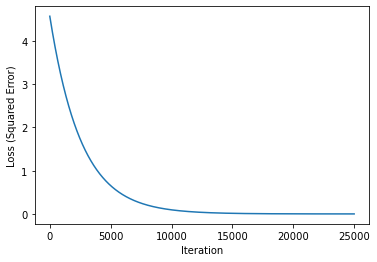

In [35]:
## Plot loss over iteration history
y = jnp.array(l)
x = jnp.arange(len(l))
df = pd.DataFrame({'y':y, 'x':x})

## Seaborn lineplot
ax = sns.lineplot(data=df, y='y', x='x')
ax.set(xlabel='Iteration', ylabel='Loss (Squared Error)')
plt.show()

In [36]:
##########################################################
##
## Same idea, linear regression - but use Gaussian loss instead of least squares loss
##
##########################################################

In [37]:
## Data Generator
def datagen(N, num_coef, beta_true, sigma):
    ## Dimensions of the problem
    nrow = N
    ncol = num_coef-1
    beta = jnp.array(beta_true).reshape(ncol+1,1)
    ## Create dataset/design-matrix
    X = random.normal(key, shape=(nrow*ncol,)).reshape(nrow,ncol)
    ones = jnp.repeat(1.0, nrow).reshape(nrow,1)
    X = jnp.hstack((ones, X))
    ## Construct linear predictor (y-true)
    mu = jnp.matmul(X, beta)
    ## Simulate ys 
    y = sigma*random.normal(key, shape=(N,1)) + mu
    ## Return design matrix and response vector to use
    return X, y

## Parameters for problem
N = 1000
num_coef = 4
beta_true = [0.0,0.0,-1.0,1.0]
sigma_true = 2.0

## Generation of randpm data
X, y = datagen(N=N, num_coef=num_coef, beta_true=beta_true, sigma=sigma_true)

## Check dimensions of returned objects
[X.shape, y.shape]

[(1000, 4), (1000, 1)]

In [38]:
## Linear predictor
def linreg_pred(beta, X):
    return X.dot(beta).reshape(X.shape[0],1)

# linreg_pred(jnp.array(beta_true), X)
# linreg_pred(jnp.array(beta_true), X) - y

In [39]:
## normall neg log like
def normal_nll(theta):
    ## Unpack parameters
    beta = theta[:-1]
    sigma = jnp.exp(theta[-1])
    ## Get predictions
    y_hat = linreg_pred(beta, X)
    ## Return sum of neg log lik contributions
    nll = -jnp.sum(jax.scipy.stats.norm.logpdf(x=y, loc=y_hat, scale=sigma))
    return nll

In [40]:
## Test the gradient function...
grad_nll = grad(normal_nll)

#theta0 = jnp.array([1.0,1.0,0.0,0.0,1.0])
#grad_nll(theta0)

In [41]:
## Create dataset
N = 1000
num_coef = 4
beta_true = [1.0, 0.2, -0.25, 0.0]
sigma_true
X, y = datagen(N=N, num_coef=num_coef, beta_true=beta_true, sigma=sigma_true)

## Initialization beta
theta = jnp.array([-1.0,1.0,0.0,0.0,1.0])

## Gradient descent step size parameter
step_size = 1e-3

## Calculate loss at current iteration of beta
grad_nll = jit(grad(normal_nll))

l = []

## Training loop
for i in jnp.arange(25000):
    ## Print current value of beta and loss
    current_theta = theta
    current_loss = normal_nll(theta)
    l.append(current_loss)
    print("Iteration=",i, "\tLoss=",current_loss, "\tTheta=",theta)
    ## Updated loss using gradient descent step
    theta = theta - step_size*grad_nll(theta)

Iteration= 0 	Loss= 2502.4434 	Theta= [-1.  1.  0.  0.  1.]
Iteration= 1 	Loss= 2449.0952 	Theta= [-0.7337538   0.908128   -0.04470883  0.02092145  1.1670089 ]
Iteration= 2 	Loss= 2388.097 	Theta= [-0.5685968   0.85030985 -0.07267053  0.03283805  0.89330494]
Iteration= 3 	Loss= 2336.7498 	Theta= [-0.3103986   0.75903213 -0.11662321  0.05033218  1.045011  ]
Iteration= 4 	Loss= 2283.6323 	Theta= [-0.1512957   0.7017627  -0.14397795  0.05980337  0.7906111 ]
Iteration= 5 	Loss= 2242.4817 	Theta= [ 0.08104694  0.6170824  -0.18419367  0.07229715  0.9387758 ]
Iteration= 6 	Loss= 2204.7222 	Theta= [ 0.21875325  0.5657571  -0.2083142   0.07825333  0.7083102 ]
Iteration= 7 	Loss= 2179.6416 	Theta= [ 0.40417793  0.49558073 -0.24104945  0.08491811  0.86325777]
Iteration= 8 	Loss= 2158.6357 	Theta= [ 0.5076959   0.4553524  -0.25957024  0.08730461  0.65814793]
Iteration= 9 	Loss= 2147.507 	Theta= [ 0.6363939   0.40445784 -0.28279102  0.08915593  0.8212462 ]
Iteration= 10 	Loss= 2137.584 	Theta= [ 0.

Iteration= 94 	Loss= 2120.5884 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6605608 ]
Iteration= 95 	Loss= 2120.7583 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.74273854]
Iteration= 96 	Loss= 2120.5605 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6609017 ]
Iteration= 97 	Loss= 2120.7266 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.74234164]
Iteration= 98 	Loss= 2120.5327 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6612339 ]
Iteration= 99 	Loss= 2120.6946 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7419555 ]
Iteration= 100 	Loss= 2120.5076 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.66155756]
Iteration= 101 	Loss= 2120.6648 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.74158   ]
Iteration= 102 	Loss= 2120.482 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.661873  ]
Iteration= 103 	Loss= 2120.636 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  

Iteration= 179 	Loss= 2119.9814 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.73191905]
Iteration= 180 	Loss= 2119.898 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.67016673]
Iteration= 181 	Loss= 2119.9712 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7317522 ]
Iteration= 182 	Loss= 2119.889 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.670313  ]
Iteration= 183 	Loss= 2119.9612 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.73158777]
Iteration= 184 	Loss= 2119.88 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6704573 ]
Iteration= 185 	Loss= 2119.9512 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7314259 ]
Iteration= 186 	Loss= 2119.8713 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.67059934]
Iteration= 187 	Loss= 2119.942 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7312666 ]
Iteration= 188 	Loss= 2119.8633 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.0748607

Iteration= 266 	Loss= 2119.6248 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.675     ]
Iteration= 267 	Loss= 2119.668 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.72637284]
Iteration= 268 	Loss= 2119.6204 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6750858 ]
Iteration= 269 	Loss= 2119.663 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7262782 ]
Iteration= 270 	Loss= 2119.6165 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6751708 ]
Iteration= 271 	Loss= 2119.6582 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.72618467]
Iteration= 272 	Loss= 2119.6118 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.67525476]
Iteration= 273 	Loss= 2119.6536 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7260921 ]
Iteration= 274 	Loss= 2119.6077 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.67533803]
Iteration= 275 	Loss= 2119.6492 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.0748

Iteration= 351 	Loss= 2119.5103 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7230988 ]
Iteration= 352 	Loss= 2119.4785 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.67804456]
Iteration= 353 	Loss= 2119.507 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.723035  ]
Iteration= 354 	Loss= 2119.4758 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.67810255]
Iteration= 355 	Loss= 2119.5046 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7229718 ]
Iteration= 356 	Loss= 2119.473 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.67816013]
Iteration= 357 	Loss= 2119.5017 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7229091 ]
Iteration= 358 	Loss= 2119.4707 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.67821723]
Iteration= 359 	Loss= 2119.499 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7228469 ]
Iteration= 360 	Loss= 2119.468 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.074860

Iteration= 472 	Loss= 2119.3596 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6808768 ]
Iteration= 473 	Loss= 2119.3784 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7199645 ]
Iteration= 474 	Loss= 2119.358 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6809153 ]
Iteration= 475 	Loss= 2119.3772 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.719923  ]
Iteration= 476 	Loss= 2119.3567 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68095344]
Iteration= 477 	Loss= 2119.3752 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71988195]
Iteration= 478 	Loss= 2119.355 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68099153]
Iteration= 479 	Loss= 2119.374 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.719841  ]
Iteration= 480 	Loss= 2119.354 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68102926]
Iteration= 481 	Loss= 2119.372 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.0748607

Iteration= 554 	Loss= 2119.3064 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68228054]
Iteration= 555 	Loss= 2119.3218 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7184552 ]
Iteration= 556 	Loss= 2119.3054 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68231094]
Iteration= 557 	Loss= 2119.3206 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.71842265]
Iteration= 558 	Loss= 2119.3042 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6823413 ]
Iteration= 559 	Loss= 2119.3193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.71839017]
Iteration= 560 	Loss= 2119.3035 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6823713 ]
Iteration= 561 	Loss= 2119.3184 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7183581 ]
Iteration= 562 	Loss= 2119.302 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6824011 ]
Iteration= 563 	Loss= 2119.317 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.0748

Iteration= 636 	Loss= 2119.2668 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6834121 ]
Iteration= 637 	Loss= 2119.279 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71724427]
Iteration= 638 	Loss= 2119.2659 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6834371 ]
Iteration= 639 	Loss= 2119.2786 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7172177 ]
Iteration= 640 	Loss= 2119.2654 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6834619 ]
Iteration= 641 	Loss= 2119.2776 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.71719134]
Iteration= 642 	Loss= 2119.2646 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6834865 ]
Iteration= 643 	Loss= 2119.2769 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7171652 ]
Iteration= 644 	Loss= 2119.2637 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.683511  ]
Iteration= 645 	Loss= 2119.2761 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.074

Iteration= 718 	Loss= 2119.2358 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6843506 ]
Iteration= 719 	Loss= 2119.2463 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7162442 ]
Iteration= 720 	Loss= 2119.2354 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68437165]
Iteration= 721 	Loss= 2119.2458 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71622205]
Iteration= 722 	Loss= 2119.2346 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6843924 ]
Iteration= 723 	Loss= 2119.245 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7161999 ]
Iteration= 724 	Loss= 2119.234 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68441296]
Iteration= 725 	Loss= 2119.2444 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7161782 ]
Iteration= 726 	Loss= 2119.2334 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6844335 ]
Iteration= 727 	Loss= 2119.2441 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.0748

Iteration= 800 	Loss= 2119.2117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6851479 ]
Iteration= 801 	Loss= 2119.2205 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71539766]
Iteration= 802 	Loss= 2119.211 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6851657 ]
Iteration= 803 	Loss= 2119.2197 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71537864]
Iteration= 804 	Loss= 2119.2104 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6851835 ]
Iteration= 805 	Loss= 2119.219 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7153599 ]
Iteration= 806 	Loss= 2119.21 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68520105]
Iteration= 807 	Loss= 2119.2188 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.715341  ]
Iteration= 808 	Loss= 2119.2092 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.685219  ]
Iteration= 809 	Loss= 2119.2178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.074860

Iteration= 882 	Loss= 2119.1907 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.685832  ]
Iteration= 883 	Loss= 2119.199 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7146729 ]
Iteration= 884 	Loss= 2119.1902 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6858476 ]
Iteration= 885 	Loss= 2119.1982 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7146565 ]
Iteration= 886 	Loss= 2119.1897 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6858628 ]
Iteration= 887 	Loss= 2119.198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7146405 ]
Iteration= 888 	Loss= 2119.1897 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68587804]
Iteration= 889 	Loss= 2119.1978 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71462435]
Iteration= 890 	Loss= 2119.1895 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6858934 ]
Iteration= 891 	Loss= 2119.197 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486

Iteration= 963 	Loss= 2119.1814 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7140564 ]
Iteration= 964 	Loss= 2119.174 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68642926]
Iteration= 965 	Loss= 2119.181 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71404195]
Iteration= 966 	Loss= 2119.1736 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.686443  ]
Iteration= 967 	Loss= 2119.181 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7140275 ]
Iteration= 968 	Loss= 2119.1736 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6864566 ]
Iteration= 969 	Loss= 2119.1804 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71401316]
Iteration= 970 	Loss= 2119.173 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68647003]
Iteration= 971 	Loss= 2119.18 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71399885]
Iteration= 972 	Loss= 2119.1726 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074

Iteration= 1044 	Loss= 2119.1602 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6869451 ]
Iteration= 1045 	Loss= 2119.1665 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7134983 ]
Iteration= 1046 	Loss= 2119.16 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6869573 ]
Iteration= 1047 	Loss= 2119.166 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7134854 ]
Iteration= 1048 	Loss= 2119.1597 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68696934]
Iteration= 1049 	Loss= 2119.166 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7134725 ]
Iteration= 1050 	Loss= 2119.159 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6869816 ]
Iteration= 1051 	Loss= 2119.1655 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71345973]
Iteration= 1052 	Loss= 2119.1587 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6869938 ]
Iteration= 1053 	Loss= 2119.165 	Theta= [ 0.9968878   0.24634323 -0.35058346  

Iteration= 1162 	Loss= 2119.143 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68760806]
Iteration= 1163 	Loss= 2119.1484 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.712801  ]
Iteration= 1164 	Loss= 2119.1426 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6876184 ]
Iteration= 1165 	Loss= 2119.1482 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71278995]
Iteration= 1166 	Loss= 2119.1423 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68762887]
Iteration= 1167 	Loss= 2119.148 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7127792 ]
Iteration= 1168 	Loss= 2119.1423 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68763894]
Iteration= 1169 	Loss= 2119.1472 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7127683 ]
Iteration= 1170 	Loss= 2119.1418 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68764925]
Iteration= 1171 	Loss= 2119.1467 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 1279 	Loss= 2119.1338 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71221185]
Iteration= 1280 	Loss= 2119.1294 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6881785 ]
Iteration= 1281 	Loss= 2119.1338 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71220255]
Iteration= 1282 	Loss= 2119.1294 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6881873 ]
Iteration= 1283 	Loss= 2119.133 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71219313]
Iteration= 1284 	Loss= 2119.1287 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68819636]
Iteration= 1285 	Loss= 2119.1328 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7121837 ]
Iteration= 1286 	Loss= 2119.128 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6882053 ]
Iteration= 1287 	Loss= 2119.1326 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7121743 ]
Iteration= 1288 	Loss= 2119.128 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 1397 	Loss= 2119.1216 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71168804]
Iteration= 1398 	Loss= 2119.1177 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6886776 ]
Iteration= 1399 	Loss= 2119.1213 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7116798 ]
Iteration= 1400 	Loss= 2119.1172 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68868554]
Iteration= 1401 	Loss= 2119.121 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7116716 ]
Iteration= 1402 	Loss= 2119.1172 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6886934 ]
Iteration= 1403 	Loss= 2119.1208 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7116632 ]
Iteration= 1404 	Loss= 2119.1165 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6887014 ]
Iteration= 1405 	Loss= 2119.1208 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7116549 ]
Iteration= 1406 	Loss= 2119.1165 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 1515 	Loss= 2119.1113 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71122646]
Iteration= 1516 	Loss= 2119.108 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6891186 ]
Iteration= 1517 	Loss= 2119.1108 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7112188 ]
Iteration= 1518 	Loss= 2119.1074 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6891259 ]
Iteration= 1519 	Loss= 2119.1104 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71121114]
Iteration= 1520 	Loss= 2119.1074 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6891331 ]
Iteration= 1521 	Loss= 2119.11 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7112037 ]
Iteration= 1522 	Loss= 2119.1072 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68914026]
Iteration= 1523 	Loss= 2119.11 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71119624]
Iteration= 1524 	Loss= 2119.107 	Theta= [ 0.9968878   0.24634323 -0.35058346  

Iteration= 1595 	Loss= 2119.1042 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7109416 ]
Iteration= 1596 	Loss= 2119.101 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6893909 ]
Iteration= 1597 	Loss= 2119.1042 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71093476]
Iteration= 1598 	Loss= 2119.101 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68939745]
Iteration= 1599 	Loss= 2119.1042 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71092784]
Iteration= 1600 	Loss= 2119.1013 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68940413]
Iteration= 1601 	Loss= 2119.1042 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7109211 ]
Iteration= 1602 	Loss= 2119.101 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6894107 ]
Iteration= 1603 	Loss= 2119.1035 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7109142 ]
Iteration= 1604 	Loss= 2119.101 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 1676 	Loss= 2119.0962 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6896418 ]
Iteration= 1677 	Loss= 2119.0994 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7106732 ]
Iteration= 1678 	Loss= 2119.0962 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.68964785]
Iteration= 1679 	Loss= 2119.0989 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.71066695]
Iteration= 1680 	Loss= 2119.096 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.68965375]
Iteration= 1681 	Loss= 2119.0989 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7106608 ]
Iteration= 1682 	Loss= 2119.0957 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6896596 ]
Iteration= 1683 	Loss= 2119.0986 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7106547 ]
Iteration= 1684 	Loss= 2119.0957 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486073  0.6896657 ]
Iteration= 1685 	Loss= 2119.0981 	Theta= [ 0.9968878   0.24634321 -0.35058

Iteration= 1756 	Loss= 2119.0913 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6898754 ]
Iteration= 1757 	Loss= 2119.094 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7104296 ]
Iteration= 1758 	Loss= 2119.091 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.68988127]
Iteration= 1759 	Loss= 2119.0938 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.71042377]
Iteration= 1760 	Loss= 2119.091 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.68988705]
Iteration= 1761 	Loss= 2119.0938 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7104177 ]
Iteration= 1762 	Loss= 2119.0908 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.68989277]
Iteration= 1763 	Loss= 2119.0935 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71041167]
Iteration= 1764 	Loss= 2119.091 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6898986 ]
Iteration= 1765 	Loss= 2119.0935 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 1875 	Loss= 2119.0874 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7100988 ]
Iteration= 1876 	Loss= 2119.0845 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6901986 ]
Iteration= 1877 	Loss= 2119.0874 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71009356]
Iteration= 1878 	Loss= 2119.0845 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6902036 ]
Iteration= 1879 	Loss= 2119.0874 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.71008825]
Iteration= 1880 	Loss= 2119.0845 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69020885]
Iteration= 1881 	Loss= 2119.087 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7100828 ]
Iteration= 1882 	Loss= 2119.0842 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6902141 ]
Iteration= 1883 	Loss= 2119.087 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7100776 ]
Iteration= 1884 	Loss= 2119.0842 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 1993 	Loss= 2119.0818 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70979595]
Iteration= 1994 	Loss= 2119.0786 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6904897 ]
Iteration= 1995 	Loss= 2119.0815 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7097911 ]
Iteration= 1996 	Loss= 2119.0786 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69049424]
Iteration= 1997 	Loss= 2119.0813 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7097865 ]
Iteration= 1998 	Loss= 2119.0786 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6904988 ]
Iteration= 1999 	Loss= 2119.0813 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7097815 ]
Iteration= 2000 	Loss= 2119.0784 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69050336]
Iteration= 2001 	Loss= 2119.0813 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70977694]
Iteration= 2002 	Loss= 2119.0784 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 2073 	Loss= 2119.0776 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7096058 ]
Iteration= 2074 	Loss= 2119.0752 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69067264]
Iteration= 2075 	Loss= 2119.0776 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7096011 ]
Iteration= 2076 	Loss= 2119.0752 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6906771 ]
Iteration= 2077 	Loss= 2119.0774 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7095966 ]
Iteration= 2078 	Loss= 2119.0752 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6906815 ]
Iteration= 2079 	Loss= 2119.0771 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.709592  ]
Iteration= 2080 	Loss= 2119.0752 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6906858 ]
Iteration= 2081 	Loss= 2119.0774 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70958745]
Iteration= 2082 	Loss= 2119.0752 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 2153 	Loss= 2119.0742 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7094258 ]
Iteration= 2154 	Loss= 2119.0725 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69084585]
Iteration= 2155 	Loss= 2119.074 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7094212 ]
Iteration= 2156 	Loss= 2119.0723 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69085026]
Iteration= 2157 	Loss= 2119.074 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70941687]
Iteration= 2158 	Loss= 2119.0723 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6908545 ]
Iteration= 2159 	Loss= 2119.074 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7094125 ]
Iteration= 2160 	Loss= 2119.0723 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69085866]
Iteration= 2161 	Loss= 2119.074 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7094082 ]
Iteration= 2162 	Loss= 2119.072 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 2259 	Loss= 2119.0698 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70920104]
Iteration= 2260 	Loss= 2119.0684 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69106257]
Iteration= 2261 	Loss= 2119.07 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7091967 ]
Iteration= 2262 	Loss= 2119.0684 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69106644]
Iteration= 2263 	Loss= 2119.07 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70919263]
Iteration= 2264 	Loss= 2119.0686 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6910704 ]
Iteration= 2265 	Loss= 2119.0698 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70918864]
Iteration= 2266 	Loss= 2119.068 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69107413]
Iteration= 2267 	Loss= 2119.0698 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7091847 ]
Iteration= 2268 	Loss= 2119.068 	Theta= [ 0.9968878   0.24634323 -0.35058346  

Iteration= 2339 	Loss= 2119.0671 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7090425 ]
Iteration= 2340 	Loss= 2119.0654 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6912152 ]
Iteration= 2341 	Loss= 2119.0671 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7090386 ]
Iteration= 2342 	Loss= 2119.0654 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69121885]
Iteration= 2343 	Loss= 2119.0671 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7090349 ]
Iteration= 2344 	Loss= 2119.0652 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69122255]
Iteration= 2345 	Loss= 2119.067 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7090309 ]
Iteration= 2346 	Loss= 2119.0652 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6912264 ]
Iteration= 2347 	Loss= 2119.067 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70902693]
Iteration= 2348 	Loss= 2119.065 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 2419 	Loss= 2119.0647 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70889115]
Iteration= 2420 	Loss= 2119.0627 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69136107]
Iteration= 2421 	Loss= 2119.0647 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70888776]
Iteration= 2422 	Loss= 2119.0627 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6913645 ]
Iteration= 2423 	Loss= 2119.0647 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70888406]
Iteration= 2424 	Loss= 2119.0627 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6913681 ]
Iteration= 2425 	Loss= 2119.0647 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70888036]
Iteration= 2426 	Loss= 2119.0627 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69137156]
Iteration= 2427 	Loss= 2119.0647 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70887685]
Iteration= 2428 	Loss= 2119.0627 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 2536 	Loss= 2119.0593 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6915592 ]
Iteration= 2537 	Loss= 2119.061 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7086829 ]
Iteration= 2538 	Loss= 2119.059 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6915623 ]
Iteration= 2539 	Loss= 2119.061 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7086793 ]
Iteration= 2540 	Loss= 2119.0593 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69156563]
Iteration= 2541 	Loss= 2119.0608 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70867586]
Iteration= 2542 	Loss= 2119.059 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.691569  ]
Iteration= 2543 	Loss= 2119.0608 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7086724 ]
Iteration= 2544 	Loss= 2119.0596 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69157237]
Iteration= 2545 	Loss= 2119.0608 	Theta= [ 0.9968878   0.24634321 -0.35058346

Iteration= 2655 	Loss= 2119.0576 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7084887 ]
Iteration= 2656 	Loss= 2119.0564 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69174975]
Iteration= 2657 	Loss= 2119.0576 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70848566]
Iteration= 2658 	Loss= 2119.0566 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69175273]
Iteration= 2659 	Loss= 2119.0579 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70848256]
Iteration= 2660 	Loss= 2119.0562 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69175583]
Iteration= 2661 	Loss= 2119.0579 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7084792 ]
Iteration= 2662 	Loss= 2119.0564 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6917591 ]
Iteration= 2663 	Loss= 2119.0579 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7084759 ]
Iteration= 2664 	Loss= 2119.0562 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 2735 	Loss= 2119.056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70836484]
Iteration= 2736 	Loss= 2119.0542 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6918695 ]
Iteration= 2737 	Loss= 2119.0557 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.708362  ]
Iteration= 2738 	Loss= 2119.0542 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6918723 ]
Iteration= 2739 	Loss= 2119.056 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.708359  ]
Iteration= 2740 	Loss= 2119.0542 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6918754 ]
Iteration= 2741 	Loss= 2119.0557 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7083558 ]
Iteration= 2742 	Loss= 2119.0542 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6918784 ]
Iteration= 2743 	Loss= 2119.0557 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7083526 ]
Iteration= 2744 	Loss= 2119.0542 	Theta= [ 0.9968878   0.24634321 -0.350583

Iteration= 2816 	Loss= 2119.052 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6919857 ]
Iteration= 2817 	Loss= 2119.054 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7082419 ]
Iteration= 2818 	Loss= 2119.052 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6919884 ]
Iteration= 2819 	Loss= 2119.054 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7082389 ]
Iteration= 2820 	Loss= 2119.052 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6919913 ]
Iteration= 2821 	Loss= 2119.054 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.708236  ]
Iteration= 2822 	Loss= 2119.052 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6919942 ]
Iteration= 2823 	Loss= 2119.0537 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70823306]
Iteration= 2824 	Loss= 2119.052 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6919972 ]
Iteration= 2825 	Loss= 2119.0537 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.

Iteration= 2896 	Loss= 2119.0505 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6920957 ]
Iteration= 2897 	Loss= 2119.052 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7081283 ]
Iteration= 2898 	Loss= 2119.0505 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69209844]
Iteration= 2899 	Loss= 2119.0522 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7081255 ]
Iteration= 2900 	Loss= 2119.0505 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69210124]
Iteration= 2901 	Loss= 2119.0522 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7081225 ]
Iteration= 2902 	Loss= 2119.0505 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.692104  ]
Iteration= 2903 	Loss= 2119.0522 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7081198 ]
Iteration= 2904 	Loss= 2119.0505 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6921066 ]
Iteration= 2905 	Loss= 2119.052 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 2976 	Loss= 2119.0486 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6922011 ]
Iteration= 2977 	Loss= 2119.0505 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7080196 ]
Iteration= 2978 	Loss= 2119.0486 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6922037 ]
Iteration= 2979 	Loss= 2119.0503 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7080171 ]
Iteration= 2980 	Loss= 2119.0483 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6922061 ]
Iteration= 2981 	Loss= 2119.0503 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7080144 ]
Iteration= 2982 	Loss= 2119.0486 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6922085 ]
Iteration= 2983 	Loss= 2119.05 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70801187]
Iteration= 2984 	Loss= 2119.0486 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69221115]
Iteration= 2985 	Loss= 2119.05 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 3057 	Loss= 2119.0483 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70791495]
Iteration= 3058 	Loss= 2119.0479 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.692305  ]
Iteration= 3059 	Loss= 2119.0483 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70791245]
Iteration= 3060 	Loss= 2119.0476 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6923075 ]
Iteration= 3061 	Loss= 2119.0479 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70790976]
Iteration= 3062 	Loss= 2119.0474 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6923101 ]
Iteration= 3063 	Loss= 2119.048 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7079072 ]
Iteration= 3064 	Loss= 2119.0474 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6923124 ]
Iteration= 3065 	Loss= 2119.0479 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7079047 ]
Iteration= 3066 	Loss= 2119.0474 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 3138 	Loss= 2119.0461 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6924023 ]
Iteration= 3139 	Loss= 2119.047 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.707812  ]
Iteration= 3140 	Loss= 2119.0461 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6924048 ]
Iteration= 3141 	Loss= 2119.0469 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70780957]
Iteration= 3142 	Loss= 2119.0457 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.692407  ]
Iteration= 3143 	Loss= 2119.047 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7078073 ]
Iteration= 3144 	Loss= 2119.0461 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69240934]
Iteration= 3145 	Loss= 2119.0469 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7078048 ]
Iteration= 3146 	Loss= 2119.0461 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6924119 ]
Iteration= 3147 	Loss= 2119.0469 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 3218 	Loss= 2119.0444 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6924963 ]
Iteration= 3219 	Loss= 2119.0454 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.707715  ]
Iteration= 3220 	Loss= 2119.0442 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6924988 ]
Iteration= 3221 	Loss= 2119.0454 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70771253]
Iteration= 3222 	Loss= 2119.044 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6925011 ]
Iteration= 3223 	Loss= 2119.0452 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70770997]
Iteration= 3224 	Loss= 2119.044 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6925037 ]
Iteration= 3225 	Loss= 2119.0452 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7077076 ]
Iteration= 3226 	Loss= 2119.044 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.692506  ]
Iteration= 3227 	Loss= 2119.0452 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 3300 	Loss= 2119.0427 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69259   ]
Iteration= 3301 	Loss= 2119.0442 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70761853]
Iteration= 3302 	Loss= 2119.043 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6925924 ]
Iteration= 3303 	Loss= 2119.0442 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7076163 ]
Iteration= 3304 	Loss= 2119.043 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6925946 ]
Iteration= 3305 	Loss= 2119.044 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7076138 ]
Iteration= 3306 	Loss= 2119.0427 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6925968 ]
Iteration= 3307 	Loss= 2119.044 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7076114 ]
Iteration= 3308 	Loss= 2119.0427 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69259924]
Iteration= 3309 	Loss= 2119.044 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 3382 	Loss= 2119.0413 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6926795 ]
Iteration= 3383 	Loss= 2119.043 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70752645]
Iteration= 3384 	Loss= 2119.0413 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69268167]
Iteration= 3385 	Loss= 2119.0427 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70752424]
Iteration= 3386 	Loss= 2119.0413 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69268364]
Iteration= 3387 	Loss= 2119.0425 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7075221 ]
Iteration= 3388 	Loss= 2119.0413 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69268584]
Iteration= 3389 	Loss= 2119.0425 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7075199 ]
Iteration= 3390 	Loss= 2119.0413 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6926881 ]
Iteration= 3391 	Loss= 2119.0422 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 3498 	Loss= 2119.0398 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69279927]
Iteration= 3499 	Loss= 2119.0408 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7074031 ]
Iteration= 3500 	Loss= 2119.0398 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6928014 ]
Iteration= 3501 	Loss= 2119.0405 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70740104]
Iteration= 3502 	Loss= 2119.0398 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6928032 ]
Iteration= 3503 	Loss= 2119.0405 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7073992 ]
Iteration= 3504 	Loss= 2119.0396 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.692805  ]
Iteration= 3505 	Loss= 2119.0405 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7073973 ]
Iteration= 3506 	Loss= 2119.0396 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69280696]
Iteration= 3507 	Loss= 2119.0405 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 3578 	Loss= 2119.0388 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6928792 ]
Iteration= 3579 	Loss= 2119.0398 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7073208 ]
Iteration= 3580 	Loss= 2119.0386 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69288146]
Iteration= 3581 	Loss= 2119.0398 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7073186 ]
Iteration= 3582 	Loss= 2119.0386 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6928834 ]
Iteration= 3583 	Loss= 2119.0398 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7073167 ]
Iteration= 3584 	Loss= 2119.0386 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69288534]
Iteration= 3585 	Loss= 2119.0398 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7073147 ]
Iteration= 3586 	Loss= 2119.0386 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69288725]
Iteration= 3587 	Loss= 2119.0398 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 3658 	Loss= 2119.0374 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.692958  ]
Iteration= 3659 	Loss= 2119.038 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70723975]
Iteration= 3660 	Loss= 2119.0374 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69296026]
Iteration= 3661 	Loss= 2119.038 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7072376 ]
Iteration= 3662 	Loss= 2119.0376 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69296217]
Iteration= 3663 	Loss= 2119.038 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7072356 ]
Iteration= 3664 	Loss= 2119.0376 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6929642 ]
Iteration= 3665 	Loss= 2119.038 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70723337]
Iteration= 3666 	Loss= 2119.0376 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6929662 ]
Iteration= 3667 	Loss= 2119.0383 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 3740 	Loss= 2119.0366 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6930359 ]
Iteration= 3741 	Loss= 2119.0374 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7071599 ]
Iteration= 3742 	Loss= 2119.0366 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6930378 ]
Iteration= 3743 	Loss= 2119.037 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70715797]
Iteration= 3744 	Loss= 2119.0366 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69303936]
Iteration= 3745 	Loss= 2119.037 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70715624]
Iteration= 3746 	Loss= 2119.0366 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6930411 ]
Iteration= 3747 	Loss= 2119.037 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7071546 ]
Iteration= 3748 	Loss= 2119.0366 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69304276]
Iteration= 3749 	Loss= 2119.037 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 3822 	Loss= 2119.0352 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6931112 ]
Iteration= 3823 	Loss= 2119.0366 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7070824 ]
Iteration= 3824 	Loss= 2119.0354 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6931129 ]
Iteration= 3825 	Loss= 2119.0364 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7070806 ]
Iteration= 3826 	Loss= 2119.0352 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69311464]
Iteration= 3827 	Loss= 2119.0366 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7070787 ]
Iteration= 3828 	Loss= 2119.035 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69311666]
Iteration= 3829 	Loss= 2119.0366 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70707667]
Iteration= 3830 	Loss= 2119.0352 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6931185 ]
Iteration= 3831 	Loss= 2119.0364 	Theta= [ 0.9968878   0.24634321 -0.35058

Iteration= 3902 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6931823 ]
Iteration= 3903 	Loss= 2119.0352 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7070093 ]
Iteration= 3904 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69318396]
Iteration= 3905 	Loss= 2119.035 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7070077 ]
Iteration= 3906 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6931855 ]
Iteration= 3907 	Loss= 2119.035 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.707006  ]
Iteration= 3908 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6931872 ]
Iteration= 3909 	Loss= 2119.0347 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70700413]
Iteration= 3910 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.693189  ]
Iteration= 3911 	Loss= 2119.0347 	Theta= [ 0.9968878   0.24634321 -0.35058346  0

Iteration= 3982 	Loss= 2119.033 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6932514 ]
Iteration= 3983 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7069382 ]
Iteration= 3984 	Loss= 2119.033 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6932532 ]
Iteration= 3985 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70693624]
Iteration= 3986 	Loss= 2119.033 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69325507]
Iteration= 3987 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7069345 ]
Iteration= 3988 	Loss= 2119.0332 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6932568 ]
Iteration= 3989 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7069328 ]
Iteration= 3990 	Loss= 2119.033 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6932586 ]
Iteration= 3991 	Loss= 2119.034 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.0

Iteration= 4062 	Loss= 2119.0325 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69331944]
Iteration= 4063 	Loss= 2119.033 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7068684 ]
Iteration= 4064 	Loss= 2119.0325 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6933211 ]
Iteration= 4065 	Loss= 2119.033 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7068669 ]
Iteration= 4066 	Loss= 2119.0325 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6933226 ]
Iteration= 4067 	Loss= 2119.033 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70686513]
Iteration= 4068 	Loss= 2119.0325 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6933242 ]
Iteration= 4069 	Loss= 2119.0332 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7068637 ]
Iteration= 4070 	Loss= 2119.0325 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69332546]
Iteration= 4071 	Loss= 2119.033 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 4142 	Loss= 2119.0317 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69338256]
Iteration= 4143 	Loss= 2119.0325 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70680356]
Iteration= 4144 	Loss= 2119.0317 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6933841 ]
Iteration= 4145 	Loss= 2119.0325 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7068019 ]
Iteration= 4146 	Loss= 2119.0317 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6933857 ]
Iteration= 4147 	Loss= 2119.0325 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7068004 ]
Iteration= 4148 	Loss= 2119.0317 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6933872 ]
Iteration= 4149 	Loss= 2119.0322 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7067989 ]
Iteration= 4150 	Loss= 2119.0317 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6933886 ]
Iteration= 4151 	Loss= 2119.0322 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 4223 	Loss= 2119.0312 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70673907]
Iteration= 4224 	Loss= 2119.0308 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.693447  ]
Iteration= 4225 	Loss= 2119.0312 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70673746]
Iteration= 4226 	Loss= 2119.0305 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6934484 ]
Iteration= 4227 	Loss= 2119.0312 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.706736  ]
Iteration= 4228 	Loss= 2119.0308 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6934498 ]
Iteration= 4229 	Loss= 2119.0312 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70673466]
Iteration= 4230 	Loss= 2119.0305 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6934513 ]
Iteration= 4231 	Loss= 2119.0312 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.706733  ]
Iteration= 4232 	Loss= 2119.0308 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 4305 	Loss= 2119.0305 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7066746 ]
Iteration= 4306 	Loss= 2119.0298 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69350976]
Iteration= 4307 	Loss= 2119.031 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70667297]
Iteration= 4308 	Loss= 2119.0298 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69351125]
Iteration= 4309 	Loss= 2119.0305 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70667154]
Iteration= 4310 	Loss= 2119.0298 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6935127 ]
Iteration= 4311 	Loss= 2119.0308 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7066699 ]
Iteration= 4312 	Loss= 2119.0298 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6935143 ]
Iteration= 4313 	Loss= 2119.0305 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70666844]
Iteration= 4314 	Loss= 2119.0298 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 4385 	Loss= 2119.03 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.706614  ]
Iteration= 4386 	Loss= 2119.029 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6935687 ]
Iteration= 4387 	Loss= 2119.03 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7066125 ]
Iteration= 4388 	Loss= 2119.029 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69357014]
Iteration= 4389 	Loss= 2119.03 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70661104]
Iteration= 4390 	Loss= 2119.029 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486075  0.6935716 ]
Iteration= 4391 	Loss= 2119.03 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486075  0.7066095 ]
Iteration= 4392 	Loss= 2119.029 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6935731 ]
Iteration= 4393 	Loss= 2119.0303 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70660794]
Iteration= 4394 	Loss= 2119.0293 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.0748

Iteration= 4465 	Loss= 2119.0295 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70655626]
Iteration= 4466 	Loss= 2119.0286 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69362503]
Iteration= 4467 	Loss= 2119.0295 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7065546 ]
Iteration= 4468 	Loss= 2119.0286 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6936265 ]
Iteration= 4469 	Loss= 2119.0295 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7065533 ]
Iteration= 4470 	Loss= 2119.0286 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6936277 ]
Iteration= 4471 	Loss= 2119.0293 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7065519 ]
Iteration= 4472 	Loss= 2119.0286 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69362926]
Iteration= 4473 	Loss= 2119.029 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7065504 ]
Iteration= 4474 	Loss= 2119.0286 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 4546 	Loss= 2119.0278 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69368064]
Iteration= 4547 	Loss= 2119.028 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70649767]
Iteration= 4548 	Loss= 2119.0278 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69368184]
Iteration= 4549 	Loss= 2119.0283 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70649654]
Iteration= 4550 	Loss= 2119.0278 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69368315]
Iteration= 4551 	Loss= 2119.028 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.706495  ]
Iteration= 4552 	Loss= 2119.0278 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69368464]
Iteration= 4553 	Loss= 2119.0283 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70649344]
Iteration= 4554 	Loss= 2119.0276 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69368607]
Iteration= 4555 	Loss= 2119.028 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 4628 	Loss= 2119.0269 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6937356 ]
Iteration= 4629 	Loss= 2119.0276 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70644134]
Iteration= 4630 	Loss= 2119.0269 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69373685]
Iteration= 4631 	Loss= 2119.0276 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70644003]
Iteration= 4632 	Loss= 2119.0269 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6937383 ]
Iteration= 4633 	Loss= 2119.0276 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7064387 ]
Iteration= 4634 	Loss= 2119.0269 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69373935]
Iteration= 4635 	Loss= 2119.0276 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70643747]
Iteration= 4636 	Loss= 2119.0266 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6937406 ]
Iteration= 4637 	Loss= 2119.0276 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 4710 	Loss= 2119.0264 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6937893 ]
Iteration= 4711 	Loss= 2119.027 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7063862 ]
Iteration= 4712 	Loss= 2119.0264 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6937906 ]
Iteration= 4713 	Loss= 2119.027 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7063849 ]
Iteration= 4714 	Loss= 2119.0264 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6937918 ]
Iteration= 4715 	Loss= 2119.027 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70638376]
Iteration= 4716 	Loss= 2119.0264 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6937931 ]
Iteration= 4717 	Loss= 2119.0269 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70638245]
Iteration= 4718 	Loss= 2119.0264 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6937943 ]
Iteration= 4719 	Loss= 2119.0269 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 4792 	Loss= 2119.0256 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69384104]
Iteration= 4793 	Loss= 2119.0266 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7063332 ]
Iteration= 4794 	Loss= 2119.0256 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69384223]
Iteration= 4795 	Loss= 2119.0266 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70633197]
Iteration= 4796 	Loss= 2119.0256 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69384354]
Iteration= 4797 	Loss= 2119.0266 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7063307 ]
Iteration= 4798 	Loss= 2119.0256 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6938449 ]
Iteration= 4799 	Loss= 2119.0266 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7063291 ]
Iteration= 4800 	Loss= 2119.0256 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6938462 ]
Iteration= 4801 	Loss= 2119.0264 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 4873 	Loss= 2119.0254 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7062814 ]
Iteration= 4874 	Loss= 2119.0254 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6938929 ]
Iteration= 4875 	Loss= 2119.0254 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70628   ]
Iteration= 4876 	Loss= 2119.0251 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69389415]
Iteration= 4877 	Loss= 2119.0256 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7062788 ]
Iteration= 4878 	Loss= 2119.0251 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69389534]
Iteration= 4879 	Loss= 2119.0254 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7062776 ]
Iteration= 4880 	Loss= 2119.0254 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69389653]
Iteration= 4881 	Loss= 2119.0254 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7062762 ]
Iteration= 4882 	Loss= 2119.0251 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 4953 	Loss= 2119.025 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7062308 ]
Iteration= 4954 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6939421 ]
Iteration= 4955 	Loss= 2119.025 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7062297 ]
Iteration= 4956 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6939433 ]
Iteration= 4957 	Loss= 2119.025 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70622814]
Iteration= 4958 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69394475]
Iteration= 4959 	Loss= 2119.0251 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70622694]
Iteration= 4960 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6939459 ]
Iteration= 4961 	Loss= 2119.0251 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70622575]
Iteration= 4962 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 5033 	Loss= 2119.0244 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061808 ]
Iteration= 5034 	Loss= 2119.0237 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6939909 ]
Iteration= 5035 	Loss= 2119.0247 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061796 ]
Iteration= 5036 	Loss= 2119.0237 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6939921 ]
Iteration= 5037 	Loss= 2119.0244 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061784 ]
Iteration= 5038 	Loss= 2119.024 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69399333]
Iteration= 5039 	Loss= 2119.0244 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061771 ]
Iteration= 5040 	Loss= 2119.024 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6939944 ]
Iteration= 5041 	Loss= 2119.0244 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061761 ]
Iteration= 5042 	Loss= 2119.024 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 5113 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061314 ]
Iteration= 5114 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69403887]
Iteration= 5115 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061305 ]
Iteration= 5116 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6940401 ]
Iteration= 5117 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061292 ]
Iteration= 5118 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6940414 ]
Iteration= 5119 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061279 ]
Iteration= 5120 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6940427 ]
Iteration= 5121 	Loss= 2119.0242 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7061265 ]
Iteration= 5122 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 5193 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7060852 ]
Iteration= 5194 	Loss= 2119.0227 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6940842 ]
Iteration= 5195 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.706084  ]
Iteration= 5196 	Loss= 2119.0225 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6940853 ]
Iteration= 5197 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.706083  ]
Iteration= 5198 	Loss= 2119.0225 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6940865 ]
Iteration= 5199 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7060817 ]
Iteration= 5200 	Loss= 2119.0225 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6940876 ]
Iteration= 5201 	Loss= 2119.0232 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70608073]
Iteration= 5202 	Loss= 2119.0225 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 5273 	Loss= 2119.0227 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70604026]
Iteration= 5274 	Loss= 2119.0225 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6941279 ]
Iteration= 5275 	Loss= 2119.0227 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70603925]
Iteration= 5276 	Loss= 2119.0225 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69412917]
Iteration= 5277 	Loss= 2119.0227 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70603806]
Iteration= 5278 	Loss= 2119.0222 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6941302 ]
Iteration= 5279 	Loss= 2119.0227 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.706037  ]
Iteration= 5280 	Loss= 2119.0222 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69413126]
Iteration= 5281 	Loss= 2119.0227 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7060359 ]
Iteration= 5282 	Loss= 2119.0222 	Theta= [ 0.9968878   0.24634321 -0.3505

Iteration= 5354 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69417155]
Iteration= 5355 	Loss= 2119.0217 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7059946 ]
Iteration= 5356 	Loss= 2119.0217 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6941727 ]
Iteration= 5357 	Loss= 2119.0217 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70599353]
Iteration= 5358 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69417375]
Iteration= 5359 	Loss= 2119.0217 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70599234]
Iteration= 5360 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6941749 ]
Iteration= 5361 	Loss= 2119.0217 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7059912 ]
Iteration= 5362 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6941761 ]
Iteration= 5363 	Loss= 2119.0217 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 5434 	Loss= 2119.0212 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6942142 ]
Iteration= 5435 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7059509 ]
Iteration= 5436 	Loss= 2119.0212 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69421524]
Iteration= 5437 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70595   ]
Iteration= 5438 	Loss= 2119.0212 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69421613]
Iteration= 5439 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70594895]
Iteration= 5440 	Loss= 2119.0212 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69421715]
Iteration= 5441 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.705948  ]
Iteration= 5442 	Loss= 2119.0212 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6942181 ]
Iteration= 5443 	Loss= 2119.0215 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 5515 	Loss= 2119.021 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.705909  ]
Iteration= 5516 	Loss= 2119.0212 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6942562 ]
Iteration= 5517 	Loss= 2119.021 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70590824]
Iteration= 5518 	Loss= 2119.021 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6942569 ]
Iteration= 5519 	Loss= 2119.021 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7059073 ]
Iteration= 5520 	Loss= 2119.021 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69425786]
Iteration= 5521 	Loss= 2119.021 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70590633]
Iteration= 5522 	Loss= 2119.021 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69425887]
Iteration= 5523 	Loss= 2119.021 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7059054 ]
Iteration= 5524 	Loss= 2119.0208 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.

Iteration= 5596 	Loss= 2119.0205 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69429713]
Iteration= 5597 	Loss= 2119.0208 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7058662 ]
Iteration= 5598 	Loss= 2119.0205 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.694298  ]
Iteration= 5599 	Loss= 2119.0208 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70586497]
Iteration= 5600 	Loss= 2119.0203 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6942993 ]
Iteration= 5601 	Loss= 2119.0208 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70586383]
Iteration= 5602 	Loss= 2119.0205 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6943003 ]
Iteration= 5603 	Loss= 2119.0208 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7058629 ]
Iteration= 5604 	Loss= 2119.0205 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6943013 ]
Iteration= 5605 	Loss= 2119.0208 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 5676 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6943357 ]
Iteration= 5677 	Loss= 2119.0203 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70582664]
Iteration= 5678 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6943368 ]
Iteration= 5679 	Loss= 2119.0205 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7058257 ]
Iteration= 5680 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6943377 ]
Iteration= 5681 	Loss= 2119.0205 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70582455]
Iteration= 5682 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6943387 ]
Iteration= 5683 	Loss= 2119.0205 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70582384]
Iteration= 5684 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69433945]
Iteration= 5685 	Loss= 2119.0205 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 5756 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6943748 ]
Iteration= 5757 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7057866 ]
Iteration= 5758 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6943759 ]
Iteration= 5759 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70578545]
Iteration= 5760 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69437706]
Iteration= 5761 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70578426]
Iteration= 5762 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69437814]
Iteration= 5763 	Loss= 2119.02 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7057832 ]
Iteration= 5764 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69437915]
Iteration= 5765 	Loss= 2119.0198 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 5837 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7057471 ]
Iteration= 5838 	Loss= 2119.0188 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69441444]
Iteration= 5839 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7057462 ]
Iteration= 5840 	Loss= 2119.0188 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6944154 ]
Iteration= 5841 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7057452 ]
Iteration= 5842 	Loss= 2119.0188 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6944162 ]
Iteration= 5843 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7057443 ]
Iteration= 5844 	Loss= 2119.0186 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6944171 ]
Iteration= 5845 	Loss= 2119.0193 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70574343]
Iteration= 5846 	Loss= 2119.0186 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 5917 	Loss= 2119.019 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70570743]
Iteration= 5918 	Loss= 2119.018 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69445324]
Iteration= 5919 	Loss= 2119.019 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70570654]
Iteration= 5920 	Loss= 2119.018 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69445425]
Iteration= 5921 	Loss= 2119.019 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7057055 ]
Iteration= 5922 	Loss= 2119.018 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.694455  ]
Iteration= 5923 	Loss= 2119.019 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7057047 ]
Iteration= 5924 	Loss= 2119.018 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.694456  ]
Iteration= 5925 	Loss= 2119.019 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70570356]
Iteration= 5926 	Loss= 2119.018 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07

Iteration= 5999 	Loss= 2119.0183 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7056686 ]
Iteration= 6000 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6944912 ]
Iteration= 6001 	Loss= 2119.0186 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7056676 ]
Iteration= 6002 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6944921 ]
Iteration= 6003 	Loss= 2119.0186 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7056668 ]
Iteration= 6004 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.694493  ]
Iteration= 6005 	Loss= 2119.0186 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7056658 ]
Iteration= 6006 	Loss= 2119.018 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69449395]
Iteration= 6007 	Loss= 2119.0186 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7056649 ]
Iteration= 6008 	Loss= 2119.018 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 6079 	Loss= 2119.018 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70563036]
Iteration= 6080 	Loss= 2119.0176 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6945286 ]
Iteration= 6081 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70562965]
Iteration= 6082 	Loss= 2119.0176 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6945294 ]
Iteration= 6083 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70562863]
Iteration= 6084 	Loss= 2119.0176 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6945304 ]
Iteration= 6085 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7056275 ]
Iteration= 6086 	Loss= 2119.0176 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6945313 ]
Iteration= 6087 	Loss= 2119.0183 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70562655]
Iteration= 6088 	Loss= 2119.0176 	Theta= [ 0.9968878   0.24634321 -0.35058

Iteration= 6159 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70559436]
Iteration= 6160 	Loss= 2119.0173 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69456375]
Iteration= 6161 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7055937 ]
Iteration= 6162 	Loss= 2119.0173 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69456434]
Iteration= 6163 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.705593  ]
Iteration= 6164 	Loss= 2119.0173 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69456506]
Iteration= 6165 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7055923 ]
Iteration= 6166 	Loss= 2119.0173 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6945658 ]
Iteration= 6167 	Loss= 2119.0178 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7055914 ]
Iteration= 6168 	Loss= 2119.0173 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 6240 	Loss= 2119.0168 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69459856]
Iteration= 6241 	Loss= 2119.0173 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.705558  ]
Iteration= 6242 	Loss= 2119.0168 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69459933]
Iteration= 6243 	Loss= 2119.0173 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7055569 ]
Iteration= 6244 	Loss= 2119.0168 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69460034]
Iteration= 6245 	Loss= 2119.0173 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70555615]
Iteration= 6246 	Loss= 2119.0168 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6946012 ]
Iteration= 6247 	Loss= 2119.017 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70555544]
Iteration= 6248 	Loss= 2119.0166 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69460195]
Iteration= 6249 	Loss= 2119.017 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 6320 	Loss= 2119.016 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69463235]
Iteration= 6321 	Loss= 2119.0168 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70552343]
Iteration= 6322 	Loss= 2119.016 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486073  0.6946331 ]
Iteration= 6323 	Loss= 2119.0168 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486073  0.70552254]
Iteration= 6324 	Loss= 2119.016 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69463396]
Iteration= 6325 	Loss= 2119.0166 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7055217 ]
Iteration= 6326 	Loss= 2119.0164 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6946349 ]
Iteration= 6327 	Loss= 2119.0168 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70552075]
Iteration= 6328 	Loss= 2119.016 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69463587]
Iteration= 6329 	Loss= 2119.0166 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 6400 	Loss= 2119.0159 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69466573]
Iteration= 6401 	Loss= 2119.0164 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70548916]
Iteration= 6402 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6946667 ]
Iteration= 6403 	Loss= 2119.0164 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70548826]
Iteration= 6404 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69466746]
Iteration= 6405 	Loss= 2119.0164 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7054876 ]
Iteration= 6406 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6946681 ]
Iteration= 6407 	Loss= 2119.016 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70548683]
Iteration= 6408 	Loss= 2119.0159 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.694669  ]
Iteration= 6409 	Loss= 2119.0164 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 6480 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69469947]
Iteration= 6481 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70545506]
Iteration= 6482 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69469994]
Iteration= 6483 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70545435]
Iteration= 6484 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947007 ]
Iteration= 6485 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70545363]
Iteration= 6486 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947016 ]
Iteration= 6487 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7054528 ]
Iteration= 6488 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947024 ]
Iteration= 6489 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 6561 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70542234]
Iteration= 6562 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947322 ]
Iteration= 6563 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7054213 ]
Iteration= 6564 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947331 ]
Iteration= 6565 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70542055]
Iteration= 6566 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69473374]
Iteration= 6567 	Loss= 2119.0156 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7054199 ]
Iteration= 6568 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69473433]
Iteration= 6569 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7054191 ]
Iteration= 6570 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 6644 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947641 ]
Iteration= 6645 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70538884]
Iteration= 6646 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.694765  ]
Iteration= 6647 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7053878 ]
Iteration= 6648 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69476587]
Iteration= 6649 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70538706]
Iteration= 6650 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947665 ]
Iteration= 6651 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7053864 ]
Iteration= 6652 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69476724]
Iteration= 6653 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 6726 	Loss= 2119.0146 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947969 ]
Iteration= 6727 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70535547]
Iteration= 6728 	Loss= 2119.0146 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69479746]
Iteration= 6729 	Loss= 2119.0154 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70535475]
Iteration= 6730 	Loss= 2119.0144 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69479823]
Iteration= 6731 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7053539 ]
Iteration= 6732 	Loss= 2119.0144 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69479895]
Iteration= 6733 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70535314]
Iteration= 6734 	Loss= 2119.015 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6947998 ]
Iteration= 6735 	Loss= 2119.0151 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 6845 	Loss= 2119.0144 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7053091 ]
Iteration= 6846 	Loss= 2119.0142 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69484276]
Iteration= 6847 	Loss= 2119.0144 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7053086 ]
Iteration= 6848 	Loss= 2119.0142 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6948434 ]
Iteration= 6849 	Loss= 2119.0144 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7053077 ]
Iteration= 6850 	Loss= 2119.0142 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6948443 ]
Iteration= 6851 	Loss= 2119.0144 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70530677]
Iteration= 6852 	Loss= 2119.0144 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.694845  ]
Iteration= 6853 	Loss= 2119.0144 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7053063 ]
Iteration= 6854 	Loss= 2119.0142 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 6966 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6948874 ]
Iteration= 6967 	Loss= 2119.0142 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70526284]
Iteration= 6968 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69488823]
Iteration= 6969 	Loss= 2119.014 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7052621 ]
Iteration= 6970 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.694889  ]
Iteration= 6971 	Loss= 2119.0142 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7052612 ]
Iteration= 6972 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6948901 ]
Iteration= 6973 	Loss= 2119.0142 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70526016]
Iteration= 6974 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69489086]
Iteration= 6975 	Loss= 2119.0142 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 7046 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6949161 ]
Iteration= 7047 	Loss= 2119.014 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70523363]
Iteration= 7048 	Loss= 2119.0137 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6949169 ]
Iteration= 7049 	Loss= 2119.0137 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70523286]
Iteration= 7050 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69491756]
Iteration= 7051 	Loss= 2119.0137 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70523226]
Iteration= 7052 	Loss= 2119.0132 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69491804]
Iteration= 7053 	Loss= 2119.014 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70523185]
Iteration= 7054 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6949186 ]
Iteration= 7055 	Loss= 2119.0137 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 7164 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6949568 ]
Iteration= 7165 	Loss= 2119.0134 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7051921 ]
Iteration= 7166 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6949576 ]
Iteration= 7167 	Loss= 2119.0132 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7051913 ]
Iteration= 7168 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69495827]
Iteration= 7169 	Loss= 2119.0132 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7051906 ]
Iteration= 7170 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69495887]
Iteration= 7171 	Loss= 2119.0132 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7051899 ]
Iteration= 7172 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69495976]
Iteration= 7173 	Loss= 2119.0132 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 7244 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.694984  ]
Iteration= 7245 	Loss= 2119.013 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70516455]
Iteration= 7246 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69498456]
Iteration= 7247 	Loss= 2119.013 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70516384]
Iteration= 7248 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69498515]
Iteration= 7249 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7051631 ]
Iteration= 7250 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6949859 ]
Iteration= 7251 	Loss= 2119.013 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70516235]
Iteration= 7252 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6949867 ]
Iteration= 7253 	Loss= 2119.0132 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 7325 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70513666]
Iteration= 7326 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6950118 ]
Iteration= 7327 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70513576]
Iteration= 7328 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6950127 ]
Iteration= 7329 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.705135  ]
Iteration= 7330 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69501334]
Iteration= 7331 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70513463]
Iteration= 7332 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69501364]
Iteration= 7333 	Loss= 2119.0127 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7051341 ]
Iteration= 7334 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634321 -0.3505

Iteration= 7407 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70510876]
Iteration= 7408 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69503915]
Iteration= 7409 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70510805]
Iteration= 7410 	Loss= 2119.0122 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6950398 ]
Iteration= 7411 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7051074 ]
Iteration= 7412 	Loss= 2119.012 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6950404 ]
Iteration= 7413 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7051068 ]
Iteration= 7414 	Loss= 2119.0122 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69504106]
Iteration= 7415 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7051061 ]
Iteration= 7416 	Loss= 2119.0125 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 7489 	Loss= 2119.0122 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050819 ]
Iteration= 7490 	Loss= 2119.012 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69506556]
Iteration= 7491 	Loss= 2119.0122 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70508116]
Iteration= 7492 	Loss= 2119.012 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69506615]
Iteration= 7493 	Loss= 2119.0122 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050804 ]
Iteration= 7494 	Loss= 2119.012 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6950668 ]
Iteration= 7495 	Loss= 2119.0122 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050798 ]
Iteration= 7496 	Loss= 2119.012 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6950675 ]
Iteration= 7497 	Loss= 2119.0122 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050793 ]
Iteration= 7498 	Loss= 2119.012 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 7571 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70505524]
Iteration= 7572 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6950915 ]
Iteration= 7573 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70505464]
Iteration= 7574 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69509214]
Iteration= 7575 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050541 ]
Iteration= 7576 	Loss= 2119.0115 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69509286]
Iteration= 7577 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050534 ]
Iteration= 7578 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69509333]
Iteration= 7579 	Loss= 2119.012 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70505273]
Iteration= 7580 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058

Iteration= 7651 	Loss= 2119.0112 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050296 ]
Iteration= 7652 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69511676]
Iteration= 7653 	Loss= 2119.0112 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050286 ]
Iteration= 7654 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69511765]
Iteration= 7655 	Loss= 2119.0112 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70502806]
Iteration= 7656 	Loss= 2119.0117 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6951182 ]
Iteration= 7657 	Loss= 2119.0115 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70502734]
Iteration= 7658 	Loss= 2119.0115 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69511896]
Iteration= 7659 	Loss= 2119.0112 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050267 ]
Iteration= 7660 	Loss= 2119.0115 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 7732 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6951424 ]
Iteration= 7733 	Loss= 2119.0112 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70500296]
Iteration= 7734 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69514275]
Iteration= 7735 	Loss= 2119.0112 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050025 ]
Iteration= 7736 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6951432 ]
Iteration= 7737 	Loss= 2119.0112 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.705002  ]
Iteration= 7738 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6951438 ]
Iteration= 7739 	Loss= 2119.0115 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7050013 ]
Iteration= 7740 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6951444 ]
Iteration= 7741 	Loss= 2119.0112 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 7814 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69516844]
Iteration= 7815 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70497626]
Iteration= 7816 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69516903]
Iteration= 7817 	Loss= 2119.0107 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7049758 ]
Iteration= 7818 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6951695 ]
Iteration= 7819 	Loss= 2119.0107 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7049752 ]
Iteration= 7820 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69517004]
Iteration= 7821 	Loss= 2119.0107 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7049745 ]
Iteration= 7822 	Loss= 2119.011 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6951708 ]
Iteration= 7823 	Loss= 2119.0107 	Theta= [ 0.9968878   0.24634323 -0.35058346  

Iteration= 7897 	Loss= 2119.0107 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7049502 ]
Iteration= 7898 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6951946 ]
Iteration= 7899 	Loss= 2119.0107 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70494944]
Iteration= 7900 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69519526]
Iteration= 7901 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70494896]
Iteration= 7902 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6951956 ]
Iteration= 7903 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70494854]
Iteration= 7904 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6951961 ]
Iteration= 7905 	Loss= 2119.0107 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70494807]
Iteration= 7906 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.3505

Iteration= 7981 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7049262 ]
Iteration= 7982 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6952181 ]
Iteration= 7983 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7049256 ]
Iteration= 7984 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69521856]
Iteration= 7985 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.704925  ]
Iteration= 7986 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69521934]
Iteration= 7987 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7049244 ]
Iteration= 7988 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69521976]
Iteration= 7989 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.704924  ]
Iteration= 7990 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07

Iteration= 8065 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7049008 ]
Iteration= 8066 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.695243  ]
Iteration= 8067 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7049002 ]
Iteration= 8068 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6952437 ]
Iteration= 8069 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70489955]
Iteration= 8070 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6952442 ]
Iteration= 8071 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70489895]
Iteration= 8072 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6952447 ]
Iteration= 8073 	Loss= 2119.0105 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7048984 ]
Iteration= 8074 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634321 -0.3505

Iteration= 8147 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70487636]
Iteration= 8148 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69526684]
Iteration= 8149 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048759 ]
Iteration= 8150 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6952673 ]
Iteration= 8151 	Loss= 2119.0103 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048755 ]
Iteration= 8152 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486075  0.695268  ]
Iteration= 8153 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70487493]
Iteration= 8154 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6952686 ]
Iteration= 8155 	Loss= 2119.01 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70487416]
Iteration= 8156 	Loss= 2119.0098 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.0748

Iteration= 8263 	Loss= 2119.0098 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048429 ]
Iteration= 8264 	Loss= 2119.0095 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69529957]
Iteration= 8265 	Loss= 2119.0095 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048425 ]
Iteration= 8266 	Loss= 2119.0095 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69530004]
Iteration= 8267 	Loss= 2119.0098 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048422 ]
Iteration= 8268 	Loss= 2119.0095 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953006 ]
Iteration= 8269 	Loss= 2119.0098 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048414 ]
Iteration= 8270 	Loss= 2119.0095 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6953013 ]
Iteration= 8271 	Loss= 2119.0098 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70484084]
Iteration= 8272 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 8381 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048095 ]
Iteration= 8382 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69533265]
Iteration= 8383 	Loss= 2119.0095 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048087 ]
Iteration= 8384 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69533324]
Iteration= 8385 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70480824]
Iteration= 8386 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953337 ]
Iteration= 8387 	Loss= 2119.0095 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70480776]
Iteration= 8388 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69533426]
Iteration= 8389 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7048073 ]
Iteration= 8390 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 8499 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7047771 ]
Iteration= 8500 	Loss= 2119.009 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953642 ]
Iteration= 8501 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70477694]
Iteration= 8502 	Loss= 2119.009 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953646 ]
Iteration= 8503 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7047764 ]
Iteration= 8504 	Loss= 2119.009 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953651 ]
Iteration= 8505 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7047759 ]
Iteration= 8506 	Loss= 2119.009 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953654 ]
Iteration= 8507 	Loss= 2119.0093 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7047756 ]
Iteration= 8508 	Loss= 2119.0088 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 8618 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953967 ]
Iteration= 8619 	Loss= 2119.0088 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7047436 ]
Iteration= 8620 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69539726]
Iteration= 8621 	Loss= 2119.009 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7047429 ]
Iteration= 8622 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953978 ]
Iteration= 8623 	Loss= 2119.0088 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70474243]
Iteration= 8624 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953984 ]
Iteration= 8625 	Loss= 2119.009 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70474195]
Iteration= 8626 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6953988 ]
Iteration= 8627 	Loss= 2119.009 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 8734 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.695428  ]
Iteration= 8735 	Loss= 2119.0088 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70471174]
Iteration= 8736 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6954283 ]
Iteration= 8737 	Loss= 2119.0088 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7047114 ]
Iteration= 8738 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6954287 ]
Iteration= 8739 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7047109 ]
Iteration= 8740 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6954294 ]
Iteration= 8741 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7047104 ]
Iteration= 8742 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69542956]
Iteration= 8743 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 8850 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6954559 ]
Iteration= 8851 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70468336]
Iteration= 8852 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6954563 ]
Iteration= 8853 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7046829 ]
Iteration= 8854 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6954569 ]
Iteration= 8855 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7046823 ]
Iteration= 8856 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6954575 ]
Iteration= 8857 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7046816 ]
Iteration= 8858 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6954581 ]
Iteration= 8859 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634323 -0.3505834

Iteration= 8967 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7046519 ]
Iteration= 8968 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6954874 ]
Iteration= 8969 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70465136]
Iteration= 8970 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.695488  ]
Iteration= 8971 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7046505 ]
Iteration= 8972 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.6954886 ]
Iteration= 8973 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.70465   ]
Iteration= 8974 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69548905]
Iteration= 8975 	Loss= 2119.0085 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7046493 ]
Iteration= 8976 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634321 -0.35058346

Iteration= 9083 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7046223 ]
Iteration= 9084 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69551617]
Iteration= 9085 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7046219 ]
Iteration= 9086 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955166 ]
Iteration= 9087 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7046214 ]
Iteration= 9088 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69551724]
Iteration= 9089 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7046207 ]
Iteration= 9090 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955177 ]
Iteration= 9091 	Loss= 2119.0083 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7046202 ]
Iteration= 9092 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0

Iteration= 9200 	Loss= 2119.0076 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486075  0.69554585]
Iteration= 9201 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486075  0.70459163]
Iteration= 9202 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69554627]
Iteration= 9203 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70459133]
Iteration= 9204 	Loss= 2119.0078 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955466 ]
Iteration= 9205 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.704591  ]
Iteration= 9206 	Loss= 2119.0078 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955471 ]
Iteration= 9207 	Loss= 2119.0078 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70459044]
Iteration= 9208 	Loss= 2119.0078 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955477 ]
Iteration= 9209 	Loss= 2119.008 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 9314 	Loss= 2119.0073 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955737 ]
Iteration= 9315 	Loss= 2119.0076 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7045633 ]
Iteration= 9316 	Loss= 2119.0073 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955742 ]
Iteration= 9317 	Loss= 2119.0076 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7045628 ]
Iteration= 9318 	Loss= 2119.0073 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955747 ]
Iteration= 9319 	Loss= 2119.0076 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70456225]
Iteration= 9320 	Loss= 2119.0073 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69557524]
Iteration= 9321 	Loss= 2119.0076 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7045617 ]
Iteration= 9322 	Loss= 2119.0073 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6955759 ]
Iteration= 9323 	Loss= 2119.0076 	Theta= [ 0.9968878   0.24634323 -0.3505

Iteration= 9429 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70453596]
Iteration= 9430 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.695601  ]
Iteration= 9431 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7045355 ]
Iteration= 9432 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6956015 ]
Iteration= 9433 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.704535  ]
Iteration= 9434 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69560194]
Iteration= 9435 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70453453]
Iteration= 9436 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6956026 ]
Iteration= 9437 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7045338 ]
Iteration= 9438 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07

Iteration= 9545 	Loss= 2119.0068 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7045095 ]
Iteration= 9546 	Loss= 2119.0068 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.695627  ]
Iteration= 9547 	Loss= 2119.0068 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70450914]
Iteration= 9548 	Loss= 2119.0068 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69562745]
Iteration= 9549 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7045086 ]
Iteration= 9550 	Loss= 2119.0068 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69562787]
Iteration= 9551 	Loss= 2119.0068 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7045081 ]
Iteration= 9552 	Loss= 2119.0066 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6956284 ]
Iteration= 9553 	Loss= 2119.007 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70450765]
Iteration= 9554 	Loss= 2119.0066 	Theta= [ 0.9968878   0.24634323 -0.350583

Iteration= 9661 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70448214]
Iteration= 9662 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69565415]
Iteration= 9663 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7044815 ]
Iteration= 9664 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6956546 ]
Iteration= 9665 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70448107]
Iteration= 9666 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69565487]
Iteration= 9667 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70448077]
Iteration= 9668 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69565535]
Iteration= 9669 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70448035]
Iteration= 9670 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 9776 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69568056]
Iteration= 9777 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70445466]
Iteration= 9778 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69568086]
Iteration= 9779 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7044542 ]
Iteration= 9780 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.69568145]
Iteration= 9781 	Loss= 2119.0066 	Theta= [ 0.9968878   0.24634321 -0.35058346  0.07486074  0.7044537 ]
Iteration= 9782 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69568187]
Iteration= 9783 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7044533 ]
Iteration= 9784 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6956821 ]
Iteration= 9785 	Loss= 2119.0063 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 9895 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7044291 ]
Iteration= 9896 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69570607]
Iteration= 9897 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7044287 ]
Iteration= 9898 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957065 ]
Iteration= 9899 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7044282 ]
Iteration= 9900 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957069 ]
Iteration= 9901 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70442766]
Iteration= 9902 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957073 ]
Iteration= 9903 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70442736]
Iteration= 9904 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346

Iteration= 9976 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69572306]
Iteration= 9977 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70441127]
Iteration= 9978 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957236 ]
Iteration= 9979 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.704411  ]
Iteration= 9980 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69572395]
Iteration= 9981 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70441043]
Iteration= 9982 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69572425]
Iteration= 9983 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70441025]
Iteration= 9984 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957244 ]
Iteration= 9985 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346 

Iteration= 10056 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69574004]
Iteration= 10057 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7043939 ]
Iteration= 10058 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957406 ]
Iteration= 10059 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.7043935 ]
Iteration= 10060 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.695741  ]
Iteration= 10061 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70439315]
Iteration= 10062 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957414 ]
Iteration= 10063 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70439255]
Iteration= 10064 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69574213]
Iteration= 10065 	Loss= 2119.0059 	Theta= [ 0.9968878   0.246343

Iteration= 10136 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69575816]
Iteration= 10137 	Loss= 2119.0059 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7043756 ]
Iteration= 10138 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486072  0.69575834]
Iteration= 10139 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70437545]
Iteration= 10140 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.6957588 ]
Iteration= 10141 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.7043749 ]
Iteration= 10142 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.69575936]
Iteration= 10143 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486073  0.70437455]
Iteration= 10144 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.69575965]
Iteration= 10145 	Loss= 2119.006 	Theta= [ 0.9968878   0.24634323 -

Iteration= 10216 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10217 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10218 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10219 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10220 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10221 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10222 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10223 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10224 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10225 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10296 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10297 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10298 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10299 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10300 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10301 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10302 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10303 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10304 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10305 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10376 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10377 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10378 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10379 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10380 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10381 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10382 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10383 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10384 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10385 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10456 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10457 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10458 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10459 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10460 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10461 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10462 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10463 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10464 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10465 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10536 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10537 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10538 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10539 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10540 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10541 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10542 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10543 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10544 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10545 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10616 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10617 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10618 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10619 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10620 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10621 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10622 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10623 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10624 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10625 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10696 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10697 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10698 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10699 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10700 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10701 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10702 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10703 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10704 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10705 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10776 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10777 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10778 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10779 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10780 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10781 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10782 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10783 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10784 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10785 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10856 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10857 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10858 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10859 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10860 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10861 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10862 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10863 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10864 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10865 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 10936 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10937 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10938 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10939 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10940 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10941 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10942 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10943 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 10944 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 10945 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11016 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11017 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11018 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11019 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11020 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11021 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11022 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11023 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11024 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11025 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11097 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11098 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11099 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11100 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11101 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11102 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11103 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11104 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11105 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11106 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11177 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11178 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11179 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11180 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11181 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11182 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11183 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11184 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11185 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11186 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11257 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11258 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11259 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11260 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11261 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11262 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11263 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11264 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11265 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11266 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11337 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11338 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11339 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11340 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11341 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11342 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11343 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11344 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11345 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11346 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11418 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11419 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11420 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11421 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11422 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11423 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11424 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11425 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11426 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11427 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11498 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11499 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11500 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11501 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11502 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11503 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11504 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11505 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11506 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11507 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11578 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11579 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11580 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11581 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11582 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11583 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11584 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11585 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11586 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11587 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11658 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11659 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11660 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11661 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11662 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11663 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11664 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11665 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11666 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11667 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11737 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11738 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11739 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11740 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11741 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11742 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11743 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11744 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11745 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11746 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11854 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11855 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11856 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11857 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11858 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11859 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11860 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11861 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11862 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11863 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 11933 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11934 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11935 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11936 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11937 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11938 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11939 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11940 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 11941 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 11942 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12013 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12014 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12015 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12016 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12017 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12018 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12019 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12020 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12021 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12022 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12093 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12094 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12095 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12096 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12097 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12098 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12099 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12100 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12101 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12102 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12173 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12174 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12175 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12176 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12177 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12178 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12179 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12180 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12181 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12182 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12252 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12253 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12254 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12255 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12256 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12257 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12258 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12259 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12260 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12261 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12331 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12332 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12333 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12334 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12335 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12336 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12337 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12338 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12339 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12340 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12410 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12411 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12412 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12413 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12414 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12415 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12416 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12417 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12418 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12419 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12490 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12491 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12492 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12493 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12494 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12495 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12496 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12497 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12498 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12499 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12608 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12609 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12610 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12611 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12612 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12613 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12614 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12615 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12616 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12617 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12688 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12689 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12690 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12691 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12692 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12693 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12694 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12695 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12696 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12697 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12767 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12768 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12769 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12770 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12771 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12772 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12773 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12774 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12775 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12776 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12846 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12847 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12848 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12849 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12850 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12851 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12852 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12853 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12854 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12855 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 12963 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12964 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12965 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12966 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12967 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12968 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12969 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12970 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 12971 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 12972 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13080 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13081 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13082 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13083 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13084 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13085 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13086 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13087 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13088 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13089 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13160 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13161 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13162 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13163 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13164 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13165 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13166 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13167 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13168 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13169 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13277 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13278 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13279 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13280 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13281 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13282 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13283 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13284 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13285 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13286 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13356 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13357 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13358 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13359 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13360 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13361 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13362 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13363 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13364 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13365 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13435 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13436 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13437 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13438 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13439 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13440 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13441 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13442 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13443 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13444 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13553 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13554 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13555 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13556 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13557 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13558 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13559 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13560 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13561 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13562 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13671 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13672 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13673 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13674 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13675 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13676 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13677 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13678 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13679 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13680 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13750 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13751 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13752 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13753 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13754 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13755 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13756 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13757 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13758 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13759 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13830 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13831 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13832 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13833 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13834 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13835 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13836 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13837 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13838 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13839 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13910 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13911 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13912 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13913 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13914 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13915 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13916 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13917 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13918 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13919 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 13990 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13991 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13992 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13993 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13994 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13995 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13996 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13997 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 13998 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 13999 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14070 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14071 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14072 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14073 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14074 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14075 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14076 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14077 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14078 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14079 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14150 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14151 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14152 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14153 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14154 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14155 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14156 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14157 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14158 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14159 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14230 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14231 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14232 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14233 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14234 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14235 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14236 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14237 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14238 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14239 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14310 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14311 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14312 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14313 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14314 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14315 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14316 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14317 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14318 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14319 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14390 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14391 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14392 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14393 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14394 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14395 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14396 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14397 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14398 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14399 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14471 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14472 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14473 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14474 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14475 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14476 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14477 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14478 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14479 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14480 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14552 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14553 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14554 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14555 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14556 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14557 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14558 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14559 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14560 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14561 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14634 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14635 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14636 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14637 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14638 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14639 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14640 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14641 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14642 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14643 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14715 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14716 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14717 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14718 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14719 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14720 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14721 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14722 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14723 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14724 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14795 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14796 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14797 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14798 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14799 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14800 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14801 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14802 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14803 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14804 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14875 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14876 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14877 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14878 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14879 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14880 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14881 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14882 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14883 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14884 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 14955 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14956 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14957 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14958 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14959 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14960 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14961 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14962 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 14963 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 14964 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15036 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15037 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15038 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15039 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15040 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15041 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15042 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15043 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15044 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15045 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15116 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15117 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15118 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15119 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15120 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15121 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15122 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15123 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15124 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15125 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15196 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15197 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15198 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15199 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15200 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15201 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15202 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15203 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15204 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15205 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15278 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15279 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15280 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15281 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15282 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15283 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15284 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15285 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15286 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15287 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15359 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15360 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15361 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15362 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15363 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15364 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15365 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15366 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15367 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15368 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15440 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15441 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15442 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15443 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15444 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15445 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15446 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15447 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15448 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15449 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15520 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15521 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15522 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15523 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15524 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15525 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15526 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15527 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15528 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15529 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15600 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15601 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15602 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15603 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15604 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15605 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15606 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15607 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15608 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15609 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15681 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15682 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15683 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15684 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15685 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15686 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15687 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15688 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15689 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15690 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15763 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15764 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15765 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15766 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15767 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15768 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15769 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15770 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15771 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15772 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15845 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15846 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15847 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15848 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15849 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15850 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15851 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15852 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15853 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15854 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 15925 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15926 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15927 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15928 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15929 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15930 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15931 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15932 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 15933 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 15934 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16006 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16007 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16008 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16009 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16010 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16011 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16012 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16013 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16014 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16015 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16087 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16088 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16089 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16090 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16091 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16092 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16093 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16094 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16095 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16096 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16167 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16168 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16169 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16170 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16171 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16172 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16173 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16174 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16175 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16176 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16248 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16249 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16250 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16251 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16252 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16253 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16254 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16255 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16256 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16257 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16328 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16329 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16330 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16331 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16332 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16333 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16334 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16335 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16336 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16337 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16407 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16408 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16409 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16410 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16411 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16412 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16413 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16414 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16415 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16416 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16488 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16489 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16490 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16491 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16492 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16493 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16494 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16495 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16496 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16497 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16569 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16570 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16571 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16572 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16573 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16574 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16575 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16576 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16577 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16578 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16687 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16688 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16689 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16690 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16691 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16692 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16693 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16694 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16695 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16696 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16768 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16769 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16770 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16771 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16772 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16773 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16774 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16775 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16776 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16777 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16848 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16849 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16850 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16851 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16852 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16853 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16854 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16855 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16856 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16857 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 16928 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16929 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16930 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16931 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16932 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16933 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16934 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16935 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 16936 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 16937 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17008 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17009 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17010 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17011 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17012 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17013 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17014 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17015 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17016 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17017 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17088 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17089 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17090 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17091 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17092 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17093 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17094 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17095 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17096 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17097 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17168 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17169 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17170 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17171 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17172 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17173 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17174 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17175 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17176 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17177 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17248 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17249 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17250 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17251 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17252 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17253 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17254 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17255 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17256 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17257 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17328 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17329 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17330 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17331 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17332 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17333 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17334 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17335 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17336 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17337 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17408 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17409 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17410 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17411 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17412 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17413 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17414 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17415 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17416 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17417 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17488 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17489 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17490 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17491 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17492 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17493 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17494 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17495 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17496 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17497 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17569 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17570 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17571 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17572 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17573 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17574 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17575 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17576 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17577 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17578 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17650 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17651 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17652 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17653 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17654 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17655 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17656 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17657 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17658 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17659 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17730 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17731 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17732 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17733 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17734 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17735 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17736 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17737 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17738 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17739 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17810 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17811 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17812 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17813 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17814 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17815 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17816 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17817 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17818 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17819 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17889 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17890 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17891 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17892 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17893 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17894 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17895 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17896 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17897 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17898 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 17969 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17970 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17971 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17972 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17973 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17974 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17975 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17976 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 17977 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 17978 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18049 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18050 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18051 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18052 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18053 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18054 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18055 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18056 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18057 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18058 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18129 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18130 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18131 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18132 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18133 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18134 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18135 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18136 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18137 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18138 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18210 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18211 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18212 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18213 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18214 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18215 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18216 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18217 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18218 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18219 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18290 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18291 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18292 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18293 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18294 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18295 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18296 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18297 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18298 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18299 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18369 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18370 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18371 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18372 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18373 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18374 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18375 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18376 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18377 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18378 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18449 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18450 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18451 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18452 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18453 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18454 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18455 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18456 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18457 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18458 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18529 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18530 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18531 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18532 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18533 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18534 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18535 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18536 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18537 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18538 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18608 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18609 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18610 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18611 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18612 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18613 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18614 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18615 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18616 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18617 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18688 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18689 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18690 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18691 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18692 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18693 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18694 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18695 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18696 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18697 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18768 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18769 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18770 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18771 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18772 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18773 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18774 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18775 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18776 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18777 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18848 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18849 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18850 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18851 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18852 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18853 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18854 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18855 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18856 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18857 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 18929 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18930 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18931 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18932 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18933 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18934 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18935 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18936 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 18937 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 18938 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19009 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19010 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19011 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19012 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19013 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19014 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19015 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19016 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19017 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19018 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19091 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19092 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19093 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19094 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19095 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19096 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19097 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19098 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19099 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19100 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19173 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19174 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19175 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19176 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19177 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19178 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19179 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19180 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19181 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19182 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19255 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19256 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19257 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19258 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19259 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19260 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19261 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19262 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19263 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19264 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19335 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19336 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19337 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19338 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19339 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19340 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19341 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19342 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19343 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19344 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19415 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19416 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19417 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19418 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19419 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19420 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19421 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19422 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19423 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19424 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19495 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19496 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19497 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19498 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19499 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19500 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19501 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19502 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19503 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19504 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19575 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19576 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19577 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19578 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19579 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19580 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19581 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19582 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19583 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19584 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19655 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19656 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19657 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19658 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19659 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19660 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19661 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19662 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19663 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19664 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19736 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19737 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19738 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19739 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19740 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19741 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19742 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19743 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19744 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19745 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19816 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19817 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19818 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19819 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19820 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19821 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19822 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19823 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19824 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19825 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19897 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19898 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19899 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19900 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19901 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19902 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19903 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19904 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19905 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19906 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 19977 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19978 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19979 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19980 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19981 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19982 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19983 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19984 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 19985 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 19986 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20057 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20058 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20059 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20060 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20061 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20062 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20063 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20064 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20065 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20066 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20136 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20137 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20138 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20139 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20140 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20141 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20142 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20143 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20144 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20145 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20216 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20217 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20218 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20219 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20220 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20221 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20222 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20223 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20224 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20225 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20297 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20298 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20299 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20300 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20301 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20302 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20303 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20304 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20305 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20306 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20378 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20379 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20380 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20381 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20382 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20383 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20384 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20385 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20386 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20387 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20457 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20458 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20459 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20460 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20461 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20462 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20463 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20464 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20465 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20466 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20569 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20570 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20571 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20572 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20573 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20574 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20575 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20576 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20577 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20578 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20674 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20675 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20676 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20677 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20678 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20679 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20680 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20681 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20682 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20683 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20777 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20778 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20779 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20780 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20781 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20782 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20783 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20784 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20785 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20786 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20882 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20883 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20884 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20885 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20886 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20887 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20888 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20889 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20890 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20891 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 20986 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20987 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20988 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20989 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20990 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20991 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20992 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20993 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 20994 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 20995 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21091 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21092 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21093 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21094 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21095 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21096 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21097 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21098 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21099 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21100 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21199 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21200 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21201 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21202 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21203 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21204 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21205 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21206 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21207 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21208 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21316 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21317 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21318 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21319 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21320 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21321 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21322 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21323 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21324 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21325 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21395 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21396 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21397 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21398 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21399 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21400 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21401 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21402 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21403 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21404 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21475 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21476 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21477 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21478 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21479 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21480 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21481 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21482 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21483 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21484 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21591 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21592 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21593 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21594 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21595 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21596 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21597 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21598 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21599 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21600 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21705 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21706 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21707 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21708 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21709 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21710 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21711 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21712 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21713 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21714 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21784 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21785 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21786 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21787 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21788 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21789 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21790 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21791 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21792 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21793 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21864 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21865 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21866 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21867 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21868 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21869 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21870 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21871 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21872 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21873 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 21944 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21945 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21946 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21947 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21948 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21949 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21950 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21951 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 21952 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 21953 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22024 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22025 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22026 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22027 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22028 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22029 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22030 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22031 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22032 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22033 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22105 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22106 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22107 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22108 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22109 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22110 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22111 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22112 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22113 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22114 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22185 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22186 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22187 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22188 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22189 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22190 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22191 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22192 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22193 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22194 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22266 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22267 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22268 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22269 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22270 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22271 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22272 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22273 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22274 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22275 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22348 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22349 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22350 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22351 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22352 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22353 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22354 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22355 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22356 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22357 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22430 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22431 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22432 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22433 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22434 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22435 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22436 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22437 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22438 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22439 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22510 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22511 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22512 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22513 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22514 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22515 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22516 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22517 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22518 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22519 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22589 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22590 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22591 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22592 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22593 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22594 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22595 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22596 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22597 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22598 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22671 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22672 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22673 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22674 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22675 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22676 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22677 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22678 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22679 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22680 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22751 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22752 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22753 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22754 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22755 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22756 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22757 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22758 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22759 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22760 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22831 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22832 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22833 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22834 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22835 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22836 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22837 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22838 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22839 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22840 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22912 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22913 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22914 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22915 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22916 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22917 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22918 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22919 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22920 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22921 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 22992 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22993 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22994 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22995 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22996 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22997 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 22998 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 22999 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23000 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23001 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23072 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23073 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23074 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23075 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23076 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23077 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23078 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23079 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23080 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23081 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23153 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23154 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23155 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23156 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23157 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23158 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23159 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23160 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23161 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23162 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23232 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23233 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23234 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23235 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23236 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23237 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23238 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23239 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23240 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23241 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23312 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23313 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23314 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23315 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23316 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23317 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23318 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23319 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23320 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23321 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23392 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23393 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23394 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23395 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23396 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23397 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23398 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23399 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23400 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23401 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23472 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23473 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23474 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23475 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23476 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23477 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23478 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23479 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23480 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23481 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23552 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23553 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23554 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23555 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23556 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23557 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23558 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23559 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23560 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23561 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23632 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23633 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23634 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23635 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23636 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23637 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23638 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23639 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23640 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23641 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23712 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23713 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23714 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23715 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23716 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23717 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23718 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23719 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23720 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23721 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23791 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23792 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23793 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23794 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23795 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23796 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23797 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23798 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23799 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23800 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23871 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23872 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23873 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23874 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23875 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23876 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23877 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23878 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23879 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23880 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 23951 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23952 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23953 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23954 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23955 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23956 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23957 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23958 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 23959 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 23960 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24067 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24068 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24069 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24070 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24071 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24072 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24073 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24074 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24075 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24076 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24146 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24147 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24148 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24149 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24150 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24151 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24152 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24153 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24154 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24155 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24258 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24259 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24260 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24261 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24262 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24263 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24264 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24265 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24266 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24267 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24366 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24367 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24368 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24369 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24370 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24371 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24372 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24373 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24374 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24375 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24474 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24475 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24476 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24477 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24478 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24479 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24480 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24481 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24482 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24483 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24594 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24595 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24596 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24597 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24598 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24599 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24600 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24601 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24602 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24603 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24678 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24679 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24680 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24681 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24682 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24683 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24684 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24685 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24686 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24687 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24758 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24759 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24760 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24761 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24762 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24763 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24764 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24765 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24766 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24767 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24838 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24839 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24840 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24841 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24842 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24843 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24844 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24845 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24846 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24847 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24917 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24918 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24919 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24920 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24921 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24922 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24923 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24924 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24925 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24926 	Loss= 2119.0056 	Theta= [ 0.9968878   0.246343

Iteration= 24997 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]
Iteration= 24998 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.6957684 ]
Iteration= 24999 	Loss= 2119.0056 	Theta= [ 0.9968878   0.24634323 -0.35058346  0.07486074  0.70436543]


In [42]:
## Compare final beta estimates (on termination of maximum iteration history) vs. true values
print(beta_true)
print(theta[:-1])
print(sigma_true)
print(jnp.exp(theta[-1]))

[1.0, 0.2, -0.25, 0.0]
[ 0.9968878   0.24634323 -0.35058346  0.07486074]
2.0
2.0052493


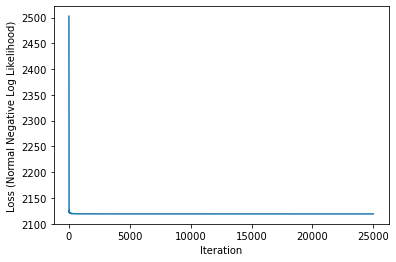

In [43]:
## Plot loss over iteration history
y = jnp.array(l)
x = jnp.arange(len(l))
df = pd.DataFrame({'y':y, 'x':x})

## Seaborn lineplot
ax = sns.lineplot(data=df, y='y', x='x')
ax.set(xlabel='Iteration', ylabel='Loss (Normal Negative Log Likelihood)')
plt.show()

In [ ]:
###################################################################
##
## Gradient descent logistic regression
##
###################################################################

In [65]:
## Data Generator
def datagen(N, num_coef, beta_true):
    ## Dimensions of the problem
    nrow = N
    ncol = num_coef-1
    beta = jnp.array(beta_true).reshape(ncol+1,1)
    ## Create dataset/design-matrix
    X = random.normal(key, shape=(nrow*ncol,)).reshape(nrow,ncol)
    ones = jnp.repeat(1.0, nrow).reshape(nrow,1)
    X = jnp.hstack((ones, X))
    ## Construct linear predictor (y-true)
    mu = jnp.matmul(X, beta)
    p = 1/(1+jnp.exp(-mu))
    ## Simulate ys 
    y = random.bernoulli(key, p=p, shape=(N,1))
    ## Return design matrix and response vector to use
    return X, y

## Parameters for problem
N = 1000
num_coef = 4
beta_true = [0.0,0.0,-0.3,0.2]

## Generation of randpm data
X, y = datagen(N=N, num_coef=num_coef, beta_true=beta_true)

## Check dimensions of returned objects
[X.shape, y.shape]

[(1000, 4), (1000, 1)]

In [66]:
#y

In [67]:
## Sigmoid function
def sigmoid(x):
    return 0.5*(jnp.tanh(x) + 1)

In [75]:
## Linear predictor
def logistic_pred(beta, X):
    return sigmoid(X.dot(beta).reshape(X.shape[0],1))

#logistic_pred(jnp.array(beta), X)

In [77]:
## normall neg log like
def xentropy_nll(beta):
    ## Get predictions
    probs = logistic_pred(beta, X)
    ## Cross entropy loss
    xent = y*jnp.log(probs) + (1-y)*jnp.log(1-probs)
    ## Return sum of neg log lik contributions
    return -jnp.sum(xent)

#xentropy_nll(beta)

DeviceArray(1253.4535, dtype=float32)

In [78]:
## Test the gradient function...
grad_xentropy = grad(xentropy_nll)

#beta = jnp.array([1.0,1.0,0.0,0.0])
#grad_xentropy(beta)

DeviceArray([565.6088  , 352.39505 ,  88.06039 ,  53.153694], dtype=float32)

In [81]:
## Create dataset
N = 1000
num_coef = 4
beta_true = [0.0, 0.2, -0.25, 0.0]
X, y = datagen(N=N, num_coef=num_coef, beta_true=beta_true)

## Initialization beta
beta = jnp.array([-0.1,0.0,0.0,0.0])

## Gradient descent step size parameter
step_size = 1e-3

## Calculate loss at current iteration of beta
grad_xent = jit(grad(xentropy_nll))

l = []

## Training loop
for i in jnp.arange(25000):
    ## Print current value of beta and loss
    current_beta = beta
    current_loss = xentropy_nll(beta)
    l.append(current_loss)
    print("Iteration=",i, "\tLoss=",current_loss, "\tBeta=",beta)
    ## Updated loss using gradient descent step
    beta = beta - step_size*grad_xent(beta)

Iteration= 0 	Loss= 698.339 	Beta= [-0.1  0.   0.   0. ]
Iteration= 1 	Loss= 686.2308 	Beta= [ 0.0016688   0.09161397 -0.0637219  -0.03790598]
Iteration= 2 	Loss= 686.2286 	Beta= [ 0.00161284  0.09106351 -0.06490175 -0.03953476]
Iteration= 3 	Loss= 686.22876 	Beta= [ 0.00170775  0.09105159 -0.06487437 -0.03953855]
Iteration= 4 	Loss= 686.2287 	Beta= [ 0.00170902  0.09104753 -0.06487645 -0.03954181]
Iteration= 5 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104732 -0.06487636 -0.03954188]
Iteration= 6 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487637 -0.0395419 ]
Iteration= 7 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487637 -0.0395419 ]
Iteration= 8 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487638 -0.0395419 ]
Iteration= 9 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 

Iteration= 108 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 109 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 110 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 111 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 112 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 113 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 114 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 115 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 116 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 117 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 118 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 119 	Loss=

Iteration= 243 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 244 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 245 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 246 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 247 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 248 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 249 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 250 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 251 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 252 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 253 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 254 	Loss=

Iteration= 366 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 367 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 368 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 369 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 370 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 371 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 372 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 373 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 374 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 375 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 376 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 377 	Loss=

Iteration= 474 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 475 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 476 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 477 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 478 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 479 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 480 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 481 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 482 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 483 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 484 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 485 	Loss=

Iteration= 588 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 589 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 590 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 591 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 592 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 593 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 594 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 595 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 596 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 597 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 598 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 599 	Loss=

Iteration= 700 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 701 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 702 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 703 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 704 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 705 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 706 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 707 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 708 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 709 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 710 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 711 	Loss=

Iteration= 810 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 811 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 812 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 813 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 814 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 815 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 816 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 817 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 818 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 819 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 820 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 821 	Loss=

Iteration= 922 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 923 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 924 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 925 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 926 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 927 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 928 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 929 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 930 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 931 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 932 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 933 	Loss=

Iteration= 1034 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1035 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1036 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1037 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1038 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1039 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1040 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1041 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1042 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1043 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1044 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 1146 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1147 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1148 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1149 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1150 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1151 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1152 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1153 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1154 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1155 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1156 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 1261 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1262 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1263 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1264 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1265 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1266 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1267 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1268 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1269 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1270 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1271 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 1376 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1377 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1378 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1379 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1380 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1381 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1382 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1383 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1384 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1385 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1386 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 1491 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1492 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1493 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1494 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1495 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1496 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1497 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1498 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1499 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1500 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1501 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 1601 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1602 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1603 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1604 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1605 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1606 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1607 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1608 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1609 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1610 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1611 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 1716 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1717 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1718 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1719 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1720 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1721 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1722 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1723 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1724 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1725 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1726 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 1833 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1834 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1835 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1836 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1837 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1838 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1839 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1840 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1841 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1842 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1843 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 1950 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1951 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1952 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1953 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1954 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1955 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1956 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1957 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1958 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1959 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 1960 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2069 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2070 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2071 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2072 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2073 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2074 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2075 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2076 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2077 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2078 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2079 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2185 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2186 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2187 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2188 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2189 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2190 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2191 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2192 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2193 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2194 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2195 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2294 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2295 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2296 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2297 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2298 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2299 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2300 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2301 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2302 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2303 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2304 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2404 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2405 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2406 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2407 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2408 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2409 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2410 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2411 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2412 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2413 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2414 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2513 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2514 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2515 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2516 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2517 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2518 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2519 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2520 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2521 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2522 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2523 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2625 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2626 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2627 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2628 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2629 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2630 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2631 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2632 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2633 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2634 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2635 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2741 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2742 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2743 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2744 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2745 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2746 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2747 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2748 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2749 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2750 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2751 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2857 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2858 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2859 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2860 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2861 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2862 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2863 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2864 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2865 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2866 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2867 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 2973 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2974 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2975 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2976 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2977 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2978 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2979 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2980 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2981 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2982 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 2983 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 3089 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3090 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3091 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3092 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3093 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3094 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3095 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3096 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3097 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3098 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3099 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 3205 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3206 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3207 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3208 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3209 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3210 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3211 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3212 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3213 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3214 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3215 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 3317 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3318 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3319 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3320 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3321 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3322 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3323 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3324 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3325 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3326 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3327 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 3431 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3432 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3433 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3434 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3435 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3436 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3437 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3438 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3439 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3440 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3441 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 3548 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3549 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3550 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3551 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3552 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3553 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3554 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3555 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3556 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3557 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3558 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 3665 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3666 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3667 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3668 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3669 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3670 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3671 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3672 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3673 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3674 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3675 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 3779 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3780 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3781 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3782 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3783 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3784 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3785 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3786 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3787 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3788 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3789 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 3893 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3894 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3895 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3896 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3897 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3898 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3899 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3900 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3901 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3902 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 3903 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4010 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4011 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4012 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4013 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4014 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4015 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4016 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4017 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4018 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4019 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4020 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4125 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4126 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4127 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4128 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4129 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4130 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4131 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4132 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4133 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4134 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4135 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4238 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4239 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4240 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4241 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4242 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4243 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4244 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4245 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4246 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4247 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4248 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4350 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4351 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4352 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4353 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4354 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4355 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4356 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4357 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4358 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4359 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4360 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4462 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4463 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4464 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4465 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4466 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4467 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4468 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4469 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4470 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4471 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4472 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4573 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4574 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4575 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4576 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4577 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4578 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4579 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4580 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4581 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4582 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4583 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4683 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4684 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4685 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4686 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4687 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4688 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4689 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4690 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4691 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4692 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4693 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4794 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4795 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4796 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4797 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4798 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4799 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4800 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4801 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4802 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4803 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4804 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 4906 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4907 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4908 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4909 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4910 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4911 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4912 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4913 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4914 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4915 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 4916 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5017 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5018 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5019 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5020 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5021 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5022 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5023 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5024 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5025 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5026 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5027 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5127 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5128 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5129 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5130 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5131 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5132 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5133 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5134 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5135 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5136 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5137 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5237 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5238 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5239 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5240 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5241 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5242 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5243 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5244 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5245 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5246 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5247 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5348 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5349 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5350 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5351 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5352 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5353 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5354 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5355 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5356 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5357 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5358 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5463 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5464 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5465 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5466 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5467 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5468 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5469 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5470 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5471 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5472 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5473 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5579 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5580 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5581 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5582 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5583 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5584 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5585 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5586 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5587 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5588 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5589 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5696 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5697 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5698 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5699 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5700 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5701 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5702 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5703 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5704 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5705 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5706 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5817 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5818 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5819 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5820 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5821 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5822 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5823 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5824 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5825 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5826 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5827 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 5947 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5948 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5949 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5950 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5951 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5952 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5953 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5954 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5955 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5956 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 5957 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 6077 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6078 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6079 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6080 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6081 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6082 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6083 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6084 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6085 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6086 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6087 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 6190 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6191 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6192 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6193 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6194 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6195 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6196 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6197 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6198 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6199 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6200 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 6298 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6299 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6300 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6301 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6302 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6303 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6304 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6305 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6306 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6307 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6308 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 6418 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6419 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6420 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6421 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6422 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6423 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6424 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6425 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6426 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6427 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6428 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 6544 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6545 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6546 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6547 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6548 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6549 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6550 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6551 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6552 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6553 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6554 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 6672 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6673 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6674 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6675 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6676 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6677 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6678 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6679 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6680 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6681 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6682 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 6808 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6809 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6810 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6811 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6812 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6813 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6814 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6815 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6816 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6817 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6818 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 6945 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6946 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6947 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6948 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6949 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6950 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6951 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6952 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6953 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6954 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 6955 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 7077 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7078 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7079 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7080 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7081 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7082 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7083 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7084 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7085 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7086 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7087 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 7205 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7206 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7207 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7208 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7209 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7210 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7211 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7212 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7213 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7214 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7215 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 7330 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7331 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7332 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7333 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7334 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7335 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7336 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7337 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7338 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7339 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7340 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 7458 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7459 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7460 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7461 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7462 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7463 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7464 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7465 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7466 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7467 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7468 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 7589 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7590 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7591 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7592 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7593 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7594 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7595 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7596 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7597 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7598 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7599 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 7718 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7719 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7720 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7721 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7722 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7723 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7724 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7725 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7726 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7727 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7728 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 7849 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7850 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7851 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7852 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7853 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7854 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7855 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7856 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7857 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7858 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7859 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 7972 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7973 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7974 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7975 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7976 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7977 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7978 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7979 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7980 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7981 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 7982 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8093 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8094 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8095 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8096 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8097 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8098 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8099 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8100 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8101 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8102 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8103 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8205 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8206 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8207 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8208 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8209 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8210 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8211 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8212 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8213 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8214 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8215 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8310 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8311 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8312 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8313 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8314 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8315 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8316 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8317 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8318 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8319 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8320 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8420 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8421 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8422 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8423 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8424 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8425 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8426 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8427 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8428 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8429 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8430 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8530 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8531 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8532 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8533 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8534 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8535 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8536 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8537 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8538 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8539 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8540 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8641 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8642 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8643 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8644 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8645 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8646 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8647 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8648 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8649 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8650 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8651 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8753 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8754 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8755 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8756 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8757 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8758 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8759 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8760 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8761 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8762 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8763 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8867 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8868 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8869 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8870 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8871 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8872 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8873 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8874 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8875 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8876 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8877 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 8981 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8982 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8983 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8984 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8985 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8986 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8987 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8988 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8989 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8990 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 8991 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9096 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9097 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9098 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9099 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9100 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9101 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9102 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9103 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9104 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9105 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9106 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9208 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9209 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9210 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9211 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9212 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9213 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9214 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9215 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9216 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9217 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9218 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9319 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9320 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9321 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9322 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9323 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9324 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9325 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9326 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9327 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9328 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9329 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9429 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9430 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9431 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9432 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9433 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9434 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9435 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9436 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9437 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9438 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9439 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9539 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9540 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9541 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9542 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9543 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9544 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9545 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9546 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9547 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9548 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9549 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9648 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9649 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9650 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9651 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9652 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9653 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9654 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9655 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9656 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9657 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9658 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9761 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9762 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9763 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9764 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9765 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9766 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9767 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9768 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9769 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9770 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9771 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9871 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9872 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9873 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9874 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9875 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9876 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9877 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9878 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9879 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9880 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9881 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 9985 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9986 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9987 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9988 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9989 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9990 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9991 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9992 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9993 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9994 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 9995 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration=

Iteration= 10097 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10098 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10099 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10100 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10101 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10102 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10103 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10104 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10105 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10106 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10107 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 10208 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10209 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10210 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10211 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10212 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10213 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10214 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10215 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10216 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10217 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10218 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 10318 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10319 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10320 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10321 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10322 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10323 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10324 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10325 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10326 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10327 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10328 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 10428 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10429 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10430 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10431 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10432 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10433 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10434 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10435 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10436 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10437 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10438 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 10542 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10543 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10544 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10545 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10546 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10547 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10548 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10549 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10550 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10551 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10552 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 10661 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10662 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10663 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10664 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10665 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10666 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10667 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10668 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10669 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10670 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10671 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 10789 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10790 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10791 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10792 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10793 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10794 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10795 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10796 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10797 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10798 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10799 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 10915 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10916 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10917 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10918 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10919 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10920 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10921 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10922 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10923 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10924 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 10925 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 11044 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11045 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11046 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11047 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11048 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11049 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11050 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11051 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11052 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11053 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11054 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 11175 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11176 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11177 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11178 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11179 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11180 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11181 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11182 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11183 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11184 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11185 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 11302 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11303 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11304 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11305 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11306 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11307 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11308 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11309 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11310 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11311 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11312 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 11430 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11431 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11432 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11433 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11434 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11435 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11436 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11437 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11438 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11439 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11440 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 11558 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11559 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11560 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11561 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11562 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11563 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11564 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11565 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11566 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11567 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11568 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 11686 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11687 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11688 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11689 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11690 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11691 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11692 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11693 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11694 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11695 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11696 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 11813 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11814 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11815 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11816 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11817 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11818 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11819 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11820 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11821 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11822 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11823 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 11940 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11941 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11942 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11943 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11944 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11945 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11946 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11947 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11948 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11949 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 11950 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 12070 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12071 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12072 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12073 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12074 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12075 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12076 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12077 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12078 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12079 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12080 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 12196 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12197 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12198 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12199 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12200 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12201 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12202 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12203 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12204 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12205 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12206 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 12322 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12323 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12324 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12325 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12326 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12327 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12328 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12329 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12330 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12331 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12332 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 12447 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12448 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12449 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12450 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12451 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12452 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12453 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12454 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12455 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12456 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12457 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 12567 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12568 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12569 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12570 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12571 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12572 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12573 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12574 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12575 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12576 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12577 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 12694 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12695 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12696 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12697 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12698 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12699 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12700 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12701 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12702 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12703 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12704 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 12826 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12827 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12828 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12829 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12830 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12831 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12832 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12833 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12834 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12835 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12836 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 12959 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12960 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12961 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12962 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12963 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12964 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12965 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12966 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12967 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12968 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 12969 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13087 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13088 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13089 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13090 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13091 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13092 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13093 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13094 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13095 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13096 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13097 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13214 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13215 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13216 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13217 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13218 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13219 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13220 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13221 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13222 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13223 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13224 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13307 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13308 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13309 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13310 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13311 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13312 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13313 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13314 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13315 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13316 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13317 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13417 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13418 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13419 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13420 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13421 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13422 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13423 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13424 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13425 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13426 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13427 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13525 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13526 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13527 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13528 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13529 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13530 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13531 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13532 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13533 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13534 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13535 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13634 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13635 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13636 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13637 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13638 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13639 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13640 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13641 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13642 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13643 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13644 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13746 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13747 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13748 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13749 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13750 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13751 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13752 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13753 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13754 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13755 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13756 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13858 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13859 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13860 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13861 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13862 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13863 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13864 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13865 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13866 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13867 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13868 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 13969 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13970 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13971 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13972 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13973 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13974 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13975 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13976 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13977 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13978 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 13979 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14079 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14080 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14081 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14082 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14083 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14084 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14085 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14086 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14087 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14088 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14089 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14189 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14190 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14191 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14192 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14193 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14194 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14195 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14196 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14197 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14198 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14199 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14299 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14300 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14301 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14302 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14303 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14304 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14305 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14306 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14307 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14308 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14309 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14406 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14407 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14408 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14409 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14410 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14411 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14412 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14413 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14414 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14415 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14416 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14514 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14515 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14516 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14517 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14518 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14519 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14520 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14521 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14522 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14523 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14524 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14624 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14625 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14626 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14627 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14628 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14629 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14630 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14631 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14632 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14633 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14634 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14734 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14735 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14736 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14737 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14738 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14739 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14740 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14741 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14742 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14743 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14744 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14844 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14845 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14846 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14847 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14848 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14849 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14850 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14851 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14852 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14853 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14854 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 14952 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14953 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14954 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14955 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14956 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14957 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14958 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14959 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14960 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14961 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 14962 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15060 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15061 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15062 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15063 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15064 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15065 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15066 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15067 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15068 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15069 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15070 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15167 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15168 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15169 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15170 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15171 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15172 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15173 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15174 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15175 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15176 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15177 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15275 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15276 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15277 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15278 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15279 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15280 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15281 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15282 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15283 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15284 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15285 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15384 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15385 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15386 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15387 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15388 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15389 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15390 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15391 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15392 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15393 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15394 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15500 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15501 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15502 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15503 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15504 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15505 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15506 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15507 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15508 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15509 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15510 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15609 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15610 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15611 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15612 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15613 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15614 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15615 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15616 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15617 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15618 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15619 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15719 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15720 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15721 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15722 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15723 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15724 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15725 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15726 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15727 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15728 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15729 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15828 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15829 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15830 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15831 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15832 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15833 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15834 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15835 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15836 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15837 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15838 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 15937 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15938 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15939 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15940 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15941 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15942 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15943 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15944 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15945 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15946 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 15947 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16044 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16045 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16046 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16047 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16048 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16049 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16050 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16051 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16052 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16053 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16054 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16153 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16154 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16155 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16156 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16157 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16158 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16159 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16160 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16161 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16162 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16163 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16261 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16262 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16263 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16264 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16265 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16266 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16267 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16268 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16269 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16270 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16271 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16369 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16370 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16371 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16372 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16373 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16374 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16375 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16376 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16377 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16378 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16379 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16475 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16476 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16477 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16478 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16479 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16480 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16481 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16482 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16483 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16484 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16485 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16583 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16584 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16585 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16586 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16587 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16588 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16589 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16590 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16591 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16592 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16593 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16692 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16693 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16694 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16695 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16696 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16697 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16698 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16699 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16700 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16701 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16702 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16800 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16801 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16802 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16803 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16804 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16805 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16806 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16807 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16808 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16809 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16810 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 16907 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16908 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16909 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16910 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16911 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16912 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16913 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16914 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16915 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16916 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 16917 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17014 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17015 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17016 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17017 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17018 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17019 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17020 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17021 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17022 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17023 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17024 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17123 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17124 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17125 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17126 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17127 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17128 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17129 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17130 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17131 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17132 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17133 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17234 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17235 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17236 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17237 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17238 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17239 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17240 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17241 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17242 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17243 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17244 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17344 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17345 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17346 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17347 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17348 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17349 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17350 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17351 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17352 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17353 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17354 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17454 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17455 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17456 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17457 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17458 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17459 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17460 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17461 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17462 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17463 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17464 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17564 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17565 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17566 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17567 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17568 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17569 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17570 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17571 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17572 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17573 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17574 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17672 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17673 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17674 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17675 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17676 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17677 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17678 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17679 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17680 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17681 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17682 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17781 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17782 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17783 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17784 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17785 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17786 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17787 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17788 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17789 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17790 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17791 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 17891 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17892 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17893 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17894 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17895 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17896 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17897 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17898 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17899 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17900 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 17901 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18002 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18003 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18004 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18005 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18006 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18007 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18008 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18009 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18010 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18011 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18012 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18110 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18111 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18112 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18113 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18114 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18115 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18116 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18117 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18118 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18119 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18120 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18219 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18220 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18221 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18222 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18223 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18224 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18225 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18226 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18227 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18228 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18229 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18328 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18329 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18330 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18331 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18332 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18333 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18334 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18335 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18336 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18337 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18338 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18437 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18438 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18439 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18440 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18441 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18442 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18443 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18444 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18445 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18446 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18447 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18547 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18548 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18549 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18550 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18551 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18552 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18553 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18554 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18555 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18556 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18557 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18657 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18658 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18659 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18660 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18661 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18662 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18663 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18664 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18665 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18666 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18667 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18768 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18769 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18770 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18771 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18772 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18773 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18774 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18775 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18776 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18777 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18778 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18879 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18880 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18881 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18882 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18883 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18884 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18885 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18886 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18887 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18888 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18889 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 18989 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18990 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18991 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18992 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18993 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18994 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18995 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18996 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18997 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18998 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 18999 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19099 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19100 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19101 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19102 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19103 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19104 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19105 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19106 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19107 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19108 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19109 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19211 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19212 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19213 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19214 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19215 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19216 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19217 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19218 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19219 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19220 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19221 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19324 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19325 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19326 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19327 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19328 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19329 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19330 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19331 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19332 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19333 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19334 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19432 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19433 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19434 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19435 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19436 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19437 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19438 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19439 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19440 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19441 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19442 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19542 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19543 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19544 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19545 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19546 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19547 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19548 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19549 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19550 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19551 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19552 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19650 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19651 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19652 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19653 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19654 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19655 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19656 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19657 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19658 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19659 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19660 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19760 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19761 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19762 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19763 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19764 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19765 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19766 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19767 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19768 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19769 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19770 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19869 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19870 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19871 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19872 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19873 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19874 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19875 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19876 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19877 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19878 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19879 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 19975 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19976 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19977 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19978 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19979 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19980 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19981 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19982 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19983 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19984 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 19985 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20085 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20086 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20087 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20088 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20089 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20090 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20091 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20092 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20093 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20094 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20095 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20194 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20195 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20196 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20197 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20198 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20199 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20200 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20201 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20202 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20203 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20204 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20304 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20305 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20306 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20307 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20308 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20309 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20310 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20311 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20312 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20313 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20314 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20411 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20412 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20413 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20414 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20415 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20416 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20417 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20418 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20419 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20420 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20421 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20519 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20520 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20521 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20522 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20523 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20524 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20525 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20526 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20527 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20528 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20529 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20629 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20630 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20631 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20632 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20633 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20634 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20635 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20636 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20637 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20638 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20639 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20738 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20739 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20740 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20741 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20742 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20743 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20744 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20745 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20746 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20747 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20748 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20846 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20847 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20848 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20849 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20850 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20851 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20852 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20853 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20854 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20855 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20856 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 20955 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20956 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20957 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20958 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20959 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20960 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20961 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20962 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20963 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20964 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 20965 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21062 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21063 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21064 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21065 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21066 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21067 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21068 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21069 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21070 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21071 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21072 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21171 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21172 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21173 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21174 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21175 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21176 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21177 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21178 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21179 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21180 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21181 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21281 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21282 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21283 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21284 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21285 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21286 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21287 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21288 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21289 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21290 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21291 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21391 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21392 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21393 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21394 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21395 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21396 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21397 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21398 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21399 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21400 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21401 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21501 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21502 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21503 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21504 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21505 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21506 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21507 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21508 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21509 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21510 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21511 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21612 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21613 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21614 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21615 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21616 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21617 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21618 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21619 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21620 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21621 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21622 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21722 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21723 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21724 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21725 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21726 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21727 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21728 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21729 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21730 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21731 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21732 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21835 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21836 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21837 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21838 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21839 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21840 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21841 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21842 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21843 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21844 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21845 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 21948 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21949 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21950 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21951 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21952 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21953 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21954 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21955 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21956 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21957 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 21958 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22059 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22060 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22061 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22062 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22063 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22064 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22065 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22066 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22067 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22068 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22069 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22171 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22172 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22173 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22174 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22175 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22176 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22177 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22178 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22179 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22180 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22181 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22282 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22283 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22284 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22285 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22286 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22287 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22288 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22289 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22290 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22291 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22292 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22396 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22397 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22398 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22399 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22400 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22401 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22402 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22403 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22404 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22405 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22406 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22508 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22509 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22510 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22511 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22512 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22513 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22514 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22515 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22516 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22517 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22518 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22621 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22622 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22623 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22624 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22625 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22626 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22627 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22628 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22629 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22630 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22631 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22736 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22737 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22738 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22739 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22740 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22741 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22742 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22743 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22744 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22745 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22746 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22853 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22854 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22855 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22856 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22857 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22858 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22859 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22860 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22861 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22862 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22863 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 22969 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22970 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22971 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22972 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22973 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22974 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22975 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22976 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22977 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22978 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 22979 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23085 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23086 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23087 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23088 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23089 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23090 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23091 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23092 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23093 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23094 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23095 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23194 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23195 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23196 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23197 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23198 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23199 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23200 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23201 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23202 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23203 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23204 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23301 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23302 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23303 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23304 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23305 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23306 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23307 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23308 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23309 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23310 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23311 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23405 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23406 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23407 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23408 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23409 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23410 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23411 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23412 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23413 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23414 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23415 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23510 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23511 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23512 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23513 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23514 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23515 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23516 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23517 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23518 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23519 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23520 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23621 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23622 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23623 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23624 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23625 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23626 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23627 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23628 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23629 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23630 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23631 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23733 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23734 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23735 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23736 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23737 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23738 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23739 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23740 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23741 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23742 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23743 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23843 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23844 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23845 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23846 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23847 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23848 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23849 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23850 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23851 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23852 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23853 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 23955 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23956 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23957 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23958 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23959 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23960 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23961 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23962 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23963 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23964 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 23965 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24073 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24074 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24075 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24076 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24077 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24078 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24079 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24080 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24081 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24082 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24083 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24185 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24186 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24187 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24188 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24189 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24190 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24191 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24192 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24193 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24194 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24195 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24296 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24297 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24298 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24299 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24300 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24301 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24302 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24303 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24304 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24305 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24306 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24407 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24408 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24409 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24410 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24411 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24412 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24413 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24414 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24415 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24416 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24417 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24517 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24518 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24519 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24520 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24521 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24522 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24523 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24524 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24525 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24526 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24527 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24629 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24630 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24631 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24632 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24633 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24634 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24635 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24636 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24637 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24638 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24639 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24740 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24741 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24742 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24743 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24744 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24745 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24746 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24747 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24748 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24749 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24750 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24848 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24849 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24850 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24851 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24852 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24853 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24854 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24855 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24856 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24857 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24858 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

Iteration= 24958 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24959 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24960 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24961 	Loss= 686.22864 	Beta= [ 0.0017093   0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24962 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24963 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24964 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24965 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24966 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24967 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]
Iteration= 24968 	Loss= 686.22864 	Beta= [ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]

In [82]:
## Compare final beta estimates (on termination of maximum iteration history) vs. true values
print(beta_true)
print(beta)

[0.0, 0.2, -0.25, 0.0]
[ 0.00170931  0.09104729 -0.06487639 -0.0395419 ]


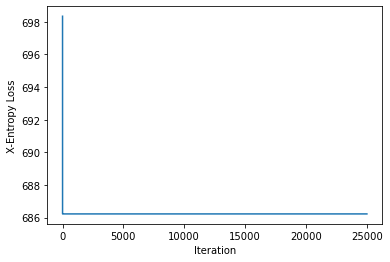

In [83]:
## Plot loss over iteration history
y = jnp.array(l)
x = jnp.arange(len(l))
df = pd.DataFrame({'y':y, 'x':x})

## Seaborn lineplot
ax = sns.lineplot(data=df, y='y', x='x')
ax.set(xlabel='Iteration', ylabel='X-Entropy Loss')
plt.show()

In [44]:
from sinfo import sinfo
sinfo()

-----
jax         0.2.9
matplotlib  3.3.4
numpy       1.20.1
pandas      1.2.2
seaborn     0.11.1
sinfo       0.3.1
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
jupyterlab          3.0.9
notebook            6.2.0
-----
Python 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) [GCC 9.3.0]
Linux-3.10.0-1127.el7.x86_64-x86_64-with-centos-7.8.2003-Core
79 logical CPU cores, x86_64
-----
Session information updated at 2021-02-28 21:34
